In [4]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
from pycausal.pycausal import pycausal as pc
from collections import defaultdict
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text
from pycausal import prior as p
import itertools

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))
    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=False)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=False)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model

def get_bic(df, prior, penalty = 2):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True, penalty = 200
               )
    
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))
def make_categorical(df, complete_df, categoricals):   
    retval = None
    for key in df.columns:
        if retval is not None:
            if key in categoricals:
                retval = np.concatenate((retval, to_categorical(df[key], len(complete_df[key].unique()))), axis = 1)
            else:
                retval = np.concatenate((retval, df[key].values[...,np.newaxis]), axis = 1)
        else:
            if key in categoricals:
                retval = to_categorical(df[key], len(complete_df[key].unique()))
            else:
                retval = df[key]
    return retval
num_models = 60 
pc = pc()
pc.start_vm(java_max_heap_size = '21000M')
tetrad = s.tetradrunner()

models = []
model_names = []



randomize = False
if randomize:
    layers = [256, 512, 1024, 2048, 4096]
    for i in range(num_models):
        network = []
        for j in range(3):
            network.append(layers[random.randint(0,len(layers) -1)])
        models.append(network)
        model_names.append('temp/simb' + str(i))
    print(models, model_names)    
else:
    model_layers = [512, 256]
    for i in range(num_models):
        models.append(model_layers)
        model_names.append('temp/simb' + str(i))

print(models, model_names)

[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256]] ['temp/simb0', 'temp/simb1', 'temp/simb2', 'temp/simb3', 'temp/simb4', 'temp/simb5', 'temp/simb6', 'temp/simb7', 'temp/simb8', 'temp/simb9', 'temp/simb10', 'temp/simb11', 'temp/simb12', 'temp/simb13', 'temp/simb14', 'temp/simb15', 'temp/simb16', 'temp/simb17', 'temp/simb18', 'te

In [5]:
import networkx as nx

def random_dag(nodes, edges):
    """Generate a random Directed Acyclic Graph (DAG) with a given number of nodes and edges."""
    G = nx.DiGraph()
    for i in range(nodes):
        G.add_node(i)
    while edges > 0:
        a = random.randint(0,nodes-1)
        b=a
        while b==a:
            b = random.randint(0,nodes-1)
        G.add_edge(a,b)
        if nx.is_directed_acyclic_graph(G):
            edges -= 1
        else:
            # we closed a loop!
            G.remove_edge(a,b)
    return G



In [6]:
import pydot
from IPython.display import SVG

def examine_graph_continuous(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               )
    return tetrad.getTetradGraph()

def gen_data(list_vertex = [], list_edges = [], mean = 0, var = 1, SIZE = 20000):
    g = []
    for v in list_vertex:
        g.append(np.random.normal(mean,var,SIZE))
        
    for edge in list_edges:
        g[edge[1]] += g[edge[0]]
    g = np.swapaxes(g,0,1)
    return pd.DataFrame(g, columns = list(map(str, list_vertex)))



In [8]:
bestMSE = []
bestBIC = []
bestCOMBO = []
bestPOSSIBLE= []
worstMSE = []
worstBIC = []
worstCOMBO = []
worstPOSSIBLE= []

qbestMSE = []
qbestBIC = []
qbestCOMBO = []
qbestPOSSIBLE= []
qworstMSE = []
qworstBIC = []
qworstCOMBO = []
qworstPOSSIBLE= []


sbestMSE = []
sbestBIC = []
sbestCOMBO = []
sbestPOSSIBLE= []
sworstMSE = []
sworstBIC = []
sworstCOMBO = []
sworstPOSSIBLE= []

sqbestMSE = []
sqbestBIC = []
sqbestCOMBO = []
sqbestPOSSIBLE= []
sqworstMSE = []
sqworstBIC = []
sqworstCOMBO = []
sqworstPOSSIBLE= []

averageDegree = []
targetDegree = []
target_inD = []
target_outD = []
descendants = []
t= 0
while (t < 50):
    train_size = 20000
    nodes = 10
    test_mean = 1
    test_var = 2
    test_size = 2000
    
    G = random_dag(nodes, random.randint(nodes, nodes*nodes)) # since max number of edges is n^2
    df = gen_data(np.arange(nodes), G.edges, SIZE = train_size)
    require = []
    for i in G.edges:
        require.append([str(i[0]), str(i[1])])  
    prior = p.knowledge(requiredirect = require)
    examine_graph_continuous(df, prior)
    
    # Check to make sure that graph matches our prior knowledge. Or else abort this test.
    a = set()
    for i in tetrad.getEdges():
        a.add((i[0], i[-1]))
    b = set()
    for i in require:
        b.add((i[0], i[1]))
    print("A = ", a)
    print("B = ", b)
    if a != b:
        continue
        
    known_conx = set({})
    for i in tetrad.getEdges():
        if ' --> ' in i:
            known_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
    known_conx
        
    # Need to set our inputs and outputs
    inputs = set(np.arange(nodes))
    target = str(a.pop()[random.randint(0,1)])
    inputs.remove(int(target))
    inputs = list(map(str, inputs))
    df_test = gen_data(np.arange(nodes), G.edges, mean = test_mean, var = test_var, SIZE = test_size)
    sdf_test = gen_data(np.arange(nodes), G.edges, mean = 0.1, var = 1.2, SIZE = test_size)
    target = [target]
    
    print("Inputs = ", inputs)
    print("Target = ", target)
    
    x_test = df_test[inputs]
    y_test = df_test[target]
    
    sx_test = sdf_test[inputs]
    sy_test = sdf_test[target]

    causal_split = 0.2
    val_split = 0.2
    train_split = 1 - (causal_split + val_split)

    x_causal = df[inputs][-int(causal_split * len(df)) :]
    y_causal = df[target][-int(causal_split * len(df)) :]

    x_val = df[inputs][int(train_split * len(df)):-int(causal_split * len(df))]
    y_val = df[target][int(train_split * len(df)):-int(causal_split * len(df))]

    x_train = df[inputs][:int(train_split * len(df))]
    y_train = df[target][:int(train_split * len(df))]

    verbosity = 0

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            #clear session
            keras.backend.clear_session() 
            #get model according to specification
            model = get_model(models[idx], [0.2] * len(models), np.shape(x_train)[1])
            callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                         EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
            model.compile(optimizer = optimizers.SGD(lr = 0.0001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
            #print(len(X), len(y))
            model.fit(x_train, y_train, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
        else:
            models[idx].fit(X,y)





    generalization = []
    metrics = []
    proposed = []
    x_causal.reset_index(drop=True, inplace = True)
    for idx, model_name in enumerate(model_names):
        #print(model_name)
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]

        y_pred = model.predict(x_test)
        generalization.append(mean_squared_error(y_pred, y_test))

        #### CHECK FOR CAUSAL METRIC HERE
        y_causal_pred = model.predict(x_causal)
        causal_targets = pd.DataFrame(y_causal_pred, columns = target)
        
        #causal_targets.reset_index(drop=True, inplace = True)
        causal_df = x_causal.join(causal_targets)



        metrics.append(mean_squared_error(y_causal_pred, y_causal))
        #print(x_causal.head)
        bic_pred = get_bic(causal_df, prior)
        #print(bic_pred, tetrad.getEdges())

        found_conx = set({})
        for i in tetrad.getEdges():
            if ' --> ' in i:
                found_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
        found_conx

        if found_conx == known_conx:
            proposed.append(bic_pred)
        else:
            print("******Found an error")
            print(bic_pred, tetrad.getEdges())
            # for now just remove bad model.  Will need to add it to distance metric.
            proposed.append(bic_pred)
            #metrics = metrics[:-1]
            #generalization = generalization[:-1]
    nbest = 6
    print(proposed)
    total = normalize(metrics) + normalize(proposed)
    final = pd.DataFrame(np.stack((metrics, proposed, total, normalize(generalization)), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
    print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization'].values))
    print("Best possible = ",np.sum(final.nsmallest(nbest, 'generalization')['generalization'].values))
    bestMSE.append(final.nsmallest(nbest, 'metrics')['generalization'].values)
    bestBIC.append(final.nsmallest(nbest, 'proposed')['generalization'].values)
    bestCOMBO.append(final.nsmallest(nbest, 'combined')['generalization'].values)
    bestPOSSIBLE.append(final.nsmallest(nbest, 'generalization')['generalization'].values)
    
    print("MSE = ", np.sum(final.nlargest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nlargest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nlargest(nbest, 'combined')['generalization'].values))
    print("Best possible = ",np.sum(final.nlargest(nbest, 'generalization')['generalization'].values))
    worstMSE.append(final.nlargest(nbest, 'metrics')['generalization'].values)
    worstBIC.append(final.nlargest(nbest, 'proposed')['generalization'].values)
    worstCOMBO.append(final.nlargest(nbest, 'combined')['generalization'].values)
    worstPOSSIBLE.append(final.nlargest(nbest, 'generalization')['generalization'].values)
    
    
    nbest = 15
    print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization'].values))
    print("Best possible = ",np.sum(final.nsmallest(nbest, 'generalization')['generalization'].values))
    qbestMSE.append(final.nsmallest(nbest, 'metrics')['generalization'].values)
    qbestBIC.append(final.nsmallest(nbest, 'proposed')['generalization'].values)
    qbestCOMBO.append(final.nsmallest(nbest, 'combined')['generalization'].values)
    qbestPOSSIBLE.append(final.nsmallest(nbest, 'generalization')['generalization'].values)
    
    print("MSE = ", np.sum(final.nlargest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nlargest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nlargest(nbest, 'combined')['generalization'].values))
    print("Best possible = ",np.sum(final.nlargest(nbest, 'generalization')['generalization'].values))
    qworstMSE.append(final.nlargest(nbest, 'metrics')['generalization'].values)
    qworstBIC.append(final.nlargest(nbest, 'proposed')['generalization'].values)
    qworstCOMBO.append(final.nlargest(nbest, 'combined')['generalization'].values)
    qworstPOSSIBLE.append(final.nlargest(nbest, 'generalization')['generalization'].values)
    
    
    generalization = []
    metrics = []
    proposed = []
    for idx, model_name in enumerate(model_names):
        #print(model_name)
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]

        y_pred = model.predict(sx_test)
        generalization.append(mean_squared_error(y_pred, sy_test))

        #### CHECK FOR CAUSAL METRIC HERE
        y_causal_pred = model.predict(x_causal)
        causal_targets = pd.DataFrame(y_causal_pred, columns = target)
        
        #causal_targets.reset_index(drop=True, inplace = True)
        causal_df = x_causal.join(causal_targets)


        metrics.append(mean_squared_error(y_causal_pred, y_causal))
        #print(x_causal.head)
        bic_pred = get_bic(causal_df, prior)
        #print(bic_pred, tetrad.getEdges())

        found_conx = set({})
        for i in tetrad.getEdges():
            if ' --> ' in i:
                found_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
        found_conx

        proposed.append(bic_pred)
       
    nbest = 6
    print(proposed)
    total = normalize(metrics) + normalize(proposed)
    final = pd.DataFrame(np.stack((metrics, proposed, total, normalize(generalization)), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
    print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization'].values))
    print("Best possible = ",np.sum(final.nsmallest(nbest, 'generalization')['generalization'].values))
    sbestMSE.append(final.nsmallest(nbest, 'metrics')['generalization'].values)
    sbestBIC.append(final.nsmallest(nbest, 'proposed')['generalization'].values)
    sbestCOMBO.append(final.nsmallest(nbest, 'combined')['generalization'].values)
    sbestPOSSIBLE.append(final.nsmallest(nbest, 'generalization')['generalization'].values)
    
    print("MSE = ", np.sum(final.nlargest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nlargest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nlargest(nbest, 'combined')['generalization'].values))
    print("Best possible = ",np.sum(final.nlargest(nbest, 'generalization')['generalization'].values))
    sworstMSE.append(final.nlargest(nbest, 'metrics')['generalization'].values)
    sworstBIC.append(final.nlargest(nbest, 'proposed')['generalization'].values)
    sworstCOMBO.append(final.nlargest(nbest, 'combined')['generalization'].values)
    sworstPOSSIBLE.append(final.nlargest(nbest, 'generalization')['generalization'].values)
    
    
    nbest = 15
    print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization'].values))
    print("Best possible = ",np.sum(final.nsmallest(nbest, 'generalization')['generalization'].values))
    sqbestMSE.append(final.nsmallest(nbest, 'metrics')['generalization'].values)
    sqbestBIC.append(final.nsmallest(nbest, 'proposed')['generalization'].values)
    sqbestCOMBO.append(final.nsmallest(nbest, 'combined')['generalization'].values)
    sqbestPOSSIBLE.append(final.nsmallest(nbest, 'generalization')['generalization'].values)
    
    print("MSE = ", np.sum(final.nlargest(nbest, 'metrics')['generalization'].values))
    print("BIC = ", np.sum(final.nlargest(nbest, 'proposed')['generalization'].values))
    print("COMB = ",np.sum(final.nlargest(nbest, 'combined')['generalization'].values))
    print("Best possible = ",np.sum(final.nlargest(nbest, 'generalization')['generalization'].values))
    sqworstMSE.append(final.nlargest(nbest, 'metrics')['generalization'].values)
    sqworstBIC.append(final.nlargest(nbest, 'proposed')['generalization'].values)
    sqworstCOMBO.append(final.nlargest(nbest, 'combined')['generalization'].values)
    sqworstPOSSIBLE.append(final.nlargest(nbest, 'generalization')['generalization'].values)
    
    
    print("Times = ", t)
    d = []
    for i in G.degree():
        d.append(i[1])
        if str(i[0]) in target:
            targetDegree.append(i[1])
    averageDegree.append(np.mean(d))
    target_inD.append(G.in_degree(int(target[0])))
    target_outD.append(G.out_degree(int(target[0])))
    descendants.append(len(nx.descendants(G, int(target[0]))))
    print(targetDegree, averageDegree)
    t += 1
    
np.mean(bestMSE), np.mean(bestCOMBO), np.std(bestMSE), np.std(bestCOMBO)

A =  {('1', '6'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('2', '6'), ('5', '7'), ('6', '7'), ('9', '8'), ('6', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '6'), ('0', '5'), ('0', '8'), ('1', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('2', '6'), ('5', '7'), ('6', '7'), ('9', '8'), ('6', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '6'), ('0', '8'), ('0', '5'), ('1', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('2', '5'), ('0', '3'), ('7', '3')}
A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('0', '2'), ('4', '6'), ('3', '5'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('3', '1')

A =  {('7', '4'), ('7', '9'), ('8', '4'), ('8', '5'), ('6', '9'), ('0', '8'), ('8', '3'), ('7', '6'), ('2', '5'), ('1', '5'), ('2', '9'), ('8', '9'), ('2', '3'), ('1', '3'), ('8', '2'), ('1', '4'), ('7', '3'), ('6', '4'), ('8', '1')}
B =  {('7', '9'), ('6', '9'), ('0', '8'), ('7', '6'), ('2', '5'), ('1', '5'), ('2', '9'), ('1', '3'), ('2', '3'), ('8', '2'), ('1', '4'), ('7', '3'), ('6', '4'), ('8', '1')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('5', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('7', '0'), ('4', '2'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('8', '2'), ('5', '3'), ('7', '4'), ('9', '4'), ('1', '9'), ('8', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('3', '4'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('5', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('7', '0'), ('4', '2'), ('7', '8'), ('7', '5'), ('9', '5'), ('1', '3'), ('5', '3'), ('7', '4'), ('1', '9'), ('9', '7'), ('5'

A =  {('1', '6'), ('2', '0'), ('4', '8'), ('1', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('7', '0'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('4', '9'), ('6', '0'), ('4', '7'), ('1', '9'), ('2', '4'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('6', '8'), ('1', '4'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '8'), ('1', '2'), ('1', '5'), ('1', '8'), ('3', '8'), ('3', '5'), ('6', '3'), ('7', '0'), ('6', '7'), ('7', '8'), ('7', '5'), ('2', '9'), ('1', '3'), ('2', '7'), ('4', '9'), ('6', '0'), ('4', '7'), ('1', '9'), ('2', '4'), ('5', '0'), ('1', '7'), ('8', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('1', '4'), ('7', '3'), ('9', '3')}
A =  {('2', '0'), ('5', '4'), ('8', '4'), ('2', '3'), ('8', '1'), ('7', '0'), ('1', '0'), ('7', '5'), ('8', '6'), ('8', '9'), ('6', '9'), ('2', '9'), ('1', '3'), ('6', '4'), ('8', '3'), ('5', '3'), ('7', '4')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '8'), ('4', '6'), ('3', '8'), ('6', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '9'), ('6', '9'), ('9', '8'), ('9', '2'), ('2', '7'), ('5', '3'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('0', '8'), ('3', '9'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '8'), ('5', '2')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('6', '3'), ('7', '0'), ('9', '0'), ('6', '7'), ('5', '7'), ('7', '8'), ('5', '9'), ('9', '8'), ('9', '2'), ('2', '7'), ('5', '3'), ('4', '9'), ('3', '2'), ('2', '1'), ('4', '7'), ('0', '8'), ('6', '1'), ('3', '9'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '8')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('9', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('9', '5'), ('6', '9'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('9', '0'), ('6', '7'), ('5', '7'), ('8', '7'), ('9', '5'), ('6', '9'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('9', '4'), ('6', '0'), ('4', '7'), ('0', '8'), ('6', '1'), ('4', '3'), ('9', '1'), ('5', '0'), ('1', '7'), ('0', '7'), ('9', '7'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2')}
A = 

A =  {('4', '1'), ('4', '8'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('4', '2'), ('2', '6'), ('3', '1'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('9', '2'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('3', '9'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('3', '7'), ('4', '2'), ('2', '6'), ('3', '1'), ('6', '7'), ('7', '8'), ('7', '5'), ('9', '8'), ('9', '5'), ('9', '2'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('0', '8'), ('6', '1'), ('3', '9'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('6', '5'), ('2', '8'), ('0', '3'), ('3', '4'), ('3', '6')}
A =  {('4', '5'), ('0', '9')

A =  {('5', '4'), ('8', '4'), ('3', '5'), ('3', '8'), ('7', '0'), ('8', '1'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('7', '2'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '8'), ('1', '4'), ('3', '4'), ('9', '3')}
B =  {('3', '5'), ('3', '8'), ('8', '1'), ('3', '1'), ('7', '8'), ('3', '0'), ('7', '5'), ('9', '8'), ('3', '2'), ('0', '4'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('6', '5'), ('2', '8'), ('1', '4'), ('7', '2'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('5', '4'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('7', '8'), ('5', '6'), ('9', '5'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('1', '0'), ('5', '7'), ('3', '0'), ('8', '7'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('2', '7'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '8'), ('5', '2'), ('3', '6')}
B =  {('4', '5'), ('2', '0'), ('4', '8'), ('1', '2'), ('4', '6'), ('3', '5'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('8', '7'), ('9', '8'), ('6', '9'), ('2', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('5', '8'), ('6', '8'), ('6', '5'), ('3', '6')}
A =  {('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('4', '6'), ('2', '3')

A =  {('4', '1'), ('1', '2'), ('5', '4'), ('4', '6'), ('5', '1'), ('4', '2'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('4', '9'), ('0', '4'), ('1', '9'), ('4', '3'), ('5', '0'), ('0', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('1', '2'), ('4', '6'), ('5', '1'), ('7', '8'), ('5', '6'), ('8', '6'), ('6', '2'), ('1', '3'), ('9', '2'), ('5', '2'), ('0', '4'), ('1', '9'), ('4', '3'), ('5', '0'), ('0', '7'), ('5', '8'), ('7', '6'), ('8', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
A =  {('4', '1'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '5'), ('6', '3'), ('5', '1'), ('8', '1'), ('4', '2'), ('3', '1'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('8', '9'), ('6', '2'), ('8', '2'), ('9', '2'), ('8', '3'), ('3', '2'), ('7', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('6', '1'), ('0', '8')

A =  {('5', '4'), ('4', '6'), ('6', '3'), ('3', '7'), ('8', '1'), ('6', '7'), ('8', '7'), ('5', '9'), ('9', '8'), ('8', '3'), ('0', '4'), ('2', '1'), ('4', '7'), ('0', '8'), ('9', '1'), ('5', '0'), ('7', '1'), ('9', '7'), ('5', '8'), ('6', '8'), ('9', '3')}
B =  {('0', '4'), ('2', '1'), ('5', '9'), ('4', '7'), ('0', '8'), ('6', '8'), ('7', '1'), ('4', '6'), ('8', '1'), ('9', '1'), ('9', '8'), ('6', '3'), ('3', '7'), ('5', '0'), ('8', '3')}
A =  {('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('6', '3'), ('8', '1'), ('3', '7'), ('9', '0'), ('6', '7'), ('5', '7'), ('8', '7'), ('8', '6'), ('9', '5'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '4'), ('9', '1'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('5', '2'), ('9', '3')}
B =  {('4', '5'), ('1', '2'), ('0', '2'), ('1', '5'), ('6', '3'), ('8', '1'), ('3', '7'), ('9', '0'), ('5', '7'), ('8', '6'), ('6'

A =  {('5', '4'), ('8', '4'), ('5', '1'), ('8', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('8', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('1', '9'), ('3', '9'), ('2', '4'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('7', '9'), ('0', '1'), ('6', '8'), ('1', '4'), ('7', '3'), ('7', '2')}
B =  {('5', '4'), ('5', '1'), ('8', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('6', '9'), ('6', '4'), ('7', '4'), ('1', '9'), ('3', '9'), ('2', '4'), ('8', '0'), ('5', '0'), ('1', '7'), ('0', '7'), ('7', '9'), ('0', '1'), ('6', '8'), ('1', '4'), ('7', '3'), ('7', '2')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('4', '6'), ('6', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('4', '2'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('8', '7'), ('8', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0')

A =  {('2', '0'), ('5', '4'), ('1', '8'), ('6', '3'), ('2', '3'), ('9', '0'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('0', '8'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('2', '0'), ('5', '4'), ('1', '8'), ('6', '3'), ('2', '3'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('6', '4'), ('5', '3'), ('2', '1'), ('9', '4'), ('0', '5'), ('0', '8'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '8'), ('2', '5'), ('1', '4'), ('3', '4'), ('9', '3')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('4', '2'), ('2', '6'), ('3', '1'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('7', '8'), ('9', '8'), ('9', '2'), ('4', '9'), ('7', '4'), ('0', '6'), ('2', '1'), ('7', '2'), ('3', '9'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('4', '5'), ('4', '8'), ('1', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('7', '0'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('3', '1'), ('7', '8'), ('8', '6'), ('9', '8'), ('9', '5'), ('9', '2'), ('4', '9'), ('7', '4'), ('0', '6'), ('2', '1'), ('7', '2'), ('3', '9'), ('9', '1'), ('5', '0'), ('7', '1'), ('8', '0'), ('9', '6'), ('8', '5'), ('2', '8'), ('3', '4'), ('3', '6')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5')

A =  {('4', '1'), ('4', '0'), ('1', '2'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '5'), ('7', '0'), ('8', '1'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('8', '9'), ('6', '2'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('1', '2'), ('0', '9'), ('1', '5'), ('3', '5'), ('7', '0'), ('8', '1'), ('4', '2'), ('3', '1'), ('7', '8'), ('3', '0'), ('6', '2'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '5'), ('0', '1'), ('6', '8'), ('6', '5'), ('5', '2'), ('7', '2')}
A =  {('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('3', '5'), ('2', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('2', '6'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9')

A =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '9'), ('6', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('8', '6'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('0', '3'), ('8', '2'), ('9', '3')}
B =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '9'), ('6', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('8', '6'), ('8', '9'), ('6', '9'), ('9', '5'), ('2', '9'), ('2', '7'), ('5', '3'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('0', '8'), ('0', '5'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('0', '3'), ('8', '2'), ('9', '3')}
A = 

A =  {('4', '1'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '8'), ('6', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('8', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('8', '2'), ('5', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '2')}
B =  {('4', '1'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '8'), ('6', '3'), ('3', '7'), ('8', '1'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('8', '2'), ('5', '3'), ('4', '9'), ('3', '2'), ('0', '8'), ('6', '1'), ('1', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('7', '9'), ('0', '1'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '2')}
A =  {('1', '6'), ('1', '2')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('4', '2'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '5'), ('4', '3'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('2', '3'), ('8', '1'), ('4', '2'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('8', '9'), ('6', '2'), ('9', '5'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3'), ('0', '6'), ('4', '7'), ('0', '5'), ('9', '1'), ('1', '7'), ('9', '7'), ('8', '5'), ('0', '3'), ('5', '2'), ('7', '2')}
A =  {('4', '1'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('4', '6'), ('8', '1'), ('5', '1'), ('4', '2')

A =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('0', '9'), ('1', '5'), ('4', '6'), ('2', '3'), ('3', '7'), ('4', '2'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('5', '2'), ('0', '6'), ('4', '7'), ('1', '9'), ('3', '9'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('8', '2'), ('3', '6')}
B =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('0', '9'), ('1', '5'), ('4', '6'), ('2', '3'), ('3', '7'), ('4', '2'), ('2', '6'), ('6', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('5', '3'), ('0', '6'), ('4', '7'), ('1', '9'), ('3', '9'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('5', '2')}
A =  {('4', '1'), ('4', '0'), ('8', '4'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '8'), ('3', '0'), ('8', '6')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '8'), ('6', '3'), ('7', '0'), ('5', '1'), ('4', '2'), ('6', '7'), ('3', '1'), ('7', '5'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('9', '2'), ('6', '4'), ('5', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('6', '1'), ('0', '8'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('4', '1'), ('4', '5'), ('0', '2'), ('0', '9'), ('1', '8'), ('5', '1'), ('7', '0'), ('4', '2'), ('6', '7'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('0', '8'), ('6', '1'), ('3', '9'), ('4', '3'), ('0', '1'), ('6', '8'), ('6', '5'), ('0', '3'), ('7', '3'), ('7', '2')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '5')

A =  {('1', '6'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('4', '2'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('3', '2'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('4', '3'), ('1', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('4', '2'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '8'), ('9', '5'), ('6', '2'), ('1', '3'), ('3', '2'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '8'), ('0', '5'), ('1', '9'), ('4', '3'), ('1', '7'), ('9', '6'), ('5', '8'), ('2', '8'), ('2', '5'), ('1', '4'), ('7', '2'), ('9', '3')}
A =  {('2', '0'), ('1', '2'), ('5', '4'), ('4', '6'), ('3', '5'), ('7', '0'), ('5', '1'), ('8', '1')

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('0', '9'), ('1', '8'), ('3', '8'), ('6', '3'), ('7', '0'), ('5', '1'), ('3', '7'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '7'), ('8', '9'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '9'), ('3', '9'), ('2', '4'), ('8', '0'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('2', '8'), ('5', '2'), ('3', '4')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('0', '9'), ('1', '8'), ('6', '3'), ('3', '7'), ('7', '0'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('8', '7'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('4', '7'), ('1', '9'), ('3', '9'), ('2', '4'), ('5', '0'), ('8', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('2', '8'), ('5', '2')}
A =  {('4', '1')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '8'), ('4', '6'), ('2', '3'), ('3', '7'), ('5', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('5', '3'), ('9', '4'), ('6', '0'), ('4', '7'), ('4', '3'), ('9', '1'), ('1', '7'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('1', '8'), ('4', '6'), ('2', '3'), ('5', '1'), ('3', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '8'), ('1', '3'), ('9', '4'), ('6', '0'), ('4', '7'), ('5', '0'), ('1', '7'), ('9', '7'), ('5', '8'), ('3', '6')}
A =  {('2', '0'), ('5', '4'), ('8', '4'), ('3', '5'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('6', '7'), ('3', '1'), ('1', '0'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('7', '8'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('6', '1'), ('3', '9')

A =  {('4', '5'), ('4', '8'), ('3', '0'), ('5', '6'), ('8', '5'), ('9', '5'), ('7', '6'), ('8', '6'), ('9', '3'), ('2', '8'), ('9', '1'), ('8', '9'), ('3', '5'), ('9', '0'), ('8', '0'), ('5', '1'), ('8', '3'), ('2', '4'), ('5', '0'), ('8', '1')}
B =  {('4', '5'), ('4', '8'), ('3', '0'), ('5', '6'), ('8', '5'), ('8', '9'), ('7', '6'), ('9', '3'), ('2', '8'), ('9', '1'), ('3', '5'), ('5', '1'), ('2', '4'), ('5', '0'), ('8', '3')}
A =  {('4', '1'), ('4', '5'), ('1', '2'), ('0', '2'), ('3', '5'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('4', '2'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('0', '5'), ('6', '1'), ('0', '8'), ('3', '9'), ('9', '1'), ('7', '1'), ('7', '9'), ('8', '5'), ('6', '5'), ('3', '4'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '5'), ('1', '2'), ('0', '2'), ('3', '5'), ('7', '0'), ('3', '7'), ('9', '0'), ('4'

A =  {('4', '1'), ('2', '0'), ('5', '4'), ('8', '4'), ('3', '5'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('7', '2'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('2', '0'), ('5', '4'), ('3', '5'), ('5', '1'), ('3', '7'), ('7', '0'), ('8', '1'), ('9', '0'), ('2', '6'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '9'), ('8', '6'), ('8', '2'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('7', '2'), ('3', '9'), ('5', '0'), ('7', '1'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('5', '2'), ('3', '4'), ('3', '6')}
A =  {('4', '1')

A =  {('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '8'), ('3', '0'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('4', '9'), ('3', '2'), ('7', '4'), ('0', '6'), ('0', '5'), ('1', '9'), ('7', '2'), ('3', '9'), ('7', '1'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('7', '3'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('4', '8'), ('4', '0'), ('4', '5'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('1', '5'), ('4', '6'), ('3', '8'), ('3', '5'), ('7', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '8'), ('3', '0'), ('8', '9'), ('6', '9'), ('9', '5'), ('2', '9'), ('1', '3'), ('4', '9'), ('3', '2'), ('7', '4'), ('0', '6'), ('0', '5'), ('1', '9'), ('3', '9'), ('7', '1'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('7', '6'), ('2', '8'), ('2', '5'), ('7', '3'), ('3', '4'), ('3'

A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('1', '0'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('7', '2'), ('1', '4'), ('2', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '8'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '8'), ('3', '5'), ('1', '0'), ('9', '5'), ('6', '2'), ('1', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('5', '2'), ('7', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('8', '5'), ('6', '8'), ('7', '6'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
A =  {('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('8', '4'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '5'), ('2', '3'), ('8', '1'), ('3', '7'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '7'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('1', '9'), ('3', '9'), ('2', '4'), ('8', '0'), ('1', '7'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('8', '4'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '5'), ('2', '3'), ('3', '7'), ('8', '1'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '7'), ('5', '9'), ('6', '9'), ('8', '6'), ('2', '9'), ('1', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('0', '5'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('2', '8'), ('2'

A =  {('4', '5'), ('2', '0'), ('4', '0'), ('1', '2'), ('8', '4'), ('4', '6'), ('3', '5'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('1', '0'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('8', '7'), ('6', '2'), ('8', '9'), ('8', '2'), ('9', '2'), ('8', '3'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('7', '2'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('4', '5'), ('2', '0'), ('4', '0'), ('1', '2'), ('4', '6'), ('3', '5'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('1', '0'), ('3', '1'), ('7', '5'), ('8', '7'), ('8', '9'), ('9', '5'), ('6', '2'), ('8', '2'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('7', '2'), ('9', '1'), ('5', '0'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
A =  {('4', '1'), ('1', '6')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('8', '9'), ('6', '2'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '7'), ('7', '9'), ('0', '1'), ('3', '4'), ('6', '5'), ('7', '6'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('3', '7'), ('3', '1'), ('7', '8'), ('3', '0'), ('7', '5'), ('8', '9'), ('8', '2'), ('9', '2'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '7'), ('7', '9'), ('0', '1'), ('6', '5'), ('7', '6'), ('5', '2'), ('3', '4')}
A =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '8'), ('7', '0'), ('9', '0'), ('6', '7'), ('7', '8'), ('3', '0'), ('5', '6')

A =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('2', '3'), ('7', '0'), ('3', '7'), ('9', '0'), ('2', '6'), ('3', '1'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('0', '8'), ('3', '9'), ('2', '4'), ('1', '7'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('6', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('5', '4'), ('2', '3'), ('3', '7'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('3', '1'), ('9', '8'), ('2', '9'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('0', '8'), ('3', '9'), ('2', '4'), ('1', '7'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('1', '6'), ('5', '4'), ('8', '4'), ('1', '5'), ('8', '1'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('8', '6'), ('8', '9'), ('6', '9')

A =  {('2', '0'), ('5', '4'), ('8', '4'), ('1', '8'), ('3', '8'), ('2', '3'), ('5', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '7'), ('9', '8'), ('2', '7'), ('6', '4'), ('5', '3'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('2', '4'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('2', '0'), ('5', '4'), ('8', '4'), ('1', '8'), ('3', '8'), ('2', '3'), ('3', '7'), ('5', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '6'), ('9', '8'), ('6', '4'), ('5', '3'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('2', '4'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6'), ('9', '3')}
A =  {('4', '5'), ('4', '8'), ('1', '2'), ('0', '2')

A =  {('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('0', '5'), ('1', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('8', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('4', '8'), ('4', '0'), ('4', '5'), ('1', '2'), ('0', '2'), ('1', '8'), ('1', '5'), ('4', '6'), ('6', '3'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('5', '2'), ('7', '4'), ('6', '0'), ('0', '5'), ('1', '9'), ('4', '3'), ('1', '7'), ('8', '0'), ('9', '6'), ('8', '5'), ('6', '5'), ('6', '8'), ('7', '6'), ('0'

A =  {('1', '6'), ('2', '0'), ('1', '2'), ('5', '4'), ('7', '0'), ('3', '7'), ('9', '0'), ('3', '1'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('2', '4'), ('5', '0'), ('7', '9'), ('6', '8'), ('7', '6'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('1', '0'), ('3', '1'), ('1', '2'), ('5', '2'), ('5', '9'), ('5', '6'), ('6', '0'), ('6', '9'), ('6', '8'), ('2', '9'), ('7', '9'), ('7', '5'), ('8', '9'), ('9', '4'), ('7', '0'), ('3', '7'), ('2', '4'), ('9', '0')}
A =  {('4', '1'), ('5', '4'), ('8', '4'), ('3', '5'), ('6', '3'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('9', '1'), ('7', '1'), ('8', '0'), ('8', '5')

A =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '8'), ('6', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('9', '4'), ('6', '0'), ('1', '4'), ('4', '3'), ('9', '1'), ('7', '1'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('4', '8'), ('4', '5'), ('0', '2'), ('1', '8'), ('1', '5'), ('3', '8'), ('6', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('9', '8'), ('9', '5'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('9', '4'), ('6', '0'), ('4', '3'), ('9', '1'), ('7', '1'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '8'), ('6', '5'), ('0', '3'), ('5', '2'), ('7', '3')}
A =  {('4', '1'), ('4', '8'), ('4', '0'), ('0', '2'), ('0', '9')

A =  {('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('9', '5'), ('9', '8'), ('6', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('9', '4'), ('6', '0'), ('4', '7'), ('0', '8'), ('1', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '8'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '5'), ('6', '3'), ('2', '3'), ('9', '0'), ('1', '0'), ('2', '7'), ('5', '3'), ('9', '4'), ('6', '0'), ('0', '8'), ('1', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('2', '8'), ('7', '3')}
A =  {('4', '0'), ('5', '4'), ('8', '4'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2')

[-125977.36653763251, -125995.91448458072, -125986.32226924854, -125987.21617690126, -125928.61868612208, -125986.37961638987, -125981.51025157698, -125985.80180963987, -125993.3656966028, -125956.36954329298, -125985.92577516103, -125918.55165203514, -125945.76674951894, -125965.7277359813, -125972.64907427727, -126001.78460751164, -125951.95143550825, -125998.12337422394, -125995.1200220497, -125974.68969972125, -125985.95778055328, -126019.79916019001, -125961.96941745994, -125955.08165776647, -125919.73605549608, -125987.71003769076, -126034.39846165305, -125991.87480665637, -125970.21323911462, -125944.46805751488, -126024.228726673, -126005.6391323266, -126007.2428642192, -125983.76151833078, -125934.34382504887, -125973.22451114857, -125972.87025323456, -125952.66116635152, -125963.08977120824, -125912.74467875778, -125951.27082503906, -125966.58027305538, -125954.40903620308, -125998.23734538809, -126011.72887009206, -125975.94126304475, -126003.30738002963, -125953.3779763432,

A =  {('4', '5'), ('8', '4'), ('0', '2'), ('6', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('6', '7'), ('8', '7'), ('8', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('6', '4'), ('8', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '8'), ('4', '3'), ('9', '1'), ('2', '4'), ('7', '1'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('0', '3'), ('8', '2'), ('9', '3')}
B =  {('4', '5'), ('0', '2'), ('3', '7'), ('5', '1'), ('6', '7'), ('8', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('6', '4'), ('8', '3'), ('4', '9'), ('0', '6'), ('0', '8'), ('4', '3'), ('2', '4'), ('7', '1'), ('9', '7'), ('8', '5'), ('0', '1'), ('2', '5'), ('0', '3'), ('8', '2'), ('9', '3')}
A =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('7', '8'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9')

A =  {('1', '6'), ('5', '4'), ('8', '4'), ('1', '5'), ('6', '3'), ('8', '1'), ('9', '0'), ('6', '7'), ('1', '0'), ('8', '7'), ('8', '6'), ('9', '5'), ('8', '9'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('1', '4'), ('9', '1'), ('8', '0'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('0', '3'), ('5', '2'), ('3', '4'), ('9', '3')}
B =  {('8', '4'), ('1', '5'), ('8', '1'), ('9', '0'), ('6', '7'), ('1', '0'), ('8', '7'), ('8', '6'), ('8', '9'), ('9', '5'), ('6', '2'), ('1', '3'), ('5', '3'), ('5', '2'), ('0', '4'), ('0', '6'), ('9', '1'), ('8', '0'), ('1', '7'), ('0', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('0', '3'), ('8', '2'), ('3', '4')}
A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('3', '5'), ('6', '3'), ('3', '8'), ('5', '1'), ('8', '1'), ('3', '1'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('8', '2'), ('9', '2'), ('6', '4'), ('4', '9'), ('3', '2')

A =  {('4', '8'), ('8', '7'), ('8', '5'), ('4', '7'), ('6', '5'), ('6', '8'), ('4', '6'), ('2', '8'), ('8', '0'), ('7', '0'), ('9', '0'), ('8', '1')}
B =  {('4', '8'), ('8', '7'), ('8', '5'), ('4', '7'), ('6', '5'), ('6', '8'), ('2', '8'), ('4', '6'), ('7', '0'), ('9', '0'), ('8', '1')}
A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('4', '6'), ('3', '5'), ('7', '0'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('8', '6'), ('5', '9'), ('7', '8'), ('6', '2'), ('8', '9'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('1', '9'), ('7', '2'), ('3', '9'), ('7', '1'), ('8', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('7', '6'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('4', '8'), ('4', '0'), ('4', '5'), ('0', '2'), ('1', '5'), ('3', '5'), ('3', '7'), ('7', '0'), ('8', '1'), ('4', '2'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('7'

A =  {('4', '1'), ('4', '8'), ('4', '0'), ('0', '2'), ('1', '8'), ('3', '5'), ('2', '3'), ('4', '2'), ('7', '8'), ('9', '5'), ('8', '9'), ('2', '1'), ('0', '8'), ('3', '9'), ('4', '3'), ('7', '1'), ('9', '6'), ('2', '8'), ('0', '3'), ('7', '3'), ('7', '2')}
B =  {('4', '2'), ('4', '8'), ('4', '0'), ('2', '1'), ('9', '6'), ('8', '9'), ('0', '2'), ('0', '8'), ('9', '5'), ('1', '8'), ('3', '9'), ('3', '5'), ('0', '3'), ('2', '3'), ('7', '2')}
A =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('6', '7'), ('1', '0'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('5', '8'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '0'), ('5', '4'), ('6', '3'), ('2', '3'), ('5', '1'), ('8', '1'), ('9', '0'), ('6', '7'), ('1', '0'), ('9', '5'), ('6'

A =  {('4', '5'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('7', '0'), ('8', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '2'), ('8', '3'), ('0', '8'), ('7', '1'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('2', '6'), ('3', '1'), ('4', '8'), ('4', '5'), ('7', '8'), ('7', '5'), ('9', '6'), ('9', '7'), ('0', '8'), ('9', '3'), ('2', '5'), ('1', '5'), ('4', '6'), ('3', '5'), ('9', '2'), ('8', '3'), ('7', '0'), ('7', '3'), ('7', '2'), ('8', '1')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('5', '4'), ('4', '6'), ('2', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('1', '9'), ('4', '3'), ('2', '4'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6')

A =  {('2', '0'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '3'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('2', '0'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('2', '3'), ('3', '7'), ('2', '6'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '9'), ('8', '6'), ('2', '9'), ('2', '7'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '8'), ('0', '5'), ('1', '9'), ('3', '9'), ('2', '4'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('2', '5'), ('1', '4'), ('3', '6')}
A =  {('1', '6'), ('5', '4'), ('0', '2'), ('0', '9')

A =  {('1', '6'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '5'), ('3', '8'), ('7', '0'), ('6', '7'), ('7', '5'), ('3', '0'), ('7', '8'), ('1', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('7', '9'), ('8', '5'), ('3', '4'), ('2', '5'), ('8', '2'), ('7', '2')}
B =  {('1', '6'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '8'), ('3', '5'), ('7', '0'), ('6', '7'), ('3', '0'), ('1', '3'), ('4', '9'), ('0', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('2', '4'), ('1', '7'), ('7', '9'), ('2', '5'), ('8', '2'), ('7', '2')}
A =  {('5', '4'), ('8', '4'), ('0', '2'), ('3', '5'), ('5', '1'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('3', '9'), ('1', '4'), ('7', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('5', '8')

A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('7', '0'), ('9', '0'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('0', '8'), ('7', '2'), ('1', '4'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('6', '8'), ('5', '2'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '8'), ('1', '5'), ('3', '5'), ('3', '8'), ('7', '0'), ('9', '0'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('0', '8'), ('6', '1'), ('7', '2'), ('1', '4'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '8'), ('5', '2'), ('3', '4'), ('3'

A =  {('1', '6'), ('2', '3'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '6'), ('9', '5'), ('2', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('2', '6'), ('1', '0'), ('0', '4'), ('0', '6'), ('3', '0'), ('5', '7'), ('7', '4'), ('6', '5'), ('8', '5'), ('8', '6'), ('9', '6'), ('2', '9'), ('2', '8'), ('2', '5'), ('9', '4'), ('2', '3'), ('9', '7'), ('1', '7'), ('3', '6')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('5', '4'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('7', '8'), ('8', '9'), ('2', '9'), ('1', '3'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('6', '0'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('2', '4'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '8')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('4', '2'), ('8', '7'), ('5', '6'), ('5', '9'), ('8', '6'), ('6', '9'), ('8', '9'), ('2', '9'), ('8', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('7', '9'), ('8', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3')}
B =  {('4', '1'), ('1', '6'), ('4', '5'), ('1', '2'), ('0', '2'), ('1', '8'), ('1', '5'), ('4', '6'), ('6', '3'), ('2', '3'), ('4', '2'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('8', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('7', '9'), ('8', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3')}
A =  {('4', '1'), ('4', '0'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('8', '7'), ('7', '5'), ('8', '6')

******Found an error
-18797.60958907256 ['0 --> 1', '2 --> 0', '2 --> 1', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 4', '6 --> 0', '5 --> 1', '6 --> 1', '8 --> 0', '2 --> 6', '9 --> 0', '5 --> 4', '9 --> 1', '2 --> 8', '6 --> 4', '7 --> 4', '8 --> 3', '5 --> 6', '5 --> 7', '9 --> 4', '8 --> 6', '8 --> 9']
******Found an error
-17773.02710653443 ['0 --> 1', '2 --> 0', '2 --> 1', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 4', '6 --> 0', '5 --> 1', '6 --> 1', '8 --> 0', '2 --> 6', '9 --> 0', '5 --> 4', '9 --> 1', '2 --> 8', '6 --> 4', '7 --> 4', '8 --> 3', '5 --> 6', '5 --> 7', '9 --> 4', '8 --> 6', '8 --> 9']
******Found an error
-18521.37679746112 ['0 --> 1', '2 --> 0', '2 --> 1', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 4', '6 --> 0', '5 --> 1', '6 --> 1', '8 --> 0', '2 --> 6', '9 --> 0', '5 --> 4', '9 --> 1', '2 --> 8', '6 --> 4', '7 --> 4', '8 --> 3', '5 --> 6', '5 --> 7', '9 --> 4', '8 --> 6', '8 --> 9']
******Found an error
-18878.778109430834 ['0 --> 1', '2 --> 0', '2 --> 1', '0 --> 4',

******Found an error
-17798.590169056348 ['0 --> 1', '2 --> 0', '2 --> 1', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 4', '6 --> 0', '5 --> 1', '6 --> 1', '8 --> 0', '2 --> 6', '9 --> 0', '5 --> 4', '9 --> 1', '2 --> 8', '6 --> 4', '7 --> 4', '8 --> 3', '5 --> 6', '5 --> 7', '9 --> 4', '8 --> 6', '8 --> 9']
******Found an error
-18903.56705844235 ['0 --> 1', '2 --> 0', '2 --> 1', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 4', '6 --> 0', '5 --> 1', '6 --> 1', '8 --> 0', '2 --> 6', '9 --> 0', '5 --> 4', '9 --> 1', '2 --> 8', '6 --> 4', '7 --> 4', '8 --> 3', '5 --> 6', '5 --> 7', '9 --> 4', '8 --> 6', '8 --> 9']
******Found an error
-17917.498471906987 ['0 --> 1', '2 --> 0', '2 --> 1', '0 --> 4', '1 --> 4', '2 --> 4', '0 --> 6', '1 --> 6', '8 --> 0', '2 --> 6', '9 --> 0', '5 --> 4', '9 --> 1', '2 --> 8', '6 --> 4', '7 --> 4', '8 --> 3', '5 --> 6', '5 --> 7', '9 --> 4', '9 --> 6', '8 --> 9']
******Found an error
-17175.351516458042 ['0 --> 1', '2 --> 0', '2 --> 1', '0 --> 4', '1 --> 4', '5 --> 0

A =  {('4', '1'), ('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '2'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('7', '8'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('0', '8'), ('7', '2'), ('3', '9'), ('9', '1'), ('7', '1'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('3', '4')}
B =  {('4', '1'), ('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '2'), ('4', '6'), ('3', '5'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('4', '9'), ('7', '4'), ('6', '0'), ('0', '8'), ('3', '9'), ('5', '0'), ('7', '1'), ('9', '6'), ('5', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('3', '4')}
A =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '9'), ('3', '8'), ('6', '3')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('2', '3'), ('7', '0'), ('4', '2'), ('2', '6'), ('7', '8'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('0', '9'), ('1', '8'), ('1', '5'), ('4', '6'), ('2', '3'), ('4', '2'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '8'), ('2', '5'), ('7', '3'), ('7', '2')}
A =  {('2', '0'), ('5', '7'), ('7', '9'), ('3', '0'), ('6', '0'), ('6', '8')

******Found an error
-21646.334420683317 ['2 --> 0', '3 --> 0', '4 --> 0', '6 --> 0', '7 --> 0', '3 --> 5', '9 --> 1', '3 --> 8', '3 --> 9', '5 --> 7', '6 --> 8', '7 --> 9']
******Found an error
-21545.636366613187 ['2 --> 0', '3 --> 0', '4 --> 0', '6 --> 0', '7 --> 0', '3 --> 5', '9 --> 1', '3 --> 8', '3 --> 9', '5 --> 7', '6 --> 8', '7 --> 9']
******Found an error
-21691.92422699754 ['2 --> 0', '3 --> 0', '4 --> 0', '6 --> 0', '7 --> 0', '3 --> 5', '9 --> 0', '9 --> 1', '3 --> 8', '3 --> 9', '5 --> 7', '6 --> 8', '7 --> 9']
******Found an error
-25937.301998184103 ['2 --> 0', '3 --> 0', '5 --> 0', '6 --> 0', '7 --> 0', '3 --> 5', '9 --> 1', '3 --> 8', '3 --> 9', '5 --> 7', '6 --> 8', '7 --> 9']
******Found an error
-21558.02555309943 ['2 --> 0', '3 --> 0', '4 --> 0', '6 --> 0', '7 --> 0', '3 --> 5', '9 --> 1', '3 --> 8', '3 --> 9', '5 --> 7', '6 --> 8', '7 --> 9']
******Found an error
-21605.540570321416 ['2 --> 0', '3 --> 0', '4 --> 0', '6 --> 0', '7 --> 0', '3 --> 5', '9 --> 0', '9

A =  {('4', '1'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('2', '4'), ('9', '1'), ('1', '7'), ('9', '7'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('9', '3')}
B =  {('4', '1'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('6', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('2', '6'), ('3', '1'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('0', '8'), ('0', '5'), ('4', '3'), ('2', '4'), ('1', '7'), ('9', '7'), ('6', '8'), ('2', '8'), ('0', '3'), ('9', '3')}
A =  {('4', '8'), ('5', '4'), ('6', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('2', '6'), ('5', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9')

A =  {('4', '1'), ('2', '0'), ('8', '4'), ('0', '9'), ('6', '3'), ('2', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('2', '6'), ('6', '7'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('8', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('2', '5'), ('2', '8'), ('0', '3'), ('9', '3')}
B =  {('4', '1'), ('2', '0'), ('8', '4'), ('0', '9'), ('6', '3'), ('2', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('6', '7'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('6', '9'), ('6', '4'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('2', '8'), ('2', '5'), ('0', '3'), ('9', '3')}
A =  {('4', '5'), ('4', '0'), ('8', '4'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '5')

A =  {('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('1', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('6', '0'), ('0', '5'), ('4', '3'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('8', '4'), ('0', '2'), ('1', '8'), ('1', '5'), ('2', '3'), ('7', '0'), ('9', '0'), ('1', '0'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('5', '3'), ('7', '4'), ('0', '4'), ('6', '0'), ('0', '5'), ('4', '3'), ('9', '1'), ('1', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3')}
A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('2', '3'), ('7', '0'), ('8', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0')

A =  {('4', '1'), ('4', '0'), ('1', '2'), ('3', '5'), ('6', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('7', '5'), ('7', '8'), ('6', '9'), ('6', '2'), ('9', '2'), ('3', '2'), ('5', '2'), ('7', '4'), ('6', '0'), ('6', '1'), ('4', '3'), ('7', '1'), ('7', '9'), ('5', '8'), ('6', '5'), ('6', '8'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '0'), ('1', '2'), ('3', '5'), ('6', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('7', '8'), ('6', '9'), ('6', '2'), ('9', '2'), ('3', '2'), ('7', '4'), ('6', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2')}
A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('6', '3'), ('2', '3'), ('8', '1'), ('6', '7'), ('1', '0'), ('8', '7'), ('7', '5'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3')

******Found an error
-84420.16665325209 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 3', '5 --> 1', '2 --> 4', '6 --> 0', '3 --> 4', '5 --> 2', '7 --> 0', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '9 --> 0', '6 --> 3', '8 --> 2', '7 --> 3', '9 --> 1', '6 --> 4', '8 --> 3', '7 --> 4', '9 --> 2', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-84437.52391878425 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 3', '5 --> 1', '2 --> 4', '6 --> 0', '3 --> 4', '5 --> 2', '7 --> 0', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '9 --> 0', '6 --> 3', '8 --> 2', '7 --> 3', '9 --> 1', '6 --> 4', '8 --> 3', '7 --> 4', '9 --> 2', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '5 --> 8', '7 --> 6', '9 --

******Found an error
-84423.91972797923 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 3', '5 --> 1', '2 --> 4', '6 --> 0', '3 --> 4', '5 --> 2', '7 --> 0', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '9 --> 0', '6 --> 3', '8 --> 2', '7 --> 3', '9 --> 1', '6 --> 4', '8 --> 3', '7 --> 4', '9 --> 2', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-84411.2272890684 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 3', '5 --> 1', '2 --> 4', '6 --> 0', '3 --> 4', '5 --> 2', '7 --> 0', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '9 --> 0', '6 --> 3', '8 --> 2', '7 --> 3', '9 --> 1', '6 --> 4', '8 --> 3', '7 --> 4', '9 --> 2', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '5 --> 8', '7 --> 6', '9 -->

******Found an error
-84472.16282367698 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 3', '5 --> 1', '2 --> 4', '6 --> 0', '3 --> 4', '5 --> 2', '7 --> 0', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '9 --> 0', '6 --> 3', '8 --> 2', '7 --> 3', '9 --> 1', '6 --> 4', '8 --> 3', '7 --> 4', '9 --> 2', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-84438.75177427073 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 3', '5 --> 1', '2 --> 4', '6 --> 0', '3 --> 4', '5 --> 2', '7 --> 0', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '9 --> 0', '6 --> 3', '8 --> 2', '7 --> 3', '9 --> 1', '6 --> 4', '8 --> 3', '7 --> 4', '9 --> 2', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '5 --> 8', '7 --> 6', '9 --

******Found an error
-84442.2824650653 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 3', '5 --> 1', '2 --> 4', '6 --> 0', '3 --> 4', '5 --> 2', '7 --> 0', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '9 --> 0', '6 --> 3', '8 --> 2', '7 --> 3', '9 --> 1', '6 --> 4', '8 --> 3', '7 --> 4', '9 --> 2', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-84471.26227249319 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 3', '5 --> 1', '2 --> 4', '6 --> 0', '3 --> 4', '5 --> 2', '7 --> 0', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '9 --> 0', '6 --> 3', '8 --> 2', '7 --> 3', '9 --> 1', '6 --> 4', '8 --> 3', '7 --> 4', '9 --> 2', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '5 --> 8', '7 --> 6', '9 -->

A =  {('1', '6'), ('2', '0'), ('4', '5'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '7'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('8', '7'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('0', '6'), ('9', '4'), ('4', '7'), ('1', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('2', '5'), ('8', '2'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('0', '9'), ('1', '8'), ('1', '5'), ('3', '5'), ('6', '3'), ('3', '7'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('8', '9'), ('6', '9'), ('9', '5'), ('2', '9'), ('8', '2'), ('2', '7'), ('0', '6'), ('9', '4'), ('4', '3'), ('8', '0'), ('0', '7'), ('9', '7'), ('6', '5'), ('2', '5'), ('1', '4')}
A =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('1', '8'), ('3', '5'), ('3', '8'), ('5', '1'), ('9', '0'), ('6', '7'), ('3', '1'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4')

A =  {('4', '1'), ('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('4', '2'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('6', '1'), ('1', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('5', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('2', '0'), ('5', '4'), ('0', '9'), ('4', '6'), ('6', '3'), ('5', '1'), ('8', '1'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('8', '9'), ('1', '3'), ('8', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('6', '1'), ('1', '9'), ('4', '3'), ('5', '0'), ('7', '1'), ('8', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('5', '2'), ('9', '3')}
A =  {('4', '8'), ('1', '2'), ('5', '4')

A =  {('4', '1'), ('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('3', '5'), ('6', '3'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('8', '2'), ('6', '4'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '7'), ('5', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('5', '2'), ('3', '4')}
B =  {('4', '1'), ('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('3', '8'), ('3', '5'), ('6', '3'), ('3', '7'), ('7', '0'), ('8', '1'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('6', '4'), ('4', '9'), ('3', '2'), ('6', '0'), ('6', '1'), ('1', '9'), ('7', '2'), ('3', '9'), ('5', '0'), ('1', '7'), ('7', '9'), ('8', '5'), ('6', '8'), ('6', '5'), ('5', '2'), ('3', '4')}
A =  {('2', '0'), ('4', '0'), ('1', '2')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('9', '5'), ('8', '6'), ('6', '2'), ('9', '8'), ('9', '2'), ('2', '7'), ('3', '2'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('6', '1'), ('3', '9'), ('9', '1'), ('1', '7'), ('8', '0'), ('5', '0'), ('0', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('5', '2')}
B =  {('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('9', '5'), ('6', '2'), ('2', '7'), ('3', '2'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('3', '9'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('5', '2')}
A =  {('4', '1'), ('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('5', '4'), ('1', '5'), ('1', '8'), ('3', '8'), ('6', '3'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('2', '8'), ('5', '2')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('5', '4'), ('1', '8'), ('1', '5'), ('3', '8'), ('6', '3'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('3', '2'), ('5', '2'), ('6', '0'), ('4', '7'), ('1', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('2', '8'), ('1', '4')}
A = 

A =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('7', '4'), ('0', '6'), ('1', '9'), ('1', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3'), ('7', '8'), ('7', '5'), ('9', '5'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('7', '4'), ('0', '6'), ('1', '9'), ('1', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '8'), ('6', '5'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '2'), ('9', '3')}
A =  {('4', '1'), ('5', '4'), ('8', '4'), ('3', '5'), ('7', '0'), ('5', '1'), ('8', '1')

A =  {('2', '0'), ('3', '8'), ('2', '3'), ('7', '0'), ('8', '1'), ('6', '7'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('0', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('9', '1'), ('2', '4'), ('7', '1'), ('7', '9'), ('6', '5'), ('2', '5'), ('0', '3'), ('7', '3'), ('7', '2')}
B =  {('2', '0'), ('3', '8'), ('7', '0'), ('8', '1'), ('6', '7'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('0', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('7', '1'), ('7', '9'), ('6', '5'), ('0', '3'), ('7', '3'), ('7', '2')}
A =  {('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('9', '5'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('8', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('1', '9'), ('2', '4'), ('8', '0'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6')

A =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('0', '8'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '8'), ('1', '5'), ('2', '3'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('0', '8'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2')}
A =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('2', '3'), ('3', '7')

A =  {('4', '8'), ('2', '0'), ('5', '4'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('8', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '7'), ('8', '9'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('3', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6')}
B =  {('4', '8'), ('2', '0'), ('5', '4'), ('4', '6'), ('3', '8'), ('3', '5'), ('5', '1'), ('8', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '7'), ('5', '9'), ('6', '9'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('0', '5'), ('6', '1'), ('3', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('0', '1'), ('6', '8'), ('2', '8'), ('2', '5'), ('3', '4'), ('3', '6')}
A =  {('4', '5'), ('2', '0')

A =  {('2', '0'), ('5', '4'), ('8', '4'), ('3', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('6', '4'), ('5', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('6', '1'), ('0', '8'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2')}
B =  {('2', '0'), ('5', '4'), ('8', '4'), ('3', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '0'), ('9', '0'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '1'), ('0', '5'), ('0', '8'), ('6', '1'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('5', '8'), ('6', '8'), ('0', '1'), ('6', '5'), ('7', '6'), ('2', '8'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2')}
A =  {('4', '9'), ('7', '9'), ('8', '6'), ('8', '9'), ('0', '1'), ('4', '7')

A =  {('4', '8'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('3', '7'), ('9', '0'), ('6', '7'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('0', '8'), ('1', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '8'), ('5', '2'), ('9', '3')}
B =  {('4', '8'), ('2', '0'), ('1', '2'), ('1', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('9', '0'), ('6', '7'), ('7', '8'), ('3', '0'), ('5', '9'), ('9', '8'), ('6', '2'), ('2', '9'), ('2', '7'), ('6', '4'), ('9', '4'), ('6', '0'), ('4', '7'), ('0', '8'), ('6', '1'), ('1', '9'), ('1', '4'), ('4', '3'), ('5', '0'), ('1', '7'), ('0', '7'), ('5', '8'), ('6', '5'), ('2', '8'), ('5', '2'), ('9', '3')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('8', '4'), ('1', '5'), ('4', '6')

A =  {('2', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('6', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('8', '9'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('1', '4'), ('4', '3'), ('2', '4'), ('9', '1'), ('1', '7'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('8', '2'), ('9', '3')}
B =  {('2', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('6', '3'), ('7', '0'), ('2', '6'), ('1', '0'), ('8', '6'), ('8', '9'), ('9', '2'), ('2', '7'), ('6', '4'), ('8', '3'), ('5', '3'), ('0', '4'), ('9', '4'), ('6', '0'), ('4', '3'), ('9', '1'), ('5', '0'), ('1', '7'), ('9', '7'), ('9', '6'), ('6', '5'), ('7', '6'), ('8', '2')}
A =  {('4', '1'), ('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('4', '2'), ('6', '7'), ('1', '0'), ('8', '7'), ('7', '5')

A =  {('5', '4'), ('3', '5'), ('3', '7'), ('5', '1'), ('8', '1'), ('9', '0'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('6', '4'), ('8', '3'), ('3', '2'), ('0', '4'), ('9', '4'), ('4', '7'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('8', '2'), ('3', '4'), ('3', '6')}
B =  {('5', '4'), ('3', '5'), ('3', '7'), ('5', '1'), ('8', '1'), ('9', '0'), ('6', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('6', '4'), ('8', '3'), ('3', '2'), ('0', '4'), ('9', '4'), ('4', '7'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('3', '4'), ('3', '6')}
A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('7', '8'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('8', '3'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '4'), ('2', '4'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('7', '5'), ('8', '6'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('8', '3'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '4'), ('2', '4'), ('5', '0'), ('7', '1'), ('8', '0'), ('7', '9'), ('9', '6'), ('5'

A =  {('2', '6'), ('2', '0'), ('7', '5'), ('8', '4'), ('6', '0'), ('9', '4'), ('6', '5'), ('0', '5'), ('7', '6'), ('9', '3'), ('2', '5'), ('7', '9'), ('9', '8'), ('3', '8'), ('7', '0'), ('3', '4'), ('8', '1')}
B =  {('2', '6'), ('2', '0'), ('7', '9'), ('8', '4'), ('6', '0'), ('0', '5'), ('7', '6'), ('3', '8'), ('8', '1'), ('3', '4'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('5', '7'), ('0', '4'), ('9', '7'), ('5', '6'), ('9', '6'), ('4', '7'), ('0', '8'), ('0', '9'), ('9', '3'), ('4', '6'), ('7', '2'), ('9', '1'), ('6', '8'), ('0', '3'), ('9', '2'), ('5', '1'), ('1', '7'), ('8', '3')}
B =  {('4', '1'), ('1', '6'), ('5', '7'), ('0', '4'), ('4', '7'), ('0', '8'), ('0', '9'), ('6', '8'), ('9', '3'), ('7', '2'), ('9', '1'), ('0', '3'), ('9', '2'), ('5', '1'), ('1', '7'), ('8', '3')}
A =  {('4', '1'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('9', '8')

A =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '5'), ('6', '3'), ('2', '3'), ('8', '1'), ('3', '7'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('1', '9'), ('2', '4'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('2', '5'), ('0', '3'), ('1', '4'), ('3', '4'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '5'), ('6', '3'), ('2', '3'), ('3', '7'), ('8', '1'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('2', '4'), ('5', '0'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('2'

A =  {('4', '1'), ('2', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('8', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('6', '1'), ('3', '9'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('0', '3'), ('5', '2'), ('7', '3')}
B =  {('4', '1'), ('2', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('5', '1'), ('8', '1'), ('6', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('2', '9'), ('8', '2'), ('2', '7'), ('6', '4'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('6', '1'), ('3', '9'), ('4', '3'), ('2', '4'), ('9', '1'), ('5', '0'), ('8', '0'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('0', '3'), ('5', '2'), ('7', '3')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0')

A =  {('1', '6'), ('1', '2'), ('5', '4'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('2', '3'), ('2', '6'), ('1', '0'), ('6', '7'), ('7', '8'), ('9', '5'), ('6', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('9', '3')}
B =  {('1', '6'), ('1', '2'), ('5', '4'), ('0', '9'), ('1', '5'), ('3', '8'), ('3', '5'), ('2', '3'), ('2', '6'), ('1', '0'), ('6', '7'), ('7', '8'), ('9', '5'), ('6', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('6', '8'), ('2', '8'), ('2', '5'), ('1', '4'), ('3', '4'), ('9', '3')}
A =  {('1', '6'), ('4', '8'), ('4', '0'), ('1', '2'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0')

A =  {('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('1', '5'), ('4', '6'), ('3', '5'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('8', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('1', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('7', '3'), ('3', '6'), ('9', '3')}
B =  {('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('1', '5'), ('4', '6'), ('3', '5'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('8', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('1', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('2', '8'), ('7', '3'), ('3', '6'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('2', '0')

A =  {('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('2', '3'), ('7', '0'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('9', '8'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '5'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('2', '4'), ('7', '1'), ('7', '9'), ('5', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '8'), ('5', '4'), ('0', '2'), ('1', '8'), ('3', '8'), ('2', '3'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '8'), ('6', '9'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '5'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('2', '4'), ('7', '1'), ('7', '9'), ('5', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '5'), ('3', '5'), ('6', '3'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1')

A =  {('4', '5'), ('3', '7'), ('9', '0'), ('1', '0'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('6', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('9', '7'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '8'), ('1', '4'), ('3', '4')}
B =  {('4', '5'), ('1', '0'), ('8', '7'), ('9', '4'), ('6', '0'), ('8', '6'), ('6', '5'), ('3', '4'), ('6', '1'), ('7', '6'), ('2', '8'), ('8', '5'), ('9', '1'), ('3', '9'), ('1', '4'), ('3', '7'), ('9', '2'), ('2', '4'), ('2', '7')}
A =  {('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('1', '0'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '7'), ('6', '2'), ('6', '9'), ('8', '9'), ('8', '2'), ('9', '2'), ('6', '4'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '4')

A =  {('4', '1'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '8'), ('3', '8'), ('6', '3'), ('5', '1'), ('3', '7'), ('4', '2'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('9', '3')}
B =  {('4', '1'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '8'), ('3', '8'), ('6', '3'), ('3', '7'), ('5', '1'), ('3', '1'), ('8', '7'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('0', '8'), ('6', '1'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('2', '0')

A =  {('4', '1'), ('2', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('0', '8'), ('3', '9'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('5', '8'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('7', '2')}
B =  {('4', '1'), ('2', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('7', '0'), ('8', '1'), ('2', '6'), ('3', '1'), ('7', '5'), ('5', '9'), ('8', '9'), ('2', '9'), ('6', '4'), ('8', '3'), ('0', '4'), ('6', '0'), ('0', '5'), ('0', '8'), ('6', '1'), ('3', '9'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('5', '8'), ('6', '8'), ('6', '5'), ('7', '6'), ('2', '8'), ('0', '3'), ('7', '3'), ('7', '2')}
A =  {('4', '8'), ('5', '4'), ('1', '5'), ('3', '5'), ('6', '3'), ('7', '0'), ('9', '0')

A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('3', '7'), ('9', '0'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('8', '7'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('1', '4'), ('2', '4'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('6', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('3', '5'), ('3', '8'), ('3', '7'), ('9', '0'), ('6', '7'), ('1', '0'), ('3', '1'), ('3', '0'), ('9', '8'), ('9', '5'), ('6', '2'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('3', '2'), ('0', '4'), ('0', '6'), ('5', '2'), ('7', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('2', '4'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('6', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('4', '1')

A =  {('4', '1'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '5'), ('6', '1'), ('1', '9'), ('4', '3'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('0', '3'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('6', '3'), ('2', '3'), ('5', '1'), ('8', '1'), ('4', '2'), ('6', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('8', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '5'), ('6', '1'), ('1', '9'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('0', '3'), ('5', '2'), ('7', '3'), ('9', '3')}
A =  {('1', '6'), ('2', '0'), ('4', '0')

******Found an error
-109438.54731158096 ['0 --> 1', '0 --> 2', '1 --> 3', '0 --> 4', '1 --> 4', '0 --> 5', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '3 --> 4', '1 --> 6', '1 --> 7', '5 --> 3', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '0 --> 9', '8 --> 2', '1 --> 9', '7 --> 3', '4 --> 6', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '5 --> 9', '8 --> 7', '9 --> 6', '7 --> 9', '8 --> 9']
******Found an error
-109032.06688145665 ['0 --> 1', '0 --> 2', '1 --> 3', '0 --> 4', '1 --> 4', '0 --> 5', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '3 --> 4', '1 --> 6', '1 --> 7', '5 --> 3', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '0 --> 9', '8 --> 2', '1 --> 9', '7 --> 3', '4 --> 6', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '5 --> 9', '8 --> 7', '9 

******Found an error
-109719.39243421778 ['0 --> 1', '0 --> 2', '1 --> 3', '0 --> 4', '1 --> 4', '0 --> 5', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '1 --> 6', '1 --> 7', '5 --> 3', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '0 --> 9', '8 --> 2', '1 --> 9', '7 --> 3', '4 --> 6', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '5 --> 9', '8 --> 7', '9 --> 6', '7 --> 9', '8 --> 9']
******Found an error
-109658.93652168254 ['0 --> 1', '0 --> 2', '1 --> 3', '0 --> 4', '1 --> 4', '0 --> 5', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '1 --> 6', '1 --> 7', '5 --> 3', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '0 --> 9', '8 --> 2', '1 --> 9', '7 --> 3', '4 --> 6', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '5 --> 9', '8 --> 7', '9 --> 6', '7 --> 9', '8 

******Found an error
-109670.09582351714 ['0 --> 1', '0 --> 2', '1 --> 3', '0 --> 4', '1 --> 4', '0 --> 5', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '3 --> 4', '1 --> 6', '1 --> 7', '5 --> 3', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '0 --> 9', '8 --> 2', '1 --> 9', '7 --> 3', '4 --> 6', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '5 --> 9', '8 --> 7', '9 --> 6', '7 --> 9', '8 --> 9']
******Found an error
-109048.52306911736 ['0 --> 1', '0 --> 2', '1 --> 3', '0 --> 4', '1 --> 4', '0 --> 5', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '3 --> 4', '1 --> 7', '5 --> 3', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '0 --> 9', '8 --> 2', '1 --> 9', '7 --> 3', '4 --> 6', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '5 --> 9', '8 --> 7', '9 --> 6', '7 

******Found an error
-109003.06031197551 ['0 --> 1', '0 --> 2', '1 --> 3', '0 --> 4', '1 --> 4', '0 --> 5', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '3 --> 4', '1 --> 6', '1 --> 7', '5 --> 3', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '0 --> 9', '8 --> 2', '1 --> 9', '7 --> 3', '4 --> 6', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '5 --> 9', '8 --> 7', '9 --> 6', '7 --> 9', '8 --> 9']
******Found an error
-109732.68222069266 ['0 --> 1', '0 --> 2', '1 --> 3', '0 --> 4', '1 --> 4', '0 --> 5', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '1 --> 6', '1 --> 7', '5 --> 3', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '0 --> 9', '8 --> 2', '1 --> 9', '7 --> 3', '4 --> 6', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '5 --> 9', '8 --> 7', '9 --> 6', '7 

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '8'), ('5', '4'), ('0', '9'), ('4', '6'), ('3', '8'), ('2', '3'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('2', '5'), ('2', '8'), ('0', '3'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '8'), ('5', '4'), ('0', '9'), ('4', '6'), ('3', '8'), ('2', '3'), ('3', '7'), ('5', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('8', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('5', '3'), ('0', '6'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('2', '5'), ('2', '8'), ('0', '3'), ('3', '4'), ('3', '6')}
A = 

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('4', '2'), ('2', '6'), ('7', '5'), ('7', '8'), ('8', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '6'), ('0', '5'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2')}
B =  {('1', '6'), ('2', '0'), ('4', '8'), ('4', '5'), ('1', '2'), ('4', '0'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3'), ('4', '2'), ('7', '5'), ('7', '8'), ('8', '6'), ('2', '9'), ('1', '3'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '6'), ('0', '5'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2')}
A =  {('4', '1'), ('4', '5'), ('4', '0'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1')

A =  {('1', '2'), ('5', '4'), ('8', '4'), ('3', '5'), ('5', '1'), ('9', '0'), ('6', '7'), ('3', '1'), ('1', '0'), ('5', '7'), ('3', '0'), ('8', '7'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '1'), ('7', '2'), ('3', '9'), ('1', '4'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('6', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '2'), ('5', '4'), ('3', '5'), ('5', '1'), ('6', '7'), ('1', '0'), ('3', '1'), ('8', '7'), ('9', '8'), ('6', '2'), ('9', '2'), ('7', '4'), ('0', '4'), ('7', '2'), ('3', '9'), ('5', '0'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('5', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('3', '7'), ('6', '7'), ('5', '7'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('9', '2'), ('2', '7'), ('6', '4')

A =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('6', '3'), ('2', '3'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('9', '5'), ('7', '8'), ('9', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '8'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('1', '8'), ('1', '5'), ('4', '6'), ('3', '8'), ('6', '3'), ('2', '3'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '8'), ('3', '0'), ('5', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('7', '4'), ('9', '4'), ('1', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('8', '0'), ('9', '7'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('7', '3'), ('7', '2'), ('9', '3')}
A =  {('4', '1'), ('5', '4')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('8', '4'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '7'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('3', '9'), ('1', '7'), ('8', '0'), ('9', '7'), ('6', '5'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('8', '4'), ('1', '8'), ('1', '5'), ('3', '8'), ('3', '5'), ('3', '7'), ('7', '0'), ('9', '0'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '9'), ('9', '8'), ('2', '7'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('3', '9'), ('1', '7'), ('9', '7'), ('6', '5'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '3'), ('9', '0'), ('4', '2')

A =  {('4', '1'), ('1', '6'), ('2', '6'), ('0', '4'), ('7', '8'), ('9', '4'), ('5', '6'), ('9', '5'), ('6', '8'), ('0', '5'), ('0', '8'), ('7', '6'), ('4', '6'), ('2', '9'), ('9', '8'), ('7', '9'), ('9', '0'), ('3', '6'), ('5', '3')}
B =  {('4', '1'), ('1', '6'), ('2', '6'), ('0', '4'), ('7', '9'), ('6', '8'), ('0', '8'), ('0', '5'), ('7', '6'), ('2', '9'), ('9', '0'), ('3', '6'), ('5', '3')}
A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('8', '1'), ('2', '6'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('6', '9'), ('8', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('8', '3'), ('5', '3'), ('4', '9'), ('0', '6'), ('0', '5'), ('0', '8'), ('3', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('8', '5'), ('0', '3'), ('5', '2')}
B =  {('1', '6'), ('1', '2'), ('5', '4'), ('0', '2'), ('6', '3'), ('8', '1'), ('2', '6'), ('8', '7'), ('8', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('8', '3'), ('4', '9'), ('0', '6'), ('0', '8'), ('0', '5'), ('3', '9'), ('1', '4'), ('4'

******Found an error
-18918.32215136465 ['1 --> 0', '2 --- 0', '1 --> 2', '0 --> 4', '1 --> 4', '2 --> 4', '3 --> 4', '5 --> 4', '2 --> 8', '6 --> 4', '8 --> 4', '3 --> 9', '9 --> 4', '6 --> 9', '7 --> 8', '9 --> 7', '9 --> 8']
******Found an error
-18441.381330281576 ['1 --> 0', '2 --- 0', '1 --> 2', '0 --> 4', '1 --> 4', '2 --> 4', '3 --> 4', '5 --> 4', '2 --> 8', '8 --> 4', '3 --> 9', '9 --> 4', '6 --> 9', '7 --> 8', '9 --> 7', '9 --> 8']
******Found an error
-18167.055940951876 ['1 --> 0', '2 --- 0', '1 --> 2', '0 --> 4', '1 --> 4', '2 --> 4', '3 --> 4', '5 --> 4', '2 --> 8', '6 --> 4', '8 --> 4', '3 --> 9', '9 --> 4', '6 --> 9', '7 --> 8', '9 --> 7', '9 --> 8']
******Found an error
-18345.414854845632 ['1 --> 0', '2 --- 0', '1 --> 2', '0 --> 4', '1 --> 4', '2 --> 4', '3 --> 4', '5 --> 4', '2 --> 8', '8 --> 4', '3 --> 9', '9 --> 4', '6 --> 9', '7 --> 8', '9 --> 7', '9 --> 8']
******Found an error
-18639.363668631413 ['1 --> 0', '0 --- 2', '1 --> 2', '0 --> 4', '1 --> 4', '2 --> 4',

******Found an error
-19435.683007171698 ['1 --> 0', '2 --- 0', '1 --> 2', '0 --> 4', '1 --> 4', '2 --> 4', '3 --> 4', '5 --> 4', '2 --> 8', '7 --> 4', '8 --> 4', '3 --> 9', '9 --> 4', '6 --> 9', '7 --> 8', '9 --> 7', '9 --> 8']
******Found an error
-19874.51864742093 ['1 --> 0', '2 --- 0', '1 --> 2', '0 --> 4', '1 --> 4', '2 --> 4', '3 --> 4', '5 --> 4', '2 --> 8', '8 --> 4', '3 --> 9', '9 --> 4', '6 --> 9', '7 --> 8', '9 --> 7', '9 --> 8']
******Found an error
-19527.304165292386 ['1 --> 0', '2 --- 0', '1 --> 2', '0 --> 4', '1 --> 4', '2 --> 4', '3 --> 4', '5 --> 4', '2 --> 8', '7 --> 4', '8 --> 4', '3 --> 9', '9 --> 4', '6 --> 9', '7 --> 8', '9 --> 7', '9 --> 8']
******Found an error
-19037.19085390295 ['1 --> 0', '2 --- 0', '1 --> 2', '0 --> 4', '1 --> 4', '2 --> 4', '3 --> 4', '5 --> 4', '2 --> 8', '7 --> 4', '8 --> 4', '3 --> 9', '9 --> 4', '6 --> 9', '7 --> 8', '9 --> 7', '9 --> 8']
******Found an error
-18346.70977133044 ['1 --> 0', '2 --- 0', '1 --> 2', '0 --> 4', '1 --> 4', '

A =  {('1', '6'), ('2', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('2', '3'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('5', '6'), ('8', '6'), ('5', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '3')}
B =  {('4', '5'), ('2', '0'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '8'), ('4', '6'), ('2', '3'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('5', '6'), ('5', '9'), ('8', '6'), ('2', '9'), ('1', '3'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('7', '3')}
A =  {('4', '5'), ('2', '0'), ('0', '9'), ('1', '5'), ('3', '5'), ('2', '3'), ('8', '1'), ('6', '7'), ('1', '0')

******Found an error
-15038.77081010141 ['1 --> 5', '0 --> 6', '0 --> 7', '3 --> 5', '4 --> 5', '2 --> 8', '3 --> 8', '4 --> 8', '5 --> 7', '7 --> 6', '5 --> 8']
******Found an error
-14790.228202489929 ['1 --> 5', '0 --> 6', '0 --> 7', '3 --> 5', '4 --> 5', '2 --> 8', '3 --> 8', '4 --> 8', '5 --> 7', '7 --> 6', '5 --> 8']
******Found an error
-14690.931618361032 ['1 --> 5', '0 --> 6', '0 --> 7', '3 --> 5', '4 --> 5', '2 --> 8', '3 --> 8', '4 --> 8', '7 --> 6', '5 --> 8']
******Found an error
-14767.370080663966 ['1 --> 5', '0 --> 6', '0 --> 7', '3 --> 5', '4 --> 5', '2 --> 8', '3 --> 8', '4 --> 8', '7 --> 6', '5 --> 8']
******Found an error
-15047.731429084337 ['0 --> 5', '1 --> 5', '0 --> 6', '0 --> 7', '3 --> 5', '4 --> 5', '2 --> 8', '3 --> 8', '4 --> 8', '7 --> 5', '7 --> 6', '5 --> 8']
******Found an error
-14360.589352787694 ['1 --> 5', '0 --> 6', '0 --> 7', '3 --> 5', '4 --> 5', '2 --> 8', '3 --> 8', '5 --> 6', '4 --> 8', '5 --> 7', '7 --> 6', '5 --> 8']
******Found an error
-1

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('6', '3'), ('3', '8'), ('3', '7'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '8'), ('3', '5'), ('6', '3'), ('3', '7'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('8', '2'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('6', '8'), ('0', '3'), ('5'

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('0', '9'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('6', '7'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('1', '3'), ('8', '2'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('0', '9'), ('1', '8'), ('5', '1'), ('7', '0'), ('6', '7'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('8', '3'), ('6', '0'), ('4', '7'), ('1', '9'), ('4', '3'), ('5', '0'), ('7', '1'), ('5', '8'), ('6', '5'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
A =  {('2', '6'), ('4', '8'), ('7', '5'), ('2', '1'), ('9', '4'), ('9', '6'), ('0', '2'), ('7', '9'), ('9', '8'), ('2', '5'), ('1', '5'), ('4', '6'), ('3', '5')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('0', '5'), ('4', '3'), ('9', '1'), ('8', '0'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('4', '5'), ('1', '8'), ('1', '5'), ('4', '6'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('0', '5'), ('4', '3'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('0', '3'), ('8'

A =  {('4', '5'), ('1', '2'), ('0', '2'), ('1', '8'), ('3', '8'), ('5', '1'), ('5', '7'), ('8', '7'), ('9', '8'), ('9', '2'), ('8', '2'), ('2', '7'), ('6', '4'), ('0', '4'), ('9', '4'), ('0', '8'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('3', '4')}
B =  {('0', '7'), ('4', '5'), ('0', '4'), ('1', '2'), ('9', '4'), ('9', '6'), ('0', '2'), ('0', '8'), ('3', '4'), ('2', '7'), ('1', '8'), ('6', '8'), ('9', '8'), ('3', '8'), ('0', '3'), ('8', '2'), ('5', '1'), ('1', '7'), ('6', '4')}
A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('0', '2'), ('0', '9'), ('4', '6'), ('2', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('4', '2'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('9', '5'), ('8', '6'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('4', '3'), ('9', '1'), ('1', '7'), ('8', '0'), ('0', '7')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '3'), ('3', '7'), ('2', '6'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('8', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '8'), ('3', '5'), ('2', '3'), ('3', '7'), ('2', '6'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('8', '6'), ('2', '9'), ('1', '3'), ('2', '7'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('8', '0'), ('0', '7'), ('7', '9'), ('7', '6'), ('2', '8'), ('2', '5')}
A =  {('4', '1')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('0', '9'), ('3', '5'), ('6', '3'), ('3', '8'), ('2', '3'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('7', '8'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('3', '9'), ('2', '4'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('3', '4')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('0', '9'), ('3', '8'), ('3', '5'), ('6', '3'), ('2', '3'), ('3', '7'), ('5', '1'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('6', '4'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('0', '8'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '8'), ('6', '5'), ('2', '8'), ('2', '5'), ('0'

A =  {('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3'), ('3', '8'), ('7', '0'), ('8', '1'), ('6', '7'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('6', '4'), ('4', '9'), ('3', '2'), ('7', '4'), ('2', '1'), ('6', '0'), ('0', '5'), ('6', '1'), ('1', '9'), ('7', '2'), ('3', '9'), ('2', '4'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4')}
B =  {('4', '5'), ('4', '0'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '8'), ('3', '5'), ('6', '3'), ('7', '0'), ('8', '1'), ('6', '7'), ('1', '0'), ('3', '1'), ('7', '8'), ('3', '0'), ('7', '5'), ('8', '9'), ('6', '9'), ('6', '2'), ('9', '5'), ('2', '9'), ('6', '4'), ('3', '2'), ('7', '4'), ('2', '1'), ('6', '0'), ('0', '5'), ('6', '1'), ('1', '9'), ('7', '2'), ('2', '4'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '8'), ('6', '5'), ('2'

A =  {('1', '6'), ('2', '0'), ('0', '9'), ('1', '8'), ('3', '5'), ('3', '8'), ('2', '3'), ('3', '7'), ('2', '6'), ('1', '0'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('2', '7'), ('4', '9'), ('2', '1'), ('4', '7'), ('0', '8'), ('1', '9'), ('2', '4'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '8'), ('0', '3'), ('3', '4')}
B =  {('1', '6'), ('2', '0'), ('0', '9'), ('3', '8'), ('3', '5'), ('2', '3'), ('3', '7'), ('1', '0'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '8'), ('2', '7'), ('4', '9'), ('2', '1'), ('4', '7'), ('0', '8'), ('2', '4'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '8'), ('0', '3'), ('3', '4')}
A =  {('4', '1'), ('4', '5'), ('0', '9'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('3', '7'), ('4', '2'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('6', '1'), ('0', '8')

A =  {('4', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('8', '1'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('8', '9'), ('6', '2'), ('8', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('1', '4'), ('2', '4'), ('1', '7'), ('8', '0'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('8', '1'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '9'), ('6', '2'), ('8', '2'), ('2', '7'), ('5', '3'), ('4', '9'), ('6', '0'), ('1', '4'), ('2', '4'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('5', '2'), ('7', '3'), ('9', '3')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '9'), ('4', '6'), ('7', '0'), ('5', '1'), ('4', '2'), ('2', '6'), ('3', '1'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('7', '8'), ('6', '9'), ('2', '9')

******Found an error
-10189.055938992038 ['0 --> 3', '0 --> 4', '1 --> 4', '2 --> 3', '2 --> 4', '2 --> 5', '3 --> 4', '5 --> 4', '2 --> 8', '5 --> 6', '8 --> 4', '7 --> 9']
******Found an error
-9584.239310268395 ['0 --> 3', '0 --> 4', '1 --> 4', '2 --> 3', '2 --> 4', '2 --> 5', '3 --> 4', '5 --> 4', '2 --> 8', '5 --> 6', '8 --> 4', '7 --> 9']
******Found an error
-9877.112001757232 ['0 --> 3', '0 --> 4', '1 --> 4', '2 --> 3', '2 --> 4', '2 --> 5', '3 --> 4', '5 --> 4', '2 --> 8', '5 --> 6', '8 --> 4', '7 --> 9']
******Found an error
-8830.372064412004 ['0 --> 3', '0 --> 4', '1 --> 4', '2 --> 3', '2 --> 4', '2 --> 5', '3 --> 4', '5 --> 4', '2 --> 8', '5 --> 6', '8 --> 4', '7 --> 9']
******Found an error
-8609.355302852562 ['0 --> 3', '0 --> 4', '1 --> 4', '2 --> 3', '2 --> 4', '2 --> 5', '3 --> 4', '5 --> 4', '2 --> 8', '5 --> 6', '8 --> 4', '7 --> 9']
******Found an error
-8857.702449948785 ['0 --> 3', '0 --> 4', '1 --> 4', '2 --> 3', '2 --> 4', '2 --> 5', '3 --> 4', '5 --> 4', '2 --

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('1', '2'), ('4', '6'), ('3', '7'), ('4', '2'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '8'), ('9', '2'), ('7', '4'), ('9', '4'), ('3', '9'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('3', '4'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('1', '2'), ('4', '6'), ('3', '7'), ('4', '2'), ('7', '8'), ('8', '6'), ('9', '8'), ('9', '2'), ('7', '4'), ('9', '4'), ('3', '9'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '6'), ('6', '5'), ('2', '5'), ('2', '8'), ('0', '3'), ('3', '4'), ('3', '6')}
A =  {('4', '9'), ('8', '7'), ('0', '4'), ('9', '7'), ('8', '6'), ('8', '5'), ('0', '1'), ('0', '9'), ('6', '5'), ('8', '9'), ('4', '6'), ('9', '1'), ('8', '2'), ('8', '1'), ('1', '7')}
B =  {('4', '9'), ('8', '7'), ('0', '4'), ('8', '6'), ('8', '9'), ('0', '1'), ('0', '9'), ('6', '5'), ('4', '6'), ('9', '1'), ('8', '2'), ('1', '7'), ('8', '1')}
A =  {('1', '2'), ('5', '4'), ('8', '4')

A =  {('4', '1'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '9'), ('4', '6'), ('6', '3'), ('8', '1'), ('5', '1'), ('4', '2'), ('3', '1'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('8', '9'), ('6', '2'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('0', '5'), ('6', '1'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '9'), ('4', '6'), ('6', '3'), ('8', '1'), ('4', '2'), ('3', '1'), ('8', '7'), ('7', '5'), ('8', '6'), ('8', '9'), ('9', '5'), ('6', '2'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('0', '5'), ('6', '1'), ('9', '1'), ('8', '0'), ('0', '7'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
A = 

A =  {('6', '7'), ('8', '7'), ('7', '5'), ('2', '1'), ('8', '4'), ('9', '5'), ('4', '7'), ('0', '5'), ('2', '4'), ('1', '8'), ('2', '8'), ('3', '5'), ('7', '0'), ('1', '4'), ('7', '3'), ('9', '0'), ('6', '4'), ('9', '3')}
B =  {('2', '1'), ('8', '4'), ('4', '7'), ('0', '5'), ('1', '8'), ('3', '5'), ('7', '0'), ('1', '4'), ('7', '3'), ('9', '0'), ('6', '4'), ('9', '3')}
A =  {('6', '7'), ('3', '2'), ('5', '7'), ('8', '7'), ('9', '7'), ('0', '1'), ('0', '2'), ('6', '2'), ('2', '7'), ('2', '5'), ('4', '6'), ('6', '5'), ('3', '5'), ('1', '3'), ('3', '7'), ('1', '4'), ('1', '7')}
B =  {('3', '2'), ('5', '7'), ('8', '7'), ('9', '7'), ('0', '1'), ('0', '2'), ('6', '2'), ('2', '7'), ('2', '5'), ('4', '6'), ('1', '3'), ('1', '4'), ('1', '7')}
A =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('5', '1'), ('8', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('4', '6'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('1', '0'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('7', '8'), ('9', '8'), ('2', '9'), ('9', '4'), ('6', '0'), ('4', '7'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('2', '5'), ('2', '8'), ('3', '4')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '5'), ('4', '6'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('1', '0'), ('7', '8'), ('3', '0'), ('7', '5'), ('8', '6'), ('9', '8'), ('2', '9'), ('9', '4'), ('6', '0'), ('4', '7'), ('9', '1'), ('8', '0'), ('9', '6'), ('5', '8'), ('2', '5'), ('2', '8'), ('3', '4')}
A =  {('2', '0'), ('1', '2'), ('5', '4'), ('1', '5'), ('1', '8'), ('3', '8'), ('2', '3'), ('7', '0'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('6', '7'), ('7', '5'), ('3', '0'), ('8', '7'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4')

A =  {('4', '1'), ('4', '8'), ('4', '0'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '8'), ('6', '3'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2')}
B =  {('4', '1'), ('4', '0'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('6', '3'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('6', '4'), ('5', '3'), ('3', '2'), ('2', '1'), ('0', '8'), ('1', '9'), ('4', '3'), ('5', '0'), ('1', '7'), ('0', '7'), ('9', '7'), ('6', '8'), ('2', '8'), ('0', '3')}
A =  {('4', '5'), ('0', '9'), ('6', '3'), ('4', '2'), ('6', '7'), ('7', '8'), ('8', '9'), ('6', '9'), ('6', '2')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('4', '6'), ('3', '8'), ('2', '3'), ('3', '7'), ('5', '1'), ('4', '2'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('4', '9'), ('2', '1'), ('4', '7'), ('1', '9'), ('3', '9'), ('9', '7'), ('9', '6'), ('0', '1'), ('2', '5'), ('2', '8'), ('0', '3'), ('3', '6')}
B =  {('1', '6'), ('4', '8'), ('4', '5'), ('4', '6'), ('3', '8'), ('2', '3'), ('3', '7'), ('5', '1'), ('4', '2'), ('2', '6'), ('5', '7'), ('6', '7'), ('5', '6'), ('8', '6'), ('9', '8'), ('1', '3'), ('2', '7'), ('2', '1'), ('4', '7'), ('1', '9'), ('3', '9'), ('9', '7'), ('9', '6'), ('0', '1'), ('2', '8'), ('2', '5'), ('0', '3'), ('3', '6')}
A =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('3', '7'), ('2', '6'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3')

A =  {('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '8'), ('6', '3'), ('2', '3'), ('9', '0'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '8'), ('6', '9'), ('6', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '8'), ('4', '5'), ('1', '2'), ('0', '2'), ('1', '8'), ('6', '3'), ('2', '3'), ('9', '0'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '8'), ('6', '9'), ('6', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('6', '0'), ('0', '5'), ('0', '8'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '8'), ('6', '5'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '8'), ('0', '9'), ('6', '3')

A =  {('4', '8'), ('3', '1'), ('0', '4'), ('7', '8'), ('8', '6'), ('8', '9'), ('0', '1'), ('1', '8'), ('3', '8'), ('0', '3')}
B =  {('4', '8'), ('3', '1'), ('0', '4'), ('7', '8'), ('8', '6'), ('8', '9'), ('0', '1'), ('1', '8'), ('0', '3')}
A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('1', '5'), ('4', '6'), ('3', '5'), ('7', '0'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '9'), ('8', '7'), ('8', '9'), ('2', '9'), ('2', '7'), ('8', '3'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('4', '7'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('8', '5'), ('7', '6'), ('2', '5'), ('8', '2'), ('3', '6')}
B =  {('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('1', '5'), ('3', '5'), ('3', '7'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('1', '0'), ('3', '1'), ('3', '0'), ('8', '6'), ('8', '9'), ('6', '9'), ('9', '5'), ('2', '9'), ('2', '7'), ('8'

A =  {('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('2', '3'), ('7', '0'), ('7', '5'), ('7', '8'), ('9', '8'), ('1', '3'), ('5', '3'), ('2', '1'), ('9', '4'), ('7', '1'), ('5', '8'), ('0', '1'), ('6', '8'), ('3', '4'), ('2', '5'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('7', '8'), ('2', '1'), ('5', '4'), ('5', '8'), ('0', '2'), ('0', '1'), ('6', '8'), ('7', '1'), ('1', '5'), ('8', '4'), ('9', '8'), ('9', '3'), ('1', '3'), ('7', '0'), ('3', '4'), ('5', '3')}
A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('3', '7'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('3', '9'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8')}
B =  {('4'

A =  {('4', '1'), ('4', '5'), ('8', '4'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '5'), ('5', '1'), ('8', '1'), ('3', '7'), ('4', '2'), ('3', '1'), ('8', '7'), ('7', '5'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('0', '5'), ('6', '1'), ('0', '8'), ('3', '9'), ('7', '1'), ('0', '7'), ('8', '5'), ('6', '5'), ('3', '4'), ('7', '6'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '5'), ('8', '4'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '5'), ('3', '7'), ('5', '1'), ('8', '1'), ('4', '2'), ('3', '1'), ('5', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('0', '8'), ('0', '5'), ('7', '2'), ('3', '9'), ('7', '1'), ('0', '7'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('0', '3'), ('8', '2'), ('3', '4'), ('3', '6')}
A =  {('1', '6'), ('2', '0'), ('5', '4'), ('3', '8'), ('6', '3')

[-117928.37634540744, -117072.73392557932, -117957.01258536644, -117724.17021618309, -117853.10332198087, -117846.44965894493, -118006.75776441769, -117265.90914911586, -117822.46231469736, -117824.05721843643, -117584.63667642952, -117811.65417315232, -117832.2024972929, -118155.59269839224, -117840.13870943975, -117891.24199668066, -117770.55614927714, -117543.84598145932, -117698.82010722115, -118010.49661444905, -117745.91421762638, -117655.79148519594, -117618.54670487507, -117661.94415503311, -117692.6745229817, -116989.0725042786, -117654.47335757024, -116976.36009451452, -117857.75003300034, -117669.41495658318, -118066.72191412761, -117893.06687767063, -117704.39672532218, -117494.73269812604, -117635.19828728058, -117864.87829701291, -117593.71989814295, -117797.73295886643, -118128.40097326596, -118136.3795797465, -117644.8994828114, -117959.30816511657, -118214.6021395471, -117190.85424635222, -117715.28346654994, -117751.9969455397, -117779.99588427799, -117903.78044901861

A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('2', '4'), ('1', '7'), ('5', '0'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('7', '6'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('5', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('1', '9'), ('3', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('5', '0'), ('0', '7'), ('5', '8'), ('0', '1'), ('6', '8'), ('7', '6'), ('0', '3'), ('1', '4'), ('7', '3'), ('7'

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('5', '4'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('9', '4'), ('6', '0'), ('4', '7'), ('4', '3'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('5', '4'), ('1', '8'), ('1', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('9', '5'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('9', '4'), ('6', '0'), ('4', '7'), ('4', '3'), ('9', '1'), ('5', '0'), ('1', '7'), ('8', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('9', '3')}
A =  {('4', '1'), ('4', '5'), ('4', '8')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('4', '6'), ('2', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('8', '7'), ('5', '6'), ('9', '5'), ('8', '6'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('2', '4'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('2', '0'), ('4', '0'), ('5', '4'), ('3', '7'), ('5', '1'), ('8', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('5', '6'), ('8', '9'), ('9', '5'), ('2', '9'), ('1', '3'), ('5', '3'), ('8', '3'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('2', '4'), ('9', '1'), ('5', '0'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('4', '8')

A =  {('1', '6'), ('2', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('7', '0'), ('5', '1'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('1', '4'), ('2', '4'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('6', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('1', '2'), ('7', '0'), ('5', '1'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('9', '8'), ('1', '3'), ('8', '2'), ('5', '3'), ('0', '4'), ('6', '0'), ('2', '4'), ('5', '0'), ('8', '0'), ('9', '7'), ('6', '8'), ('7', '6'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
A =  {('2', '6'), ('7', '4'), ('8', '7'), ('9', '7'), ('8', '4'), ('9', '4'), ('8', '6'), ('9', '8'), ('0', '5'), ('7', '6'), ('9', '3'), ('2', '9'), ('6', '3'), ('1', '3'), ('4', '3'), ('7', '3'), ('8', '3')}
B =  {('2', '6'), ('7', '4'), ('8'

A =  {('1', '6'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('4', '6'), ('8', '1'), ('7', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('6', '2'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('3', '2'), ('7', '4'), ('0', '6'), ('9', '4'), ('1', '4'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('8', '5'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('4', '6'), ('8', '1'), ('4', '2'), ('1', '0'), ('7', '8'), ('7', '5'), ('5', '6'), ('8', '6'), ('9', '8'), ('6', '2'), ('9', '5'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '6'), ('9', '4'), ('1', '4'), ('4', '3'), ('9', '1'), ('5', '0'), ('7', '1'), ('8', '0'), ('9', '7'), ('8', '5'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('3'

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('4', '6'), ('6', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('3', '7'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('5', '2'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('4', '6'), ('6', '3'), ('5', '1'), ('3', '7'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '6'), ('6', '2'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('9', '1'), ('1', '7'), ('5', '0'), ('8'

A =  {('2', '6'), ('2', '0'), ('4', '9'), ('0', '6'), ('2', '1'), ('7', '5'), ('5', '8'), ('0', '1'), ('8', '6'), ('9', '6'), ('7', '8'), ('8', '9'), ('9', '1'), ('8', '2'), ('8', '1'), ('7', '3'), ('8', '0'), ('8', '3')}
B =  {('4', '9'), ('2', '0'), ('0', '6'), ('7', '5'), ('9', '6'), ('5', '8'), ('0', '1'), ('8', '9'), ('9', '1'), ('8', '2'), ('8', '1'), ('7', '3'), ('8', '3')}
A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('6', '3'), ('5', '1'), ('4', '2'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('6', '9'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('9', '4'), ('1', '9'), ('1', '4'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('7', '9'), ('5', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('6'

A =  {('7', '4'), ('1', '2'), ('6', '0'), ('9', '8'), ('8', '4'), ('6', '8'), ('9', '6'), ('2', '8'), ('1', '3'), ('3', '7'), ('9', '0')}
B =  {('7', '4'), ('1', '2'), ('6', '0'), ('8', '4'), ('6', '8'), ('9', '6'), ('2', '8'), ('1', '3'), ('3', '7')}
A =  {('1', '6'), ('4', '5'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '8'), ('8', '1'), ('7', '0'), ('3', '7'), ('2', '6'), ('3', '1'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('7', '8'), ('8', '9'), ('2', '9'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('7', '4'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('3', '4'), ('7', '6'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '2'), ('3', '6')}
B =  {('1', '6'), ('4', '5'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '8'), ('3', '7'), ('7', '0'), ('8', '1'), ('2', '6'), ('7', '8'), ('3', '0'), ('5', '6'), ('7', '5'), ('8', '9'), ('8', '6'), ('9'

A =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('6', '1'), ('3', '9'), ('4', '3'), ('2', '4'), ('7', '1'), ('8', '0'), ('5', '0'), ('5', '8'), ('2', '5'), ('2', '8'), ('7', '3')}
B =  {('4', '8'), ('2', '0'), ('4', '5'), ('4', '0'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '0'), ('8', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '6'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('6', '1'), ('3', '9'), ('4', '3'), ('2', '4'), ('5', '0'), ('7', '1'), ('8', '0'), ('5', '8'), ('2', '8'), ('2', '5')}
A =  {('1', '0'), ('7', '8'), ('5', '4'), ('8', '4')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('4', '6'), ('3', '8'), ('3', '7'), ('5', '1'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('5', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('4', '9'), ('2', '1'), ('4', '7'), ('0', '5'), ('3', '9'), ('4', '3'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('0', '3'), ('5', '2')}
B =  {('4', '0'), ('0', '2'), ('3', '8'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('9', '8'), ('9', '5'), ('9', '2'), ('2', '7'), ('2', '1'), ('0', '5'), ('3', '9'), ('4', '3'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('0', '3'), ('5', '2')}
A =  {('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('9', '2'), ('5', '3'), ('6', '0'), ('4', '7'), ('6', '1'), ('0', '8'), ('4', '3')

A =  {('1', '6'), ('2', '0'), ('1', '2'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('2', '3'), ('7', '0'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('1', '3'), ('8', '3'), ('7', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('1', '4'), ('4', '3'), ('8', '0'), ('7', '1'), ('7', '9'), ('9', '6'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('1', '2'), ('8', '4'), ('1', '8'), ('1', '5'), ('4', '6'), ('2', '3'), ('7', '0'), ('2', '6'), ('1', '0'), ('7', '8'), ('7', '5'), ('5', '6'), ('5', '9'), ('8', '6'), ('8', '9'), ('1', '3'), ('8', '2'), ('8', '3'), ('0', '6'), ('9', '4'), ('0', '5'), ('4', '3'), ('7', '1'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('4', '5'), ('0', '2'), ('4', '6'), ('3', '5'), ('3', '8'), ('8', '1'), ('7', '0'), ('4', '2'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('9', '2'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('2', '5'), ('8', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('1', '8'), ('3', '8'), ('3', '5'), ('3', '7'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('8', '9'), ('6', '9'), ('6', '2'), ('9', '5'), ('1', '3'), ('9', '2'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('2'

A =  {('8', '4'), ('0', '9'), ('4', '6'), ('7', '0'), ('8', '1'), ('4', '2'), ('7', '5'), ('7', '8'), ('8', '6'), ('5', '9'), ('8', '9'), ('6', '2'), ('1', '3'), ('8', '2'), ('8', '3'), ('3', '2'), ('7', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('1', '4'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('0', '9'), ('4', '6'), ('8', '1'), ('7', '0'), ('7', '5'), ('8', '6'), ('5', '9'), ('6', '2'), ('1', '3'), ('8', '2'), ('8', '3'), ('3', '2'), ('9', '4'), ('0', '8'), ('0', '5'), ('1', '4'), ('4', '3'), ('9', '1'), ('7', '1'), ('9', '6'), ('8', '5'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
A =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('4', '2'), ('6', '7'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4')

A =  {('1', '6'), ('1', '2'), ('8', '4'), ('0', '2'), ('3', '5'), ('6', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('8', '9'), ('6', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('1', '9'), ('2', '4'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('3', '4'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('1', '2'), ('0', '2'), ('3', '5'), ('6', '3'), ('8', '1'), ('9', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '9'), ('6', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('0', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('1', '9'), ('2', '4'), ('7', '1'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('7', '2')}
A =  {('4', '1'), ('4', '9'), ('7', '8'), ('7', '9'), ('6', '0'), ('8', '6'), ('4', '7'), ('6', '1'), ('8', '2'), ('6', '9'), ('8', '9'), ('7', '2'), ('3', '9'), ('7', '0'), ('4', '3')

A =  {('2', '0'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3'), ('7', '0'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('2', '9'), ('1', '3'), ('8', '3'), ('3', '2'), ('6', '0'), ('0', '5'), ('1', '9'), ('2', '4'), ('8', '0'), ('1', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '3'), ('3', '4')}
B =  {('2', '0'), ('8', '4'), ('0', '9'), ('3', '5'), ('6', '3'), ('7', '0'), ('1', '0'), ('7', '8'), ('3', '0'), ('9', '5'), ('6', '9'), ('1', '3'), ('8', '3'), ('3', '2'), ('6', '0'), ('0', '5'), ('2', '4'), ('1', '7'), ('8', '0'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '3'), ('3', '4')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '5'), ('4', '8'), ('1', '2'), ('1', '8'), ('4', '6'), ('3', '8'), ('7', '0'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '8'), ('6', '3'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('9', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('1', '5'), ('4', '6'), ('3', '8'), ('6', '3'), ('3', '7'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('7', '8'), ('7', '5'), ('9', '8'), ('6', '2'), ('9', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '5'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '8'), ('2', '8'), ('2', '5'), ('0', '3'), ('7', '2')}
A =  {('5', '4'), ('8', '4'), ('3', '5'), ('3', '8'), ('8', '1'), ('6', '7'), ('8', '7')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('2', '3'), ('3', '7'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('9', '7'), ('5', '8'), ('2', '5'), ('0', '3'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('2', '3'), ('3', '7'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('8', '6'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '7'), ('5', '0'), ('9', '7'), ('5', '8'), ('2', '5'), ('0', '3'), ('3', '6')}
A =  {('6', '4'), ('2', '6')

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('0', '9'), ('6', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('8', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '8'), ('5', '2')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('0', '9'), ('6', '3'), ('5', '1'), ('3', '7'), ('7', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('8', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('5', '0'), ('7', '1'), ('8', '5'), ('0', '1'), ('6', '8'), ('5', '2')}
A =  {('4', '1'), ('4', '8'), ('2', '0'), ('5', '4')

A =  {('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('6', '4'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('0', '8'), ('9', '1'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('9', '3')}
B =  {('4', '8'), ('4', '0'), ('1', '2'), ('1', '8'), ('1', '5'), ('3', '5'), ('3', '8'), ('6', '3'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('9', '8'), ('6', '9'), ('6', '2'), ('9', '5'), ('1', '3'), ('9', '4'), ('6', '0'), ('4', '7'), ('0', '8'), ('6', '1'), ('9', '1'), ('1', '7'), ('5', '0'), ('0', '7'), ('6', '8'), ('6', '5'), ('2', '8'), ('2', '5'), ('1', '4'), ('3', '4'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('4', '5')

A =  {('4', '5'), ('2', '0'), ('4', '8'), ('0', '9'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('6', '7'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3')}
B =  {('4', '5'), ('2', '0'), ('4', '8'), ('0', '9'), ('1', '8'), ('3', '8'), ('2', '3'), ('6', '7'), ('7', '5'), ('5', '9'), ('9', '8'), ('6', '2'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('0', '8'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '8'), ('2', '5'), ('0', '3'), ('1', '4')}
A =  {('4', '8'), ('2', '0')

[-159890.0483437604, -159740.70158272304, -160153.3060064852, -159995.48416876735, -160500.87527642594, -160051.18203847055, -159993.62730920612, -160181.98022221556, -160025.24137184315, -159928.64918965797, -159749.79548978512, -160002.1765558749, -160188.05389281092, -160007.00031409366, -160443.83515772133, -160243.3701361887, -159533.59915721035, -159486.46893490732, -158384.31603619052, -160223.90684966976, -160256.58889437877, -160306.93987557953, -160036.42200610993, -160465.79675099667, -160533.02657210827, -160399.1259141821, -159730.09414817824, -159716.60622139627, -159981.58833610534, -159966.64173941384, -159534.02171958194, -159814.13385348694, -160287.7717766847, -160234.22485933642, -160082.1849099463, -160051.98263701264, -159921.65153083458, -160002.83541198165, -160023.57048461403, -160140.03188030492, -159851.64089462665, -160130.75693907472, -159171.33969450693, -160152.0470592046, -160064.25210206228, -159846.9551868624, -159998.57646927706, -160130.4322622703, -

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('6', '7'), ('1', '0'), ('3', '0'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('1', '3'), ('6', '4'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('7', '9'), ('5', '8'), ('6', '5'), ('3', '4'), ('6', '8'), ('2', '5'), ('2', '8'), ('7', '2')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('1', '5'), ('3', '5'), ('3', '8'), ('6', '3'), ('3', '7'), ('7', '0'), ('9', '0'), ('6', '7'), ('1', '0'), ('3', '0'), ('9', '5'), ('6', '9'), ('6', '2'), ('2', '9'), ('1', '3'), ('6', '4'), ('4', '9'), ('3', '2'), ('6', '0'), ('0', '5'), ('0', '8'), ('1', '9'), ('7', '2'), ('3', '9'), ('2', '4'), ('1', '7'), ('7', '9'), ('5', '8'), ('6', '8'), ('3', '4')}
A =  {('5', '4'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '7')

A =  {('4', '1'), ('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '9'), ('1', '8'), ('3', '8'), ('3', '7'), ('5', '1'), ('4', '2'), ('2', '6'), ('1', '0'), ('6', '7'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('8', '2'), ('5', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('5', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '9'), ('1', '8'), ('3', '8'), ('3', '7'), ('2', '6'), ('1', '0'), ('8', '9'), ('6', '9'), ('2', '9'), ('5', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('3', '9'), ('4', '3'), ('5', '0'), ('1', '7'), ('0', '7'), ('9', '7'), ('8', '2'), ('3', '6')}
A =  {('1', '6'), ('4', '5'), ('4', '8'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('9', '0'), ('4', '2'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('3', '2'), ('7', '4')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('6', '1'), ('0', '8'), ('9', '1'), ('7', '1'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '5'), ('2', '9'), ('1', '3'), ('5', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('6', '1'), ('9', '1'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('7', '6'), ('2', '5'), ('0', '3'), ('7', '3'), ('7', '2')}
A = 

A =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('0', '8'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('3', '4'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('7', '8'), ('7', '5'), ('9', '8'), ('9', '5'), ('1', '3'), ('9', '2'), ('8', '3'), ('7', '4'), ('0', '6'), ('9', '4'), ('0', '8'), ('0', '5'), ('7', '2'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '8'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4')}
A =  {('1', '6')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('4', '6'), ('3', '8'), ('6', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('8', '7'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('2', '7'), ('5', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('1', '7'), ('8', '0'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('5', '2'), ('9', '3')}
B =  {('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('4', '6'), ('3', '8'), ('6', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('8', '7'), ('5', '9'), ('9', '8'), ('6', '2'), ('8', '2'), ('2', '7'), ('5', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '5'), ('5', '2'), ('9'

[-104358.44352497981, -104345.1345393165, -104485.11063319766, -104399.36944422514, -104416.07729689764, -104408.40639743237, -104470.54654718198, -104471.57482965244, -104330.76805305925, -104522.0626011616, -104498.96600032788, -104451.56285801134, -104422.78093719849, -104446.3256942384, -104451.79834157207, -104411.42119798901, -104505.14032514092, -104397.92772782936, -104374.92782042177, -104349.14326240901, -104369.17054683442, -104525.75193127802, -104412.86883976874, -104398.14836456851, -104440.09216699391, -104409.3208630443, -104392.18709883708, -104361.35616548464, -104424.81715265203, -104396.86519772935, -104473.80067724877, -104487.60674717854, -104429.28587141588, -104479.00081192996, -104537.5435600354, -104488.84287657557, -104359.58173678548, -104379.59524249291, -104384.70950763134, -104479.89814462003, -104363.41049414052, -104447.41256294258, -104472.66970797569, -104387.57227231833, -104446.30053434226, -104420.53822247159, -104362.90837725409, -104516.224613036

A =  {('1', '6'), ('2', '0'), ('8', '4'), ('1', '5'), ('2', '3'), ('8', '1'), ('3', '7'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('8', '0'), ('0', '7'), ('8', '5'), ('0', '1'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('8', '4'), ('1', '5'), ('2', '3'), ('3', '7'), ('8', '1'), ('6', '7'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '9'), ('6', '9'), ('8', '6'), ('1', '3'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('8', '0'), ('0', '7'), ('0', '1'), ('2', '8'), ('2', '5'), ('0', '3'), ('1', '4'), ('3', '6')}
A =  {('4', '5'), ('2', '0'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '5')

A =  {('4', '5'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('9', '0'), ('1', '0'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('7', '8'), ('6', '2'), ('9', '8'), ('9', '2'), ('8', '2'), ('7', '4'), ('0', '4'), ('9', '4'), ('0', '5'), ('1', '9'), ('1', '4'), ('7', '9'), ('3', '4'), ('7', '6'), ('5', '2'), ('7', '2'), ('9', '3')}
B =  {('4', '5'), ('4', '8'), ('4', '6'), ('3', '8'), ('3', '5'), ('7', '0'), ('9', '0'), ('1', '0'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '2'), ('7', '4'), ('0', '4'), ('5', '2'), ('0', '5'), ('1', '9'), ('7', '9'), ('3', '4'), ('8', '2'), ('7', '2'), ('9', '3')}
A =  {('4', '5'), ('4', '0'), ('8', '4'), ('1', '5'), ('3', '5'), ('7', '0'), ('8', '1'), ('8', '7'), ('7', '5'), ('3', '0'), ('2', '9'), ('2', '7'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '5'), ('4', '3'), ('8', '0'), ('1', '7'), ('7', '9'), ('8', '5'), ('8', '2'), ('7', '3')}
B =  {('4', '5'), ('4', '9'), ('7', '4'), ('7', '5'), ('3', '0'), ('8', '7'), ('8'

A =  {('1', '6'), ('2', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('9', '8'), ('1', '3'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('7', '2'), ('1', '4'), ('2', '4'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('6', '3'), ('5', '1'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('9', '8'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('6', '0'), ('7', '2'), ('1', '4'), ('2', '4'), ('5', '0'), ('7', '1'), ('8', '0'), ('7', '9'), ('6', '8'), ('7', '6'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '4'), ('9', '3')}
A =  {('4', '1'), ('4', '8')

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('4', '6'), ('6', '3'), ('2', '3'), ('3', '7'), ('5', '1'), ('4', '2'), ('6', '7'), ('8', '7'), ('5', '6'), ('9', '8'), ('6', '9'), ('6', '2'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('6', '0'), ('4', '7'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('9', '7'), ('5', '8'), ('6', '8'), ('2', '8'), ('5', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('1', '2'), ('5', '4'), ('4', '6'), ('2', '3'), ('5', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('8', '7'), ('5', '6'), ('9', '8'), ('6', '9'), ('6', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('6', '0'), ('0', '8'), ('6', '1'), ('4', '3'), ('9', '1'), ('5', '0'), ('1', '7'), ('9', '7'), ('6', '8'), ('2', '8'), ('5', '2'), ('9', '3')}
A =  {('4', '1'), ('1', '2'), ('5', '4'), ('8', '4'), ('3', '8'), ('6', '3'), ('5', '1'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('3', '0'), ('5', '9')

A =  {('1', '6'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('1', '9'), ('3', '9'), ('1', '4'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('1', '6'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('1', '9'), ('3', '9'), ('1', '4'), ('5', '0'), ('8', '0'), ('9', '7'), ('5', '8'), ('5', '2'), ('7', '2'), ('3', '6')}
A =  {('1', '6'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8')

A =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '2'), ('0', '9'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1'), ('3', '7'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('6', '4'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('6', '0'), ('6', '1'), ('0', '8'), ('7', '2'), ('3', '9'), ('9', '1'), ('5', '0'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '2'), ('0', '9'), ('3', '8'), ('3', '5'), ('5', '1'), ('3', '7'), ('7', '0'), ('7', '8'), ('7', '5'), ('8', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('6', '4'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('6', '0'), ('0', '8'), ('7', '2'), ('3', '9'), ('9', '1'), ('5', '0'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
A =  {('1', '6'), ('2', '0'), ('4', '0')

A =  {('1', '6'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '8'), ('2', '3'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('0', '5'), ('1', '9'), ('3', '9'), ('1', '4'), ('2', '4'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('7', '6'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '8'), ('2', '3'), ('3', '7'), ('5', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('5', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('7', '4'), ('0', '5'), ('1', '9'), ('2', '4'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '8'), ('7', '6'), ('0', '3'), ('1', '4'), ('3', '4'), ('3'

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('7', '8'), ('6', '2'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('8', '3'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('1', '4'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('8', '6'), ('9', '8'), ('6', '2'), ('9', '5'), ('1', '3'), ('9', '2'), ('8', '3'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('1', '4'), ('4', '3'), ('5', '0'), ('1', '7'), ('8', '0'), ('9', '7'), ('8', '5'), ('6', '5'), ('7', '6'), ('5', '2'), ('7', '3'), ('7'

A =  {('4', '1'), ('4', '5'), ('1', '5'), ('3', '8'), ('3', '7'), ('8', '1'), ('3', '1'), ('8', '7'), ('3', '0'), ('9', '5'), ('8', '9'), ('4', '9'), ('7', '4'), ('6', '1'), ('3', '9'), ('9', '1'), ('2', '4'), ('8', '0'), ('0', '7'), ('9', '6'), ('0', '1'), ('6', '5'), ('3', '4'), ('7', '2')}
B =  {('0', '7'), ('4', '5'), ('4', '1'), ('4', '9'), ('3', '0'), ('9', '6'), ('8', '9'), ('0', '1'), ('6', '1'), ('1', '5'), ('7', '2'), ('3', '8'), ('3', '9'), ('8', '0'), ('2', '4'), ('3', '4')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('3', '5'), ('3', '8'), ('8', '1'), ('7', '0'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('7', '8'), ('9', '8'), ('2', '9'), ('4', '9'), ('7', '4'), ('2', '1'), ('6', '0'), ('0', '5'), ('7', '2'), ('9', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6')}
B =  {('1'

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '7'), ('9', '0'), ('2', '6'), ('6', '7'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('9', '4'), ('6', '0'), ('4', '7'), ('0', '5'), ('3', '9'), ('2', '4'), ('9', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '7'), ('9', '0'), ('2', '6'), ('6', '7'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('9', '2'), ('2', '7'), ('6', '0'), ('4', '7'), ('0', '5'), ('3', '9'), ('2', '4'), ('9', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('2', '8'), ('2', '5'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('4', '1'), ('4', '8'), ('1', '2'), ('4', '6'), ('3', '8'), ('6', '3')

A =  {('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('7', '0'), ('9', '0'), ('1', '0'), ('5', '7'), ('7', '8'), ('9', '5'), ('1', '3'), ('9', '2'), ('2', '7'), ('6', '4'), ('8', '3'), ('0', '4'), ('9', '4'), ('6', '0'), ('0', '8'), ('1', '9'), ('2', '4'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('1', '4'), ('3', '4')}
B =  {('1', '2'), ('8', '4'), ('7', '0'), ('1', '0'), ('5', '7'), ('7', '8'), ('9', '5'), ('1', '3'), ('9', '2'), ('2', '7'), ('8', '3'), ('0', '4'), ('9', '4'), ('6', '0'), ('0', '8'), ('1', '9'), ('2', '4'), ('5', '0'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('3', '4')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('4', '2'), ('2', '6'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('9', '8'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '5'), ('1', '9'), ('4', '3'), ('1', '7')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '9'), ('1', '5'), ('4', '6'), ('2', '3'), ('2', '6'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('4', '9'), ('4', '7'), ('0', '8'), ('1', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('5', '0'), ('0', '7'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '9'), ('1', '5'), ('2', '3'), ('2', '6'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('5', '3'), ('4', '9'), ('4', '7'), ('0', '8'), ('1', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('5', '0'), ('0', '7'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '6'), ('9', '3')}
A =  {('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8')

A =  {('4', '8'), ('5', '4'), ('3', '5'), ('6', '3'), ('3', '8'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('2', '9'), ('2', '7'), ('6', '4'), ('6', '1'), ('1', '7'), ('5', '0'), ('0', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '5')}
B =  {('0', '7'), ('2', '6'), ('3', '1'), ('4', '8'), ('5', '7'), ('5', '4'), ('2', '5'), ('2', '9'), ('3', '8'), ('3', '5'), ('6', '3'), ('1', '7'), ('5', '0'), ('2', '7'), ('6', '4')}
A =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('3', '4'), ('7', '6'), ('6', '8'), ('2', '8'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('1', '6'), ('4', '8'), ('1', '2'), ('5'

A =  {('0', '7'), ('6', '7'), ('3', '1'), ('3', '0'), ('9', '4'), ('0', '1'), ('0', '5'), ('6', '1'), ('0', '9'), ('2', '9'), ('6', '8'), ('6', '9'), ('3', '5'), ('3', '9'), ('2', '3'), ('3', '7'), ('8', '1'), ('6', '4')}
B =  {('0', '7'), ('6', '7'), ('3', '0'), ('9', '4'), ('0', '1'), ('0', '9'), ('0', '5'), ('6', '1'), ('2', '9'), ('6', '9'), ('6', '8'), ('2', '3'), ('8', '1'), ('6', '4')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('4', '6'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('3', '2'), ('7', '4'), ('0', '6'), ('9', '4'), ('1', '4'), ('2', '4'), ('9', '1'), ('1', '7'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('5', '2'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('2', '0'), ('4', '0'), ('1', '2'), ('8', '4'), ('4', '6'), ('3', '8'), ('3', '7'), ('7', '0'), ('9'

A =  {('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3'), ('4', '2'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '9'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('1', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('3', '4'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('1', '5'), ('6', '3'), ('4', '2'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '9'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('7', '2'), ('1', '7'), ('0', '7'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4'), ('9'

A =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('3', '5'), ('8', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('8', '2'), ('2', '7'), ('6', '4'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('7', '4'), ('0', '5'), ('2', '4'), ('7', '1'), ('8', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('7', '6'), ('2', '5'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('3', '7'), ('8', '1'), ('2', '6'), ('3', '1'), ('8', '7'), ('7', '5'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '6'), ('8', '9'), ('2', '9'), ('8', '2'), ('2', '7'), ('6', '4'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('0', '5'), ('2', '4'), ('7', '1'), ('8', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('7', '6'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('2', '0'), ('5', '4')

A =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('3', '2'), ('0', '4'), ('2', '1'), ('6', '0'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('3', '8'), ('3', '5'), ('6', '7'), ('5', '7'), ('8', '7'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('3', '2'), ('0', '4'), ('2', '1'), ('6', '0'), ('4', '7'), ('0', '8'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('2', '5'), ('3', '4'), ('3', '6')}
A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('8', '1'), ('5', '1'), ('8', '7'), ('5', '6'), ('5', '9'), ('8', '6')

A =  {('4', '1'), ('7', '4'), ('7', '5'), ('7', '8'), ('7', '9'), ('9', '8'), ('2', '7'), ('3', '9'), ('9', '0'), ('8', '0'), ('7', '3'), ('7', '1')}
B =  {('4', '1'), ('7', '4'), ('7', '8'), ('7', '5'), ('9', '8'), ('2', '7'), ('3', '9'), ('8', '0'), ('7', '3'), ('7', '1')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('2', '3'), ('9', '0'), ('4', '2'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('2', '7'), ('6', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('4', '5'), ('4', '0'), ('0', '2'), ('1', '8'), ('1', '5'), ('3', '8'), ('3', '5'), ('6', '3'), ('2', '3'), ('9', '0'), ('4', '2'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '2'), ('1', '3'), ('6'

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('8', '1'), ('3', '7'), ('4', '2'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('6', '9'), ('8', '9'), ('2', '9'), ('8', '2'), ('4', '9'), ('3', '2'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('4', '0'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('5', '1'), ('8', '1'), ('4', '2'), ('7', '5'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '9'), ('6', '2'), ('8', '6'), ('2', '9'), ('8', '2'), ('4', '9'), ('3', '2'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('7'

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('1', '2'), ('8', '4'), ('1', '5'), ('3', '5'), ('3', '8'), ('7', '0'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('3', '1'), ('1', '0'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '7'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '9'), ('3', '9'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('8', '5'), ('6', '5'), ('2', '5'), ('8', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('1', '2'), ('8', '4'), ('1', '5'), ('3', '5'), ('3', '8'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('1', '0'), ('3', '1'), ('7', '5'), ('8', '7'), ('8', '6'), ('8', '9'), ('6', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '9'), ('3', '9'), ('1', '7'), ('5', '0'), ('8', '0'), ('9', '7'), ('8', '5'), ('6', '5'), ('2', '5'), ('8', '2'), ('3', '4'), ('3'

A =  {('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('3', '5'), ('3', '8'), ('5', '1'), ('8', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '7'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('7', '4'), ('0', '6'), ('2', '1'), ('0', '5'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6')}
B =  {('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('3', '8'), ('3', '5'), ('5', '1'), ('8', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '7'), ('8', '9'), ('6', '9'), ('8', '6'), ('2', '9'), ('6', '4'), ('4', '9'), ('7', '4'), ('0', '6'), ('0', '5'), ('6', '1'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('7', '9'), ('0', '1'), ('6', '5'), ('2', '8'), ('2', '5'), ('3', '4'), ('3', '6')}
A =  {('1', '6'), ('2', '0'), ('1', '2'), ('8', '4')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('0', '2'), ('3', '5'), ('6', '3'), ('3', '8'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('4', '5'), ('0', '2'), ('3', '8'), ('6', '3'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '8'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3')}
A =  {('1', '6')

A =  {('4', '1'), ('0', '7'), ('4', '5'), ('4', '8'), ('8', '6'), ('9', '5'), ('0', '1'), ('6', '9'), ('8', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('1', '3'), ('4', '3'), ('8', '2'), ('3', '6')}
B =  {('0', '7'), ('4', '1'), ('4', '5'), ('8', '6'), ('9', '5'), ('0', '1'), ('6', '9'), ('1', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('1', '3'), ('8', '2'), ('3', '6')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('7', '0'), ('9', '0'), ('4', '2'), ('3', '1'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('7', '8'), ('9', '8'), ('2', '9'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('0', '8'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '4'), ('7', '1'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '8'), ('1', '5'), ('4', '6'), ('3'

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('8', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('1', '4'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('6', '8'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '8'), ('4', '5'), ('1', '2'), ('1', '8'), ('1', '5'), ('6', '3'), ('2', '3'), ('9', '0'), ('1', '0'), ('7', '8'), ('3', '0'), ('9', '8'), ('6', '9'), ('6', '2'), ('1', '3'), ('8', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('9', '3')}
A =  {('5', '4'), ('8', '4'), ('0', '2')

A =  {('2', '0'), ('5', '4'), ('8', '4'), ('1', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('9', '0'), ('2', '6'), ('5', '7'), ('6', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('0', '8'), ('4', '3'), ('2', '4'), ('9', '1'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('9', '3')}
B =  {('2', '0'), ('5', '4'), ('8', '4'), ('1', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('9', '0'), ('2', '6'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '8'), ('6', '1'), ('4', '3'), ('2', '4'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('0', '1'), ('2', '8'), ('0', '3'), ('1', '4'), ('7'

A =  {('4', '1'), ('5', '4'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '1'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('8', '5'), ('0', '1'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('5', '4'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('8', '3'), ('5', '3'), ('7', '4'), ('9', '4'), ('8', '0'), ('5', '0'), ('9', '7'), ('0', '1'), ('2', '5'), ('8', '2'), ('7', '3')}
A =  {('4', '1'), ('4', '0'), ('1', '2'), ('1', '8'), ('3', '8'), ('6', '3'), ('3', '7'), ('5', '1'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('9', '2'), ('8', '2'), ('6', '4'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('1', '9'), ('3', '9')

A =  {('2', '0'), ('8', '4'), ('3', '5'), ('3', '7'), ('5', '1'), ('8', '1'), ('2', '6'), ('5', '7'), ('8', '7'), ('3', '0'), ('6', '9'), ('2', '9'), ('2', '7'), ('8', '3'), ('3', '2'), ('7', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('6', '1'), ('3', '9'), ('9', '1'), ('2', '4'), ('7', '1'), ('7', '9'), ('8', '5'), ('7', '6'), ('2', '5'), ('8', '2'), ('3', '4'), ('3', '6')}
B =  {('2', '0'), ('3', '5'), ('5', '1'), ('5', '7'), ('6', '9'), ('2', '9'), ('2', '7'), ('8', '3'), ('3', '2'), ('7', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('6', '1'), ('9', '1'), ('2', '4'), ('7', '9'), ('8', '5'), ('7', '6'), ('2', '5'), ('8', '2'), ('3', '4')}
A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('8', '9'), ('6', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('5', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('6', '1')

A =  {('2', '0'), ('8', '4'), ('0', '9'), ('1', '8'), ('3', '8'), ('6', '3'), ('7', '0'), ('5', '1'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('6', '4'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('6', '1'), ('1', '9'), ('7', '2'), ('2', '4'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4')}
B =  {('8', '4'), ('0', '9'), ('1', '8'), ('3', '8'), ('6', '3'), ('5', '1'), ('7', '0'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('8', '9'), ('6', '2'), ('2', '9'), ('6', '4'), ('5', '3'), ('4', '9'), ('0', '4'), ('2', '1'), ('2', '4'), ('7', '1'), ('8', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('6', '5'), ('7', '6'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4')}
A =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8')

A =  {('2', '0'), ('3', '5'), ('6', '3'), ('8', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '9'), ('9', '2'), ('6', '4'), ('8', '3'), ('0', '4'), ('0', '6'), ('9', '4'), ('6', '1'), ('9', '1'), ('2', '4'), ('7', '1'), ('9', '6'), ('8', '5'), ('6', '5'), ('9', '3')}
B =  {('6', '7'), ('3', '1'), ('2', '0'), ('0', '4'), ('0', '6'), ('5', '7'), ('8', '9'), ('6', '5'), ('9', '4'), ('9', '6'), ('9', '1'), ('3', '5'), ('6', '3'), ('9', '2'), ('8', '1'), ('7', '1'), ('6', '4'), ('8', '3')}
A =  {('1', '6'), ('2', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('1', '0'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('6', '4'), ('5', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('4', '3'), ('7', '1'), ('9', '6'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2')

A =  {('4', '1'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('6', '3'), ('5', '1'), ('8', '1'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('4', '1'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('6', '3'), ('5', '1'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('0', '7'), ('5', '8'), ('0', '1'), ('6', '8'), ('0', '3'), ('5', '2'), ('7'

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('8', '9'), ('6', '2'), ('1', '3'), ('8', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('6', '0'), ('1', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('4', '5'), ('4', '0'), ('1', '2'), ('0', '2'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('1', '3'), ('8', '2'), ('5', '3'), ('4', '9'), ('7', '4'), ('6', '0'), ('1', '9'), ('5', '0'), ('7', '1'), ('8', '0'), ('7', '9'), ('9', '6'), ('6', '5'), ('7', '6'), ('5', '2'), ('7', '3'), ('9', '3')}
A =  {('4', '1'), ('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('4', '6'), ('3', '5')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1'), ('3', '7'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('7', '8'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('4', '5'), ('4', '0'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('5', '1'), ('7', '0'), ('8', '1'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('8', '6'), ('9', '8'), ('6', '2'), ('9', '5'), ('8', '2'), ('4', '9'), ('3', '2'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('0', '5'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('6'

A =  {('1', '6'), ('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('2', '3'), ('4', '2'), ('2', '6'), ('5', '7'), ('7', '8'), ('8', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '3'), ('5', '2'), ('7', '3')}
B =  {('1', '6'), ('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '8'), ('2', '3'), ('4', '2'), ('2', '6'), ('5', '7'), ('7', '8'), ('8', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('5', '2'), ('0', '6'), ('4', '7'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('0', '3'), ('1', '4'), ('7', '3')}
A =  {('5', '4'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('3', '7')

******Found an error
-11543.183481193348 ['4 --> 0', '5 --> 0', '7 --> 0', '4 --> 5', '1 --> 9', '4 --> 7', '5 --> 7', '9 --> 3', '7 --> 6', '7 --> 8', '9 --> 6', '8 --> 9']
******Found an error
-13094.156033537096 ['4 --> 0', '5 --> 0', '6 --> 0', '7 --> 0', '8 --> 0', '4 --> 5', '9 --> 0', '1 --> 9', '4 --> 7', '5 --> 7', '9 --> 3', '7 --> 6', '7 --> 8', '9 --> 6', '8 --> 9']
******Found an error
-11442.774049342806 ['4 --> 0', '5 --> 0', '7 --> 0', '4 --> 5', '1 --> 9', '4 --> 7', '5 --> 7', '9 --> 3', '7 --> 6', '7 --> 8', '9 --> 6', '8 --> 9']
******Found an error
-12120.339927124125 ['4 --> 0', '5 --> 0', '7 --> 0', '4 --> 5', '1 --> 9', '4 --> 7', '5 --> 7', '9 --> 3', '7 --> 6', '7 --> 8', '9 --> 6', '8 --> 9']
******Found an error
-11272.248818866563 ['4 --> 0', '5 --> 0', '7 --> 0', '4 --> 5', '1 --> 9', '4 --> 7', '5 --> 7', '9 --> 3', '7 --> 6', '7 --> 8', '9 --> 6', '8 --> 9']
******Found an error
-11995.498975789018 ['4 --> 0', '5 --> 0', '7 --> 0', '4 --> 5', '1 --> 9', 

A =  {('4', '1'), ('2', '0'), ('5', '4'), ('8', '4'), ('4', '6'), ('2', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '8'), ('7', '2'), ('2', '4'), ('9', '1'), ('7', '1'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('2', '0'), ('5', '4'), ('8', '4'), ('4', '6'), ('2', '3'), ('5', '1'), ('7', '0'), ('2', '6'), ('3', '1'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '8'), ('7', '2'), ('2', '4'), ('9', '1'), ('5', '0'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '8'), ('2', '5'), ('3', '4'), ('3', '6'), ('9', '3')}
A =  {('0', '7'), ('1', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('3', '0')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '7'), ('5', '9'), ('6', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '9'), ('4', '3'), ('2', '4'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('8', '4'), ('6', '3'), ('2', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('6', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '9'), ('4', '3'), ('2', '4'), ('5', '0'), ('0', '7'), ('8', '5'), ('6', '8'), ('6', '5'), ('2', '5'), ('2', '8'), ('9', '3')}
A =  {('4', '1'), ('4', '0'), ('5', '4'), ('0', '2'), ('4', '6')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('2', '3'), ('7', '0'), ('2', '6'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('0', '5'), ('0', '8'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('4', '8'), ('4', '5'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('2', '3'), ('7', '0'), ('2', '6'), ('7', '8'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('8', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('0', '8'), ('0', '5'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '8'), ('6', '5'), ('7', '6'), ('2', '8'), ('2', '5'), ('0', '3'), ('7', '2'), ('9'

A =  {('1', '6'), ('2', '0'), ('4', '5'), ('8', '4'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '8'), ('2', '3'), ('7', '0'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('7', '8'), ('8', '9'), ('2', '9'), ('1', '3'), ('0', '6'), ('2', '1'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('8', '5'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '5'), ('2', '0'), ('8', '4'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '8'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('6', '9'), ('2', '9'), ('1', '3'), ('0', '6'), ('2', '1'), ('2', '4'), ('5', '0'), ('8', '0'), ('7', '9'), ('2', '5'), ('1', '4'), ('7', '3'), ('7', '2')}
A =  {('4', '5'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('9', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('6', '9'), ('4', '9'), ('3', '2'), ('3', '9'), ('4', '3'), ('7', '9'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8')

A =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '5'), ('2', '3'), ('5', '1'), ('3', '7'), ('2', '6'), ('5', '7'), ('7', '8'), ('5', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('3', '6')}
B =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '5'), ('2', '3'), ('3', '7'), ('5', '1'), ('2', '6'), ('7', '8'), ('5', '9'), ('8', '9'), ('2', '7'), ('4', '9'), ('0', '6'), ('2', '1'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '5'), ('0', '3'), ('3', '6')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '8'), ('5', '4'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '8'), ('2', '3')

A =  {('4', '8'), ('2', '0'), ('1', '2'), ('5', '4'), ('3', '8'), ('6', '3'), ('5', '1'), ('9', '0'), ('6', '7'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '9'), ('6', '9'), ('6', '2'), ('1', '3'), ('6', '4'), ('5', '3'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('0', '8'), ('1', '9'), ('7', '2'), ('1', '4'), ('2', '4'), ('1', '7'), ('5', '0'), ('9', '7'), ('5', '8'), ('6', '8'), ('2', '8'), ('5', '2'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('4', '8'), ('2', '0'), ('1', '2'), ('5', '4'), ('3', '8'), ('6', '3'), ('5', '1'), ('9', '0'), ('6', '7'), ('3', '0'), ('5', '9'), ('6', '2'), ('1', '3'), ('6', '4'), ('5', '3'), ('3', '2'), ('7', '4'), ('6', '0'), ('0', '8'), ('6', '1'), ('1', '9'), ('1', '4'), ('2', '4'), ('5', '0'), ('1', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('2', '8'), ('5', '2'), ('7', '3'), ('3', '4'), ('9', '3')}
A =  {('4', '8'), ('1', '2'), ('5', '4'), ('0', '9'), ('6', '3'), ('5', '1'), ('8', '1'), ('4', '2'), ('6', '7'), ('5', '7'), ('7', '8')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '7'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('9', '5'), ('8', '6'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('8', '3'), ('3', '2'), ('0', '6'), ('9', '4'), ('4', '7'), ('1', '9'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('5', '2'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '7'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '9'), ('9', '5'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('8', '3'), ('3', '2'), ('0', '6'), ('9', '4'), ('4', '7'), ('1', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('5'

A =  {('4', '1'), ('4', '5'), ('8', '4'), ('0', '2'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('8', '1'), ('3', '7'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('0', '3'), ('8', '2'), ('9', '3')}
B =  {('4', '1'), ('8', '4'), ('0', '2'), ('4', '6'), ('6', '3'), ('2', '3'), ('3', '7'), ('5', '1'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('0', '3'), ('8'

A =  {('7', '4'), ('0', '4'), ('7', '8'), ('5', '9'), ('0', '1'), ('6', '9'), ('2', '5'), ('3', '8'), ('2', '3'), ('8', '1'), ('7', '3'), ('7', '1')}
B =  {('7', '4'), ('0', '4'), ('5', '9'), ('0', '1'), ('6', '9'), ('2', '5'), ('3', '8'), ('2', '3'), ('8', '1'), ('7', '3'), ('7', '1')}
A =  {('4', '1'), ('4', '8'), ('6', '3'), ('8', '1'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('2', '1'), ('0', '5'), ('6', '1'), ('0', '8'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('0', '1'), ('6', '8'), ('7', '2'), ('9', '3')}
B =  {('4', '8'), ('6', '3'), ('8', '1'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '9'), ('6', '9'), ('6', '2'), ('9', '5'), ('6', '4'), ('3', '2'), ('0', '4'), ('2', '1'), ('0', '5'), ('0', '8'), ('6', '1'), ('0', '7'), ('9', '7'), ('0', '1'), ('6', '8'), ('7', '2'), ('9', '3')}
A =  {('4', '1'), ('4', '9'), ('7', '4'), ('4', '0'), ('7', '8'), ('7', '9')

A =  {('4', '2'), ('6', '7'), ('2', '0'), ('4', '0'), ('5', '7'), ('5', '8'), ('1', '8'), ('4', '6'), ('1', '7'), ('8', '2'), ('7', '0'), ('8', '0'), ('8', '3')}
B =  {('4', '2'), ('6', '7'), ('2', '0'), ('5', '7'), ('5', '8'), ('1', '8'), ('4', '6'), ('8', '0'), ('8', '2'), ('7', '0'), ('1', '7'), ('8', '3')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('1', '5'), ('4', '6'), ('8', '1'), ('7', '0'), ('4', '2'), ('2', '6'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('5', '3'), ('8', '3'), ('4', '9'), ('4', '7'), ('3', '9'), ('4', '3'), ('7', '1'), ('7', '9'), ('8', '5'), ('0', '1'), ('7', '6'), ('2', '5'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('4', '0'), ('0', '2'), ('1', '5'), ('4', '6'), ('7', '0'), ('8', '1'), ('4', '2'), ('2', '6'), ('7', '8'), ('7', '5'), ('8', '6'), ('8', '9'), ('6', '9'), ('2', '9'), ('1', '3'), ('5', '3'), ('4', '7'), ('3', '9'), ('4', '3'), ('8'

A =  {('0', '7'), ('7', '4'), ('0', '4'), ('5', '7'), ('5', '4'), ('8', '4'), ('2', '4'), ('0', '3'), ('5', '1'), ('8', '3'), ('1', '4'), ('7', '1'), ('8', '1')}
B =  {('0', '7'), ('5', '7'), ('0', '4'), ('2', '4'), ('0', '3'), ('5', '1'), ('8', '3'), ('1', '4'), ('7', '1'), ('8', '1')}
A =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('4', '6'), ('3', '5'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('7', '8'), ('8', '9'), ('8', '2'), ('9', '2'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('8', '5'), ('7', '6'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '8'), ('2', '0'), ('4', '0'), ('1', '2'), ('3', '5'), ('5', '1'), ('8', '1'), ('4', '2'), ('1', '0'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('7', '5'), ('6', '2'), ('8', '9'), ('8', '6'), ('8'

A =  {('4', '8'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '8'), ('7', '0'), ('3', '7'), ('4', '2'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '2'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '8'), ('3', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('0', '9'), ('1', '5'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '5'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '6'), ('0', '8'), ('3', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('5', '2'), ('3', '6')}
A =  {('5', '4'), ('8', '4'), ('3', '5'), ('8', '1'), ('9', '0'), ('7', '5'), ('5', '6'), ('9', '5'), ('9', '8'), ('2', '9'), ('6', '4'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('9', '1'), ('2', '4'), ('8', '0'), ('7', '9'), ('9', '6'), ('0', '1'), ('6', '8'), ('1', '4'), ('7', '3')}
B =  {('7', '4'), ('0', '4'), ('7', '9'), ('5', '4'), ('5'

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('4', '6'), ('6', '3'), ('7', '0'), ('9', '0'), ('1', '0'), ('5', '7'), ('5', '6'), ('8', '6'), ('9', '8'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('1', '4'), ('4', '3'), ('2', '4'), ('9', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('4', '6'), ('6', '3'), ('1', '0'), ('5', '7'), ('5', '6'), ('9', '8'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('1', '4'), ('4', '3'), ('2', '4'), ('9', '1'), ('5', '0'), ('8', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('9', '3')}
A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('2', '6')

A =  {('4', '5'), ('1', '2'), ('3', '5'), ('3', '7'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('8', '7'), ('7', '5'), ('9', '5'), ('6', '2'), ('1', '3'), ('6', '4'), ('8', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('4', '5'), ('1', '2'), ('3', '5'), ('7', '0'), ('3', '7'), ('8', '1'), ('9', '0'), ('4', '2'), ('7', '5'), ('9', '5'), ('6', '2'), ('1', '3'), ('7', '4'), ('0', '4'), ('6', '0'), ('0', '5'), ('9', '1'), ('1', '7'), ('9', '7'), ('8', '5'), ('7', '6'), ('2', '5'), ('7', '2'), ('3', '6'), ('9', '3')}
A =  {('2', '0'), ('8', '4'), ('1', '5'), ('1', '8'), ('6', '3'), ('7', '0'), ('6', '9'), ('6', '4'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '1'), ('2', '4'), ('8', '0'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4')}
B =  {('2', '0'), ('0', '4'), ('2', '1'), ('8'

A =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('7', '0'), ('5', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('9', '8'), ('1', '3'), ('6', '4'), ('5', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('2', '4'), ('7', '1'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '5'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('8', '4'), ('6', '3'), ('5', '1'), ('7', '8'), ('5', '9'), ('6', '9'), ('9', '8'), ('1', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('7', '1'), ('5', '0'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '5'), ('7', '2'), ('9', '3')}
A =  {('4', '5'), ('1', '2'), ('8', '4'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('7', '5'), ('9', '8'), ('6', '9'), ('6', '2'), ('6', '4'), ('7', '4'), ('9', '4'), ('6', '1'), ('1', '9'), ('7', '1'), ('7', '9'), ('8', '5'), ('6', '5'), ('3', '4'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4'

A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('7', '0'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('3', '4'), ('7', '6'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('7', '0'), ('2', '6'), ('1', '0'), ('7', '8'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('0', '8'), ('0', '5'), ('1', '9'), ('7', '2'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
A =  {('4', '5'), ('4', '8'), ('4', '0')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('2', '3'), ('2', '6'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('0', '5'), ('0', '8'), ('1', '9'), ('4', '3'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '8'), ('2', '6'), ('7', '8'), ('7', '5'), ('5', '6'), ('9', '8'), ('9', '5'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('0', '5'), ('0', '8'), ('1', '9'), ('4', '3'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('3', '6'), ('9', '3')}
A =  {('4', '0'), ('5', '4'), ('8', '4'), ('1', '5'), ('4', '6'), ('7', '0'), ('3', '7'), ('9', '0')

A =  {('4', '1'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '9'), ('3', '8'), ('7', '0'), ('8', '1'), ('4', '2'), ('3', '1'), ('7', '8'), ('8', '6'), ('8', '9'), ('6', '9'), ('6', '2'), ('6', '4'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('6', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('5', '8'), ('3', '4'), ('7', '6'), ('8', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('6', '4'), ('3', '1'), ('4', '0'), ('1', '2'), ('8', '6'), ('5', '8'), ('7', '1'), ('0', '9'), ('6', '2'), ('7', '6'), ('3', '8'), ('8', '0'), ('8', '1'), ('7', '3'), ('3', '4'), ('3', '6')}
A =  {('2', '0'), ('5', '4'), ('8', '4'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '7'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('0', '8'), ('2', '4'), ('9', '1'), ('1', '7'), ('5', '0')

A =  {('4', '1'), ('1', '5'), ('4', '6'), ('3', '5'), ('7', '0'), ('8', '1'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '9'), ('8', '9'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('0', '5'), ('6', '1'), ('3', '9'), ('9', '1'), ('7', '1'), ('7', '9'), ('0', '1'), ('3', '4'), ('6', '5'), ('7', '6'), ('2', '5'), ('6', '8'), ('8', '2'), ('7', '3'), ('7', '2')}
B =  {('1', '5'), ('4', '6'), ('7', '0'), ('4', '2'), ('7', '8'), ('3', '0'), ('7', '5'), ('8', '9'), ('6', '9'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('0', '5'), ('6', '1'), ('3', '9'), ('9', '1'), ('7', '1'), ('0', '1'), ('6', '8'), ('3', '4'), ('2', '5'), ('8', '2'), ('7', '3'), ('7', '2')}
A =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('3', '5'), ('5', '1'), ('8', '1'), ('3', '1'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('6', '4'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('6', '1')

******Found an error
-110715.24241895071 ['0 --> 1', '0 --> 2', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '3 --> 2', '0 --> 5', '4 --> 1', '5 --> 1', '4 --> 2', '6 --> 0', '3 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '7 --> 2', '0 --> 9', '4 --> 5', '6 --> 3', '8 --> 2', '3 --> 7', '9 --> 1', '6 --> 4', '3 --> 8', '2 --> 9', '4 --> 7', '6 --> 5', '3 --> 9', '5 --> 7', '4 --> 8', '6 --> 7', '5 --> 8', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '8 --> 9']
******Found an error
-110889.5513341407 ['0 --> 1', '0 --> 2', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '3 --> 2', '0 --> 5', '4 --> 1', '5 --> 1', '4 --> 2', '6 --> 0', '3 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '7 --> 2', '0 --> 9', '4 --> 5', '6 --> 3', '8 --> 2', '3 --> 7', '9 --> 1', '6 --> 4', '3 --> 8', '2 --> 9', '4 --> 7', '6 --> 5', '3 --> 9', '5 --> 7', '4 --> 8', '6 --> 7', '5 --> 8', '4 -

******Found an error
-110383.46173325938 ['0 --> 1', '0 --> 2', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '3 --> 2', '0 --> 5', '4 --> 1', '5 --> 1', '4 --> 2', '6 --> 0', '3 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '7 --> 2', '0 --> 9', '4 --> 5', '6 --> 3', '8 --> 2', '3 --> 7', '9 --> 1', '6 --> 4', '3 --> 8', '2 --> 9', '4 --> 7', '6 --> 5', '3 --> 9', '5 --> 7', '4 --> 8', '6 --> 7', '5 --> 8', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '8 --> 9']
******Found an error
-110105.02220436101 ['0 --> 1', '0 --> 2', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '3 --> 2', '0 --> 5', '4 --> 1', '5 --> 1', '4 --> 2', '6 --> 0', '3 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '7 --> 2', '0 --> 9', '4 --> 5', '6 --> 3', '8 --> 2', '3 --> 7', '9 --> 1', '6 --> 4', '3 --> 8', '2 --> 9', '4 --> 7', '6 --> 5', '3 --> 9', '5 --> 7', '4 --> 8', '6 --> 7', '5 --> 8', '4 

******Found an error
-110387.82811000406 ['0 --> 1', '0 --> 2', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '3 --> 2', '0 --> 5', '4 --> 1', '5 --> 1', '4 --> 2', '6 --> 0', '3 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '7 --> 2', '0 --> 9', '4 --> 5', '6 --> 3', '8 --> 2', '3 --> 7', '9 --> 1', '6 --> 4', '3 --> 8', '2 --> 9', '4 --> 7', '6 --> 5', '3 --> 9', '5 --> 7', '4 --> 8', '6 --> 7', '5 --> 8', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '8 --> 9']
******Found an error
-111094.3907860119 ['0 --> 1', '0 --> 2', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '3 --> 2', '0 --> 5', '4 --> 1', '5 --> 1', '4 --> 2', '6 --> 0', '3 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '7 --> 2', '0 --> 9', '4 --> 5', '6 --> 3', '8 --> 2', '3 --> 7', '9 --> 1', '6 --> 4', '3 --> 8', '2 --> 9', '4 --> 7', '6 --> 5', '3 --> 9', '5 --> 7', '4 --> 8', '6 --> 7', '5 --> 8', '4 -

[-101356.15082221103, -110571.24771053348, -110499.12590496696, -111636.41981093553, -110333.90025089149, -111124.99472656056, -104694.29546020018, -104300.44499879522, -110662.63452181531, -111219.90409586598, -110474.4365399894, -111650.01732316434, -111139.37749514094, -111739.58600234927, -110715.24241895071, -110889.5513341407, -110953.54380795619, -111018.34146993404, -111134.56652238767, -110488.68745918668, -110440.8960834158, -111354.96880849317, -110826.33064341468, -111139.76187750713, -110236.81281264185, -111673.33669021305, -110356.00459572677, -110281.18580687851, -111780.03192559397, -111436.19344316862, -110383.46173325938, -110105.02220436101, -111159.5639306617, -111405.21704403109, -111196.96294709963, -110148.36675405904, -110542.0974334733, -110956.27858666665, -111180.9146287667, -111115.7940124318, -106264.16859406613, -110837.92263856786, -111093.65605049087, -111441.83196189383, -111289.49523612295, -111146.47642054473, -110416.15302585065, -110387.82811000406

******Found an error
-90296.14373950243 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '0 --> 6', '4 --> 2', '5 --> 2', '7 --> 0', '4 --> 3', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '3 --> 6', '5 --> 4', '7 --> 2', '0 --> 9', '8 --> 2', '7 --> 3', '9 --> 1', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '9 --> 2', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-90256.69755277096 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '0 --> 6', '4 --> 2', '5 --> 2', '7 --> 0', '4 --> 3', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '3 --> 6', '5 --> 4', '7 --> 2', '0 --> 9', '8 --> 2', '7 --> 3', '9 --> 1', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '9 --> 2', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '5 --

A =  {('4', '8'), ('1', '2'), ('0', '9'), ('1', '8'), ('6', '3'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '8'), ('6', '9'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('8', '3'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '4'), ('4', '3'), ('7', '1'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '8'), ('1', '2'), ('0', '9'), ('1', '8'), ('6', '7'), ('7', '8'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '5'), ('0', '8'), ('6', '1'), ('4', '3'), ('7', '1'), ('7', '9'), ('6', '5'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8')

A =  {('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('5', '7'), ('7', '8'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('9', '3')}
B =  {('0', '2'), ('0', '9'), ('6', '3'), ('2', '3'), ('5', '1'), ('8', '1'), ('5', '7'), ('7', '8'), ('9', '8'), ('9', '5'), ('1', '3'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('9', '4'), ('0', '5'), ('0', '8'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('2', '3')

A =  {('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('1', '5'), ('3', '5'), ('2', '3'), ('3', '7'), ('2', '6'), ('6', '7'), ('8', '7'), ('3', '0'), ('5', '9'), ('6', '9'), ('6', '4'), ('4', '9'), ('6', '0'), ('4', '7'), ('0', '5'), ('1', '9'), ('3', '9'), ('2', '4'), ('0', '7'), ('5', '8'), ('6', '8'), ('2', '5'), ('2', '8'), ('3', '6')}
B =  {('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('1', '5'), ('2', '3'), ('2', '6'), ('8', '7'), ('3', '0'), ('5', '9'), ('6', '4'), ('4', '9'), ('0', '5'), ('1', '9'), ('3', '9'), ('2', '4'), ('0', '7'), ('5', '8'), ('2', '8'), ('2', '5'), ('3', '6')}
A =  {('4', '8'), ('2', '0'), ('5', '4'), ('0', '9'), ('3', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('6', '7'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('6', '1'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8')

A =  {('1', '6'), ('4', '8'), ('4', '9'), ('7', '5'), ('7', '8'), ('6', '9'), ('8', '5'), ('0', '2'), ('6', '2'), ('6', '5'), ('9', '5'), ('2', '5'), ('2', '8'), ('2', '9'), ('3', '8'), ('6', '3'), ('6', '8'), ('4', '3'), ('7', '3'), ('6', '4')}
B =  {('1', '6'), ('4', '8'), ('4', '9'), ('7', '5'), ('8', '5'), ('0', '2'), ('6', '2'), ('9', '5'), ('2', '8'), ('2', '5'), ('2', '9'), ('3', '8'), ('4', '3'), ('7', '3'), ('6', '4')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('4', '2'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('1', '9'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('8', '2'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('2'

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('1', '5'), ('4', '6'), ('3', '5'), ('2', '3'), ('7', '0'), ('8', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('8', '7'), ('8', '9'), ('9', '2'), ('2', '7'), ('8', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('4', '3'), ('2', '4'), ('9', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('1', '5'), ('3', '5'), ('2', '3'), ('3', '7'), ('7', '0'), ('8', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('8', '7'), ('8', '9'), ('8', '6'), ('9', '5'), ('9', '2'), ('2', '7'), ('8', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('4', '3'), ('2', '4'), ('5', '0'), ('8', '0'), ('9', '7'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('3', '6')}
A =  {('2', '6'), ('3', '1')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('8', '4'), ('1', '5'), ('1', '8'), ('6', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('3', '0'), ('5', '6'), ('8', '9'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('8', '4'), ('1', '8'), ('1', '5'), ('9', '0'), ('4', '2'), ('3', '0'), ('5', '6'), ('8', '9'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('4', '3'), ('5', '0'), ('1', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('5', '2'), ('7', '3')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('4', '6'), ('3', '5'), ('6', '3'), ('3', '8'), ('2', '3'), ('5', '1'), ('8', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('7', '8'), ('5', '9'), ('6', '9')

A =  {('1', '6'), ('5', '4'), ('0', '2'), ('0', '9'), ('6', '3'), ('7', '0'), ('3', '7'), ('5', '1'), ('6', '7'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('1', '3'), ('6', '4'), ('5', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('7', '2'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('2', '8'), ('5', '2'), ('3', '4')}
B =  {('1', '6'), ('5', '4'), ('0', '2'), ('0', '9'), ('6', '3'), ('7', '0'), ('5', '1'), ('3', '7'), ('6', '7'), ('6', '2'), ('2', '9'), ('1', '3'), ('5', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('5', '0'), ('3', '4'), ('2', '8'), ('5', '2'), ('7', '2')}
A =  {('4', '1'), ('1', '6'), ('4', '8'), ('7', '0'), ('5', '1'), ('8', '1'), ('4', '2'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '5'), ('8', '6'), ('9', '8'), ('9', '2'), ('7', '4'), ('0', '4'), ('9', '4'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('9', '6'), ('8', '5'), ('7', '6'), ('3', '6')

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('5', '4'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('9', '0'), ('2', '6'), ('5', '7'), ('8', '7'), ('5', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('8', '1'), ('9', '0'), ('2', '6'), ('8', '7'), ('5', '6'), ('9', '8'), ('9', '5'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('2', '1'), ('6', '1'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3')}
A =  {('4', '5'), ('1', '5'), ('3', '5'), ('3', '7'), ('3', '1'), ('7', '8')

A =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('3', '8'), ('6', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('9', '2'), ('6', '4'), ('5', '3'), ('3', '2'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('0', '8'), ('7', '2'), ('2', '4'), ('9', '1'), ('7', '1'), ('5', '0'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('3', '8'), ('6', '3'), ('5', '1'), ('7', '0'), ('8', '1'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('9', '2'), ('6', '4'), ('5', '3'), ('3', '2'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '8'), ('6', '1'), ('2', '4'), ('9', '1'), ('5', '0'), ('7', '1'), ('7', '9'), ('0', '1'), ('6', '8'), ('6', '5'), ('7', '6'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7'

******Found an error
-77048.47088808088 ['0 --> 1', '0 --> 2', '3 --> 0', '2 --> 1', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '4 --> 2', '6 --> 0', '5 --> 2', '7 --> 0', '4 --> 3', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '4 --> 5', '7 --> 3', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-77034.90731167558 ['0 --> 1', '0 --> 2', '3 --> 0', '2 --> 1', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '4 --> 2', '6 --> 0', '5 --> 2', '7 --> 0', '4 --> 3', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '4 --> 5', '7 --> 3', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '5 --

******Found an error
-77208.7207043026 ['0 --> 1', '0 --> 2', '3 --> 0', '2 --> 1', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '4 --> 2', '6 --> 0', '5 --> 2', '7 --> 0', '4 --> 3', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '4 --> 5', '7 --> 3', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-77046.95581432027 ['0 --> 1', '0 --> 2', '3 --> 0', '2 --> 1', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '4 --> 2', '6 --> 0', '5 --> 2', '7 --> 0', '4 --> 3', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '4 --> 5', '7 --> 3', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '5 -->

******Found an error
-77193.2841266011 ['0 --> 1', '0 --> 2', '3 --> 0', '2 --> 1', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '4 --> 2', '6 --> 0', '5 --> 2', '7 --> 0', '4 --> 3', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '4 --> 5', '7 --> 3', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-77167.19711313013 ['0 --> 1', '0 --> 2', '3 --> 0', '2 --> 1', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '4 --> 2', '6 --> 0', '5 --> 2', '7 --> 0', '4 --> 3', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '4 --> 5', '7 --> 3', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '5 -->

******Found an error
-76805.57630721437 ['0 --> 1', '0 --> 2', '3 --> 0', '2 --> 1', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '4 --> 2', '6 --> 0', '5 --> 2', '7 --> 0', '4 --> 3', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '4 --> 5', '7 --> 3', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
[-77100.70581430064, -76831.07172839867, -76711.59321403595, -76810.25659650387, -77028.08480248699, -76804.38561606067, -77106.07073053287, -77048.47088808088, -77034.90731167558, -76907.37778489986, -77236.08131240994, -77204.41465478641, -77010.30592334195, -77117.0253493688, -77158.04833461135, -77168.35591975463, -77101.9673565129, -77092.16581262083, -77122.24026478693, -76836.81119992223, -77185.45606947756, -76959.0456990166, -77068.39222669826, -77208.7207043026

A =  {('0', '2'), ('3', '7'), ('8', '1'), ('3', '1'), ('8', '7'), ('7', '5'), ('9', '5'), ('8', '9'), ('2', '7'), ('9', '4'), ('4', '7'), ('0', '8'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('8', '2'), ('3', '4'), ('3', '6')}
B =  {('3', '1'), ('9', '7'), ('9', '4'), ('8', '5'), ('0', '2'), ('0', '8'), ('3', '4'), ('4', '7'), ('2', '5'), ('6', '5'), ('7', '6'), ('8', '9'), ('1', '7'), ('8', '2'), ('8', '1'), ('2', '7'), ('3', '6')}
A =  {('2', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('1', '0'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('6', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('2', '1'), ('6', '1'), ('3', '9'), ('1', '4'), ('2', '4'), ('8', '0'), ('7', '1'), ('7', '9'), ('5', '8'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('8', '4'), ('2', '3'), ('8', '1'), ('1', '0'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('6'

A =  {('4', '1'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '8'), ('6', '3'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('8', '7'), ('3', '0'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('1', '7'), ('8', '0'), ('5', '0'), ('0', '7'), ('5', '8'), ('5', '2'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '8'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('3', '0'), ('9', '5'), ('6', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('4', '3'), ('9', '1'), ('5', '0'), ('1', '7'), ('0', '7'), ('5', '8'), ('8', '2'), ('7', '2'), ('9', '3')}
A =  {('4', '1'), ('2', '0'), ('5', '4'), ('3', '8'), ('2', '3'), ('5', '1'), ('8', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '8'), ('0', '9'), ('4', '6'), ('3', '8'), ('2', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('6', '1'), ('0', '8'), ('3', '9'), ('4', '3'), ('2', '4'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('3', '6')}
B =  {('4', '5'), ('2', '0'), ('4', '8'), ('0', '9'), ('4', '6'), ('3', '8'), ('2', '3'), ('3', '7'), ('8', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('5', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('6', '1'), ('3', '9'), ('4', '3'), ('2', '4'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '8'), ('2', '5'), ('0', '3'), ('3', '6')}
A = 

A =  {('1', '6'), ('4', '0'), ('1', '2'), ('8', '4'), ('1', '8'), ('3', '8'), ('7', '0'), ('9', '0'), ('4', '2'), ('7', '8'), ('3', '0'), ('5', '9'), ('8', '9'), ('6', '2'), ('2', '9'), ('4', '9'), ('7', '4'), ('5', '2'), ('6', '0'), ('3', '9'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('6', '8'), ('8', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('1', '6'), ('4', '0'), ('1', '2'), ('8', '4'), ('1', '8'), ('3', '8'), ('7', '0'), ('9', '0'), ('4', '2'), ('7', '8'), ('3', '0'), ('5', '9'), ('8', '9'), ('2', '9'), ('8', '2'), ('4', '9'), ('7', '4'), ('6', '0'), ('3', '9'), ('8', '5'), ('6', '8'), ('6', '5'), ('5', '2'), ('7', '3'), ('3', '6')}
A =  {('4', '1'), ('1', '6'), ('8', '4'), ('0', '2'), ('4', '6'), ('3', '7'), ('8', '1'), ('9', '0'), ('3', '1'), ('9', '5'), ('6', '2'), ('9', '2'), ('2', '7'), ('8', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('9', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('5', '2'), ('3', '4')

A =  {('2', '0'), ('5', '4'), ('8', '4'), ('1', '5'), ('3', '5'), ('6', '3'), ('2', '3'), ('8', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('3', '1'), ('1', '0'), ('5', '7'), ('3', '0'), ('6', '7'), ('9', '5'), ('8', '7'), ('6', '9'), ('8', '9'), ('2', '9'), ('6', '4'), ('8', '3'), ('0', '4'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('1', '7'), ('5', '0'), ('0', '7'), ('8', '5'), ('6', '5'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4')}
B =  {('2', '0'), ('1', '5'), ('3', '5'), ('6', '3'), ('2', '3'), ('8', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('3', '1'), ('5', '7'), ('8', '7'), ('8', '9'), ('9', '5'), ('2', '9'), ('6', '4'), ('8', '3'), ('0', '4'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('5', '0'), ('0', '7'), ('6', '5'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4')}
A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('6', '3'), ('7', '0'), ('9', '0'), ('4', '2')

A =  {('1', '6'), ('4', '5'), ('4', '6'), ('6', '3'), ('2', '3'), ('4', '2'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('9', '5'), ('9', '8'), ('9', '2'), ('5', '3'), ('4', '9'), ('0', '5'), ('4', '3'), ('1', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('1', '4'), ('9', '3')}
B =  {('4', '2'), ('1', '6'), ('2', '6'), ('4', '9'), ('4', '5'), ('5', '7'), ('8', '7'), ('5', '8'), ('0', '1'), ('0', '5'), ('6', '5'), ('9', '5'), ('9', '8'), ('6', '3'), ('9', '7'), ('2', '3'), ('9', '2'), ('1', '4'), ('1', '7'), ('5', '3')}
A =  {('4', '5'), ('2', '0'), ('8', '4'), ('1', '5'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('6', '7'), ('3', '1'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('6', '1'), ('7', '2'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5')

A =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('9', '4'), ('0', '8'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('3', '4'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '7'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('9', '4'), ('0', '8'), ('7', '2'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('3', '4'), ('3', '6')}
A = 

A =  {('4', '5'), ('2', '0'), ('8', '4'), ('1', '5'), ('3', '5'), ('6', '3'), ('3', '8'), ('7', '0'), ('8', '1'), ('9', '0'), ('6', '7'), ('3', '1'), ('1', '0'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('6', '1'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('3', '4'), ('6', '8'), ('2', '5'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '5'), ('2', '0'), ('8', '4'), ('1', '5'), ('3', '8'), ('3', '5'), ('6', '3'), ('7', '0'), ('9', '0'), ('6', '7'), ('1', '0'), ('7', '8'), ('9', '8'), ('6', '9'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('6', '1'), ('7', '2'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('1', '4'), ('7', '3'), ('3', '4'), ('9'

A =  {('4', '1'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '8'), ('3', '8'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('0', '8'), ('7', '2'), ('3', '9'), ('9', '1'), ('7', '1'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '8'), ('3', '7'), ('9', '0'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('9', '8'), ('9', '5'), ('6', '2'), ('9', '2'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '8'), ('6', '1'), ('7', '2'), ('3', '9'), ('9', '1'), ('5', '0'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
A = 

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '8'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '7'), ('2', '6'), ('3', '0'), ('9', '8'), ('2', '9'), ('2', '7'), ('3', '2'), ('0', '6'), ('9', '4'), ('4', '7'), ('3', '9'), ('9', '1'), ('2', '4'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('3', '2'), ('0', '6'), ('9', '4'), ('9', '6'), ('8', '5'), ('0', '9'), ('2', '7'), ('1', '8'), ('2', '9'), ('3', '9'), ('3', '7'), ('2', '4'), ('1', '7')}
A =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '2'), ('4', '6'), ('3', '8'), ('6', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('4', '2'), ('2', '6'), ('3', '1'), ('6', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('0', '7'), ('9', '7'), ('0', '1'), ('6', '8'), ('0', '3'), ('5', '2')}
B =  {('5', '4'), ('0'

A =  {('7', '4'), ('5', '6'), ('8', '6'), ('5', '9'), ('0', '8'), ('9', '8'), ('2', '5'), ('1', '9'), ('2', '8'), ('3', '5'), ('2', '9'), ('5', '1'), ('2', '4'), ('9', '0')}
B =  {('7', '4'), ('5', '6'), ('8', '6'), ('0', '8'), ('2', '5'), ('1', '9'), ('2', '8'), ('2', '9'), ('3', '5'), ('5', '1'), ('2', '4'), ('9', '0')}
A =  {('2', '0'), ('1', '8'), ('4', '6'), ('2', '3'), ('3', '7'), ('7', '5'), ('7', '8'), ('9', '5'), ('2', '9'), ('1', '3'), ('2', '7'), ('4', '9'), ('0', '4'), ('2', '1'), ('4', '7'), ('3', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('7', '9'), ('9', '6'), ('6', '5'), ('2', '8')}
B =  {('2', '0'), ('0', '4'), ('7', '8'), ('2', '1'), ('7', '5'), ('7', '9'), ('4', '7'), ('6', '5'), ('9', '6'), ('1', '8'), ('2', '9'), ('4', '6'), ('3', '9'), ('1', '3'), ('4', '3'), ('3', '7'), ('1', '7')}
A =  {('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '8'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5')

[-97679.95426817329, -97581.65443531725, -97503.49967250948, -97455.7859290743, -97620.28183349357, -97603.53074575553, -97627.5491747853, -97668.91723681393, -97575.33950201211, -97543.74530206608, -97584.9170494685, -97688.6538287148, -97611.59136533791, -97530.77112296518, -97767.3400969289, -97639.926021538, -97569.65775572676, -97544.37388542306, -97465.35399664071, -97446.68603233444, -97641.9742037283, -97539.51362303874, -97444.05670036591, -97577.22147315809, -97663.62718784538, -97701.98374306063, -97645.08431719014, -97593.27843911613, -97515.60729978992, -97611.71759833515, -97591.73046822989, -97502.26201058025, -97558.63015334026, -97637.62780015831, -97401.88452069109, -97628.6986475428, -97521.81986392822, -97387.99934450554, -97622.7729538508, -97618.68563070819, -97708.58572414168, -97622.72178453903, -97727.94209465064, -97644.08422334278, -97605.33728434553, -97553.42884927997, -97796.9353590834, -97512.55889999932, -97537.10505818765, -97651.5985815654, -97514.6392

A =  {('1', '6'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('4', '6'), ('2', '3'), ('5', '1'), ('8', '1'), ('4', '2'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('8', '6'), ('8', '9'), ('6', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('8', '3'), ('4', '9'), ('4', '7'), ('1', '9'), ('1', '4'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('8', '5'), ('5', '2'), ('7', '3')}
B =  {('1', '6'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('2', '3'), ('5', '1'), ('8', '1'), ('4', '2'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '6'), ('6', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('1', '9'), ('5', '0'), ('1', '7'), ('8', '0'), ('8', '5'), ('1', '4'), ('7', '3')}
A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('2', '3'), ('7', '0'), ('8', '1'), ('2', '6'), ('8', '7'), ('7', '5'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('6', '4'), ('8', '3')

A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '9'), ('8', '1'), ('5', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('9', '2'), ('8', '2'), ('8', '3'), ('5', '3'), ('7', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('0', '8'), ('3', '9'), ('1', '4'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '9'), ('5', '1'), ('8', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '6'), ('8', '9'), ('9', '2'), ('5', '3'), ('8', '3'), ('0', '6'), ('9', '4'), ('0', '8'), ('0', '5'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('1', '4'), ('7', '3'), ('7', '2')}
A =  {('1', '6'), ('2', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('3', '5'), ('7', '0'), ('9', '0'), ('3', '1'), ('7', '5'), ('7', '8'), ('9', '8'), ('6', '2'), ('9', '2'), ('3', '2'), ('0', '4'), ('9', '4')

A =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('0', '8'), ('1', '4'), ('4', '3'), ('9', '1'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('4', '8'), ('0', '2'), ('1', '8'), ('1', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('0', '8'), ('1', '4'), ('4', '3'), ('9', '1'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '2'), ('9'

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('0', '9'), ('4', '6'), ('3', '5'), ('7', '0'), ('8', '1'), ('4', '2'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('2', '5'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('4', '8'), ('4', '0'), ('4', '5'), ('0', '9'), ('3', '5'), ('7', '0'), ('8', '1'), ('3', '1'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '8'), ('9', '5'), ('9', '2'), ('3', '2'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('4', '3'), ('9', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('2', '5'), ('7', '3'), ('3', '6'), ('9', '3')}
A =  {('4', '5'), ('3', '1'), ('4', '9'), ('7', '9'), ('3', '0'), ('8', '4'), ('6', '5'), ('6', '1'), ('6', '2'), ('9', '1'), ('8', '0'), ('9', '2')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('5', '4'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('2', '6'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('4', '7'), ('0', '8'), ('1', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('5', '0'), ('9', '7'), ('5', '8'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('5', '4'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '0'), ('2', '6'), ('5', '7'), ('7', '8'), ('5', '9'), ('6', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('4', '7'), ('0', '8'), ('1', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('5', '0'), ('9', '7'), ('5', '8'), ('6', '8'), ('2', '5'), ('1', '4'), ('7', '3'), ('9', '3')}
A =  {('4', '1'), ('5', '4'), ('8', '4')

A =  {('4', '1'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '5'), ('6', '3'), ('2', '3'), ('8', '1'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('8', '6'), ('8', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('6', '1'), ('1', '9'), ('4', '3'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '5'), ('2', '3'), ('8', '1'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('8', '6'), ('8', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('6', '1'), ('1', '9'), ('4', '3'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('0', '3'), ('8', '2'), ('7'

******Found an error
-106828.19727797437 ['0 --> 1', '0 --> 2', '0 --> 3', '1 --> 2', '1 --> 3', '0 --> 4', '3 --> 2', '0 --> 5', '5 --> 1', '0 --> 6', '4 --> 2', '3 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '8 --> 2', '1 --> 9', '7 --> 3', '6 --> 4', '8 --> 3', '7 --> 4', '9 --> 2', '6 --> 5', '8 --> 4', '3 --> 9', '7 --> 5', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '8 --> 9']
******Found an error
-106680.52026418792 ['0 --> 1', '0 --> 2', '0 --> 3', '1 --> 2', '1 --> 3', '0 --> 4', '3 --> 2', '0 --> 5', '1 --> 4', '5 --> 1', '0 --> 6', '4 --> 2', '3 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '8 --> 2', '1 --> 9', '7 --> 3', '6 --> 4', '8 --> 3', '7 --> 4', '9 --> 2', '6 --> 5', '8 --> 4', '3 --> 9', '7 --> 5', '5 --> 8', '7 --> 6', '4 --> 9', '6 

******Found an error
-106814.41327255298 ['0 --> 1', '0 --> 2', '0 --> 3', '1 --> 2', '1 --> 3', '0 --> 4', '3 --> 2', '0 --> 5', '5 --> 1', '0 --> 6', '4 --> 2', '3 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '8 --> 2', '1 --> 9', '7 --> 3', '6 --> 4', '8 --> 3', '7 --> 4', '9 --> 2', '6 --> 5', '8 --> 4', '3 --> 9', '7 --> 5', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '8 --> 9']
******Found an error
-106626.03890216674 ['0 --> 1', '0 --> 2', '0 --> 3', '1 --> 2', '1 --> 3', '0 --> 4', '3 --> 2', '0 --> 5', '5 --> 1', '0 --> 6', '4 --> 2', '3 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '8 --> 2', '1 --> 9', '7 --> 3', '6 --> 4', '8 --> 3', '7 --> 4', '9 --> 2', '6 --> 5', '8 --> 4', '3 --> 9', '7 --> 5', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '5 

******Found an error
-106678.02105097851 ['0 --> 1', '0 --> 2', '0 --> 3', '1 --> 2', '1 --> 3', '0 --> 4', '3 --> 2', '0 --> 5', '1 --> 4', '5 --> 1', '0 --> 6', '4 --> 2', '3 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '8 --> 2', '1 --> 9', '7 --> 3', '6 --> 4', '8 --> 3', '7 --> 4', '9 --> 2', '6 --> 5', '8 --> 4', '3 --> 9', '7 --> 5', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '8 --> 9']
******Found an error
-106711.64382814858 ['0 --> 1', '0 --> 2', '0 --> 3', '1 --> 2', '1 --> 3', '0 --> 4', '3 --> 2', '0 --> 5', '5 --> 1', '0 --> 6', '4 --> 2', '3 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '8 --> 2', '1 --> 9', '7 --> 3', '6 --> 4', '8 --> 3', '7 --> 4', '9 --> 2', '6 --> 5', '8 --> 4', '3 --> 9', '7 --> 5', '5 --> 8', '7 --> 6', '4 --> 9', '6 

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('1', '5'), ('4', '6'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('8', '3'), ('4', '9'), ('5', '2'), ('6', '0'), ('1', '9'), ('4', '3'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('8', '2'), ('7', '3'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '5'), ('1', '2'), ('1', '5'), ('7', '0'), ('8', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '6'), ('5', '9'), ('8', '6'), ('2', '9'), ('8', '3'), ('4', '9'), ('5', '2'), ('6', '0'), ('1', '9'), ('4', '3'), ('8', '0'), ('9', '7'), ('8', '5'), ('8', '2'), ('7', '3'), ('3', '6')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('9', '5'), ('9', '8'), ('6', '2'), ('2', '7'), ('6', '4')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('0', '2'), ('3', '5'), ('6', '3'), ('3', '8'), ('2', '3'), ('3', '7'), ('2', '6'), ('3', '1'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('0', '4'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('3', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '8'), ('2', '8')}
B =  {('4', '1'), ('4', '5'), ('0', '2'), ('3', '5'), ('3', '8'), ('2', '3'), ('3', '7'), ('2', '6'), ('3', '1'), ('6', '7'), ('7', '5'), ('7', '8'), ('8', '9'), ('6', '9'), ('9', '5'), ('2', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('0', '4'), ('4', '7'), ('0', '5'), ('0', '8'), ('6', '1'), ('3', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('2', '8')}
A =  {('4', '1'), ('4', '2'), ('0', '6'), ('1', '2'), ('3', '0'), ('5', '6'), ('7', '5'), ('7', '6'), ('7', '8'), ('7', '9'), ('8', '9'), ('3', '8'), ('3', '6')}
B =  {('4', '2'), ('4'

A =  {('4', '1'), ('1', '6'), ('4', '8'), ('1', '2'), ('0', '2'), ('4', '6'), ('3', '5'), ('3', '7'), ('7', '0'), ('9', '0'), ('4', '2'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('7', '4'), ('0', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('9', '1'), ('7', '1'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('3', '4'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('4', '8'), ('1', '2'), ('0', '2'), ('3', '5'), ('7', '0'), ('3', '7'), ('9', '0'), ('7', '8'), ('7', '5'), ('8', '6'), ('9', '8'), ('9', '2'), ('7', '4'), ('0', '4'), ('0', '5'), ('0', '8'), ('9', '1'), ('0', '1'), ('6', '5'), ('3', '4'), ('9', '3')}
A =  {('4', '8'), ('8', '7'), ('5', '4'), ('5', '6'), ('5', '8'), ('1', '8'), ('2', '8'), ('0', '3'), ('2', '3'), ('8', '3'), ('7', '0'), ('7', '3'), ('8', '0'), ('5', '3')}
B =  {('4', '8'), ('8', '7'), ('5', '4'), ('5', '6'), ('2', '8'), ('1', '8'), ('0', '3'), ('2', '3'), ('7', '0'), ('5', '3')}
A =  {('1', '6'), ('2', '0')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('3', '7'), ('4', '2'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('8', '7'), ('8', '9'), ('6', '9'), ('6', '2'), ('9', '2'), ('6', '4'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('8', '2'), ('7', '2')}
B =  {('4', '1'), ('4', '8'), ('4', '5'), ('4', '0'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '8'), ('3', '5'), ('6', '3'), ('3', '7'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('8', '7'), ('8', '9'), ('6', '9'), ('6', '2'), ('9', '2'), ('6', '4'), ('4', '9'), ('3', '2'), ('4', '7'), ('0', '8'), ('0', '5'), ('6', '1'), ('3', '9'), ('4', '3'), ('9', '7'), ('5', '8'), ('6', '8'), ('6', '5'), ('8', '2'), ('7', '2')}
A =  {('2', '0'), ('5', '4'), ('1', '5')

A =  {('1', '6'), ('1', '2'), ('1', '5'), ('1', '8'), ('3', '8'), ('3', '7'), ('9', '0'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '9'), ('6', '4'), ('4', '9'), ('1', '4'), ('8', '0'), ('0', '7'), ('9', '7'), ('6', '5'), ('8', '2')}
B =  {('0', '7'), ('1', '6'), ('2', '6'), ('4', '9'), ('5', '7'), ('1', '2'), ('3', '0'), ('9', '5'), ('6', '5'), ('1', '8'), ('1', '5'), ('3', '8'), ('9', '0'), ('8', '2'), ('1', '4'), ('8', '0'), ('6', '4')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '5'), ('8', '4'), ('0', '9'), ('4', '6'), ('3', '5'), ('2', '3'), ('5', '1'), ('8', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('8', '9'), ('2', '9'), ('2', '7'), ('8', '3'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('0', '5'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('2', '5'), ('0', '3'), ('8', '2')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('9', '8'), ('9', '2'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '8'), ('3', '9'), ('9', '1'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '8'), ('3', '5'), ('3', '7'), ('5', '1'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '6'), ('9', '8'), ('9', '2'), ('2', '7'), ('4', '9'), ('0', '6'), ('0', '8'), ('3', '9'), ('9', '1'), ('5', '0'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
A =  {('4', '1')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('4', '7'), ('0', '5'), ('6', '1'), ('3', '9'), ('4', '3'), ('9', '1'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('2', '8'), ('3', '6')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '8'), ('3', '5'), ('3', '7'), ('9', '0'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '6'), ('8', '9'), ('6', '9'), ('9', '5'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('4', '7'), ('0', '5'), ('6', '1'), ('4', '3'), ('9', '1'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6'

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('3', '5'), ('7', '0'), ('8', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('6', '7'), ('5', '9'), ('8', '6'), ('6', '9'), ('8', '7'), ('2', '7'), ('6', '4'), ('8', '3'), ('3', '2'), ('2', '1'), ('6', '0'), ('6', '1'), ('9', '1'), ('7', '1'), ('8', '0'), ('8', '5'), ('6', '5'), ('2', '5'), ('8', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('8', '4'), ('3', '5'), ('3', '7'), ('7', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '7'), ('5', '9'), ('6', '9'), ('2', '7'), ('6', '4'), ('8', '3'), ('3', '2'), ('2', '1'), ('6', '0'), ('6', '1'), ('9', '1'), ('7', '1'), ('8', '0'), ('6', '5'), ('2', '5')}
A =  {('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('3', '5'), ('3', '8'), ('8', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('8', '7'), ('7', '5'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('7', '4')

A =  {('4', '1'), ('2', '0'), ('5', '4'), ('8', '4'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('3', '7'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('8', '2'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('3', '2'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('6', '1'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('5', '2'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('2', '0'), ('8', '4'), ('7', '0'), ('2', '6'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('8', '3'), ('5', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('2', '4'), ('8', '0'), ('5', '0'), ('9', '7'), ('5', '8'), ('0', '1'), ('9', '3')}
A =  {('4', '0'), ('1', '2'), ('8', '4'), ('1', '8'), ('3', '5'), ('7', '0'), ('2', '6'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '9'), ('9', '8')

A =  {('4', '5'), ('6', '7'), ('3', '0'), ('6', '0'), ('8', '4'), ('9', '4'), ('8', '5'), ('6', '8'), ('9', '5'), ('2', '5'), ('2', '8'), ('8', '9'), ('6', '3'), ('9', '0'), ('1', '7'), ('7', '0'), ('5', '0'), ('5', '3')}
B =  {('4', '5'), ('6', '7'), ('3', '0'), ('8', '4'), ('8', '9'), ('6', '8'), ('9', '4'), ('2', '5'), ('2', '8'), ('6', '3'), ('9', '0'), ('7', '0'), ('1', '7'), ('5', '3')}
A =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '8'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('5', '3'), ('3', '2'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('2', '4'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('5', '4'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '8'), ('3', '7'), ('5'

A =  {('1', '0'), ('7', '4'), ('1', '2'), ('9', '4'), ('8', '5'), ('0', '2'), ('7', '6'), ('8', '6'), ('2', '8'), ('7', '3'), ('3', '6')}
B =  {('1', '0'), ('7', '4'), ('1', '2'), ('8', '6'), ('8', '5'), ('0', '2'), ('9', '4'), ('2', '8'), ('7', '3'), ('3', '6')}
A =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('5', '1'), ('8', '1'), ('2', '6'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('2'

A =  {('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('3', '8'), ('6', '7'), ('6', '9'), ('6', '2'), ('6', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('0', '8'), ('0', '7'), ('8', '5'), ('0', '1'), ('6', '8'), ('8', '2'), ('7', '2'), ('3', '6')}
B =  {('0', '7'), ('6', '4'), ('7', '4'), ('5', '4'), ('6', '0'), ('8', '4'), ('0', '1'), ('0', '8'), ('0', '2'), ('6', '8'), ('1', '5'), ('6', '9'), ('8', '5'), ('3', '8'), ('9', '4'), ('8', '2'), ('7', '2'), ('3', '6')}
A =  {('1', '6'), ('2', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '6'), ('9', '5'), ('8', '7'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('8', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '5'), ('2', '4'), ('9', '1'), ('8', '0'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('2', '5'), ('1', '4'), ('3', '4')

A =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('2', '3'), ('8', '1'), ('5', '1'), ('2', '6'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('9', '4'), ('1', '4'), ('2', '4'), ('9', '1'), ('7', '1'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('7', '6'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('2', '3'), ('5', '1'), ('8', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '8'), ('1', '3'), ('6', '4'), ('5', '3'), ('8', '3'), ('0', '4'), ('2', '1'), ('1', '4'), ('2', '4'), ('9', '1'), ('5', '0'), ('7', '1'), ('0', '7'), ('9', '7'), ('0', '1'), ('2', '8'), ('0', '3'), ('5', '2'), ('3', '4'), ('3', '6'), ('9', '3')}
A =  {('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('1', '8'), ('4', '6'), ('3', '8'), ('6', '3')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1'), ('3', '7'), ('4', '2'), ('2', '6'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '6'), ('7', '8'), ('8', '9'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('4', '5'), ('4', '0'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('5', '1'), ('7', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('7', '8'), ('8', '9'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('1', '9'), ('3', '9'), ('4', '3'), ('5', '0'), ('7', '1'), ('8', '0'), ('7', '9'), ('9', '6'), ('5'

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('2', '6'), ('5', '7'), ('6', '7'), ('9', '8'), ('6', '9'), ('2', '9'), ('1', '3'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('2', '6'), ('5', '7'), ('6', '7'), ('9', '8'), ('6', '9'), ('1', '3'), ('5', '3'), ('8', '3'), ('0', '6'), ('0', '5'), ('0', '8'), ('1', '9'), ('2', '4'), ('1', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('9', '3')}
A =  {('1', '2'), ('8', '4'), ('0', '2'), ('6', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('1', '0'), ('8', '7')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('0', '2'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('3', '7'), ('2', '6'), ('5', '7'), ('6', '7'), ('7', '8'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('4', '5'), ('0', '2'), ('1', '8'), ('3', '8'), ('2', '3'), ('3', '7'), ('5', '1'), ('2', '6'), ('5', '7'), ('6', '7'), ('7', '8'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('0', '8'), ('6', '1'), ('1', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('9', '3')}
A = 

A =  {('2', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('9', '0'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('1', '4'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('3', '4'), ('9', '3')}
B =  {('2', '0'), ('5', '4'), ('6', '3'), ('2', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('9', '0'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('8', '3'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('1', '4'), ('9', '1'), ('5', '0'), ('7', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '8'), ('6', '5'), ('2', '8'), ('0', '3'), ('5'

A =  {('1', '6'), ('1', '0'), ('6', '7'), ('1', '2'), ('6', '0'), ('8', '6'), ('2', '5'), ('4', '6'), ('2', '3'), ('4', '3'), ('7', '0'), ('2', '7'), ('3', '6'), ('8', '3')}
B =  {('1', '6'), ('1', '0'), ('6', '7'), ('1', '2'), ('6', '0'), ('2', '5'), ('2', '3'), ('4', '3'), ('7', '0'), ('2', '7'), ('3', '6'), ('8', '3')}
A =  {('4', '1'), ('4', '8'), ('4', '0'), ('0', '2'), ('4', '6'), ('3', '8'), ('6', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('5', '3'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('5', '0'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '8'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('4', '1'), ('4', '8'), ('4', '0'), ('0', '2'), ('4', '6'), ('3', '8'), ('6', '3'), ('5', '1'), ('7', '0'), ('8', '1'), ('4', '2'), ('3', '1'), ('7', '5'), ('3'

A =  {('1', '6'), ('2', '0'), ('4', '5'), ('8', '4'), ('0', '9'), ('1', '5'), ('6', '3'), ('8', '1'), ('2', '6'), ('6', '7'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '3'), ('9', '1'), ('2', '4'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '8'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '5'), ('8', '4'), ('0', '9'), ('1', '5'), ('6', '3'), ('8', '1'), ('2', '6'), ('6', '7'), ('8', '7'), ('7', '5'), ('8', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '3'), ('9', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '8'), ('9', '3')}
A =  {('4', '1'), ('4', '8'), ('2', '0'), ('3', '5'), ('3', '7'), ('8', '1'), ('9', '0'), ('6', '7'), ('3', '0'), ('9', '5'), ('6', '2'), ('9', '2'), ('2', '7')

A =  {('4', '1'), ('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('3', '7'), ('4', '2'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('8', '7'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('8', '5'), ('6', '5'), ('6', '8'), ('5', '2'), ('9', '3')}
B =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('2', '3'), ('5', '1'), ('3', '7'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('9', '8'), ('6', '9'), ('6', '2'), ('9', '5'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('5', '0'), ('7', '1'), ('8', '0'), ('9', '7'), ('8', '5'), ('6', '5'), ('6', '8'), ('8'

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('4', '6'), ('3', '8'), ('2', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('5', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('5', '2'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('4', '6'), ('3', '8'), ('2', '3'), ('3', '7'), ('5', '1'), ('7', '0'), ('9', '0'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('5', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('5', '2'), ('3', '4'), ('3'

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('0', '2'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1'), ('4', '2'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('4', '9'), ('7', '4'), ('0', '4'), ('2', '1'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('7', '1'), ('7', '9'), ('8', '5'), ('6', '5'), ('3', '4'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '5'), ('4', '8'), ('0', '2'), ('3', '8'), ('3', '5'), ('5', '1'), ('7', '0'), ('8', '1'), ('4', '2'), ('2', '6'), ('3', '1'), ('7', '8'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('4', '9'), ('7', '4'), ('0', '4'), ('2', '1'), ('0', '5'), ('6', '1'), ('1', '9'), ('7', '2'), ('3', '9'), ('7', '1'), ('7', '9'), ('8', '5'), ('6', '8'), ('6', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('3', '4'), ('3', '6')}
A =  {('1', '6'), ('4', '5'), ('8', '4'), ('0', '2'), ('0', '9')

A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('6', '7'), ('5', '7'), ('8', '7'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '7'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('1', '5'), ('2', '3'), ('5', '7'), ('8', '7'), ('5', '9'), ('6', '9'), ('1', '3'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('0', '5'), ('0', '8'), ('6', '1'), ('1', '9'), ('3', '9'), ('1', '7'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2')}
A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('3', '5'), ('3', '8'), ('8', '1'), ('3', '7')

A =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('3', '7'), ('5', '1'), ('9', '0'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('6', '2'), ('8', '9'), ('1', '3'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('0', '4'), ('2', '1'), ('9', '4'), ('4', '7'), ('0', '5'), ('6', '1'), ('4', '3'), ('9', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('8', '2'), ('9', '3')}
B =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('3', '7'), ('8', '1'), ('9', '0'), ('6', '7'), ('5', '6'), ('8', '6'), ('8', '9'), ('6', '2'), ('9', '5'), ('1', '3'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('0', '4'), ('2', '1'), ('9', '4'), ('0', '5'), ('4', '3'), ('9', '1'), ('0', '7'), ('8', '5'), ('0', '1')}
A =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5')

A =  {('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('7', '8'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('8', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('1', '6'), ('4', '5'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '8'), ('1', '5'), ('4', '6'), ('3', '8'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('7', '5'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('5', '0'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('8', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
A = 

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('6', '3'), ('2', '3'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('2', '7'), ('5', '3'), ('9', '4'), ('6', '0'), ('4', '7'), ('0', '8'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('6', '3'), ('2', '3'), ('1', '0'), ('5', '7'), ('7', '8'), ('9', '8'), ('9', '5'), ('6', '2'), ('1', '3'), ('9', '2'), ('2', '7'), ('6', '0'), ('4', '7'), ('0', '8'), ('4', '3'), ('9', '1'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('9', '3')}
A = 

A =  {('4', '5'), ('4', '8'), ('0', '2'), ('4', '6'), ('3', '5'), ('2', '3'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('1', '3'), ('2', '7'), ('4', '9'), ('0', '4'), ('2', '1'), ('4', '7'), ('0', '5'), ('3', '9'), ('4', '3'), ('2', '4'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('2', '5'), ('2', '8'), ('3', '6')}
B =  {('4', '8'), ('0', '2'), ('4', '6'), ('3', '5'), ('6', '7'), ('7', '5'), ('9', '5'), ('9', '8'), ('1', '3'), ('2', '7'), ('4', '9'), ('0', '4'), ('2', '1'), ('4', '7'), ('0', '5'), ('3', '9'), ('4', '3'), ('2', '4'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('2', '8'), ('2', '5'), ('3', '6')}
A =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('2', '6'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('1', '9'), ('1', '4'), ('4', '3'), ('2', '4'), ('8', '0')

******Found an error
-16830.700564582323 ['0 --> 3', '0 --> 5', '1 --> 5', '0 --> 8', '3 --> 5', '1 --> 7', '1 --> 8', '2 --> 7', '4 --> 6', '1 --> 9', '8 --> 3', '2 --> 9', '7 --> 5', '8 --> 5', '9 --> 5', '9 --> 7']
******Found an error
-16727.390007540624 ['0 --> 3', '0 --> 5', '1 --> 5', '0 --> 8', '1 --> 7', '1 --> 8', '2 --> 7', '4 --> 6', '1 --> 9', '8 --> 3', '2 --> 9', '7 --> 5', '8 --> 5', '9 --> 5', '9 --> 7']
******Found an error
-16391.873640402348 ['0 --> 3', '0 --> 5', '1 --> 5', '0 --> 8', '1 --> 7', '1 --> 8', '2 --> 7', '4 --> 6', '1 --> 9', '8 --> 3', '2 --> 9', '7 --> 5', '8 --> 5', '9 --> 5', '9 --> 7']
******Found an error
-16530.99839262319 ['0 --> 3', '0 --> 5', '1 --> 5', '0 --> 8', '1 --> 7', '1 --> 8', '2 --> 7', '4 --> 6', '1 --> 9', '8 --> 3', '2 --> 9', '6 --> 5', '7 --> 5', '8 --> 5', '9 --> 5', '9 --> 7']
******Found an error
-16390.164027571078 ['0 --> 3', '0 --> 5', '1 --> 5', '0 --> 8', '1 --> 7', '1 --> 8', '2 --> 7', '4 --> 6', '1 --> 9', '8 --> 3',

******Found an error
-17259.9506163849 ['0 --> 3', '1 --> 5', '0 --> 8', '3 --> 5', '1 --> 7', '1 --> 8', '2 --> 7', '4 --> 6', '1 --> 9', '8 --> 3', '2 --> 9', '7 --> 5', '8 --> 5', '9 --> 5', '9 --> 7']
******Found an error
-16738.305796270994 ['0 --> 3', '0 --> 5', '1 --> 5', '0 --> 8', '1 --> 7', '1 --> 8', '2 --> 7', '4 --> 6', '1 --> 9', '8 --> 3', '2 --> 9', '7 --> 5', '8 --> 5', '9 --> 5', '9 --> 7']
******Found an error
-16381.954106387939 ['0 --> 3', '0 --> 5', '1 --> 5', '0 --> 8', '1 --> 7', '1 --> 8', '2 --> 7', '4 --> 6', '1 --> 9', '8 --> 3', '2 --> 9', '7 --> 5', '8 --> 5', '9 --> 5', '9 --> 7']
******Found an error
-16972.978167904817 ['0 --> 3', '1 --> 5', '0 --> 8', '1 --> 7', '1 --> 8', '2 --> 7', '4 --> 6', '1 --> 9', '8 --> 3', '2 --> 9', '7 --> 5', '9 --> 5', '9 --> 7']
******Found an error
-17224.126645629723 ['0 --> 3', '0 --> 5', '1 --> 5', '0 --> 8', '1 --> 7', '1 --> 8', '2 --> 7', '4 --> 6', '1 --> 9', '8 --> 3', '2 --> 9', '7 --> 5', '8 --> 5', '9 --> 5', 

******Found an error
-123105.61765953053 ['1 --> 0', '2 --> 0', '3 --> 0', '2 --> 1', '3 --> 1', '4 --> 0', '1 --> 4', '2 --> 3', '5 --> 0', '1 --> 5', '2 --> 4', '6 --> 0', '1 --> 6', '3 --> 4', '7 --> 0', '2 --> 5', '8 --> 0', '1 --> 7', '3 --> 5', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '8 --> 5', '4 --> 9', '8 --> 6', '5 --> 9', '6 --> 9', '8 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-123769.44296674414 ['1 --> 0', '2 --> 0', '3 --> 0', '2 --> 1', '3 --> 1', '4 --> 0', '1 --> 4', '2 --> 3', '5 --> 0', '1 --> 5', '2 --> 4', '6 --> 0', '1 --> 6', '3 --> 4', '7 --> 0', '2 --> 5', '8 --> 0', '1 --> 7', '3 --> 5', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '8 --> 5', '4 

******Found an error
-122036.41423207796 ['1 --> 0', '2 --> 0', '3 --> 0', '2 --> 1', '3 --> 1', '4 --> 0', '1 --> 4', '2 --> 3', '5 --> 0', '1 --> 5', '2 --> 4', '6 --> 0', '1 --> 6', '3 --> 4', '7 --> 0', '2 --> 5', '8 --> 0', '1 --> 7', '3 --> 5', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '8 --> 5', '4 --> 9', '8 --> 6', '5 --> 9', '6 --> 9', '8 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-122825.67420898986 ['1 --> 0', '2 --> 0', '3 --> 0', '2 --> 1', '3 --> 1', '1 --> 4', '2 --> 3', '5 --> 0', '1 --> 5', '2 --> 4', '6 --> 0', '1 --> 6', '3 --> 4', '7 --> 0', '2 --> 5', '8 --> 0', '1 --> 7', '3 --> 5', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '8 --> 5', '4 --> 9', '8 

******Found an error
-122606.10338382453 ['1 --> 0', '2 --> 0', '3 --> 0', '2 --> 1', '3 --> 1', '4 --> 0', '1 --> 4', '2 --> 3', '5 --> 0', '1 --> 5', '2 --> 4', '6 --> 0', '1 --> 6', '3 --> 4', '7 --> 0', '2 --> 5', '8 --> 0', '1 --> 7', '3 --> 5', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '8 --> 5', '4 --> 9', '8 --> 6', '5 --> 9', '6 --> 9', '8 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-123733.91525969771 ['1 --> 0', '2 --> 0', '3 --> 0', '2 --> 1', '3 --> 1', '4 --> 0', '1 --> 4', '2 --> 3', '5 --> 0', '1 --> 5', '2 --> 4', '6 --> 0', '1 --> 6', '3 --> 4', '7 --> 0', '2 --> 5', '8 --> 0', '1 --> 7', '3 --> 5', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '8 --> 5', '4 

******Found an error
-123748.4837485234 ['1 --> 0', '2 --> 0', '3 --> 0', '2 --> 1', '3 --> 1', '4 --> 0', '1 --> 4', '2 --> 3', '5 --> 0', '1 --> 5', '2 --> 4', '6 --> 0', '1 --> 6', '3 --> 4', '7 --> 0', '2 --> 5', '8 --> 0', '1 --> 7', '3 --> 5', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '8 --> 5', '4 --> 9', '8 --> 6', '5 --> 9', '6 --> 9', '8 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-124170.33279915137 ['1 --> 0', '2 --> 0', '3 --> 0', '2 --> 1', '3 --> 1', '4 --> 0', '1 --> 4', '2 --> 3', '1 --> 5', '2 --> 4', '6 --> 0', '1 --> 6', '3 --> 4', '7 --> 0', '2 --> 5', '8 --> 0', '1 --> 7', '3 --> 5', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '8 --> 5', '4 --> 9', '8 -

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('5', '4'), ('0', '9'), ('3', '8'), ('2', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('5', '8'), ('0', '1'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('5', '4'), ('0', '9'), ('3', '8'), ('2', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('0', '8'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '8'), ('7', '6'), ('2', '8'), ('2', '5'), ('3', '4'), ('3', '6')}
A =  {('4', '1'), ('4', '5'), ('4', '0')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('1', '5'), ('1', '8'), ('6', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('8', '9'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('4', '0'), ('0', '2'), ('1', '8'), ('1', '5'), ('6', '3'), ('9', '0'), ('7', '8'), ('7', '5'), ('5', '9'), ('6', '9'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '9'), ('4', '3'), ('5', '0'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('0', '3'), ('7', '2'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('4', '6'), ('3', '5')

A =  {('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('3', '5'), ('3', '7'), ('8', '1'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('2', '9'), ('6', '4'), ('4', '9'), ('3', '2'), ('0', '5'), ('7', '1'), ('0', '7'), ('7', '9'), ('8', '5'), ('8', '2'), ('7', '2')}
B =  {('0', '7'), ('4', '9'), ('8', '7'), ('7', '9'), ('3', '0'), ('5', '6'), ('5', '9'), ('0', '2'), ('0', '5'), ('5', '4'), ('7', '1'), ('2', '9'), ('1', '5'), ('8', '6'), ('3', '5'), ('8', '2'), ('3', '7'), ('7', '2'), ('6', '4')}
A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3'), ('8', '1'), ('3', '7'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('8', '6'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('6', '4'), ('8', '3'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('2', '4'), ('8', '0'), ('1', '7'), ('0', '7')

A =  {('4', '1'), ('4', '8'), ('1', '8'), ('3', '8'), ('6', '3'), ('5', '1'), ('6', '7'), ('3', '1'), ('7', '5'), ('7', '8'), ('9', '8'), ('6', '9'), ('2', '9'), ('6', '4'), ('4', '9'), ('7', '4'), ('2', '1'), ('0', '5'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('6', '8'), ('2', '8'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('0', '7'), ('4', '8'), ('3', '1'), ('4', '9'), ('6', '7'), ('2', '1'), ('7', '8'), ('7', '4'), ('7', '5'), ('0', '5'), ('0', '8'), ('7', '9'), ('1', '8'), ('2', '9'), ('6', '3'), ('4', '3'), ('5', '1'), ('7', '2'), ('6', '4'), ('9', '3')}
A =  {('1', '6'), ('2', '0'), ('4', '5'), ('8', '4'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '7'), ('8', '3'), ('4', '9'), ('2', '1'), ('0', '5'), ('2', '4'), ('8', '0'), ('7', '9'), ('8', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('9', '3')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('8', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '5'), ('6', '1'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('8', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('4', '5'), ('4', '0'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '8'), ('3', '5'), ('5', '1'), ('8', '1'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '2'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '5'), ('6', '1'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5')}
A =  {('4', '1')

A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '8'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('7', '8'), ('8', '9'), ('8', '2'), ('9', '2'), ('6', '4'), ('4', '9'), ('3', '2'), ('6', '0'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '4'), ('1', '7'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '8'), ('3', '5'), ('3', '8'), ('5', '1'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('7', '8'), ('8', '9'), ('8', '2'), ('9', '2'), ('6', '4'), ('4', '9'), ('3', '2'), ('5', '2'), ('6', '0'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '7'), ('5', '0'), ('7', '9'), ('6', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
A = 

A =  {('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('6', '3'), ('2', '3'), ('8', '6'), ('9', '5'), ('8', '9'), ('6', '2'), ('9', '2'), ('8', '3'), ('0', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('9', '6'), ('6', '5'), ('2', '5'), ('8', '2'), ('7', '3')}
B =  {('0', '4'), ('1', '2'), ('5', '4'), ('8', '9'), ('0', '2'), ('0', '5'), ('0', '9'), ('0', '8'), ('2', '5'), ('6', '2'), ('8', '6'), ('9', '4'), ('6', '3'), ('2', '3'), ('9', '6'), ('8', '2'), ('7', '3'), ('8', '3')}
A =  {('1', '6'), ('4', '0'), ('8', '4'), ('1', '8'), ('4', '6'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('7', '8'), ('3', '0'), ('5', '6'), ('8', '6'), ('8', '9'), ('2', '7'), ('8', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('4', '3'), ('2', '4'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('8', '4'), ('1', '8'), ('4', '6'), ('2', '3'), ('7', '0'), ('7', '8'), ('3', '0'), ('5', '6'), ('8', '6'), ('2', '7'), ('4'

A =  {('2', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('9', '8'), ('6', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('0', '8'), ('7', '2'), ('2', '4'), ('9', '1'), ('7', '1'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('6', '8'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4')}
B =  {('2', '0'), ('5', '4'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '0'), ('8', '1'), ('9', '0'), ('3', '1'), ('5', '7'), ('5', '6'), ('5', '9'), ('9', '8'), ('6', '2'), ('7', '4'), ('0', '8'), ('6', '1'), ('2', '4'), ('9', '1'), ('5', '0'), ('7', '1'), ('9', '7'), ('0', '1'), ('6', '8'), ('7', '6'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4')}
A =  {('4', '1'), ('4', '8'), ('2', '0'), ('5', '4'), ('0', '9'), ('1', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('6', '7'), ('5', '7')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('0', '2'), ('3', '5'), ('3', '8'), ('5', '1'), ('8', '1'), ('3', '7'), ('9', '0'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('9', '5'), ('9', '8'), ('6', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('3', '2'), ('0', '4'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('0', '8'), ('3', '9'), ('2', '4'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('4', '5'), ('0', '2'), ('3', '5'), ('3', '8'), ('3', '7'), ('5', '1'), ('8', '1'), ('9', '0'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('3', '2'), ('0', '4'), ('6', '0'), ('4', '7'), ('0', '8'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6')}
A = 

A =  {('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('4', '2'), ('2', '6'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '9'), ('8', '9'), ('2', '7'), ('3', '2'), ('4', '7'), ('0', '8'), ('0', '7'), ('7', '9'), ('9', '6'), ('5', '8'), ('3', '6')}
B =  {('0', '7'), ('2', '6'), ('3', '2'), ('4', '2'), ('5', '7'), ('3', '0'), ('7', '9'), ('5', '8'), ('4', '7'), ('0', '8'), ('5', '9'), ('7', '8'), ('1', '5'), ('8', '9'), ('9', '6'), ('3', '5'), ('2', '7'), ('3', '6')}
A =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('2', '6'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('7', '8'), ('9', '8'), ('2', '9'), ('1', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('7', '2'), ('3', '9'), ('2', '4'), ('1', '7'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6')

A =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('9', '0'), ('2', '6'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('7', '8'), ('9', '8'), ('2', '7'), ('2', '1'), ('4', '7'), ('0', '5'), ('4', '3'), ('9', '1'), ('2', '4'), ('7', '1'), ('0', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('3', '6'), ('9', '3')}
B =  {('4', '8'), ('2', '0'), ('4', '5'), ('1', '5'), ('3', '5'), ('3', '8'), ('3', '7'), ('2', '6'), ('7', '8'), ('3', '0'), ('7', '5'), ('8', '6'), ('9', '8'), ('2', '7'), ('2', '1'), ('4', '7'), ('0', '5'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '8'), ('3', '6'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('0', '9'), ('1', '8'), ('4', '6'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('8', '9'), ('6', '9'), ('2', '9'), ('8', '3'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '6')

A =  {('4', '1'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('6', '2'), ('8', '7'), ('9', '8'), ('8', '2'), ('9', '2'), ('2', '7'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('5', '2'), ('3', '4'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('8', '7'), ('6', '2'), ('9', '8'), ('9', '5'), ('9', '2'), ('2', '7'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('9', '1'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('5'

A =  {('1', '6'), ('2', '0'), ('4', '5'), ('8', '4'), ('1', '5'), ('3', '5'), ('2', '3'), ('8', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('8', '9'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '5'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '5'), ('8', '4'), ('1', '5'), ('3', '5'), ('2', '3'), ('9', '0'), ('2', '6'), ('3', '1'), ('8', '7'), ('7', '5'), ('8', '6'), ('8', '9'), ('9', '5'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '5'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('3'

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('6', '7'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('2', '1'), ('6', '0'), ('6', '1'), ('1', '9'), ('4', '3'), ('2', '4'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '8'), ('1', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('6', '7'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '8'), ('6', '9'), ('6', '2'), ('9', '5'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('2', '1'), ('6', '1'), ('1', '9'), ('4', '3'), ('2', '4'), ('5', '0'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '8'), ('2', '5'), ('7'

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('8', '4'), ('0', '2'), ('0', '9'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('4', '2'), ('2', '6'), ('8', '7'), ('7', '5'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '6'), ('2', '1'), ('0', '5'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('8', '4'), ('0', '2'), ('0', '9'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '0'), ('8', '1'), ('4', '2'), ('8', '7'), ('7', '5'), ('5', '6'), ('5', '9'), ('8', '6'), ('8', '9'), ('2', '9'), ('1', '3'), ('4', '9'), ('7', '4'), ('0', '6'), ('2', '1'), ('0', '5'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('0', '1'), ('7', '6'), ('0', '3'), ('5', '2'), ('7'

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '8'), ('5', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('4', '0'), ('5', '4'), ('1', '8'), ('3', '8'), ('2', '3'), ('3', '7'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('9', '8'), ('6', '9'), ('6', '2'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('4', '7'), ('0', '8'), ('6', '1'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('5', '8'), ('6', '8'), ('6', '5'), ('2'

A =  {('1', '5'), ('4', '6'), ('3', '8'), ('3', '7'), ('6', '7'), ('5', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('2', '9'), ('1', '3'), ('5', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('1', '9'), ('1', '4'), ('5', '0'), ('5', '8'), ('2', '8'), ('5', '2'), ('3', '6')}
B =  {('4', '9'), ('5', '2'), ('6', '7'), ('0', '6'), ('5', '6'), ('4', '7'), ('6', '9'), ('1', '5'), ('1', '9'), ('2', '8'), ('2', '9'), ('3', '8'), ('4', '6'), ('1', '3'), ('3', '7'), ('1', '4'), ('5', '0'), ('3', '6'), ('5', '3')}
A =  {('4', '5'), ('4', '8'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '5'), ('3', '8'), ('3', '7'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('6', '4'), ('3', '2'), ('7', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('6', '1'), ('0', '8'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('3', '4'), ('3', '6')

A =  {('4', '1'), ('4', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('6', '0'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('6', '8'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('4', '1'), ('4', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '9'), ('6', '2'), ('8', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('6', '0'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('5', '0'), ('7', '1'), ('8', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('6', '5'), ('5', '2'), ('7', '3'), ('7', '2')}
A =  {('4', '5'), ('3', '2'), ('6', '7'), ('0', '6'), ('8', '7'), ('8', '6'), ('8', '5')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('5', '6'), ('9', '5'), ('7', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('1', '9'), ('4', '3'), ('8', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('5', '2'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '5'), ('4', '0'), ('1', '2'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '8'), ('3', '7'), ('7', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('6', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('9', '5'), ('1', '3'), ('9', '2'), ('5', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('1', '9'), ('4', '3'), ('8', '0'), ('9', '6'), ('9', '3')}
A =  {('6', '7'), ('3', '1'), ('1', '0'), ('2', '0'), ('2', '1'), ('3', '0'), ('5', '7'), ('6', '5'), ('9', '5'), ('9', '6'), ('9', '7'), ('8', '9')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('8', '4'), ('1', '5'), ('4', '6'), ('2', '3'), ('3', '7'), ('8', '7'), ('7', '5'), ('9', '5'), ('8', '9'), ('8', '3'), ('4', '9'), ('0', '4'), ('4', '7'), ('2', '4'), ('7', '1'), ('8', '0'), ('0', '7'), ('7', '9'), ('7', '6'), ('8', '2')}
B =  {('0', '7'), ('1', '6'), ('4', '9'), ('0', '4'), ('4', '1'), ('7', '5'), ('7', '9'), ('8', '9'), ('4', '7'), ('7', '6'), ('9', '5'), ('1', '5'), ('4', '6'), ('2', '3'), ('8', '0'), ('3', '7'), ('8', '2'), ('2', '4'), ('7', '1'), ('8', '3')}
A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('4', '2'), ('2', '6'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '7'), ('8', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '7'), ('0', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('2', '8')

A =  {('5', '4'), ('8', '4'), ('3', '8'), ('5', '1'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('6', '4'), ('5', '3'), ('3', '2'), ('0', '4'), ('4', '7'), ('1', '4'), ('1', '7'), ('5', '0'), ('5', '8'), ('0', '1'), ('2', '8'), ('5', '2'), ('3', '4')}
B =  {('3', '2'), ('0', '4'), ('5', '7'), ('3', '0'), ('5', '4'), ('5', '8'), ('0', '1'), ('3', '4'), ('4', '7'), ('5', '2'), ('2', '8'), ('8', '4'), ('1', '4'), ('1', '7'), ('6', '4'), ('5', '3')}
A =  {('4', '5'), ('2', '0'), ('8', '4'), ('3', '5'), ('3', '8'), ('2', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('6', '4'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('6', '1'), ('0', '8'), ('2', '4'), ('9', '1'), ('7', '1'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('4', '5'), ('2', '0'), ('8'

A =  {('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('3', '5'), ('8', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('0', '5'), ('6', '1'), ('1', '9'), ('7', '2'), ('3', '9'), ('8', '0'), ('1', '7'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('3', '5'), ('3', '7'), ('8', '1'), ('4', '2'), ('6', '7'), ('3', '1'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '9'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('0', '5'), ('6', '1'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '7'), ('8', '0'), ('0', '7'), ('7', '9'), ('0', '1'), ('2', '5'), ('1', '4'), ('3'

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '3'), ('7', '0'), ('4', '2'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('4', '9'), ('7', '4'), ('0', '6'), ('2', '1'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('3', '5'), ('2', '3'), ('7', '0'), ('4', '2'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('8', '9'), ('6', '9'), ('9', '5'), ('2', '9'), ('4', '9'), ('7', '4'), ('0', '6'), ('2', '1'), ('0', '8'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '8'), ('6', '5'), ('7', '6'), ('2'

A =  {('0', '7'), ('4', '8'), ('3', '2'), ('8', '7'), ('7', '5'), ('9', '4'), ('9', '6'), ('9', '5'), ('0', '2'), ('0', '9'), ('6', '5'), ('6', '8'), ('9', '8'), ('1', '3'), ('3', '7'), ('8', '2'), ('1', '4'), ('8', '3')}
B =  {('0', '7'), ('4', '8'), ('3', '2'), ('7', '5'), ('9', '4'), ('9', '6'), ('0', '2'), ('0', '9'), ('6', '5'), ('6', '8'), ('1', '3'), ('3', '7'), ('1', '4'), ('8', '3')}
A =  {('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '4'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('3', '5'), ('3', '8'), ('5', '1'), ('2', '6'), ('3'

A =  {('6', '7'), ('5', '7'), ('4', '9'), ('7', '8'), ('5', '6'), ('4', '7'), ('6', '2'), ('6', '9'), ('4', '6'), ('2', '9'), ('3', '9'), ('6', '3'), ('2', '3'), ('5', '1'), ('8', '0')}
B =  {('4', '9'), ('5', '7'), ('6', '7'), ('7', '8'), ('5', '6'), ('4', '7'), ('6', '2'), ('6', '9'), ('2', '9'), ('4', '6'), ('3', '9'), ('2', '3'), ('5', '1'), ('8', '0')}
A =  {('4', '1'), ('4', '5'), ('2', '0'), ('1', '5'), ('4', '6'), ('3', '5'), ('6', '3'), ('2', '3'), ('3', '7'), ('3', '1'), ('7', '5'), ('7', '8'), ('8', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('2', '7'), ('4', '9'), ('2', '1'), ('6', '0'), ('4', '7'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('2', '5'), ('0', '3')}
B =  {('4', '5'), ('2', '0'), ('1', '5'), ('4', '6'), ('2', '3'), ('3', '1'), ('7', '5'), ('7', '8'), ('8', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('6', '0'), ('4', '7'), ('1', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('0'

A =  {('4', '8'), ('4', '0'), ('5', '4'), ('4', '6'), ('3', '8'), ('8', '1'), ('9', '0'), ('6', '7'), ('3', '0'), ('5', '6'), ('9', '8'), ('6', '9'), ('5', '3'), ('0', '8'), ('4', '3'), ('5', '0'), ('5', '8'), ('6', '8'), ('8', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '8'), ('6', '7'), ('3', '0'), ('5', '4'), ('6', '9'), ('0', '8'), ('6', '8'), ('8', '2'), ('9', '0'), ('4', '3'), ('8', '1'), ('7', '2'), ('3', '6')}
A =  {('4', '1'), ('4', '0'), ('5', '4'), ('8', '4'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1'), ('2', '6'), ('7', '5'), ('7', '8'), ('9', '8'), ('2', '9'), ('6', '4'), ('3', '2'), ('9', '4'), ('6', '0'), ('6', '1'), ('3', '9'), ('9', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('0', '1'), ('6', '5'), ('7', '6'), ('2', '5'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '0'), ('5', '4'), ('8', '4'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1'), ('2', '6'), ('7', '8'), ('9', '8'), ('2', '9'), ('6', '4'), ('3', '2'), ('6', '0'), ('9', '1'), ('5', '0'), ('8'

A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('4', '2'), ('1', '0'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('6', '0'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('0', '2'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('4', '2'), ('1', '0'), ('7', '8'), ('5', '6'), ('5', '9'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('6', '1'), ('9', '1'), ('7', '1'), ('5', '0'), ('8', '0'), ('7', '9'), ('9', '6'), ('7', '6'), ('1', '4'), ('7', '2')}
A =  {('4', '1'), ('4', '5'), ('4', '0'), ('8', '4'), ('4', '6'), ('3', '5'), ('5', '1'), ('8', '1'), ('4', '2'), ('3', '1'), ('8', '6'), ('9', '5'), ('8', '9'), ('6', '2'), ('9', '2'), ('8', '3'), ('4', '9')

A =  {('5', '2'), ('4', '0'), ('5', '7'), ('1', '2'), ('5', '4'), ('8', '4'), ('8', '5'), ('8', '6'), ('8', '7'), ('2', '7'), ('2', '9'), ('8', '9'), ('1', '4'), ('9', '0'), ('2', '3'), ('5', '1'), ('2', '4'), ('8', '0'), ('8', '1')}
B =  {('5', '7'), ('4', '0'), ('1', '2'), ('8', '4'), ('8', '9'), ('8', '5'), ('2', '4'), ('8', '6'), ('2', '9'), ('9', '0'), ('2', '3'), ('8', '0'), ('5', '1'), ('1', '4'), ('2', '7'), ('8', '1')}
A =  {('4', '1'), ('4', '5'), ('8', '4'), ('0', '9'), ('1', '5'), ('6', '3'), ('2', '3'), ('8', '1'), ('6', '7'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '5'), ('6', '1'), ('4', '3'), ('9', '1'), ('2', '4'), ('7', '1'), ('8', '0'), ('9', '7'), ('8', '5'), ('6', '5'), ('2', '5'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('8', '4'), ('0', '9'), ('1', '5'), ('6', '3'), ('2', '3'), ('8'

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('2', '6'), ('9', '4'), ('5', '6'), ('9', '6'), ('0', '3'), ('9', '0'), ('2', '3'), ('4', '3'), ('1', '7')}
B =  {('1', '6'), ('2', '0'), ('2', '6'), ('4', '0'), ('9', '4'), ('5', '6'), ('9', '6'), ('0', '3'), ('9', '0'), ('1', '7')}
A =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '2'), ('3', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('9', '8'), ('6', '9'), ('2', '9'), ('6', '4'), ('5', '3'), ('7', '4'), ('0', '6'), ('9', '4'), ('6', '1'), ('0', '8'), ('7', '2'), ('2', '4'), ('7', '1'), ('5', '0'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('7', '6'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '2'), ('3', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('9', '8'), ('6', '9'), ('2', '9'), ('6', '4'), ('5', '3'), ('0', '6'), ('0', '8'), ('7', '2'), ('2', '4'), ('5', '0'), ('7', '1'), ('0', '7'), ('7'

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('3', '1'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '6'), ('7', '8'), ('9', '8'), ('2', '9'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('3', '9'), ('4', '3'), ('9', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('5', '8'), ('0', '1'), ('7', '6'), ('2', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('3', '5'), ('3', '8'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('7', '8'), ('9', '8'), ('2', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('3', '9'), ('4', '3'), ('9', '1'), ('5', '0'), ('8', '0'), ('5', '8'), ('0', '1'), ('7', '6'), ('2', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
A =  {('4', '1'), ('1', '2'), ('5', '4'), ('6', '3'), ('8', '1'), ('7', '0'), ('5', '1')

A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('3', '7'), ('9', '0'), ('6', '7'), ('1', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4')}
B =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '8'), ('3', '5'), ('6', '3'), ('3', '7'), ('9', '0'), ('6', '7'), ('1', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '8'), ('0', '5'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('9', '7'), ('8'

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('2', '3'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '7'), ('5', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('2', '1'), ('6', '0'), ('4', '7'), ('0', '8'), ('4', '3'), ('2', '4'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('2', '5'), ('2', '8'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '8'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('2', '1'), ('6', '0'), ('4', '7'), ('0', '8'), ('4', '3'), ('2', '4'), ('1', '7'), ('0', '7'), ('5', '8'), ('6', '8'), ('2', '8'), ('3', '6'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7')

******Found an error
-98347.92082557303 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '3 --> 2', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '1 --> 6', '0 --> 7', '4 --> 3', '5 --- 2', '1 --> 7', '3 --> 5', '0 --> 8', '6 --> 2', '7 --> 2', '0 --> 9', '4 --> 5', '1 --> 8', '3 --> 7', '2 --> 8', '4 --> 6', '1 --> 9', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '9 --> 5', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-97934.47964265283 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '3 --> 2', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '1 --> 6', '0 --> 7', '4 --> 3', '5 --- 2', '1 --> 7', '3 --> 5', '0 --> 8', '6 --> 2', '7 --> 2', '0 --> 9', '4 --> 5', '1 --> 8', '3 --> 7', '2 --> 8', '4 --> 6', '1 --> 9', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '9 --

******Found an error
-98957.14838192795 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '3 --> 2', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '1 --> 6', '0 --> 7', '4 --> 3', '5 --- 2', '1 --> 7', '3 --> 5', '0 --> 8', '6 --> 2', '7 --> 2', '0 --> 9', '4 --> 5', '1 --> 8', '3 --> 6', '3 --> 7', '2 --> 8', '4 --> 6', '1 --> 9', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '9 --> 5', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-98859.43392857943 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '3 --> 2', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '1 --> 6', '0 --> 7', '4 --> 3', '5 --- 2', '1 --> 7', '3 --> 5', '0 --> 8', '6 --> 2', '7 --> 2', '0 --> 9', '4 --> 5', '1 --> 8', '3 --> 7', '2 --> 8', '4 --> 6', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '9 --

******Found an error
-95976.28693561644 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '3 --> 2', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '1 --> 6', '0 --> 7', '4 --> 3', '1 --> 7', '3 --> 5', '0 --> 8', '6 --> 2', '7 --> 2', '0 --> 9', '4 --> 5', '1 --> 8', '3 --> 6', '3 --> 7', '2 --> 8', '4 --> 6', '1 --> 9', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '9 --> 5', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-98252.78556220222 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '3 --> 2', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '1 --> 6', '0 --> 7', '4 --> 3', '5 --- 2', '1 --> 7', '3 --> 5', '0 --> 8', '6 --> 2', '7 --> 2', '0 --> 9', '4 --> 5', '1 --> 8', '3 --> 7', '2 --> 8', '4 --> 6', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '3 --> 9', '7 --> 5', '4 --> 8', '5 --> 8', '7 --> 6', '4 --> 9', '6 --> 8', '9 --> 5', '6 --

[-98932.60492603309, -99304.22281930367, -98585.41914186007, -98107.61897041032, -99030.81148224574, -98594.36810582041, -99237.03292761766, -97597.20569356147, -98534.27500835567, -98761.75950901186, -99164.96971116503, -98998.18347031757, -98347.92082557303, -97934.47964265283, -99590.36524271441, -98456.22544339558, -98854.19226249354, -98933.65549339485, -98146.73531397607, -98472.10252325055, -98139.8679441128, -98574.75522254207, -98725.80593393368, -97514.58360397376, -98990.88270114627, -99289.55441879886, -98672.0733026992, -99285.97024993392, -98957.14838192795, -98859.43392857943, -99211.51490122316, -97138.8335373911, -99128.66614136609, -99401.07975655363, -98663.28837488347, -98788.07895425256, -98161.25898723377, -98625.35609364673, -99324.4132642241, -99025.77382771292, -99374.77577204979, -99496.11276533562, -98527.782852667, -98933.75597869692, -95976.28693561644, -98252.78556220222, -98687.82652775265, -99587.74159287877, -99191.55601819596, -98830.9739519527, -98185

A =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '2'), ('0', '9'), ('3', '5'), ('3', '8'), ('5', '1'), ('8', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('9', '8'), ('6', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('7', '4'), ('9', '4'), ('6', '1'), ('0', '8'), ('7', '2'), ('3', '9'), ('9', '1'), ('7', '1'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '2'), ('0', '9'), ('3', '5'), ('3', '7'), ('5', '1'), ('8', '1'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('9', '8'), ('6', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('7', '4'), ('9', '4'), ('0', '8'), ('6', '1'), ('3', '9'), ('5', '0'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('0', '1'), ('6', '8'), ('2'

A =  {('1', '6'), ('4', '5'), ('8', '4'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('6', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '4'), ('2', '4'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('0', '3'), ('8', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('4', '5'), ('8', '4'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '8'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('8', '6'), ('9', '5'), ('9', '8'), ('8', '2'), ('6', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('0', '3'), ('1', '4'), ('3', '4')}
A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('3', '7'), ('6', '7'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8')

A =  {('5', '4'), ('8', '4'), ('6', '3'), ('6', '7'), ('8', '9'), ('6', '9'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('9', '4'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '9'), ('4', '3'), ('2', '4'), ('5', '8'), ('0', '3'), ('5', '2'), ('7', '3')}
B =  {('5', '2'), ('5', '8'), ('4', '7'), ('0', '5'), ('0', '8'), ('6', '2'), ('1', '9'), ('6', '1'), ('8', '9'), ('8', '2'), ('0', '3'), ('9', '2'), ('4', '3'), ('2', '4'), ('7', '3'), ('6', '4')}
A =  {('7', '4'), ('5', '7'), ('7', '8'), ('9', '4'), ('6', '0'), ('9', '6'), ('6', '5'), ('0', '5'), ('9', '7'), ('9', '8'), ('1', '8'), ('1', '5'), ('3', '8'), ('9', '0'), ('7', '3'), ('3', '4'), ('6', '4'), ('9', '3')}
B =  {('5', '7'), ('9', '7'), ('9', '4'), ('6', '0'), ('9', '6'), ('0', '5'), ('1', '5'), ('1', '8'), ('3', '8'), ('9', '0'), ('7', '3'), ('3', '4'), ('6', '4')}
A =  {('2', '0'), ('5', '4'), ('4', '6'), ('2', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('2', '6'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('1', '0'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('5', '3'), ('8', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('7', '2')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('1', '0'), ('7', '8'), ('7', '5'), ('2', '9'), ('1', '3'), ('5', '3'), ('8', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '8'), ('0', '5'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '8'), ('6', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('7'

A =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('3', '5'), ('8', '1'), ('9', '0'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('8', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('2', '7'), ('6', '4'), ('9', '4'), ('6', '1'), ('1', '9'), ('3', '9'), ('8', '0'), ('5', '0'), ('5', '8'), ('6', '5'), ('6', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('3', '5'), ('8', '1'), ('3', '1'), ('5', '7'), ('7', '8'), ('8', '9'), ('6', '2'), ('2', '9'), ('2', '7'), ('9', '4'), ('6', '1'), ('1', '9'), ('8', '0'), ('5', '8'), ('6', '5'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('4', '2'), ('0', '7'), ('4', '5'), ('8', '7'), ('7', '5'), ('1', '2'), ('3', '0'), ('8', '4'), ('8', '5'), ('9', '5'), ('8', '2'), ('6', '9'), ('1', '8'), ('1', '9'), ('9', '7'), ('2', '3'), ('4', '3'), ('3', '7'), ('1', '7'), ('8', '3')}
B =  {('0', '7'), ('4', '2'), ('4', '5'), ('8', '7'), ('7', '5'), ('1', '2'), ('3', '0'), ('8', '4'), ('6', '9'), ('9', '7'), ('1'

A =  {('1', '6'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('4', '6'), ('8', '1'), ('3', '7'), ('4', '2'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('8', '9'), ('1', '3'), ('9', '2'), ('2', '7'), ('8', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('5', '2'), ('9', '4'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('0', '3'), ('8', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '7'), ('8', '1'), ('4', '2'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '9'), ('8', '6'), ('9', '5'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('8', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('0', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('0', '3'), ('5', '2'), ('3', '4'), ('3', '6')}
A =  {('1', '6'), ('2', '0'), ('1', '2'), ('5', '4'), ('8', '4')

A =  {('4', '5'), ('4', '8'), ('1', '5'), ('7', '0'), ('3', '7'), ('8', '1'), ('3', '1'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '2'), ('9', '2'), ('5', '2'), ('0', '6'), ('7', '1'), ('8', '0'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('3', '4'), ('7', '6'), ('8', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '8'), ('4', '5'), ('5', '2'), ('0', '6'), ('3', '0'), ('7', '5'), ('8', '7'), ('0', '1'), ('6', '5'), ('9', '6'), ('1', '5'), ('7', '0'), ('3', '7'), ('3', '4')}
A =  {('1', '2'), ('8', '4'), ('0', '9'), ('2', '3'), ('8', '1'), ('3', '7'), ('5', '7'), ('8', '7'), ('8', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('6', '4'), ('5', '3'), ('0', '4'), ('9', '4'), ('3', '9'), ('2', '4'), ('8', '0'), ('0', '7'), ('7', '9'), ('9', '6'), ('0', '1'), ('2', '5'), ('8', '2')}
B =  {('1', '2'), ('8', '4'), ('0', '9'), ('2', '3'), ('8', '1'), ('3', '7'), ('8', '6'), ('8', '9'), ('2', '9'), ('6', '4'), ('5', '3'), ('0', '4'), ('9', '4'), ('3', '9'), ('2', '4'), ('8'

A =  {('2', '0'), ('8', '4'), ('0', '9'), ('1', '8'), ('3', '5'), ('2', '3'), ('2', '6'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('3', '9'), ('2', '4'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '6')}
B =  {('2', '0'), ('8', '4'), ('0', '9'), ('1', '8'), ('3', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('1', '3'), ('6', '4'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('3', '9'), ('2', '4'), ('7', '1'), ('0', '7'), ('5', '8'), ('0', '1'), ('6', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '6')}
A =  {('4', '1'), ('2', '0'), ('4', '0'), ('5', '4'), ('4', '6'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('7', '8'), ('9', '8'), ('2', '9'), ('5', '3'), ('4', '9'), ('7', '4')

A =  {('5', '4'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3'), ('7', '0'), ('2', '6'), ('1', '0'), ('5', '9'), ('6', '9'), ('8', '9'), ('1', '3'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('1', '9'), ('3', '9'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2')}
B =  {('5', '4'), ('0', '9'), ('1', '8'), ('1', '5'), ('6', '3'), ('2', '6'), ('1', '0'), ('6', '9'), ('9', '4'), ('6', '1'), ('1', '9'), ('3', '9'), ('5', '0'), ('8', '0'), ('5', '8'), ('6', '5'), ('6', '8'), ('7', '6'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2')}
A =  {('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('7', '5'), ('9', '8'), ('6', '9'), ('6', '2'), ('2', '9'), ('7', '4'), ('0', '6'), ('9', '4'), ('6', '1'), ('1', '9'), ('7', '9'), ('5', '8'), ('6', '5'), ('3', '4'), ('7', '6'), ('6', '8'), ('2', '5')

A =  {('4', '1'), ('1', '6'), ('4', '8'), ('0', '2'), ('0', '9'), ('4', '6'), ('2', '3'), ('3', '7'), ('4', '2'), ('2', '6'), ('2', '9'), ('1', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('1', '9'), ('3', '9'), ('4', '3'), ('0', '7'), ('0', '1'), ('6', '5'), ('3', '6')}
B =  {('0', '7'), ('1', '6'), ('4', '2'), ('4', '8'), ('0', '6'), ('2', '1'), ('0', '2'), ('0', '9'), ('0', '1'), ('4', '7'), ('1', '9'), ('4', '6'), ('6', '5'), ('3', '9'), ('1', '3'), ('3', '7'), ('3', '6')}
A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('1', '2'), ('6', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('1', '0'), ('5', '7'), ('7', '8'), ('8', '9'), ('6', '9'), ('6', '2'), ('1', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '9'), ('4', '3'), ('8', '0'), ('5', '0'), ('8', '2')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('1', '0'), ('4', '0'), ('1', '2'), ('4', '9'), ('5', '7'), ('4', '7'), ('6', '1'), ('7', '8'), ('8', '9'), ('1', '9'), ('8', '3'), ('9'

A =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('6', '7'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('6', '4'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('2', '4'), ('8', '0'), ('1', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('3', '4'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '2')}
B =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('1', '8'), ('1', '5'), ('3', '5'), ('3', '8'), ('6', '3'), ('3', '7'), ('7', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('9', '8'), ('6', '9'), ('6', '2'), ('9', '5'), ('2', '9'), ('6', '4'), ('4', '9'), ('6', '0'), ('0', '5'), ('6', '1'), ('1', '9'), ('7', '2'), ('3', '9'), ('2', '4'), ('1', '7'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '8'), ('6', '5'), ('2', '5'), ('2', '8'), ('1', '4'), ('3'

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('5', '4'), ('4', '6'), ('2', '3'), ('5', '1'), ('8', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('2', '7'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('9', '4'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('5', '4'), ('5', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '8'), ('9', '5'), ('2', '7'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('9', '4'), ('0', '8'), ('0', '5'), ('6', '1'), ('4', '3'), ('2', '4'), ('7', '1'), ('0', '7'), ('9', '6'), ('7', '6'), ('0', '3'), ('7', '3'), ('3', '6')}
A =  {('1', '6'), ('2', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3')

A =  {('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('9', '4'), ('0', '8'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '8'), ('3', '5'), ('3', '7'), ('5', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('9', '8'), ('9', '5'), ('9', '2'), ('2', '7'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('9', '4'), ('0', '8'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('7', '6'), ('2', '5'), ('1'

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('8', '4'), ('0', '9'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('3', '1'), ('8', '7'), ('7', '5'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('5', '3'), ('8', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '3'), ('7', '2')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('8', '4'), ('0', '9'), ('4', '6'), ('2', '3'), ('5', '1'), ('7', '0'), ('3', '1'), ('8', '7'), ('7', '5'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('5', '3'), ('8', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('0', '5'), ('1', '9'), ('3', '9'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('8', '2'), ('7', '3')}
A =  {('1', '6'), ('0', '9'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '3'), ('7', '0'), ('5', '1'), ('8', '1')

A =  {('1', '6'), ('2', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('2', '3'), ('3', '7'), ('6', '7'), ('8', '7'), ('7', '5'), ('3', '0'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('0', '4'), ('6', '0'), ('4', '7'), ('1', '9'), ('3', '9'), ('2', '4'), ('8', '0'), ('1', '7'), ('0', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '8'), ('3', '4')}
B =  {('1', '6'), ('2', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '8'), ('1', '5'), ('3', '5'), ('2', '3'), ('3', '7'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '9'), ('6', '9'), ('6', '2'), ('9', '5'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('0', '4'), ('6', '0'), ('4', '7'), ('1', '9'), ('1', '7'), ('8', '0'), ('0', '7'), ('7', '9'), ('6', '5'), ('2', '8')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '8'), ('5', '4'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1')

******Found an error
-36681.43008873707 ['0 --> 2', '1 --> 2', '0 --> 4', '4 --> 2', '0 --> 7', '5 --> 2', '3 --> 5', '6 --> 2', '0 --> 9', '8 --> 2', '9 --> 2', '3 --> 8', '7 --> 5', '8 --> 4', '5 --> 8', '7 --> 8', '9 --> 6', '7 --> 9', '8 --> 9']
******Found an error
-38577.70554252012 ['0 --> 2', '1 --> 2', '0 --> 4', '3 --> 2', '4 --> 2', '0 --> 7', '5 --> 2', '3 --> 5', '6 --> 2', '0 --> 9', '8 --> 2', '9 --> 2', '3 --> 8', '7 --> 5', '8 --> 4', '5 --> 8', '7 --> 8', '9 --> 6', '7 --> 9', '8 --> 9']
******Found an error
-36319.61844867082 ['0 --> 2', '1 --> 2', '0 --> 4', '4 --> 2', '0 --> 7', '3 --> 5', '6 --> 2', '0 --> 9', '8 --> 2', '9 --> 2', '3 --> 8', '7 --> 5', '8 --> 4', '5 --> 8', '7 --> 8', '9 --> 6', '7 --> 9', '8 --> 9']
******Found an error
-38367.69725398461 ['0 --> 2', '1 --> 2', '0 --> 4', '4 --> 2', '0 --> 7', '3 --> 5', '6 --> 2', '0 --> 9', '8 --> 2', '9 --> 2', '3 --> 8', '7 --> 5', '8 --> 4', '5 --> 8', '7 --> 8', '9 --> 6', '7 --> 9', '8 --> 9']
******Found

******Found an error
-37138.84052188897 ['0 --> 2', '1 --> 2', '0 --> 4', '4 --> 2', '0 --> 7', '3 --> 5', '6 --> 2', '0 --> 9', '8 --> 2', '9 --> 2', '3 --> 8', '7 --> 5', '8 --> 4', '5 --> 8', '7 --> 8', '9 --> 6', '7 --> 9', '8 --> 9']
******Found an error
-37075.81144329522 ['0 --> 2', '1 --> 2', '0 --> 4', '4 --> 2', '0 --> 7', '3 --> 5', '6 --> 2', '0 --> 9', '8 --> 2', '9 --> 2', '3 --> 8', '7 --> 5', '8 --> 4', '5 --> 8', '7 --> 8', '9 --> 6', '7 --> 9', '8 --> 9']
******Found an error
-37552.72914559251 ['0 --> 2', '1 --> 2', '0 --> 4', '3 --> 2', '4 --> 2', '0 --> 7', '5 --> 2', '3 --> 5', '6 --> 2', '0 --> 9', '8 --> 2', '9 --> 2', '3 --> 8', '7 --> 5', '8 --> 4', '5 --> 8', '7 --> 8', '9 --> 6', '7 --> 9', '8 --> 9']
[-37478.43475739925, -37627.10337249291, -39305.374510053254, -36755.575465559974, -39220.57910107324, -36241.83202631094, -36891.27476612797, -38625.68369516935, -37268.84039354274, -36065.392243755414, -35553.26586216921, -35590.0664079785, -37624.66267734537

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('9', '4'), ('4', '7'), ('0', '8'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('4', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('3', '5'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '4'), ('0', '8'), ('4', '3'), ('9', '1'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('3', '6'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '6'), ('3', '1'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('7', '8'), ('8', '9'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('3', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('7', '6'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('4', '5'), ('1', '8'), ('1', '5'), ('3', '8'), ('3', '5'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('8', '6'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '6'), ('2', '1'), ('0', '8'), ('3', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('7', '6'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6')}
A =  {('4', '1'), ('4', '5'), ('2', '0')

A =  {('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('5', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('8', '9'), ('9', '2'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('7', '6'), ('8', '2'), ('7', '2'), ('3', '6')}
B =  {('1', '6'), ('4', '8'), ('4', '5'), ('4', '0'), ('1', '2'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('7', '0'), ('8', '1'), ('4', '2'), ('2', '6'), ('5', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('8', '9'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('3', '9'), ('4', '3'), ('9', '1'), ('5', '0'), ('7', '1'), ('8', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('7', '6'), ('8', '2'), ('7', '2'), ('3', '6')}
A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('2', '3'), ('5', '1'), ('3', '7')

A =  {('1', '6'), ('4', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('8', '1'), ('3', '7'), ('3', '1'), ('1', '0'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('8', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('4', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('4', '6'), ('3', '8'), ('3', '5'), ('3', '7'), ('1', '0'), ('3', '1'), ('8', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('1', '9'), ('2', '4'), ('5', '0'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('6', '3'), ('8', '1'), ('3', '7'), ('6', '7')

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('5', '4'), ('0', '9'), ('3', '8'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('2', '6'), ('3', '1'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('7', '8'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('7', '4'), ('2', '1'), ('6', '0'), ('6', '1'), ('1', '9'), ('3', '9'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '5'), ('2', '8'), ('7', '3'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('5', '4'), ('0', '9'), ('3', '8'), ('2', '3'), ('5', '1'), ('7', '0'), ('8', '1'), ('2', '6'), ('3', '1'), ('7', '5'), ('3', '0'), ('5', '9'), ('8', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('6', '1'), ('1', '9'), ('5', '0'), ('7', '1'), ('8', '0'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '5'), ('2', '8'), ('7', '3'), ('3', '4'), ('3', '6')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('5', '4')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('2', '3'), ('1', '0'), ('8', '7'), ('7', '5'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('4', '7'), ('0', '8'), ('1', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('4', '5'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('1', '5'), ('4', '6'), ('2', '3'), ('1', '0'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '8'), ('1', '9'), ('4', '3'), ('0', '7'), ('9', '7'), ('9', '6'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
A =  {('4', '1'), ('4', '8'), ('2', '0'), ('5', '4'), ('1', '8'), ('3', '8'), ('5', '1'), ('6', '7'), ('3', '1')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('9', '0'), ('4', '2'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('8', '6'), ('9', '5'), ('8', '9'), ('2', '7'), ('6', '0'), ('4', '7'), ('3', '9'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('8', '5')}
B =  {('0', '7'), ('1', '6'), ('2', '0'), ('2', '6'), ('4', '2'), ('4', '8'), ('6', '0'), ('8', '9'), ('8', '6'), ('8', '5'), ('9', '5'), ('3', '8'), ('3', '9'), ('3', '5'), ('8', '0'), ('5', '0'), ('1', '7')}
A =  {('2', '0'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('9', '0'), ('6', '7'), ('5', '7'), ('8', '7'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '1'), ('1', '4'), ('4', '3'), ('2', '4'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('2'

A =  {('1', '6'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('6', '9'), ('7', '8'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('4', '3'), ('2', '4'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('8', '5'), ('7', '6'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('1', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('7', '8'), ('8', '9'), ('8', '6'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('4', '3'), ('2', '4'), ('5', '0'), ('7', '1'), ('8', '0'), ('8', '5'), ('7', '6'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
A = 

A =  {('1', '6'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('8', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '6'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('7', '9'), ('5', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '6'), ('8', '9'), ('2', '9'), ('8', '2'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '6'), ('3', '9'), ('4', '3'), ('5', '0'), ('1', '7'), ('8', '0'), ('7', '6'), ('1', '4'), ('7', '2')}
A =  {('4', '5'), ('4', '8'), ('1', '8')

A =  {('1', '6'), ('2', '0'), ('1', '2'), ('8', '4'), ('1', '5'), ('1', '8'), ('3', '8'), ('2', '3'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('9', '8'), ('2', '7'), ('5', '3'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '8'), ('1', '4'), ('2', '4'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('7', '6'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('2', '0'), ('1', '2'), ('8', '4'), ('1', '5'), ('2', '3'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '6'), ('9', '8'), ('2', '7'), ('5', '3'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '8'), ('1', '4'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('7', '6'), ('2', '8'), ('5', '2'), ('3', '4'), ('9', '3')}
A =  {('7', '9'), ('6', '7'), ('7', '4'), ('7', '5'), ('2', '1'), ('8', '4'), ('5', '9'), ('6', '8'), ('0', '8'), ('6', '1')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('2', '7'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('6', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('3', '0'), ('9', '8'), ('9', '5'), ('6', '2'), ('8', '2'), ('9', '2'), ('2', '7'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '5'), ('5', '2'), ('3', '4'), ('3'

A =  {('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '8'), ('3', '8'), ('6', '3'), ('3', '7'), ('9', '0'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('7', '4'), ('0', '4'), ('9', '4'), ('0', '5'), ('6', '1'), ('0', '8'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '5'), ('3', '4'), ('6', '8'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '2'), ('9', '3')}
B =  {('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '8'), ('3', '8'), ('6', '3'), ('3', '7'), ('9', '0'), ('6', '7'), ('7', '8'), ('9', '5'), ('1', '3'), ('9', '2'), ('7', '4'), ('0', '4'), ('0', '8'), ('0', '5'), ('6', '1'), ('7', '2'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '5'), ('2', '5'), ('0', '3'), ('1', '4'), ('3', '4'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('4', '8'), ('4', '0'), ('5', '4'), ('1', '8'), ('4', '6'), ('3', '8'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('5', '7'), ('7', '8')

A =  {('4', '8'), ('4', '0'), ('4', '6'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('7', '4'), ('9', '4'), ('4', '3'), ('9', '1'), ('7', '1'), ('5', '0'), ('9', '7'), ('9', '6'), ('2', '8'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '2'), ('2', '6'), ('1', '0'), ('4', '0'), ('7', '4'), ('9', '7'), ('5', '6'), ('8', '6'), ('7', '1'), ('9', '8'), ('2', '8'), ('4', '6'), ('9', '1'), ('1', '3'), ('9', '2'), ('4', '3'), ('5', '1'), ('5', '0'), ('9', '3')}
A =  {('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('4', '2'), ('6', '7'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('1', '7')

A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('2', '6'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('9', '8'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('0', '8'), ('1', '4'), ('4', '3'), ('2', '4'), ('9', '1'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '0'), ('9', '0'), ('2', '6'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '6'), ('8', '2'), ('9', '2'), ('5', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('0', '8'), ('1', '4'), ('4', '3'), ('2', '4'), ('9', '1'), ('5', '0'), ('1', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7'

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('4', '6'), ('3', '5'), ('6', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('4', '2'), ('3', '1'), ('7', '5'), ('7', '8'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('8', '2'), ('9', '2'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('7', '9'), ('0', '1'), ('6', '5'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('4', '1'), ('4', '8'), ('4', '0'), ('1', '2'), ('4', '6'), ('3', '5'), ('6', '3'), ('5', '1'), ('7', '0'), ('8', '1'), ('4', '2'), ('3', '1'), ('7', '5'), ('7', '8'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '2'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('0', '5'), ('1', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('7', '9'), ('0', '1'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3')}
A =  {('1', '6'), ('4', '5'), ('0', '2'), ('1', '5'), ('1', '8')

A =  {('2', '0'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('8', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('1', '0'), ('5', '7'), ('3', '0'), ('6', '7'), ('8', '6'), ('6', '9'), ('8', '7'), ('8', '9'), ('2', '9'), ('8', '2'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '4'), ('4', '7'), ('0', '5'), ('1', '9'), ('2', '4'), ('1', '7'), ('8', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('2', '5'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('2', '0'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '8'), ('3', '7'), ('8', '1'), ('2', '6'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('8', '7'), ('8', '6'), ('6', '9'), ('8', '9'), ('8', '2'), ('2', '7'), ('4', '9'), ('0', '4'), ('4', '7'), ('0', '5'), ('2', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('2', '5'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0')

A =  {('1', '6'), ('2', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('2', '3'), ('8', '1'), ('9', '0'), ('2', '6'), ('8', '7'), ('7', '5'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('2', '4'), ('9', '1'), ('8', '0'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('1', '2'), ('8', '4'), ('1', '5'), ('2', '3'), ('8', '1'), ('2', '6'), ('8', '7'), ('7', '5'), ('5', '6'), ('8', '6'), ('9', '8'), ('9', '5'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('2', '4'), ('9', '1'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('0', '3'), ('1', '4'), ('3', '4'), ('3'

A =  {('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('3', '8'), ('6', '3'), ('2', '3'), ('9', '0'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('0', '8'), ('1', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('3', '8'), ('2', '3'), ('7', '5'), ('7', '8'), ('9', '8'), ('9', '5'), ('2', '7'), ('9', '4'), ('6', '0'), ('0', '8'), ('6', '1'), ('1', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4'), ('9', '3')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '9'), ('1', '8'), ('4', '6'), ('6', '3'), ('7', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('1', '3')

A =  {('4', '1'), ('8', '4'), ('6', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('5', '7'), ('5', '6'), ('9', '8'), ('5', '3'), ('9', '4'), ('6', '0'), ('6', '1'), ('9', '1'), ('7', '1'), ('8', '0'), ('9', '6'), ('6', '8'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '4'), ('6', '0'), ('9', '6'), ('6', '8'), ('6', '1'), ('9', '8'), ('6', '3'), ('7', '0'), ('5', '2'), ('7', '3'), ('8', '0'), ('5', '3')}
A =  {('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('0', '2'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('3', '9'), ('1', '4'), ('8', '0'), ('1', '7'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('2', '5'), ('8', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('4', '8'), ('4', '0'), ('0'

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('3', '1'), ('1', '0'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('7', '8'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('7', '2'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('1', '5'), ('3', '5'), ('3', '8'), ('3', '7'), ('7', '0'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('8', '6'), ('9', '8'), ('6', '2'), ('9', '5'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('9', '4'), ('6', '0'), ('2', '4'), ('7', '1'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('5', '2'), ('7', '2'), ('3', '6')}
A =  {('4', '5')

A =  {('2', '0'), ('8', '4'), ('3', '5'), ('3', '7'), ('5', '1'), ('8', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('6', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('8', '7'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('8', '3'), ('4', '9'), ('7', '4'), ('2', '1'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('0', '1'), ('2', '5'), ('2', '8'), ('3', '4')}
B =  {('2', '0'), ('3', '5'), ('3', '7'), ('5', '1'), ('8', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('6', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('8', '7'), ('9', '5'), ('2', '9'), ('2', '7'), ('6', '4'), ('8', '3'), ('4', '9'), ('7', '4'), ('2', '1'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '1'), ('2', '8'), ('2', '5'), ('3', '4')}
A =  {('4', '5'), ('4', '8'), ('1', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3'), ('4', '2'), ('6', '7'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9')

A =  {('1', '6'), ('2', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('6', '4'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('9', '4'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('2', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('1', '5'), ('3', '5'), ('3', '8'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('7', '8'), ('3', '0'), ('8', '6'), ('5', '9'), ('9', '8'), ('1', '3'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('9', '4'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('1', '4'), ('3', '4'), ('3'

A =  {('4', '1'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('8', '7'), ('7', '5'), ('9', '5'), ('6', '9'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('4', '3'), ('9', '1'), ('8', '0'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('6', '7'), ('8', '7'), ('9', '5'), ('6', '9'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('9', '1'), ('8', '0'), ('9', '7'), ('0', '1'), ('6', '8'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2')

******Found an error
-124304.43109936512 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '3 --> 1', '4 --> 0', '3 --> 2', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '5 --> 2', '0 --> 7', '4 --> 3', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '0 --> 9', '4 --> 5', '8 --> 2', '7 --> 3', '9 --> 1', '4 --> 6', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '3 --> 9', '7 --> 5', '4 --> 8', '8 --> 5', '7 --> 6', '4 --> 9', '6 --> 8', '9 --> 5', '7 --> 8', '9 --> 6', '7 --> 9', '9 --> 8']
******Found an error
-124343.22646772306 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '3 --> 1', '4 --> 0', '3 --> 2', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '5 --> 2', '0 --> 7', '4 --> 3', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '0 --> 9', '4 --> 5', '8 --> 2', '7 --> 3', '9 --> 1', '4 --> 6', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '3 --> 9', '7 --> 5', '4 --> 8', '8 --> 5', '7 --> 6', '4 

******Found an error
-124364.32049959768 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '3 --> 1', '4 --> 0', '3 --> 2', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '5 --> 2', '0 --> 7', '4 --> 3', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '0 --> 9', '4 --> 5', '8 --> 2', '7 --> 3', '9 --> 1', '4 --> 6', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '3 --> 9', '7 --> 5', '4 --> 8', '8 --> 5', '7 --> 6', '4 --> 9', '6 --> 8', '9 --> 5', '7 --> 8', '9 --> 6', '7 --> 9', '9 --> 8']
******Found an error
-124310.77748504262 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '3 --> 1', '4 --> 0', '3 --> 2', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '5 --> 2', '0 --> 7', '4 --> 3', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '0 --> 9', '4 --> 5', '8 --> 2', '7 --> 3', '9 --> 1', '4 --> 6', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '3 --> 9', '7 --> 5', '4 --> 8', '8 --> 5', '7 --> 6', '4 

******Found an error
-124322.06805834286 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '3 --> 1', '4 --> 0', '3 --> 2', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '5 --> 2', '0 --> 7', '4 --> 3', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '0 --> 9', '4 --> 5', '8 --> 2', '7 --> 3', '9 --> 1', '4 --> 6', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '3 --> 9', '7 --> 5', '4 --> 8', '8 --> 5', '7 --> 6', '4 --> 9', '6 --> 8', '9 --> 5', '7 --> 8', '9 --> 6', '7 --> 9', '9 --> 8']
******Found an error
-124315.20711929719 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '3 --> 1', '4 --> 0', '3 --> 2', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '5 --> 2', '0 --> 7', '4 --> 3', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '0 --> 9', '4 --> 5', '8 --> 2', '7 --> 3', '9 --> 1', '4 --> 6', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '3 --> 9', '7 --> 5', '4 --> 8', '8 --> 5', '7 --> 6', '4 

******Found an error
-124358.40786765174 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '3 --> 1', '4 --> 0', '3 --> 2', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '5 --> 2', '0 --> 7', '4 --> 3', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '0 --> 9', '4 --> 5', '8 --> 2', '7 --> 3', '9 --> 1', '4 --> 6', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '3 --> 9', '7 --> 5', '4 --> 8', '8 --> 5', '7 --> 6', '4 --> 9', '6 --> 8', '9 --> 5', '7 --> 8', '9 --> 6', '7 --> 9', '9 --> 8']
******Found an error
-124347.25945267444 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '3 --> 1', '4 --> 0', '3 --> 2', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '5 --> 2', '0 --> 7', '4 --> 3', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '3 --> 6', '7 --> 2', '0 --> 9', '4 --> 5', '8 --> 2', '7 --> 3', '9 --> 1', '4 --> 6', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '3 --> 9', '7 --> 5', '4 --> 8', '8 --> 5', '7 --> 6', '4 

A =  {('4', '5'), ('8', '4'), ('0', '2'), ('0', '9'), ('2', '3'), ('8', '1'), ('5', '1'), ('2', '6'), ('3', '1'), ('8', '7'), ('7', '5'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('2', '1'), ('0', '5'), ('6', '1'), ('0', '8'), ('2', '4'), ('7', '1'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('9', '3')}
B =  {('4', '5'), ('8', '4'), ('0', '2'), ('0', '9'), ('2', '3'), ('8', '1'), ('2', '6'), ('3', '1'), ('8', '7'), ('7', '5'), ('8', '9'), ('6', '9'), ('9', '5'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('2', '1'), ('0', '8'), ('0', '5'), ('6', '1'), ('2', '4'), ('7', '1'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '8'), ('2', '8'), ('2', '5'), ('0', '3'), ('7', '3'), ('9', '3')}
A =  {('3', '1'), ('0', '4'), ('7', '9'), ('8', '9'), ('6', '8'), ('6', '1'), ('0', '5'), ('2', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('2', '8'), ('3', '8')

A =  {('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '8'), ('4', '6'), ('3', '5'), ('7', '0'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('8', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('0', '5'), ('9', '1'), ('8', '0'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('3', '4'), ('2', '5'), ('1', '4'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '7'), ('7', '0'), ('9', '0'), ('6', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('9', '8'), ('9', '5'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('8', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('0', '5'), ('7', '2'), ('9', '1'), ('1', '7'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('2', '5'), ('1', '4'), ('3', '4'), ('3', '6'), ('9', '3')}
A = 

A =  {('1', '2'), ('5', '4'), ('6', '3'), ('7', '0'), ('9', '0'), ('7', '5'), ('9', '5'), ('6', '2'), ('6', '4'), ('8', '3'), ('5', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('5', '0'), ('9', '6'), ('6', '5'), ('2', '5'), ('7', '2'), ('9', '3')}
B =  {('0', '4'), ('1', '2'), ('5', '4'), ('9', '5'), ('7', '1'), ('6', '1'), ('6', '2'), ('9', '4'), ('2', '5'), ('7', '2'), ('9', '6'), ('4', '3'), ('7', '0'), ('5', '0'), ('6', '4'), ('8', '3')}
A =  {('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('0', '9'), ('5', '1'), ('8', '1'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('8', '9'), ('6', '2'), ('2', '9'), ('6', '4'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('0', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('9', '3')}
B =  {('4', '5'), ('4', '0'), ('0', '2'), ('0', '9'), ('5', '1'), ('4', '2'), ('5', '7'), ('8'

A =  {('4', '1'), ('4', '0'), ('8', '4'), ('1', '5'), ('3', '5'), ('6', '3'), ('3', '7'), ('8', '1'), ('9', '0'), ('6', '7'), ('3', '1'), ('8', '7'), ('7', '5'), ('3', '0'), ('9', '5'), ('8', '9'), ('2', '9'), ('6', '4'), ('8', '3'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('9', '1'), ('8', '0'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '8'), ('9', '3')}
B =  {('0', '7'), ('6', '7'), ('4', '0'), ('7', '5'), ('3', '0'), ('8', '4'), ('8', '9'), ('0', '1'), ('9', '6'), ('9', '4'), ('9', '5'), ('1', '5'), ('2', '9'), ('2', '8'), ('3', '5'), ('6', '3'), ('1', '7'), ('6', '4'), ('8', '3')}
A =  {('4', '2'), ('0', '7'), ('4', '5'), ('0', '4'), ('4', '8'), ('5', '7'), ('5', '6'), ('9', '4'), ('8', '6'), ('0', '8'), ('9', '7'), ('9', '8'), ('9', '1'), ('3', '5'), ('9', '0'), ('9', '2'), ('4', '3'), ('5', '2'), ('7', '2'), ('9', '3')}
B =  {('0', '7'), ('4', '5'), ('4', '8'), ('0', '4'), ('4', '2'), ('5', '7'), ('5', '6'), ('8', '6'), ('9'

A =  {('1', '6'), ('4', '8'), ('4', '0'), ('4', '9'), ('6', '0'), ('8', '5'), ('6', '5'), ('0', '8'), ('6', '2'), ('6', '8'), ('3', '5'), ('6', '3'), ('9', '2'), ('8', '3')}
B =  {('4', '9'), ('1', '6'), ('4', '0'), ('6', '0'), ('6', '8'), ('0', '8'), ('6', '2'), ('3', '5'), ('6', '3'), ('9', '2'), ('8', '3')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('2', '3'), ('7', '0'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('1', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '7'), ('7', '0'), ('9', '0'), ('2', '6'), ('1'

A =  {('1', '6'), ('4', '8'), ('5', '4'), ('1', '5'), ('1', '8'), ('3', '5'), ('2', '3'), ('2', '6'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('9', '1'), ('9', '6'), ('5', '8'), ('6', '5'), ('2', '5'), ('2', '8'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('1', '6'), ('4', '8'), ('5', '4'), ('1', '5'), ('1', '8'), ('3', '5'), ('2', '3'), ('2', '6'), ('6', '7'), ('7', '8'), ('7', '5'), ('9', '8'), ('9', '5'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '0'), ('9', '1'), ('5', '8'), ('6', '5'), ('2', '5'), ('2', '8'), ('7', '3'), ('3', '4'), ('9', '3')}
A =  {('6', '4'), ('2', '6'), ('3', '2'), ('4', '9'), ('0', '6'), ('6', '7'), ('9', '5'), ('4', '7'), ('6', '1'), ('6', '9'), ('2', '5'), ('3', '5'), ('0', '3'), ('3', '7'), ('8', '1'), ('7', '1'), ('3', '6')}
B =  {('2', '6'), ('3', '2'), ('4', '9'), ('0', '6'), ('9', '5'), ('4', '7'), ('6', '1'), ('2', '5'), ('0', '3'), ('3', '7'), ('7'

A =  {('4', '5'), ('8', '4'), ('6', '3'), ('8', '1'), ('3', '7'), ('5', '1'), ('9', '0'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('9', '5'), ('6', '9'), ('9', '8'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('9', '3')}
B =  {('4', '5'), ('8', '4'), ('8', '1'), ('5', '1'), ('3', '7'), ('9', '0'), ('3', '1'), ('5', '7'), ('9', '5'), ('6', '9'), ('9', '8'), ('9', '2'), ('6', '4'), ('5', '3'), ('3', '2'), ('0', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('8', '0'), ('7', '1'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '8'), ('0', '3'), ('5', '2'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('2', '3'), ('7', '0'), ('3', '7'), ('9', '0'), ('2', '6'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('6', '3'), ('8', '1'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('9', '5'), ('6', '9'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('0', '5'), ('6', '1'), ('4', '3'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('4', '5'), ('4', '0'), ('1', '2'), ('0', '2'), ('6', '3'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('9', '8'), ('6', '9'), ('9', '5'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('4', '3'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
A = 

A =  {('4', '1'), ('1', '6'), ('4', '0'), ('5', '4'), ('8', '4'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('5', '1'), ('8', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '9'), ('2', '9'), ('2', '7'), ('2', '1'), ('9', '4'), ('4', '7'), ('3', '9'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('0', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('2', '5'), ('2', '8')}
B =  {('4', '1'), ('1', '6'), ('4', '0'), ('5', '4'), ('3', '5'), ('3', '8'), ('3', '7'), ('9', '0'), ('2', '6'), ('5', '7'), ('8', '7'), ('3', '0'), ('8', '9'), ('2', '9'), ('2', '7'), ('2', '1'), ('9', '4'), ('3', '9'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('0', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('2', '8'), ('2', '5')}
A =  {('4', '1'), ('4', '8'), ('4', '0'), ('5', '4'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('7', '0'), ('5', '1'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('9', '2')

A =  {('1', '6'), ('4', '5'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('6', '3'), ('8', '1'), ('8', '7'), ('8', '6'), ('9', '5'), ('8', '9'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('5', '2'), ('0', '6'), ('7', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('9', '1'), ('0', '7'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('4', '5'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('6', '3'), ('8', '1'), ('8', '7'), ('8', '6'), ('9', '5'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('3', '2'), ('7', '4'), ('0', '6'), ('0', '8'), ('0', '5'), ('9', '1'), ('0', '7'), ('7', '9'), ('9', '6'), ('0', '1'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2')}
A =  {('2', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('3', '7'), ('5', '1'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('8', '6')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('1', '2'), ('0', '2'), ('0', '9'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('4', '2'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('4', '5'), ('1', '2'), ('0', '2'), ('0', '9'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '0'), ('4', '2'), ('7', '5'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '6'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('4', '3'), ('9', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('0', '3'), ('8', '2'), ('7', '2')}
A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5')

A =  {('4', '8'), ('2', '0'), ('4', '0'), ('1', '2'), ('0', '9'), ('1', '5'), ('4', '2'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('4', '9'), ('7', '4'), ('1', '9'), ('3', '9'), ('1', '7'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('3', '4'), ('2', '8'), ('1', '4'), ('7', '3'), ('7', '2')}
B =  {('2', '0'), ('4', '0'), ('1', '2'), ('0', '9'), ('1', '5'), ('4', '2'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('4', '9'), ('7', '4'), ('1', '9'), ('3', '9'), ('1', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('8', '4'), ('1', '5'), ('4', '6'), ('3', '8'), ('8', '1'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('4', '9'), ('3', '2'), ('7', '4'), ('0', '6'), ('2', '1'), ('7', '2'), ('3', '9'), ('2', '4'), ('7', '1')

A =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('3', '2'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '5'), ('3', '8'), ('3', '7'), ('5', '1'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '7'), ('6', '4'), ('3', '2'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('0', '8'), ('6', '1'), ('1', '9'), ('3', '9'), ('1', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '8'), ('5', '2'), ('3', '4')}
A =  {('4', '1')

A =  {('4', '8'), ('2', '0'), ('0', '9'), ('1', '8'), ('3', '8'), ('7', '0'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('7', '8'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '1'), ('5', '0'), ('7', '9'), ('0', '1'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('4', '8'), ('2', '0'), ('0', '9'), ('1', '8'), ('3', '8'), ('3', '7'), ('7', '0'), ('2', '6'), ('3', '1'), ('6', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('0', '8'), ('6', '1'), ('1', '9'), ('5', '0'), ('7', '1'), ('7', '9'), ('0', '1'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('1', '6'), ('4', '5'), ('4', '0')

A =  {('1', '6'), ('2', '0'), ('4', '8'), ('5', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('2', '3'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('5', '8'), ('6', '8'), ('2', '5'), ('2', '8')}
B =  {('4', '8'), ('2', '0'), ('5', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('2', '3'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('8', '9'), ('6', '9'), ('1', '3'), ('5', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('6', '8')}
A =  {('4', '1'), ('4', '5'), ('3', '1'), ('4', '0'), ('4', '8'), ('3', '0'), ('9', '4'), ('8', '6'), ('0', '1'), ('9', '5'), ('8', '7'), ('9', '3'), ('9', '8'), ('9', '1'), ('9', '0'), ('9', '7'), ('2', '3'), ('5', '1'), ('2', '7'), ('8', '1')}
B =  {('4', '5'), ('4', '8'), ('4', '0'), ('8'

A =  {('4', '5'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('8', '1'), ('2', '6'), ('6', '7'), ('8', '7'), ('7', '5'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('4', '9'), ('7', '4'), ('0', '4'), ('6', '0'), ('6', '1'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4')}
B =  {('4', '5'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('8', '1'), ('2', '6'), ('6', '7'), ('8', '7'), ('7', '5'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('4', '9'), ('7', '4'), ('0', '4'), ('6', '0'), ('6', '1'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '9'), ('8', '5'), ('0', '1'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4')}
A =  {('4', '1'), ('5', '4'), ('5', '1'), ('8', '1'), ('9', '0')

******Found an error
-95966.42538080746 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '0 --> 5', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '1 --> 6', '3 --> 4', '0 --> 7', '2 --> 5', '1 --> 7', '0 --> 8', '2 --> 6', '1 --> 8', '0 --> 9', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '4 --> 6', '8 --> 3', '2 --> 9', '4 --> 7', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-96600.80083156974 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '0 --> 5', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '1 --> 6', '3 --> 4', '0 --> 7', '2 --> 5', '1 --> 7', '0 --> 8', '2 --> 6', '1 --> 8', '0 --> 9', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '4 --> 6', '8 --> 3', '2 --> 9', '4 --> 7', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --

******Found an error
-97813.17828313573 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '0 --> 5', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '1 --> 6', '3 --> 4', '0 --> 7', '2 --> 5', '1 --> 7', '0 --> 8', '2 --> 6', '1 --> 8', '0 --> 9', '2 --> 7', '4 --> 5', '1 --> 9', '3 --> 7', '2 --> 8', '4 --> 6', '8 --> 3', '2 --> 9', '4 --> 7', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --> 8']
[-98064.39899092543, -98300.8751493063, -97664.2965909957, -96272.46243749441, -98470.45021139833, -97555.01818269909, -98237.09788484097, -97672.66318742403, -98032.59068097122, -96962.73331079163, -98057.67516358093, -97810.36710645197, -97304.89434324123, -99494.94261305078, -97796.6752686398, -96608.41988603586, -97015.44627479964, -97106.9459851895, -97957.25690419109, -95966.42538080746, -96600.80083156974, -96254.07575527998, -96708.54902230522, -98541.51643536976, -97410.75

A =  {('1', '6'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('4', '6'), ('6', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('6', '2'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('1', '4'), ('4', '3'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('5', '2'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('4', '6'), ('6', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '8'), ('6', '2'), ('9', '5'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('3', '2'), ('6', '0'), ('4', '7'), ('1', '4'), ('4', '3'), ('9', '1'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('5', '2'), ('7'

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('1', '8'), ('4', '6'), ('3', '5'), ('6', '3'), ('2', '3'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '5'), ('8', '9'), ('1', '3'), ('9', '2'), ('8', '3'), ('4', '9'), ('6', '0'), ('0', '5'), ('6', '1'), ('4', '3'), ('7', '1'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('6', '3'), ('2', '3'), ('6', '7'), ('8', '9'), ('9', '5'), ('1', '3'), ('9', '2'), ('4', '9'), ('6', '0'), ('0', '5'), ('6', '1'), ('7', '1'), ('0', '7'), ('7', '9'), ('0', '1'), ('6', '8'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2')}
A =  {('4', '1'), ('4', '2'), ('3', '1'), ('2', '6'), ('7', '4'), ('8', '4'), ('6', '0'), ('5', '7'), ('9', '5'), ('7', '6'), ('8', '2'), ('7', '8'), ('4', '6'), ('7', '2'), ('9', '7'), ('2', '3'), ('4', '3'), ('8', '1'), ('7', '1'), ('8', '3')}
B =  {('4', '2'), ('2'

A =  {('1', '6'), ('2', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3'), ('7', '0'), ('8', '1'), ('3', '7'), ('6', '7'), ('1', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('6', '0'), ('0', '5'), ('1', '9'), ('3', '9'), ('2', '4'), ('8', '0'), ('7', '9'), ('6', '5'), ('3', '4'), ('2', '5'), ('1', '4'), ('7', '2')}
B =  {('1', '6'), ('2', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3'), ('3', '7'), ('7', '0'), ('8', '1'), ('6', '7'), ('1', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('6', '0'), ('0', '5'), ('1', '9'), ('7', '2'), ('2', '4'), ('8', '0'), ('7', '9'), ('6', '5'), ('2', '5'), ('1'

A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('6', '9'), ('8', '7'), ('2', '9'), ('8', '9'), ('8', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('1', '9'), ('3', '9'), ('1', '4'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('7', '9'), ('5', '8'), ('5', '2'), ('3', '4')}
B =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('6', '7'), ('1', '0'), ('3', '1'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '6'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('5', '2'), ('7', '4'), ('6', '0'), ('9', '4'), ('6', '1'), ('1', '9'), ('3', '9'), ('5', '0'), ('1', '7'), ('8', '0'), ('0', '7'), ('7', '9'), ('5', '8'), ('1'

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '8'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('1', '0'), ('3', '1'), ('7', '8'), ('3', '0'), ('5', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('6', '4'), ('5', '3'), ('4', '9'), ('7', '4'), ('2', '1'), ('6', '0'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('7', '3'), ('9', '3')}
B =  {('4', '8'), ('2', '0'), ('4', '5'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '0'), ('4', '2'), ('1', '0'), ('3', '1'), ('3', '0'), ('5', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('6', '4'), ('5', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('0', '8'), ('6', '1'), ('4', '3'), ('9', '1'), ('5', '0'), ('7', '1'), ('6', '8'), ('6', '5'), ('7', '6'), ('2', '8'), ('2', '5'), ('7', '3'), ('9', '3')}
A =  {('5', '4'), ('8', '4'), ('0', '2'), ('1', '8'), ('6', '3'), ('2', '3')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('5', '4'), ('1', '8'), ('4', '6'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('4', '3'), ('9', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('7', '3'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('5', '4'), ('1', '8'), ('4', '6'), ('2', '3'), ('5', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '6'), ('1', '3'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('4', '3'), ('9', '1'), ('5', '0'), ('8', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('3', '6'), ('9', '3')}
A = 

******Found an error
-18618.511672514684 ['1 --> 3', '2 --> 3', '2 --> 4', '3 --> 4', '8 --> 0', '2 --> 6', '1 --> 7', '1 --> 8', '3 --> 6', '2 --> 7', '2 --> 8', '3 --> 7', '2 --> 9', '4 --> 7', '6 --> 7', '8 --> 5', '9 --> 5', '9 --> 7']
******Found an error
-19665.564937384195 ['1 --> 3', '2 --> 3', '2 --> 4', '3 --> 4', '8 --> 0', '2 --> 6', '1 --> 7', '1 --> 8', '3 --> 6', '2 --> 7', '2 --> 8', '3 --> 7', '2 --> 9', '4 --> 7', '6 --> 7', '8 --> 5', '9 --> 5', '8 --> 7', '9 --> 7']
******Found an error
-18818.047333463095 ['1 --> 3', '2 --> 3', '2 --> 4', '3 --> 4', '8 --> 0', '2 --> 6', '1 --> 7', '1 --> 8', '3 --> 6', '2 --> 7', '2 --> 8', '3 --> 7', '2 --> 9', '4 --> 7', '6 --> 7', '8 --> 5', '9 --> 5', '8 --> 7', '9 --> 7']
******Found an error
-18150.48685481156 ['1 --> 3', '2 --> 3', '2 --> 4', '3 --> 4', '8 --> 0', '2 --> 6', '1 --> 7', '1 --> 8', '3 --> 6', '2 --> 7', '2 --> 8', '3 --> 7', '2 --> 9', '6 --> 7', '8 --> 5', '9 --> 5', '9 --> 7']
******Found an error
-18674.10

[-18895.102979237323, -19260.037057833342, -18961.982873330133, -19102.764826115912, -18859.086464305718, -18342.27432289204, -18728.869166356024, -18750.715990017216, -19160.078173326645, -18359.96021784785, -19044.76214407905, -18660.373777911755, -18913.541612338704, -18770.742331042908, -18169.137568449005, -18486.714206541936, -18680.46171073194, -18273.49749706775, -19995.198883440178, -18727.62339991432, -17844.003469770603, -18220.863576442287, -19020.772058098675, -19056.8255453455, -18427.362130518115, -19480.32867010705, -18662.884141172883, -18892.47256999724, -18913.573586037757, -18618.511672514684, -19665.564937384195, -18818.047333463095, -18150.48685481156, -18674.104907642104, -19078.204673704713, -19553.180970992853, -19432.965287470135, -19935.962644437186, -18065.325489296883, -18930.398077201127, -19023.082644930077, -18253.39383970804, -18398.0765255298, -19324.414486701873, -18883.96692132403, -18763.973799175474, -19417.66711861237, -18589.92928548716, -19711.2

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('8', '3'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('1', '9'), ('7', '2'), ('3', '9'), ('2', '4'), ('8', '0'), ('1', '7'), ('5', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('5', '6'), ('5', '9'), ('8', '9'), ('8', '6'), ('2', '9'), ('1', '3'), ('8', '2'), ('8', '3'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('5', '0'), ('8', '0'), ('7', '9'), ('9', '6'), ('7', '6'), ('2'

A =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('9', '0'), ('4', '2'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('3', '2'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '5'), ('0', '8'), ('7', '2'), ('1', '4'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('0', '3'), ('5', '2'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('3', '7'), ('9', '0'), ('4', '2'), ('3', '1'), ('5', '7'), ('5', '6'), ('8', '6'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('3', '2'), ('0', '4'), ('0', '6'), ('5', '2'), ('4', '7'), ('0', '5'), ('0', '8'), ('7', '2'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('0', '3'), ('1', '4'), ('3'

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('0', '9'), ('4', '6'), ('6', '3'), ('8', '1'), ('3', '7'), ('5', '1'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('6', '9'), ('8', '9'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('6', '1'), ('0', '8'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('9', '7'), ('8', '5'), ('0', '3'), ('8', '2'), ('7', '2')}
B =  {('4', '8'), ('4', '5'), ('4', '0'), ('0', '2'), ('0', '9'), ('4', '6'), ('6', '3'), ('5', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('8', '7'), ('5', '6'), ('8', '6'), ('6', '9'), ('6', '2'), ('8', '9'), ('9', '2'), ('5', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '8'), ('6', '1'), ('3', '9'), ('4', '3'), ('7', '1'), ('9', '7'), ('8', '5'), ('0', '3'), ('8', '2'), ('7', '2')}
A =  {('4', '1'), ('1', '6'), ('5', '4'), ('0', '2'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1')

A =  {('0', '7'), ('2', '6'), ('4', '8'), ('6', '7'), ('8', '7'), ('3', '0'), ('5', '4'), ('5', '6'), ('9', '4'), ('5', '8'), ('9', '5'), ('9', '6'), ('2', '8'), ('9', '1'), ('9', '8'), ('9', '7'), ('3', '7'), ('9', '2'), ('5', '2'), ('3', '4')}
B =  {('0', '7'), ('2', '6'), ('4', '8'), ('6', '7'), ('8', '7'), ('3', '0'), ('5', '4'), ('9', '7'), ('9', '5'), ('2', '8'), ('9', '1'), ('5', '2'), ('3', '4')}
A =  {('1', '2'), ('4', '6'), ('8', '1'), ('5', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('8', '7'), ('9', '5'), ('9', '2'), ('5', '3'), ('4', '9'), ('3', '2'), ('4', '7'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('0', '1'), ('6', '8'), ('8', '2'), ('7', '2'), ('9', '3')}
B =  {('0', '7'), ('4', '2'), ('3', '2'), ('3', '1'), ('4', '9'), ('1', '2'), ('8', '7'), ('9', '5'), ('0', '1'), ('4', '7'), ('6', '8'), ('9', '3'), ('4', '6'), ('9', '0'), ('9', '1'), ('7', '1'), ('5', '3')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('4', '6')

A =  {('4', '1'), ('8', '4'), ('0', '2'), ('0', '9'), ('3', '5'), ('7', '0'), ('5', '1'), ('8', '1'), ('2', '6'), ('3', '1'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('8', '9'), ('2', '9'), ('6', '4'), ('8', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('9', '4'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('3', '4'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('0', '2'), ('0', '9'), ('3', '5'), ('5', '1'), ('7', '0'), ('8', '1'), ('2', '6'), ('3', '1'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('2', '9'), ('6', '4'), ('8', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('9', '4'), ('6', '1'), ('7', '2'), ('3', '9'), ('2', '4'), ('8', '0'), ('7', '9'), ('9', '6'), ('0', '1'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '3'), ('3', '4')}
A =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('5', '4'), ('4', '6'), ('6', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('3', '0'), ('8', '6'), ('5', '9'), ('7', '8'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('5', '8'), ('7', '6'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('6', '3'), ('5', '1'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '2'), ('1', '3'), ('9', '2'), ('8', '3'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('4', '3'), ('9', '1'), ('5', '0'), ('7', '1'), ('8', '0'), ('5', '8'), ('7', '6'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('4', '5')

******Found an error
-126445.20462443204 ['0 --> 1', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '0 --> 5', '4 --> 1', '2 --> 3', '1 --> 5', '0 --> 6', '4 --> 2', '1 --> 6', '0 --> 7', '2 --> 5', '4 --> 3', '1 --> 7', '5 --> 3', '0 --> 8', '6 --> 2', '1 --> 8', '2 --> 7', '4 --> 5', '6 --> 3', '0 --> 9', '1 --> 9', '7 --> 3', '2 --> 8', '4 --> 6', '8 --> 3', '9 --> 2', '4 --> 7', '6 --> 5', '7 --> 5', '9 --> 3', '4 --> 8', '6 --> 7', '8 --> 5', '4 --> 9', '6 --> 8', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-126164.58035259401 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '0 --> 5', '4 --> 1', '2 --> 3', '1 --> 5', '0 --> 6', '4 --> 2', '1 --> 6', '0 --> 7', '2 --> 5', '4 --> 3', '1 --> 7', '5 --> 3', '0 --> 8', '6 --> 2', '1 --> 8', '2 --> 7', '4 --> 5', '6 --> 3', '0 --> 9', '1 --> 9', '7 --> 3', '2 --> 8', '4 --> 6', '8 --> 3', '9 --> 2', '4 --> 7', '6 --> 5', '7 --> 5', '9 --> 3', '4 --> 8', '6 --> 7', '8 --> 5', '4 --> 9', '6 

******Found an error
-126060.17481787558 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '0 --> 5', '4 --> 1', '1 --> 5', '0 --> 6', '4 --> 2', '1 --> 6', '0 --> 7', '2 --> 5', '4 --> 3', '1 --> 7', '5 --> 3', '0 --> 8', '6 --> 2', '1 --> 8', '2 --> 7', '4 --> 5', '6 --> 3', '0 --> 9', '1 --> 9', '7 --> 3', '2 --> 8', '4 --> 6', '8 --> 3', '9 --> 2', '4 --> 7', '6 --> 5', '7 --> 5', '9 --> 3', '4 --> 8', '6 --> 7', '8 --> 5', '4 --> 9', '6 --> 8', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-126048.00110757088 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '0 --> 5', '4 --> 1', '2 --> 3', '1 --> 5', '0 --> 6', '4 --> 2', '1 --> 6', '0 --> 7', '2 --> 5', '4 --> 3', '1 --> 7', '5 --> 3', '0 --> 8', '6 --> 2', '1 --> 8', '2 --> 7', '4 --> 5', '6 --> 3', '0 --> 9', '1 --> 9', '7 --> 3', '2 --> 8', '4 --> 6', '8 --> 3', '9 --> 2', '4 --> 7', '6 --> 5', '7 --> 5', '9 --> 3', '4 --> 8', '6 --> 7', '8 --> 5', '4 --> 9', '6 

******Found an error
-126466.47891162527 ['0 --> 1', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '0 --> 5', '4 --> 1', '2 --> 3', '1 --> 5', '0 --> 6', '4 --> 2', '1 --> 6', '0 --> 7', '2 --> 5', '4 --> 3', '1 --> 7', '5 --> 3', '0 --> 8', '6 --> 2', '1 --> 8', '2 --> 7', '4 --> 5', '6 --> 3', '0 --> 9', '1 --> 9', '7 --> 3', '2 --> 8', '4 --> 6', '8 --> 3', '9 --> 2', '4 --> 7', '6 --> 5', '7 --> 5', '9 --> 3', '4 --> 8', '6 --> 7', '8 --> 5', '4 --> 9', '6 --> 8', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-126222.87908064606 ['0 --> 1', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '0 --> 5', '4 --> 1', '2 --> 3', '1 --> 5', '0 --> 6', '4 --> 2', '1 --> 6', '0 --> 7', '2 --> 5', '4 --> 3', '1 --> 7', '5 --> 3', '0 --> 8', '6 --> 2', '1 --> 8', '2 --> 7', '4 --> 5', '6 --> 3', '0 --> 9', '1 --> 9', '7 --> 3', '2 --> 8', '4 --> 6', '8 --> 3', '9 --> 2', '4 --> 7', '6 --> 5', '7 --> 5', '9 --> 3', '4 --> 8', '6 --> 7', '8 --> 5', '4 --> 9', '6 

[-126404.49123428365, -126498.46378202546, -126232.33713887686, -126049.63723972344, -125700.85675070142, -126220.75490234152, -126229.6897690404, -126381.87599605168, -126197.06024169005, -126613.33252401226, -126119.31046605179, -126026.07471142666, -126445.20462443204, -126164.58035259401, -126352.80584410652, -126323.41948298729, -126581.22177649967, -126498.56374530777, -126061.13171780838, -126341.22243829472, -126099.08605538346, -126503.49959523197, -126380.68279803639, -125915.3506723029, -126402.08129825616, -126534.83050713861, -126227.94309290715, -126196.68397100037, -126060.17481787558, -126048.00110757088, -126104.6157298468, -125991.6062533408, -126024.09350991811, -126230.69993970593, -126164.70828471036, -126422.00692831208, -126315.92720796847, -126509.53563161245, -125942.39259656049, -126592.3843719259, -126057.51465542751, -126294.3967111936, -126260.1043639621, -126252.45017140663, -126466.47891162527, -126222.87908064606, -126158.99346301006, -126102.96475851822

A =  {('4', '1'), ('5', '4'), ('0', '9'), ('6', '3'), ('3', '7'), ('5', '1'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('9', '1'), ('2', '4'), ('7', '1'), ('5', '0'), ('9', '7'), ('6', '5'), ('6', '8'), ('5', '2'), ('3', '4'), ('9', '3')}
B =  {('4', '1'), ('0', '9'), ('6', '3'), ('3', '7'), ('3', '1'), ('5', '9'), ('6', '9'), ('9', '2'), ('8', '3'), ('5', '3'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('9', '1'), ('2', '4'), ('5', '0'), ('6', '5'), ('6', '8'), ('5', '2'), ('3', '4'), ('9', '3')}
A =  {('4', '8'), ('2', '0'), ('3', '8'), ('2', '3'), ('3', '7'), ('9', '0'), ('5', '6'), ('9', '5'), ('8', '6'), ('9', '8'), ('1', '3'), ('2', '1'), ('0', '5'), ('0', '8'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('3', '6'), ('9', '3')

A =  {('7', '4'), ('8', '4'), ('6', '0'), ('9', '4'), ('6', '5'), ('6', '2'), ('8', '5'), ('9', '5'), ('2', '5'), ('9', '6'), ('3', '5'), ('3', '8'), ('9', '0'), ('9', '2'), ('8', '2'), ('2', '4'), ('7', '1'), ('6', '4')}
B =  {('7', '4'), ('9', '4'), ('6', '0'), ('9', '6'), ('6', '2'), ('2', '5'), ('3', '5'), ('3', '8'), ('8', '2'), ('2', '4'), ('7', '1')}
A =  {('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('6', '3'), ('3', '8'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('4', '3'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('4', '8'), ('4', '0'), ('4', '5'), ('0', '2'), ('1', '8'), ('1', '5'), ('4', '6'), ('3', '8'), ('6', '3'), ('4', '2'), ('1'

A =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3'), ('7', '0'), ('6', '7'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('6', '1'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('2', '4'), ('8', '0'), ('1', '7'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('6', '8'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '8'), ('1', '5'), ('7', '0'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '1'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('2', '4'), ('5', '0'), ('1', '7'), ('8', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('5', '2'), ('7', '3')}
A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0')

A =  {('1', '6'), ('2', '0'), ('4', '5'), ('4', '8'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('2', '3'), ('3', '7'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('7', '8'), ('9', '5'), ('6', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('4', '5'), ('4', '8'), ('0', '9'), ('1', '8'), ('1', '5'), ('3', '5'), ('3', '8'), ('2', '3'), ('3', '7'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('7', '8'), ('9', '5'), ('6', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('6', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('1', '9'), ('3', '9'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('6', '5'), ('2', '8'), ('2', '5'), ('0', '3'), ('1', '4'), ('3', '6')}
A = 

A =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('3', '7'), ('8', '1'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('9', '5'), ('2', '7'), ('6', '4'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('2', '7'), ('6', '4'), ('9', '4'), ('4', '7'), ('6', '1'), ('8', '0'), ('0', '7'), ('9', '6'), ('6', '5'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6'), ('9', '3')}
A =  {('4', '1'), ('4', '5'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('4', '2'), ('2', '6'), ('3', '1'), ('8', '7'), ('9', '5'), ('6', '9'), ('9', '8'), ('2', '7'), ('8', '3'), ('0', '4'), ('0', '6'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('0', '7')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '8'), ('4', '6'), ('7', '0'), ('3', '7'), ('9', '0'), ('2', '6'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '6'), ('9', '8'), ('1', '3'), ('9', '2'), ('4', '9'), ('3', '2'), ('4', '7'), ('7', '2'), ('3', '9'), ('1', '4'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('7', '6'), ('8', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '8'), ('4', '6'), ('3', '7'), ('7', '0'), ('2', '6'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('4', '7'), ('7', '2'), ('3', '9'), ('5', '0'), ('1', '7'), ('8', '0'), ('9', '7'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('4', '1'), ('4', '5'), ('8', '4'), ('1', '5'), ('6', '3'), ('2', '3'), ('8', '1'), ('9', '0'), ('6', '7'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('8', '9'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6')

A =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('2', '3'), ('7', '0'), ('4', '2'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '5'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('4', '5'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('1', '5'), ('4', '6'), ('3', '8'), ('2', '3'), ('7', '0'), ('4', '2'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('1', '3'), ('9', '2'), ('5', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '5'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('5', '4')

A =  {('4', '1'), ('4', '5'), ('1', '5'), ('4', '6'), ('2', '3'), ('8', '1'), ('7', '5'), ('8', '9'), ('2', '9'), ('8', '3'), ('4', '9'), ('4', '7'), ('3', '9'), ('4', '3'), ('1', '7'), ('8', '0'), ('7', '9'), ('9', '6'), ('0', '1'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2')}
B =  {('4', '1'), ('7', '9'), ('7', '5'), ('9', '6'), ('0', '1'), ('2', '9'), ('1', '5'), ('4', '6'), ('3', '9'), ('7', '2'), ('0', '3'), ('2', '3'), ('8', '0'), ('4', '3'), ('8', '2'), ('1', '7')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('8', '3'), ('6', '0'), ('6', '1'), ('0', '8'), ('4', '3'), ('5', '0'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('4', '8'), ('0', '2'), ('1', '8'), ('2', '3'), ('7'

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '8'), ('0', '9'), ('4', '6'), ('3', '8'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('0', '5'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('7', '3'), ('3', '6'), ('9', '3')}
B =  {('4', '8'), ('2', '0'), ('4', '5'), ('0', '9'), ('4', '6'), ('3', '8'), ('2', '3'), ('5', '1'), ('7', '0'), ('8', '1'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '5'), ('2', '7'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('0', '5'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '9'), ('9', '6'), ('0', '1'), ('6', '8'), ('2', '8'), ('2', '5'), ('7', '3'), ('3', '6'), ('9', '3')}
A =  {('4', '1'), ('2', '0'), ('4', '0')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('9', '5'), ('6', '9'), ('8', '9'), ('1', '3'), ('9', '2'), ('2', '7'), ('4', '9'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('8', '2'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('4', '8'), ('4', '5'), ('4', '0'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '8'), ('3', '5'), ('3', '7'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('8', '9'), ('6', '9'), ('9', '5'), ('1', '3'), ('9', '2'), ('2', '7'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('6', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('8', '2'), ('3', '6')}
A =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '2')

A =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3'), ('7', '0'), ('8', '1'), ('1', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('6', '0'), ('0', '5'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('3', '4'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('7', '2')}
B =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3'), ('7', '0'), ('1', '0'), ('8', '7'), ('3', '0'), ('8', '6'), ('8', '9'), ('9', '5'), ('6', '2'), ('2', '9'), ('1', '3'), ('6', '4'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('6', '0'), ('0', '5'), ('1', '9'), ('7', '2'), ('3', '9'), ('2', '4'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('2'

A =  {('5', '4'), ('8', '4'), ('0', '9'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '7'), ('3', '0'), ('5', '9'), ('8', '9'), ('6', '2'), ('9', '4'), ('4', '7'), ('3', '9'), ('9', '1'), ('1', '7'), ('9', '7'), ('8', '5'), ('6', '8'), ('1', '4'), ('3', '4')}
B =  {('9', '7'), ('3', '0'), ('5', '4'), ('5', '9'), ('4', '7'), ('0', '9'), ('3', '4'), ('6', '2'), ('6', '8'), ('8', '5'), ('9', '4'), ('3', '9'), ('9', '1'), ('2', '3'), ('1', '4'), ('1', '7'), ('8', '1')}
A =  {('2', '0'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '3'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('8', '6'), ('9', '8'), ('2', '7'), ('7', '4'), ('0', '4'), ('9', '4'), ('0', '5'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('2', '0'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('2'

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('0', '9'), ('1', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('4', '2'), ('6', '7'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('6', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('7', '9'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('4', '8'), ('0', '9'), ('1', '5'), ('6', '3'), ('2', '3'), ('4', '2'), ('7', '5'), ('7', '8'), ('8', '9'), ('6', '9'), ('6', '2'), ('6', '4'), ('4', '7'), ('6', '1'), ('5', '0'), ('1', '7'), ('8', '0'), ('6', '8'), ('6', '5'), ('2', '5'), ('2', '8'), ('9', '3')}
A =  {('1', '6'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('4', '6'), ('8', '1'), ('7', '0'), ('9', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('6', '9'), ('8', '9'), ('8', '3'), ('5', '3'), ('4', '9'), ('7', '4'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('2', '4'), ('8', '0'), ('7', '9'), ('8', '2')

A =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '8'), ('6', '3'), ('9', '0'), ('6', '7'), ('5', '7'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('2', '4'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('1', '6'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '8'), ('6', '3'), ('9', '0'), ('6', '7'), ('5', '7'), ('9', '8'), ('9', '5'), ('6', '2'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('2', '4'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('0', '1'), ('6', '8'), ('6', '5'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4')}
A =  {('4', '1'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4')

A =  {('4', '8'), ('4', '0'), ('1', '2'), ('0', '9'), ('4', '6'), ('3', '7'), ('7', '0'), ('8', '1'), ('4', '2'), ('8', '7'), ('7', '5'), ('5', '6'), ('5', '9'), ('8', '6'), ('6', '2'), ('6', '9'), ('8', '9'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('8', '5'), ('7', '6'), ('8', '2'), ('7', '2')}
B =  {('4', '8'), ('4', '0'), ('1', '2'), ('0', '9'), ('3', '7'), ('8', '7'), ('7', '5'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('4', '9'), ('3', '2'), ('0', '6'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('8', '5'), ('8', '2'), ('7', '2')}
A =  {('1', '2'), ('8', '4'), ('0', '9'), ('1', '8'), ('6', '3'), ('2', '3'), ('6', '7'), ('5', '7'), ('8', '7'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '2'), ('8', '3'), ('5', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('0', '8'), ('1', '9'), ('2', '4'), ('9', '7'), ('5', '8'), ('0', '1')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('0', '2'), ('3', '8'), ('3', '7'), ('8', '1'), ('4', '2'), ('3', '1'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '5'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('8', '2'), ('3', '6')}
B =  {('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('0', '2'), ('3', '8'), ('3', '7'), ('8', '1'), ('3', '1'), ('8', '7'), ('5', '6'), ('5', '9'), ('8', '9'), ('8', '6'), ('2', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '5'), ('3', '9'), ('4', '3'), ('8', '0'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('8', '2')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('0', '2'), ('3', '5'), ('6', '3'), ('3', '8'), ('5', '1'), ('8', '1'), ('3', '7'), ('9', '0'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('9', '5'), ('9', '8'), ('6', '2'), ('9', '2'), ('2', '7'), ('6', '4')

A =  {('1', '6'), ('2', '6'), ('0', '4'), ('7', '9'), ('1', '2'), ('6', '0'), ('3', '0'), ('4', '7'), ('6', '5'), ('9', '5'), ('2', '7'), ('1', '5'), ('6', '3'), ('3', '4'), ('6', '4')}
B =  {('1', '6'), ('2', '6'), ('0', '4'), ('7', '9'), ('1', '2'), ('3', '0'), ('9', '5'), ('4', '7'), ('6', '5'), ('1', '5'), ('6', '3'), ('2', '7')}
A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('4', '3'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('2', '3'), ('9', '0'), ('4'

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('5', '4'), ('1', '8'), ('4', '6'), ('3', '8'), ('2', '3'), ('5', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('3', '4')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('5', '4'), ('1', '8'), ('4', '6'), ('2', '3'), ('5', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('5', '3'), ('0', '6'), ('4', '7'), ('0', '5'), ('6', '1'), ('1', '9'), ('2', '4'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('3', '4')}
A =  {('1', '6'), ('4', '0'), ('1', '2'), ('8', '4'), ('1', '8'), ('3', '8'), ('6', '3')

A =  {('4', '1'), ('0', '9'), ('6', '3'), ('5', '1'), ('8', '1'), ('6', '7'), ('3', '1'), ('8', '7'), ('7', '5'), ('9', '5'), ('8', '9'), ('8', '3'), ('0', '6'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '5'), ('6', '8'), ('0', '3'), ('8', '2'), ('7', '2'), ('9', '3')}
B =  {('6', '7'), ('3', '1'), ('8', '7'), ('0', '6'), ('7', '5'), ('8', '5'), ('6', '8'), ('0', '9'), ('6', '1'), ('8', '3'), ('8', '9'), ('9', '5'), ('9', '3'), ('6', '3'), ('0', '3'), ('4', '3'), ('5', '1'), ('7', '2'), ('8', '1')}
A =  {('1', '6'), ('4', '5'), ('4', '0'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '5'), ('3', '8'), ('8', '1'), ('4', '2'), ('7', '5'), ('3', '0'), ('8', '6'), ('5', '9'), ('7', '8'), ('8', '9'), ('2', '9'), ('4', '9'), ('3', '2'), ('7', '4'), ('0', '8'), ('3', '9'), ('4', '3'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '8'), ('7', '3'), ('7', '2')}
B =  {('1', '6'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '5'), ('3', '8'), ('8', '1'), ('4', '2'), ('7'

A =  {('1', '6'), ('4', '0'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('7', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('1', '3'), ('4', '9'), ('7', '4'), ('5', '2'), ('1', '9'), ('4', '3'), ('7', '9'), ('7', '6'), ('0', '3'), ('8', '2'), ('7', '2'), ('3', '6')}
B =  {('1', '6'), ('1', '0'), ('4', '0'), ('7', '4'), ('1', '2'), ('5', '6'), ('5', '9'), ('0', '2'), ('0', '9'), ('6', '2'), ('7', '5'), ('1', '8'), ('8', '6'), ('0', '3'), ('7', '0'), ('1', '3'), ('8', '2'), ('5', '2'), ('3', '6')}
A =  {('7', '9'), ('1', '6'), ('3', '2'), ('4', '0'), ('5', '7'), ('3', '0'), ('8', '6'), ('5', '8'), ('8', '7'), ('6', '2'), ('7', '6'), ('6', '9'), ('2', '9'), ('7', '2'), ('8', '9'), ('3', '9'), ('8', '0')}
B =  {('1', '6'), ('3', '2'), ('4', '0'), ('5', '7'), ('3', '0'), ('8', '6'), ('5', '8'), ('8', '9'), ('6', '2'), ('7', '6'), ('8', '7'), ('2', '9'), ('8', '0')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('8', '4')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('6', '7'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('1', '9'), ('1', '4'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('5', '8'), ('6', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '5'), ('4', '8'), ('1', '2'), ('1', '8'), ('6', '3'), ('2', '3'), ('9', '0'), ('6', '7'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('8', '3'), ('4', '9'), ('4', '7'), ('1', '9'), ('1', '4'), ('4', '3'), ('5', '0'), ('1', '7'), ('8', '0'), ('5', '8'), ('6', '8'), ('5', '2'), ('7', '3'), ('9', '3')}
A =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '9'), ('4', '6'), ('6', '3'), ('8', '1'), ('7', '0'), ('4', '2'), ('2', '6')

A =  {('4', '8'), ('0', '9'), ('3', '5'), ('2', '3'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('7', '4'), ('0', '4'), ('9', '4'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('6', '5'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '8'), ('7', '4'), ('0', '4'), ('7', '8'), ('9', '4'), ('9', '6'), ('9', '5'), ('6', '5'), ('0', '9'), ('2', '5'), ('2', '8'), ('7', '2'), ('3', '5'), ('0', '3'), ('2', '3'), ('9', '1'), ('1', '7'), ('3', '6')}
A =  {('4', '5'), ('1', '8'), ('6', '3'), ('3', '7'), ('9', '0'), ('6', '7'), ('7', '5'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('9', '2'), ('8', '2'), ('6', '4'), ('3', '2'), ('9', '4'), ('0', '5'), ('1', '4'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('6', '8'), ('5', '2'), ('7', '2')}
B =  {('4', '5'), ('1', '8'), ('6', '3'), ('3', '7'), ('9', '0'), ('7', '5'), ('9', '8'), ('6', '9'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '5'), ('1'

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('1', '2'), ('4', '6'), ('3', '5'), ('5', '1'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('8', '9'), ('8', '2'), ('9', '2'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('3', '9'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '5'), ('4', '8'), ('1', '2'), ('4', '6'), ('3', '5'), ('5', '1'), ('3', '7'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '6'), ('6', '2'), ('8', '9'), ('8', '2'), ('9', '2'), ('8', '3'), ('4', '9'), ('6', '0'), ('6', '1'), ('3', '9'), ('9', '1'), ('5', '0'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('5', '2'), ('7', '2'), ('3', '6')}
A = 

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('6', '3'), ('3', '8'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '2')}
B =  {('4', '1'), ('4', '8'), ('4', '5'), ('1', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('6', '3'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '9'), ('6', '9'), ('9', '8'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('0', '8'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '8'), ('6'

A =  {('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '8'), ('4', '6'), ('6', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '9'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('7', '1'), ('8', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '8'), ('4', '6'), ('6', '3'), ('7', '0'), ('9', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('4', '9'), ('6', '0'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('7', '1'), ('8', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('5', '2'), ('7', '2')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('2', '3'), ('6', '7'), ('3', '1'), ('8', '7'), ('7', '5')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '8'), ('2', '3'), ('5', '1'), ('4', '2'), ('2', '6'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '5'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('7', '3'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('4', '8'), ('4', '5'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '8'), ('2', '3'), ('5', '1'), ('4', '2'), ('2', '6'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '5'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('0', '8'), ('4', '3'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('7'

A =  {('1', '6'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '8'), ('7', '0'), ('5', '1'), ('3', '7'), ('4', '2'), ('1', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('6', '4'), ('5', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('0', '8'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '4'), ('1', '7'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '8'), ('3', '7'), ('5', '1'), ('7', '0'), ('4', '2'), ('1', '0'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('6', '4'), ('5', '3'), ('4', '9'), ('5', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '7'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '8'), ('1', '4'), ('7'

A =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '2'), ('0', '9'), ('3', '8'), ('6', '3'), ('5', '1'), ('8', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('9', '2'), ('2', '7'), ('6', '4'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('0', '5'), ('6', '1'), ('3', '9'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('3', '4')}
B =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '2'), ('0', '9'), ('3', '8'), ('6', '3'), ('3', '7'), ('4', '2'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('9', '2'), ('2', '7'), ('6', '4'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('0', '5'), ('6', '1'), ('3', '9'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('3'

A =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '5'), ('3', '8'), ('7', '0'), ('3', '1'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('7', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '1'), ('9', '6'), ('8', '5'), ('6', '5'), ('3', '4'), ('7', '6'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '8'), ('3', '5'), ('7', '0'), ('3', '1'), ('7', '8'), ('8', '6'), ('9', '8'), ('6', '2'), ('9', '2'), ('6', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('1', '9'), ('7', '2'), ('2', '4'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6')}
A =  {('4', '1'), ('1', '2'), ('3', '5'), ('4', '2'), ('6', '7'), ('3', '1'), ('3', '0'), ('6', '9'), ('6', '2'), ('9', '2')

A =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('6', '3'), ('9', '0'), ('4', '2'), ('6', '7'), ('8', '7'), ('7', '5'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('4', '3'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('4', '8'), ('4', '5'), ('1', '2'), ('0', '2'), ('1', '5'), ('6', '3'), ('9', '0'), ('4', '2'), ('6', '7'), ('8', '7'), ('7', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('9', '4'), ('0', '8'), ('0', '5'), ('4', '3'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('5', '2'), ('7', '2')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('0', '9'), ('4', '6')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('3', '0'), ('7', '8'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '4'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '8'), ('4', '6'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('3', '0'), ('7', '8'), ('5', '9'), ('6', '9'), ('9', '8'), ('3', '2'), ('0', '4'), ('2', '1'), ('4', '7'), ('0', '8'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('2', '8'), ('2', '5'), ('3', '4')}
A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('6', '3')

A =  {('1', '6'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('6', '3'), ('8', '1'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('0', '5'), ('1', '9'), ('4', '3'), ('8', '0'), ('7', '1'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('6', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '8'), ('7', '5'), ('8', '6'), ('8', '9'), ('6', '9'), ('9', '5'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('0', '5'), ('1', '9'), ('4', '3'), ('7', '1'), ('7', '9'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2')}
A =  {('4', '1'), ('4', '5')

A =  {('4', '2'), ('1', '6'), ('2', '0'), ('4', '0'), ('6', '7'), ('9', '4'), ('9', '6'), ('9', '5'), ('9', '1'), ('6', '3'), ('0', '3'), ('1', '3'), ('2', '3'), ('9', '2'), ('4', '3'), ('1', '4'), ('9', '0')}
B =  {('4', '2'), ('1', '6'), ('2', '0'), ('6', '7'), ('9', '5'), ('9', '1'), ('6', '3'), ('0', '3'), ('1', '3'), ('9', '2'), ('1', '4')}
A =  {('7', '4'), ('7', '9'), ('8', '6'), ('9', '8'), ('9', '6'), ('1', '3'), ('9', '2'), ('8', '2'), ('9', '0')}
B =  {('7', '4'), ('7', '9'), ('8', '6'), ('9', '8'), ('9', '6'), ('1', '3'), ('8', '2'), ('9', '0')}
A =  {('4', '1'), ('4', '8'), ('0', '2'), ('3', '8'), ('6', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('6', '0'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6')

A =  {('1', '2'), ('5', '4'), ('8', '4'), ('4', '6'), ('8', '1'), ('7', '0'), ('3', '7'), ('5', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('6', '9'), ('8', '9'), ('8', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('6', '1'), ('1', '9'), ('7', '1'), ('7', '9'), ('5', '8'), ('0', '1'), ('3', '4'), ('7', '6'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('1', '2'), ('8', '4'), ('4', '6'), ('7', '0'), ('5', '1'), ('3', '7'), ('8', '1'), ('8', '6'), ('6', '2'), ('8', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('6', '1'), ('1', '9'), ('7', '9'), ('5', '8'), ('0', '1'), ('3', '4'), ('5', '2'), ('7', '2'), ('3', '6')}
A =  {('1', '2'), ('0', '9'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '3'), ('5', '3'), ('7', '4'), ('6', '1'), ('9', '1'), ('7', '1'), ('9', '6'), ('8', '5'), ('6', '8'), ('2', '8'), ('7', '3'), ('7', '2')

[-98977.404241799, -98990.17943128926, -98924.24465883311, -98975.9583870463, -98965.04045885528, -98985.35738537268, -98947.62966709373, -98951.72459809684, -98961.20171889564, -98990.07627660724, -98988.72401673126, -98976.2591462353, -98976.54438987581, -98943.02769333741, -98934.26317415883, -98967.90415001046, -98978.2735631128, -98950.51184943668, -98975.16798804056, -98962.12618088223, -98932.54471957686, -98968.68648710773, -98950.72708618887, -98977.06947276418, -98951.67444068816, -98915.46438790516, -98963.37178311212, -98986.58865635123, -98977.71911163094, -98974.46640721684, -98972.69700088828, -98926.95878492549, -98929.84657488676, -98912.67343118458, -98939.09757953926, -98961.81117558319, -98973.2811870397, -98945.50929600232, -99042.26847846486, -98932.09479761265, -98979.01985493017, -98952.47397150229, -98986.93971516426, -98938.34767678707, -98942.0457115825, -98953.01688217925, -98953.5522741885, -98945.56471045941, -98964.36179869113, -98970.77942051357, -98972.

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('0', '9'), ('1', '5'), ('3', '8'), ('6', '3'), ('3', '7'), ('6', '7'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('6', '4'), ('5', '3'), ('4', '9'), ('4', '7'), ('0', '8'), ('3', '9'), ('2', '4'), ('5', '0'), ('6', '5'), ('6', '8'), ('2', '8'), ('1', '4')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('0', '9'), ('1', '5'), ('3', '8'), ('3', '7'), ('6', '7'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '9'), ('6', '2'), ('5', '3'), ('4', '7'), ('0', '8'), ('2', '4'), ('6', '5'), ('6', '8'), ('2', '8'), ('1', '4')}
A =  {('4', '5'), ('2', '0'), ('4', '0'), ('1', '2'), ('8', '4'), ('3', '5'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('5', '6'), ('9', '5'), ('8', '6'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('8', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('6', '9'), ('8', '9'), ('8', '2'), ('9', '2'), ('2', '7'), ('4', '9'), ('6', '0'), ('1', '9'), ('3', '9'), ('8', '0'), ('5', '0'), ('9', '7'), ('5', '8'), ('5', '2'), ('3', '4')}
B =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('7', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('8', '6'), ('9', '2'), ('2', '7'), ('6', '0'), ('1', '9'), ('3', '9'), ('5', '0'), ('8', '0'), ('9', '7'), ('5', '8'), ('8', '2'), ('3', '4')}
A =  {('1', '6'), ('2', '0'), ('4', '5'), ('8', '4'), ('2', '3'), ('5', '1'), ('2', '6'), ('5', '7'), ('5', '6'), ('8', '6'), ('8', '9')

A =  {('4', '5'), ('1', '2'), ('0', '2'), ('0', '9'), ('3', '5'), ('8', '1'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('3', '2'), ('0', '4'), ('9', '4'), ('1', '9'), ('2', '4'), ('1', '7'), ('8', '0'), ('0', '7'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('3', '4'), ('7', '6'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '5'), ('1', '2'), ('0', '2'), ('0', '9'), ('3', '5'), ('8', '1'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('8', '9'), ('9', '5'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('3', '2'), ('0', '4'), ('9', '4'), ('2', '4'), ('1', '7'), ('0', '7'), ('7', '9'), ('8', '5'), ('7', '6'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '6')}
A =  {('4', '8'), ('2', '0'), ('5', '4'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('2', '6'), ('6', '7'), ('7', '5')

A =  {('0', '7'), ('3', '1'), ('7', '4'), ('5', '7'), ('9', '7'), ('5', '6'), ('9', '5'), ('9', '6'), ('0', '5'), ('9', '8'), ('9', '3'), ('8', '1'), ('5', '1'), ('9', '2'), ('5', '2'), ('9', '0'), ('3', '6'), ('5', '3')}
B =  {('0', '7'), ('3', '1'), ('5', '7'), ('7', '4'), ('9', '8'), ('9', '5'), ('0', '5'), ('8', '1'), ('5', '2'), ('9', '0'), ('3', '6'), ('5', '3')}
A =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('6', '3'), ('2', '3'), ('3', '7'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('4', '3'), ('2', '4'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('6', '8'), ('2', '8'), ('0', '3'), ('1', '4'), ('9', '3')}
B =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('3', '7'), ('9', '0'), ('1', '0'), ('5', '7'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('4', '7'), ('6'

A =  {('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('6', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('3', '7'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '9'), ('6', '9'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('1', '4'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('5', '8'), ('6', '8'), ('5', '2'), ('7', '2'), ('9', '3')}
B =  {('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('6', '3'), ('3', '7'), ('5', '1'), ('7', '0'), ('8', '1'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '9'), ('6', '9'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('5', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('1', '4'), ('9', '1'), ('1', '7'), ('8', '0'), ('5', '8'), ('6', '8'), ('5', '2'), ('7', '2'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '5')

A =  {('4', '1'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('3', '5'), ('3', '8'), ('7', '0'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '9'), ('6', '2'), ('7', '8'), ('8', '9'), ('9', '2'), ('6', '4'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('6', '0'), ('6', '1'), ('3', '9'), ('9', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('0', '1'), ('3', '4'), ('6', '5'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('3', '8'), ('3', '5'), ('7', '0'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('8', '6'), ('6', '9'), ('9', '2'), ('6', '4'), ('4', '9'), ('7', '4'), ('0', '4'), ('6', '0'), ('7', '2'), ('3', '9'), ('9', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('5', '2'), ('7', '3'), ('3', '4'), ('3', '6')}
A =  {('5', '4'), ('8', '4'), ('0', '2'), ('3', '5'), ('5', '1'), ('8', '1'), ('3', '7')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('0', '9'), ('1', '8'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1'), ('3', '7'), ('4', '2'), ('2', '6'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('7', '8'), ('8', '9'), ('2', '9'), ('4', '9'), ('3', '2'), ('0', '6'), ('2', '1'), ('4', '7'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '5'), ('2', '0'), ('4', '8'), ('4', '0'), ('0', '9'), ('1', '8'), ('3', '5'), ('3', '7'), ('5', '1'), ('7', '0'), ('2', '6'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('7', '8'), ('5', '9'), ('8', '9'), ('8', '6'), ('4', '9'), ('3', '2'), ('0', '6'), ('2', '1'), ('4', '7'), ('1', '9'), ('3', '9'), ('4', '3'), ('8', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('2', '8'), ('5', '2'), ('7', '2')}
A =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('4', '6'), ('3', '8')

******Found an error
-110000.32392653357 ['1 --> 0', '2 --> 0', '1 --> 2', '3 --> 0', '1 --> 3', '4 --> 0', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '6 --> 0', '1 --> 6', '3 --> 4', '5 --> 2', '7 --> 0', '8 --> 0', '1 --> 7', '5 --> 3', '2 --> 6', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 8', '3 --> 7', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '9 --> 2', '5 --> 7', '9 --> 3', '4 --> 8', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --> 9', '7 --> 8', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-110170.70089317665 ['1 --> 0', '2 --> 0', '1 --> 2', '3 --> 0', '1 --> 3', '4 --> 0', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '6 --> 0', '1 --> 6', '3 --> 4', '5 --> 2', '7 --> 0', '8 --> 0', '1 --> 7', '5 --> 3', '2 --> 6', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 8', '3 --> 7', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '9 --> 2', '5 --> 7', '9 --> 3', '4 --> 8', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 

******Found an error
-109963.42164780108 ['1 --> 0', '2 --> 0', '1 --> 2', '3 --> 0', '1 --> 3', '4 --> 0', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '6 --> 0', '1 --> 6', '3 --> 4', '5 --> 2', '7 --> 0', '8 --> 0', '1 --> 7', '5 --> 3', '2 --> 6', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 8', '3 --> 7', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '9 --> 2', '5 --> 7', '9 --> 3', '4 --> 8', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --> 9', '7 --> 8', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-110146.32711254776 ['1 --> 0', '2 --> 0', '1 --> 2', '3 --> 0', '1 --> 3', '4 --> 0', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '6 --> 0', '1 --> 6', '3 --> 4', '5 --> 2', '7 --> 0', '8 --> 0', '1 --> 7', '5 --> 3', '2 --> 6', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 8', '3 --> 7', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '9 --> 2', '5 --> 7', '9 --> 3', '4 --> 8', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 

******Found an error
-109873.72527142888 ['1 --> 0', '2 --> 0', '1 --> 2', '3 --> 0', '1 --> 3', '4 --> 0', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '6 --> 0', '1 --> 6', '3 --> 4', '5 --> 2', '7 --> 0', '8 --> 0', '1 --> 7', '5 --> 3', '2 --> 6', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 8', '3 --> 7', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '9 --> 2', '5 --> 7', '9 --> 3', '4 --> 8', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --> 9', '7 --> 8', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-110058.55911732152 ['1 --> 0', '2 --> 0', '1 --> 2', '3 --> 0', '1 --> 3', '4 --> 0', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '6 --> 0', '1 --> 6', '3 --> 4', '5 --> 2', '7 --> 0', '8 --> 0', '1 --> 7', '5 --> 3', '2 --> 6', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 8', '3 --> 7', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '9 --> 2', '5 --> 7', '9 --> 3', '4 --> 8', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 

******Found an error
-110055.50877248555 ['1 --> 0', '2 --> 0', '1 --> 2', '3 --> 0', '1 --> 3', '4 --> 0', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '6 --> 0', '1 --> 6', '3 --> 4', '5 --> 2', '7 --> 0', '8 --> 0', '1 --> 7', '5 --> 3', '2 --> 6', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 8', '3 --> 7', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '9 --> 2', '5 --> 7', '9 --> 3', '4 --> 8', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --> 9', '7 --> 8', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-110152.87686854828 ['1 --> 0', '2 --> 0', '1 --> 2', '3 --> 0', '1 --> 3', '4 --> 0', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '6 --> 0', '1 --> 6', '3 --> 4', '5 --> 2', '7 --> 0', '8 --> 0', '1 --> 7', '5 --> 3', '2 --> 6', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '1 --> 8', '3 --> 7', '9 --> 1', '2 --> 8', '4 --> 6', '3 --> 8', '5 --> 6', '7 --> 4', '9 --> 2', '5 --> 7', '9 --> 3', '4 --> 8', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 

A =  {('4', '8'), ('5', '4'), ('0', '9'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('9', '4'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '4'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('6', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '8'), ('0', '9'), ('5', '1'), ('7', '8'), ('7', '5'), ('9', '5'), ('6', '2'), ('1', '3'), ('6', '4'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('9', '4'), ('0', '8'), ('0', '5'), ('6', '1'), ('1', '4'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('7', '6'), ('5', '2')}
A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '7'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('8', '7'), ('5', '6')

A =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '5'), ('4', '6'), ('2', '3'), ('8', '1'), ('3', '7'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '5'), ('4', '6'), ('2', '3'), ('3', '7'), ('8', '1'), ('2', '6'), ('6', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('8', '9'), ('8', '6'), ('2', '9'), ('1', '3'), ('5', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('0', '5'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('0', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('2', '8'), ('2', '5'), ('0', '3'), ('1'

A =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '8'), ('4', '2'), ('6', '7'), ('3', '1'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('9', '2'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('0', '7'), ('7', '9'), ('5', '8'), ('6', '8'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('4', '5'), ('1', '2'), ('0', '2'), ('0', '9'), ('4', '6'), ('4', '2'), ('6', '7'), ('3', '1'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('0', '7'), ('7', '9'), ('5', '8'), ('2', '8'), ('1', '4'), ('3', '4')}
A =  {('1', '2'), ('8', '4'), ('3', '5'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('8', '7'), ('7', '5'), ('9', '5'), ('8', '9'), ('6', '2'), ('9', '2'), ('8', '2'), ('8', '3'), ('4', '9'), ('6', '0'), ('6', '1'), ('9', '1'), ('5', '0'), ('9', '7')

A =  {('4', '5'), ('2', '0'), ('5', '8'), ('9', '5'), ('1', '5'), ('2', '9'), ('3', '8'), ('9', '1'), ('5', '0'), ('8', '0'), ('5', '3')}
B =  {('4', '5'), ('2', '0'), ('5', '8'), ('1', '5'), ('2', '9'), ('3', '8'), ('8', '0'), ('9', '1'), ('5', '0'), ('5', '3')}
A =  {('4', '1'), ('4', '5'), ('2', '0'), ('8', '4'), ('1', '5'), ('4', '6'), ('3', '5'), ('2', '3'), ('8', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('8', '7'), ('7', '5'), ('5', '6'), ('8', '6'), ('9', '5'), ('8', '9'), ('2', '7'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '5'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('8', '4'), ('1', '5'), ('4', '6'), ('2', '3'), ('9', '0'), ('2', '6'), ('3', '1'), ('8', '7'), ('7', '5'), ('5', '6'), ('8', '9'), ('8', '6'), ('9', '5'), ('2', '7'), ('8', '3'), ('7', '4'), ('0'

A =  {('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('6', '3'), ('1', '0'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('8', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('6', '0'), ('6', '1'), ('1', '9'), ('3', '9'), ('1', '4'), ('8', '0'), ('7', '9'), ('6', '5'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('1', '0'), ('0', '4'), ('3', '2'), ('1', '2'), ('7', '8'), ('5', '9'), ('0', '2'), ('0', '9'), ('6', '1'), ('6', '9'), ('1', '5'), ('2', '9'), ('6', '3'), ('5', '2'), ('7', '3'), ('8', '0')}
A =  {('0', '7'), ('7', '4'), ('0', '4'), ('0', '6'), ('1', '2'), ('5', '7'), ('8', '4'), ('0', '1'), ('2', '4'), ('6', '2'), ('9', '4'), ('1', '5'), ('5', '9'), ('9', '2'), ('4', '3'), ('1', '4'), ('8', '7'), ('7', '3'), ('6', '4'), ('5', '3')}
B =  {('0', '7'), ('5', '7'), ('0', '4'), ('0', '6'), ('1', '2'), ('7', '4'), ('5', '9'), ('0', '1'), ('2', '4'), ('6', '2'), ('8', '7'), ('1', '5'), ('9', '2'), ('4', '3'), ('1', '4'), ('7', '3'), ('5', '3')}
A = 

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('8', '1'), ('7', '0'), ('3', '7'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('3', '1'), ('7', '8'), ('3', '0'), ('8', '6'), ('9', '5'), ('8', '9'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('4', '7'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '8'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('4', '6'), ('3', '5'), ('3', '7'), ('7', '0'), ('8', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('3', '1'), ('7', '8'), ('3', '0'), ('8', '6'), ('8', '9'), ('9', '5'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('4', '7'), ('1', '9'), ('4', '3'), ('5', '0'), ('7', '1'), ('9', '6'), ('8', '5'), ('6', '5'), ('2', '8')}
A =  {('4', '1'), ('1', '6'), ('8', '4'), ('0', '2'), ('0', '9')

A =  {('4', '5'), ('3', '1'), ('4', '0'), ('9', '7'), ('6', '0'), ('5', '6'), ('9', '1'), ('3', '9'), ('2', '3'), ('3', '7'), ('5', '2'), ('5', '3')}
B =  {('4', '5'), ('3', '1'), ('4', '0'), ('5', '2'), ('9', '7'), ('5', '6'), ('6', '0'), ('9', '1'), ('3', '9'), ('2', '3'), ('3', '7')}
A =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('1', '8'), ('3', '8'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('2', '6'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('6', '4'), ('5', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('0', '8'), ('1', '9'), ('7', '2'), ('2', '4'), ('1', '7'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('1', '8'), ('3', '8'), ('2', '3'), ('5', '1'), ('7', '0'), ('9', '0'), ('2', '6'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('9'

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('4', '6'), ('3', '5'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('3', '7'), ('4', '2'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('6', '2'), ('8', '7'), ('8', '9'), ('8', '2'), ('9', '2'), ('8', '3'), ('4', '9'), ('3', '2'), ('2', '1'), ('4', '7'), ('6', '1'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '6'), ('3', '5'), ('5', '1'), ('3', '7'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('8', '9'), ('8', '6'), ('6', '2'), ('8', '7'), ('9', '5'), ('8', '2'), ('9', '2'), ('8', '3'), ('4', '9'), ('3', '2'), ('2', '1'), ('3', '9'), ('4', '3'), ('9', '1'), ('5', '0'), ('7', '1'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('5', '2'), ('7', '2'), ('3'

A =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('3', '7'), ('2', '6'), ('3', '1'), ('1', '0'), ('7', '5'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('3', '2'), ('7', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('1', '4'), ('3', '4')}
B =  {('1', '6'), ('2', '0'), ('3', '8'), ('7', '0'), ('3', '7'), ('5', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('5', '6'), ('8', '6'), ('9', '8'), ('9', '5'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('3', '2'), ('7', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('3', '9'), ('2', '4'), ('9', '1'), ('5', '0'), ('7', '1'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('2', '5'), ('1', '4'), ('3', '4')}
A =  {('2', '0'), ('5', '4'), ('8', '4'), ('3', '5')

A =  {('5', '7'), ('0', '4'), ('7', '9'), ('1', '2'), ('0', '1'), ('1', '8'), ('1', '9'), ('2', '9'), ('1', '4'), ('3', '6')}
B =  {('5', '7'), ('0', '4'), ('7', '9'), ('1', '2'), ('0', '1'), ('1', '8'), ('1', '9'), ('2', '9'), ('1', '4'), ('3', '6')}
Inputs =  ['0', '1', '2', '3', '4', '6', '7', '8', '9']
Target =  ['5']
******Found an error
-22270.87223843153 ['0 --> 1', '1 --> 2', '0 --> 4', '1 --> 4', '5 --> 1', '7 --> 1', '3 --> 6', '1 --> 8', '1 --> 9', '2 --> 9', '5 --> 7', '6 --> 7', '5 --> 9', '7 --> 9']
******Found an error
-21695.174954709702 ['0 --> 1', '1 --> 2', '0 --> 4', '1 --> 4', '3 --> 6', '1 --> 8', '1 --> 9', '2 --> 9', '5 --> 6', '5 --> 7', '7 --> 6', '5 --> 9', '7 --> 9']
******Found an error
-21654.155430479404 ['0 --> 1', '1 --> 2', '0 --> 4', '1 --> 4', '5 --> 1', '7 --> 1', '3 --> 6', '1 --> 8', '1 --> 9', '2 --> 9', '5 --> 7', '5 --> 9', '7 --> 9']
******Found an error
-21203.840535971856 ['0 --> 1', '1 --> 2', '0 --> 4', '1 --> 4', '3 --> 6', '1 --> 8', '1 

******Found an error
-21580.667778594387 ['0 --> 1', '1 --> 2', '0 --> 4', '1 --> 4', '3 --> 6', '1 --> 8', '2 --> 7', '1 --> 9', '2 --> 9', '5 --> 7', '5 --> 9', '7 --> 9']
******Found an error
-22500.85539218398 ['0 --> 1', '1 --> 2', '0 --> 4', '1 --> 4', '3 --> 6', '1 --> 8', '1 --> 9', '3 --> 7', '2 --> 9', '5 --> 7', '6 --> 7', '5 --> 9', '7 --> 9']
******Found an error
-22129.18531214881 ['0 --> 1', '1 --> 2', '0 --> 4', '1 --> 4', '5 --> 1', '7 --> 1', '3 --> 6', '1 --> 8', '1 --> 9', '2 --> 9', '5 --> 7', '6 --> 7', '5 --> 9', '7 --> 9']
******Found an error
-21329.166403079147 ['0 --> 1', '1 --> 2', '0 --> 4', '1 --> 4', '1 --> 7', '3 --> 6', '1 --> 8', '1 --> 9', '2 --> 9', '5 --> 7', '5 --> 9', '7 --> 9']
******Found an error
-22053.707715855253 ['0 --> 1', '1 --> 2', '0 --> 4', '1 --> 4', '5 --> 1', '7 --> 1', '3 --> 6', '1 --> 8', '1 --> 9', '3 --> 7', '2 --> 9', '5 --> 7', '6 --> 7', '5 --> 9', '7 --> 9']
******Found an error
-22408.765388626314 ['0 --> 1', '1 --> 2', '0

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '3'), ('7', '0'), ('2', '6'), ('3', '1'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('7', '8'), ('9', '8'), ('2', '9'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '8'), ('1', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '3'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('8', '6'), ('9', '8'), ('9', '5'), ('2', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('7', '1'), ('7', '9'), ('9', '6'), ('0', '1'), ('6', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('7', '3'), ('7', '2'), ('3', '6')}
A =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1')

A =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('3', '5'), ('3', '8'), ('8', '1'), ('5', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '7'), ('9', '8'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('9', '4'), ('6', '1'), ('0', '8'), ('3', '9'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('0', '1'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('3', '5'), ('5', '1'), ('3', '7'), ('8', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('8', '7'), ('9', '8'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('0', '8'), ('6', '1'), ('3', '9'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('0', '1'), ('5', '2'), ('3', '4'), ('3', '6')}
A =  {('0', '4'), ('7', '8'), ('2', '1')

******Found an error
-21676.880455202918 ['2 --> 1', '0 --> 4', '1 --> 4', '6 --> 0', '9 --> 1', '6 --> 4', '9 --> 3', '8 --> 4', '5 --> 8', '5 --> 9', '7 --> 8', '9 --> 8']
******Found an error
-21628.961477664114 ['9 --> 8', '2 --> 1', '0 --> 4', '6 --> 0', '5 --> 4', '9 --> 1', '6 --> 4', '9 --> 3', '5 --> 8', '5 --> 9', '7 --> 8']
******Found an error
-21735.30815934387 ['9 --> 8', '2 --> 1', '0 --> 4', '1 --> 4', '6 --> 0', '9 --> 1', '6 --> 4', '9 --> 3', '5 --> 8', '5 --> 9', '7 --> 8']
******Found an error
-21693.8832569071 ['9 --> 8', '2 --> 1', '0 --> 4', '6 --> 0', '5 --> 4', '9 --> 1', '6 --> 4', '9 --> 3', '5 --> 8', '5 --> 9', '7 --> 8']
******Found an error
-21779.00580701895 ['9 --> 8', '2 --> 1', '0 --> 4', '6 --> 0', '9 --> 1', '6 --> 4', '7 --> 4', '9 --> 3', '5 --> 8', '5 --> 9', '7 --> 8']
******Found an error
-21931.52321129518 ['9 --> 8', '2 --> 1', '0 --> 4', '6 --> 0', '9 --> 1', '6 --> 4', '9 --> 3', '8 --> 4', '5 --> 8', '5 --> 9', '7 --> 8']
******Found an e

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('3', '5'), ('3', '8'), ('7', '0'), ('9', '0'), ('2', '6'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('9', '2'), ('6', '4'), ('3', '2'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '8'), ('7', '2'), ('2', '4'), ('9', '1'), ('7', '1'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '8'), ('4', '5'), ('4', '0'), ('1', '5'), ('3', '8'), ('7', '0'), ('9', '0'), ('2', '6'), ('3', '1'), ('7', '8'), ('7', '5'), ('9', '5'), ('9', '2'), ('6', '4'), ('3', '2'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '8'), ('7', '2'), ('9', '1'), ('5', '0'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '5'), ('6', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4'), ('9', '3')}
A =  {('4', '8')

A =  {('4', '5'), ('2', '0'), ('4', '8'), ('1', '5'), ('3', '5'), ('3', '8'), ('7', '0'), ('9', '0'), ('4', '2'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('7', '8'), ('9', '8'), ('1', '3'), ('9', '2'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('4', '8'), ('2', '0'), ('1', '5'), ('3', '8'), ('3', '5'), ('7', '0'), ('9', '0'), ('4', '2'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('4', '9'), ('3', '2'), ('4', '7'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('7', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2')}
A =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('8', '6'), ('6', '2'), ('6', '9')

A =  {('1', '6'), ('1', '0'), ('2', '0'), ('0', '6'), ('2', '1'), ('2', '6'), ('5', '4'), ('5', '6'), ('2', '4'), ('8', '4'), ('2', '7'), ('4', '9'), ('6', '8'), ('5', '9'), ('8', '9'), ('1', '3'), ('2', '3'), ('1', '4'), ('5', '0')}
B =  {('4', '9'), ('1', '0'), ('0', '6'), ('2', '1'), ('5', '6'), ('5', '4'), ('6', '8'), ('8', '4'), ('1', '3'), ('1', '4'), ('5', '0'), ('2', '7')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('6', '7'), ('5', '9'), ('8', '7'), ('9', '8'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '5'), ('4', '0'), ('1'

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('6', '0'), ('3', '9'), ('2', '4'), ('8', '0'), ('5', '0'), ('7', '9'), ('8', '5'), ('7', '6'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '6'), ('8', '9'), ('2', '9'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('6', '0'), ('3', '9'), ('2', '4'), ('5', '0'), ('8', '0'), ('7', '9'), ('8', '5'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6')}
A =  {('4', '5')

A =  {('4', '1'), ('1', '6'), ('4', '8'), ('4', '0'), ('1', '8'), ('4', '6'), ('3', '8'), ('9', '0'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('3', '0'), ('9', '8'), ('2', '7'), ('4', '9'), ('2', '1'), ('4', '3'), ('9', '1'), ('2', '4'), ('7', '1'), ('8', '0'), ('9', '6'), ('6', '8'), ('7', '6'), ('2', '8'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '6'), ('3', '1'), ('4', '9'), ('2', '1'), ('3', '0'), ('5', '7'), ('6', '8'), ('7', '1'), ('1', '8'), ('4', '6'), ('8', '0'), ('4', '3'), ('2', '4'), ('2', '7'), ('9', '3')}
A =  {('4', '1'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('4', '6'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('1', '0'), ('5', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('6', '2'), ('8', '7'), ('9', '8'), ('9', '2'), ('8', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('7', '2'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('5', '8'), ('7', '6'), ('3', '4'), ('9', '3')

A =  {('4', '5'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('3', '5'), ('3', '8'), ('3', '7'), ('2', '6'), ('3', '1'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('7', '8'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('3', '2'), ('0', '6'), ('2', '1'), ('9', '4'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6')}
B =  {('4', '5'), ('0', '2'), ('0', '9'), ('1', '5'), ('3', '8'), ('3', '7'), ('2', '6'), ('7', '8'), ('3', '0'), ('7', '5'), ('8', '6'), ('9', '5'), ('9', '8'), ('6', '4'), ('3', '2'), ('0', '6'), ('2', '1'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('7', '9'), ('0', '1'), ('2', '8')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8')

A =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('3', '5'), ('5', '1'), ('8', '1'), ('3', '7'), ('4', '2'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('6', '9'), ('8', '9'), ('8', '2'), ('9', '2'), ('8', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('7', '4'), ('9', '4'), ('6', '1'), ('7', '2'), ('3', '9'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('7', '6'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('3', '5'), ('5', '1'), ('3', '7'), ('8', '1'), ('4', '2'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '6'), ('8', '9'), ('9', '2'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('6', '1'), ('7', '2'), ('3', '9'), ('9', '1'), ('5', '0'), ('7', '1'), ('8', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('7', '6'), ('8'

A =  {('8', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('2', '3'), ('5', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('6', '4'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('2', '1'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('7', '3'), ('3', '4'), ('3', '6')}
B =  {('8', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('5', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('6', '4'), ('4', '9'), ('0', '4'), ('2', '1'), ('0', '8'), ('0', '5'), ('1', '9'), ('3', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '5'), ('7', '3'), ('3', '4'), ('3', '6')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('8', '4'), ('3', '5'), ('2', '3'), ('8', '1'), ('7', '0'), ('3', '7'), ('9', '0'), ('2', '6'), ('3', '1'), ('1', '0'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('8', '7'), ('8', '9'), ('2', '9'), ('8', '2'), ('2', '7')

A =  {('4', '1'), ('4', '8'), ('4', '0'), ('4', '6'), ('3', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('4', '2'), ('5', '7'), ('7', '8'), ('3', '0'), ('6', '2'), ('1', '3'), ('5', '3'), ('4', '7'), ('4', '3'), ('9', '1'), ('8', '0'), ('7', '9'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '2'), ('4', '1'), ('4', '8'), ('4', '0'), ('5', '7'), ('3', '0'), ('7', '9'), ('7', '8'), ('4', '7'), ('6', '2'), ('4', '6'), ('9', '1'), ('3', '8'), ('7', '0'), ('2', '3'), ('1', '3'), ('8', '0'), ('5', '2'), ('7', '3'), ('7', '2')}
A =  {('5', '4'), ('8', '4'), ('0', '9'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('3', '7'), ('6', '7'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '4'), ('2', '4'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8')

A =  {('4', '1'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('7', '8'), ('9', '8'), ('6', '9'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('7', '8'), ('9', '8'), ('6', '9'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('0', '8'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('9', '3')}
A =  {('4', '1'), ('1', '6')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('4', '6'), ('2', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('2', '6'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('8', '9'), ('2', '9'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('9', '4'), ('0', '5'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('9', '6'), ('0', '1'), ('3', '4'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('4', '6'), ('2', '3'), ('5', '1'), ('7', '0'), ('9', '0'), ('2', '6'), ('7', '8'), ('7', '5'), ('5', '6'), ('8', '6'), ('9', '5'), ('2', '9'), ('5', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('9', '4'), ('0', '5'), ('7', '2'), ('2', '4'), ('9', '1'), ('7', '9'), ('9', '6'), ('0', '1'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '3'), ('3', '4'), ('3', '6')}
A =  {('0', '2'), ('7', '0'), ('9', '0'), ('7', '5'), ('7', '8'), ('5', '6')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('3', '7'), ('6', '7'), ('3', '1'), ('1', '0'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '6'), ('6', '2'), ('6', '9'), ('8', '7'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('3', '9'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('4', '8'), ('4', '0'), ('1', '2'), ('3', '8'), ('3', '5'), ('5', '1'), ('3', '7'), ('7', '0'), ('8', '1'), ('9', '0'), ('6', '7'), ('1', '0'), ('3', '1'), ('8', '7'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('3', '9'), ('4', '3'), ('5', '0'), ('1', '7'), ('8', '0'), ('9', '7'), ('5', '2'), ('7', '2'), ('3', '6')}
A =  {('5', '4'), ('8', '4'), ('0', '9'), ('8', '1'), ('8', '7'), ('8', '6'), ('5', '9'), ('8', '9'), ('6', '2')

A =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('4', '6'), ('3', '5'), ('6', '3'), ('2', '3'), ('5', '1'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('8', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('8', '0'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('0', '3'), ('8', '2'), ('9', '3')}
B =  {('4', '8'), ('2', '0'), ('3', '5'), ('6', '3'), ('2', '3'), ('5', '1'), ('3', '7'), ('8', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('8', '3'), ('4', '9'), ('6', '0'), ('6', '1'), ('4', '3'), ('9', '1'), ('1', '7'), ('0', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('0', '3'), ('8', '2'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '6'), ('2', '3'), ('5', '1'), ('9', '0')

A =  {('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('6', '3'), ('2', '3'), ('8', '1'), ('2', '6'), ('7', '5'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('2', '4'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('7', '6'), ('6', '8'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('9', '3')}
B =  {('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('6', '3'), ('8', '1'), ('2', '6'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '9'), ('6', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('0', '8'), ('0', '5'), ('6', '1'), ('4', '3'), ('2', '4'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '8'), ('7', '6'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('9', '3')}
A =  {('1', '6')

A =  {('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('2', '3'), ('8', '1'), ('5', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('9', '8'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('9', '4'), ('0', '8'), ('7', '2'), ('1', '4'), ('2', '4'), ('9', '1'), ('7', '1'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('2', '3'), ('8', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '6'), ('9', '8'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('9', '4'), ('0', '8'), ('7', '2'), ('2', '4'), ('9', '1'), ('5', '0'), ('0', '7'), ('0', '1'), ('7', '6'), ('0', '3'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4')

******Found an error
-13031.688925491857 ['2 --> 0', '3 --> 0', '4 --> 0', '5 --> 0', '4 --> 2', '6 --> 0', '7 --> 0', '3 --> 5', '6 --- 2', '9 --> 0', '3 --> 7', '4 --> 6', '5 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-12293.936336254175 ['2 --> 0', '4 --> 0', '5 --> 0', '4 --> 2', '6 --> 0', '7 --> 0', '3 --> 5', '6 --- 2', '9 --> 0', '3 --> 7', '4 --> 6', '5 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-13192.38008775571 ['2 --> 0', '4 --> 0', '4 --> 2', '6 --> 0', '7 --> 0', '3 --> 5', '6 --- 2', '9 --> 0', '3 --> 7', '4 --> 6', '5 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-12403.796973930455 ['2 --> 0', '4 --> 0', '4 --> 2', '6 --> 0', '7 --> 0', '3 --> 5', '6 --- 2', '9 --> 0', '3 --> 7', '4 --> 6', '5 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-13879.33431250435 ['2 --> 0', '3 --> 0', '4 --> 0', '5 --> 0', '4 --> 2', '6 --> 0', '7 --> 0', '3 --> 5', '6 --- 2', '9 --> 0', '3 --> 7', '4 --> 6', '5 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-

A =  {('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('3', '7'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('5', '3'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('5', '2'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('4', '5'), ('4', '0'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '8'), ('3', '7'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '9'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('5', '3'), ('4', '9'), ('3', '2'), ('5', '2'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('1', '4'), ('3'

A =  {('4', '5'), ('4', '8'), ('4', '0'), ('1', '8'), ('3', '5'), ('3', '8'), ('9', '0'), ('2', '6'), ('3', '1'), ('8', '7'), ('3', '0'), ('8', '6'), ('9', '5'), ('9', '8'), ('2', '9'), ('2', '7'), ('3', '2'), ('2', '1'), ('9', '4'), ('4', '7'), ('0', '5'), ('0', '8'), ('3', '9'), ('2', '4'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('7', '6'), ('2', '8'), ('1', '4'), ('3', '6')}
B =  {('4', '8'), ('4', '0'), ('1', '8'), ('3', '5'), ('2', '6'), ('8', '7'), ('3', '0'), ('8', '6'), ('9', '5'), ('9', '8'), ('2', '9'), ('3', '2'), ('2', '1'), ('9', '4'), ('0', '5'), ('0', '8'), ('3', '9'), ('2', '4'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '6'), ('7', '6'), ('2', '8'), ('1', '4')}
A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('4', '6'), ('6', '3'), ('8', '1'), ('5', '1'), ('9', '0'), ('2', '6'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('5', '3'), ('8', '3'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('4', '3')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('5', '4'), ('1', '8'), ('3', '8'), ('2', '3'), ('7', '0'), ('5', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('9', '2'), ('6', '4'), ('5', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '8'), ('1', '4'), ('2', '4'), ('9', '1'), ('7', '1'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('5', '4'), ('1', '8'), ('3', '8'), ('2', '3'), ('3', '7'), ('5', '1'), ('9', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('9', '2'), ('6', '4'), ('5', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '8'), ('1', '4'), ('2', '4'), ('7', '1'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('3', '6'), ('9', '3')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '6'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('3', '2'), ('7', '4'), ('0', '6'), ('9', '4'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '4'), ('8', '0'), ('1', '7'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('7', '0'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('3', '2'), ('5', '2'), ('0', '6'), ('7', '4'), ('9', '4'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '7'), ('5', '0'), ('8', '0'), ('7'

******Found an error
-93769.47453409828 ['0 --> 1', '0 --> 2', '2 --> 1', '3 --> 0', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '0 --> 6', '4 --> 2', '5 --> 2', '7 --> 0', '6 --> 1', '8 --> 0', '5 --> 3', '7 --> 1', '6 --> 2', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '9 --> 0', '8 --> 2', '9 --> 1', '4 --> 6', '3 --> 7', '3 --> 8', '5 --> 6', '9 --> 2', '4 --> 7', '8 --> 4', '3 --> 9', '5 --> 7', '5 --> 8', '7 --> 6', '4 --> 9', '8 --> 6', '5 --> 9', '8 --> 7', '9 --> 6', '9 --> 7', '8 --> 9']
******Found an error
-93988.85013062214 ['0 --> 1', '0 --> 2', '2 --> 1', '3 --> 0', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '0 --> 6', '4 --> 2', '5 --> 2', '7 --> 0', '6 --> 1', '8 --> 0', '5 --> 3', '7 --> 1', '6 --> 2', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '9 --> 0', '8 --> 2', '9 --> 1', '4 --> 6', '3 --> 7', '3 --> 8', '5 --> 6', '9 --> 2', '4 --> 7', '8 --> 4', '3 --> 9', '5 --> 7', '5 --> 8', '7 --> 6', '4 --> 9', '8 --> 6', '5 --

******Found an error
-93908.12476200947 ['0 --> 1', '0 --> 2', '2 --> 1', '3 --> 0', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '0 --> 6', '4 --> 2', '5 --> 2', '7 --> 0', '6 --> 1', '8 --> 0', '5 --> 3', '7 --> 1', '6 --> 2', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '9 --> 0', '8 --> 2', '9 --> 1', '4 --> 6', '3 --> 7', '3 --> 8', '5 --> 6', '9 --> 2', '4 --> 7', '8 --> 4', '3 --> 9', '5 --> 7', '5 --> 8', '7 --> 6', '4 --> 9', '8 --> 6', '5 --> 9', '8 --> 7', '9 --> 6', '9 --> 7', '8 --> 9']
******Found an error
-93886.09485035227 ['0 --> 1', '0 --> 2', '2 --> 1', '3 --> 0', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '0 --> 6', '4 --> 2', '5 --> 2', '7 --> 0', '6 --> 1', '8 --> 0', '5 --> 3', '7 --> 1', '6 --> 2', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '9 --> 0', '8 --> 2', '9 --> 1', '4 --> 6', '3 --> 7', '3 --> 8', '5 --> 6', '9 --> 2', '4 --> 7', '8 --> 4', '3 --> 9', '5 --> 7', '5 --> 8', '7 --> 6', '4 --> 9', '8 --> 6', '5 --

******Found an error
-93993.72264993723 ['0 --> 1', '0 --> 2', '2 --> 1', '3 --> 0', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '0 --> 6', '4 --> 2', '5 --> 2', '7 --> 0', '6 --> 1', '8 --> 0', '5 --> 3', '7 --> 1', '6 --> 2', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '9 --> 0', '8 --> 2', '9 --> 1', '4 --> 6', '3 --> 7', '3 --> 8', '5 --> 6', '9 --> 2', '4 --> 7', '8 --> 4', '3 --> 9', '5 --> 7', '5 --> 8', '7 --> 6', '4 --> 9', '8 --> 6', '5 --> 9', '8 --> 7', '9 --> 6', '9 --> 7', '8 --> 9']
******Found an error
-94036.42205600286 ['0 --> 1', '0 --> 2', '2 --> 1', '3 --> 0', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '0 --> 6', '4 --> 2', '5 --> 2', '7 --> 0', '6 --> 1', '8 --> 0', '5 --> 3', '7 --> 1', '6 --> 2', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '9 --> 0', '8 --> 2', '9 --> 1', '4 --> 6', '3 --> 7', '3 --> 8', '5 --> 6', '9 --> 2', '4 --> 7', '8 --> 4', '3 --> 9', '5 --> 7', '5 --> 8', '7 --> 6', '4 --> 9', '8 --> 6', '5 --

******Found an error
-93886.62906730897 ['0 --> 1', '0 --> 2', '2 --> 1', '3 --> 0', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '0 --> 6', '4 --> 2', '5 --> 2', '7 --> 0', '6 --> 1', '8 --> 0', '5 --> 3', '7 --> 1', '6 --> 2', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '9 --> 0', '8 --> 2', '9 --> 1', '4 --> 6', '3 --> 7', '3 --> 8', '5 --> 6', '9 --> 2', '4 --> 7', '8 --> 4', '3 --> 9', '5 --> 7', '5 --> 8', '7 --> 6', '4 --> 9', '8 --> 6', '5 --> 9', '8 --> 7', '9 --> 6', '9 --> 7', '8 --> 9']
******Found an error
-93849.41530089088 ['0 --> 1', '0 --> 2', '2 --> 1', '3 --> 0', '3 --> 1', '4 --> 0', '3 --> 2', '5 --> 0', '4 --> 1', '5 --> 1', '0 --> 6', '4 --> 2', '5 --> 2', '7 --> 0', '6 --> 1', '8 --> 0', '5 --> 3', '7 --> 1', '6 --> 2', '8 --> 1', '3 --> 6', '5 --> 4', '7 --> 2', '9 --> 0', '8 --> 2', '9 --> 1', '4 --> 6', '3 --> 7', '3 --> 8', '5 --> 6', '9 --> 2', '4 --> 7', '8 --> 4', '3 --> 9', '5 --> 7', '5 --> 8', '7 --> 6', '4 --> 9', '8 --> 6', '5 --

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('1', '8'), ('3', '8'), ('7', '0'), ('5', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('1', '0'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('7', '8'), ('9', '8'), ('6', '4'), ('5', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('6', '1'), ('3', '9'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('2', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('1', '8'), ('5', '1'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('7', '8'), ('9', '8'), ('6', '4'), ('5', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('6', '1'), ('3', '9'), ('9', '1'), ('5', '0'), ('7', '1'), ('8', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('2', '8'), ('5', '2'), ('7', '3'), ('7', '2')}
A =  {('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('1', '5'), ('4', '6'), ('3', '5'), ('7', '0'), ('8', '1')

A =  {('4', '8'), ('5', '4'), ('0', '2'), ('1', '5'), ('3', '8'), ('6', '3'), ('7', '0'), ('4', '2'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('9', '2'), ('6', '4'), ('5', '3'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('1', '9'), ('7', '1'), ('7', '9'), ('5', '8'), ('6', '5'), ('3', '4'), ('7', '6'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('5', '4'), ('0', '2'), ('1', '5'), ('3', '8'), ('6', '3'), ('7', '0'), ('4', '2'), ('7', '5'), ('5', '9'), ('6', '9'), ('9', '8'), ('9', '2'), ('6', '4'), ('5', '3'), ('3', '2'), ('0', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('1', '9'), ('7', '1'), ('7', '9'), ('5', '8'), ('6', '8'), ('6', '5'), ('7', '6'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '4')}
A =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('7', '0'), ('9', '0'), ('1', '0')

A =  {('5', '4'), ('8', '4'), ('0', '2'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '9'), ('4', '3'), ('2', '4'), ('7', '1'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('5', '4'), ('8', '4'), ('0', '2'), ('1', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '0'), ('7', '5'), ('7', '8'), ('5', '9'), ('8', '9'), ('6', '2'), ('2', '9'), ('1', '3'), ('6', '4'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('0', '8'), ('6', '1'), ('1', '9'), ('4', '3'), ('2', '4'), ('7', '1'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '8'), ('6', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('1'

******Found an error
-76825.71830995045 ['0 --> 1', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '0 --> 5', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '3 --> 4', '0 --> 7', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '9 --> 0', '4 --> 5', '2 --> 7', '8 --> 2', '3 --> 7', '9 --> 1', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-76751.0013957945 ['0 --> 1', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '0 --> 5', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '3 --> 4', '0 --> 7', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '9 --> 0', '4 --> 5', '2 --> 7', '8 --> 2', '3 --> 7', '9 --> 1', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 -->

******Found an error
-76808.78628470808 ['0 --> 1', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '0 --> 5', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '3 --> 4', '0 --> 7', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '9 --> 0', '4 --> 5', '2 --> 7', '8 --> 2', '3 --> 7', '9 --> 1', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-76413.64945974994 ['0 --> 1', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '0 --> 5', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '3 --> 4', '0 --> 7', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '9 --> 0', '4 --> 5', '2 --> 7', '8 --> 2', '3 --> 7', '9 --> 1', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --

******Found an error
-76793.22692261059 ['0 --> 1', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '0 --> 5', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '3 --> 4', '0 --> 7', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '9 --> 0', '4 --> 5', '2 --> 7', '8 --> 2', '3 --> 7', '9 --> 1', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-76805.82349887415 ['0 --> 1', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '0 --> 5', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '3 --> 4', '0 --> 7', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '9 --> 0', '4 --> 5', '2 --> 7', '8 --> 2', '3 --> 7', '9 --> 1', '3 --> 8', '9 --> 2', '4 --> 7', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --

[-76770.67489419534, -76577.13677865824, -76811.8822297748, -76822.18485174676, -76574.66253569789, -76851.77581510585, -76805.74161562501, -76777.0937438811, -76841.02481099615, -76773.60549461393, -76236.51699697826, -76825.71830995045, -76751.0013957945, -76793.35097838548, -76652.08177369754, -76534.35047548047, -76808.42096541019, -76870.95216941745, -76815.52877337158, -76819.76986063794, -76874.6613691765, -76760.29529254854, -76578.52034977156, -76770.99860239158, -76793.62578391808, -76804.54390637513, -76492.6152409172, -76794.99917486912, -76808.78628470808, -76413.64945974994, -76875.60953533505, -76831.49633905676, -76628.8270365346, -76636.95012451199, -76886.98088077355, -76837.99417531329, -76753.39506906008, -76838.51536521352, -76834.59056828282, -76743.37386026065, -76838.1086431555, -76816.43104514082, -76476.08401878833, -76740.61882200609, -76836.64050239502, -76793.22692261059, -76805.82349887415, -76736.37690849339, -76815.84969132171, -76398.66685840188, -76766

A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('8', '1'), ('3', '7'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('8', '2'), ('9', '2'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('7', '2'), ('3', '9'), ('1', '4'), ('9', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('8', '1'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '8'), ('9', '5'), ('8', '2'), ('9', '2'), ('3', '2'), ('0', '4'), ('5', '2'), ('7', '4'), ('9', '4'), ('0', '8'), ('0', '5'), ('3', '9'), ('9', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('1', '4'), ('7', '2'), ('3'

A =  {('3', '1'), ('3', '2'), ('8', '7'), ('1', '2'), ('9', '4'), ('5', '8'), ('0', '1'), ('1', '9'), ('2', '9'), ('3', '9'), ('3', '7'), ('8', '1'), ('8', '0')}
B =  {('3', '1'), ('8', '7'), ('1', '2'), ('9', '4'), ('5', '8'), ('0', '1'), ('2', '9'), ('1', '9'), ('3', '7'), ('8', '0')}
A =  {('4', '1'), ('4', '8'), ('2', '0'), ('1', '8'), ('2', '3'), ('9', '0'), ('7', '5'), ('8', '6'), ('9', '5'), ('2', '9'), ('1', '3'), ('2', '7'), ('8', '3'), ('4', '7'), ('0', '5'), ('4', '3'), ('1', '7'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('9', '3')}
B =  {('4', '1'), ('2', '0'), ('9', '7'), ('7', '5'), ('8', '6'), ('4', '7'), ('0', '5'), ('6', '5'), ('2', '7'), ('1', '8'), ('2', '5'), ('2', '8'), ('2', '9'), ('7', '6'), ('0', '3'), ('9', '0'), ('1', '3'), ('8', '0'), ('1', '7'), ('8', '3')}
A =  {('4', '5'), ('1', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('3', '7'), ('6', '7'), ('1', '0'), ('5', '7')

A =  {('4', '9'), ('9', '7'), ('7', '5'), ('2', '1'), ('7', '8'), ('5', '8'), ('0', '1'), ('0', '2'), ('0', '9'), ('9', '5'), ('4', '6'), ('9', '8'), ('3', '5'), ('3', '8'), ('9', '2'), ('9', '1'), ('2', '7'), ('9', '3')}
B =  {('4', '9'), ('9', '7'), ('7', '5'), ('2', '1'), ('5', '8'), ('0', '2'), ('0', '9'), ('0', '1'), ('9', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('9', '2'), ('2', '7'), ('9', '3')}
A =  {('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('2', '6'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('1', '3'), ('9', '2'), ('8', '3'), ('5', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('1', '9'), ('3', '9'), ('1', '4'), ('2', '4'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('7', '6'), ('8', '2'), ('7', '3'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('5', '4'), ('0', '2'), ('1', '8'), ('1', '5'), ('4', '6'), ('2', '6'), ('7', '8'), ('5', '6'), ('8', '9'), ('1', '3'), ('8', '2'), ('9'

A =  {('1', '6'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '8'), ('7', '0'), ('2', '6'), ('8', '7'), ('7', '5'), ('5', '6'), ('5', '9'), ('8', '6'), ('8', '9'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('7', '4'), ('1', '9'), ('3', '9'), ('1', '4'), ('8', '0'), ('1', '7'), ('5', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '3'), ('3', '4')}
B =  {('1', '6'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '8'), ('7', '0'), ('2', '6'), ('7', '5'), ('5', '6'), ('8', '9'), ('2', '9'), ('8', '2'), ('2', '7'), ('5', '3'), ('7', '4'), ('1', '9'), ('3', '9'), ('5', '0'), ('1', '7'), ('8', '0'), ('7', '9'), ('9', '6'), ('2', '5'), ('1', '4'), ('3', '4')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('1', '5'), ('4', '6'), ('6', '3'), ('2', '3'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('8', '6'), ('9', '5'), ('8', '9'), ('6', '2')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('9', '2'), ('2', '7'), ('5', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('5', '0'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '8'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('9', '5'), ('6', '2'), ('2', '7'), ('5', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('4', '7'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('5', '8'), ('0', '1'), ('5', '2'), ('7', '3'), ('9', '3')}
A =  {('1', '6'), ('2', '0'), ('4', '8'), ('1', '2'), ('5', '4'), ('1', '8')

A =  {('4', '5'), ('2', '0'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3'), ('2', '3'), ('8', '1'), ('2', '6'), ('1', '0'), ('6', '7'), ('7', '5'), ('8', '7'), ('8', '6'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('8', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3')}
B =  {('4', '5'), ('2', '0'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3'), ('8', '1'), ('2', '6'), ('1', '0'), ('6', '7'), ('7', '5'), ('8', '7'), ('8', '6'), ('8', '9'), ('6', '9'), ('9', '5'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('2', '4'), ('8', '0'), ('0', '7'), ('6', '5'), ('2', '8'), ('2'

A =  {('4', '5'), ('5', '7'), ('0', '4'), ('8', '7'), ('8', '4'), ('8', '9'), ('0', '1'), ('6', '2'), ('6', '8'), ('6', '9'), ('1', '9'), ('2', '8'), ('4', '3'), ('1', '4'), ('1', '7'), ('8', '1')}
B =  {('4', '5'), ('5', '7'), ('0', '4'), ('0', '1'), ('6', '9'), ('6', '8'), ('6', '2'), ('1', '9'), ('2', '8'), ('4', '3'), ('1', '4'), ('1', '7'), ('8', '1')}
A =  {('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('4', '2'), ('3', '1'), ('1', '0'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('7', '8'), ('6', '2'), ('9', '8'), ('9', '2'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('0', '8'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '4'), ('1', '7'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('1', '5'), ('3', '8'), ('3', '5'), ('7', '0'), ('9', '0'), ('4', '2'), ('1'

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('8', '1'), ('4', '2'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('8', '0'), ('1', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '9'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('8', '1'), ('4', '2'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('8', '6'), ('8', '9'), ('6', '9'), ('9', '5'), ('2', '9'), ('8', '2'), ('2', '7'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('6', '5'), ('7', '6'), ('2', '5'), ('0', '3'), ('1'

A =  {('1', '6'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '5'), ('1', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('1', '5'), ('6', '3'), ('2', '3'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '5'), ('1', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('2', '8'), ('2', '5'), ('0'

******Found an error
-94340.97093813164 ['0 --> 1', '0 --> 3', '2 --> 1', '0 --> 4', '3 --> 1', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '7 --> 3', '9 --> 1', '2 --> 8', '6 --> 4', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '5 --> 8', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '8 --> 9']
******Found an error
-94253.78759579193 ['0 --> 1', '0 --> 3', '2 --> 1', '0 --> 4', '3 --> 1', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '7 --> 3', '9 --> 1', '2 --> 8', '6 --> 4', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '5 --> 8', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --

******Found an error
-94254.79739919165 ['0 --> 1', '0 --> 3', '2 --> 1', '0 --> 4', '3 --> 1', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '7 --> 3', '9 --> 1', '2 --> 8', '6 --> 4', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '5 --> 8', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '8 --> 9']
******Found an error
-94302.47069417968 ['0 --> 1', '0 --> 3', '2 --> 1', '0 --> 4', '3 --> 1', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '7 --> 3', '9 --> 1', '2 --> 8', '6 --> 4', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '5 --> 8', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --

******Found an error
-94301.24219389513 ['0 --> 1', '0 --> 3', '2 --> 1', '0 --> 4', '3 --> 1', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '7 --> 3', '9 --> 1', '2 --> 8', '6 --> 4', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '5 --> 8', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '8 --> 9']
******Found an error
-94194.73894997068 ['0 --> 1', '0 --> 3', '2 --> 1', '0 --> 4', '3 --> 1', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '7 --> 3', '9 --> 1', '2 --> 8', '6 --> 4', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '5 --> 8', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --

******Found an error
-94295.47487084035 ['0 --> 1', '0 --> 3', '2 --> 1', '0 --> 4', '3 --> 1', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '5 --> 2', '0 --> 7', '6 --> 1', '5 --> 3', '7 --> 1', '0 --> 8', '6 --> 2', '8 --> 1', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '7 --> 3', '9 --> 1', '2 --> 8', '6 --> 4', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '6 --> 7', '5 --> 8', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '8 --> 9']
[-94335.99739552027, -93996.30023662628, -94147.80551337342, -94166.28724285288, -94381.82529147861, -94114.84466122666, -94206.7154567646, -94313.7496980146, -94222.85700294664, -94139.05601080091, -94066.9940253265, -94340.97093813164, -94253.78759579193, -93356.91792730943, -94024.20541082986, -94065.852345109, -94129.97433583358, -94363.70748147611, -94336.32619122107, -94337.14453803493, -94380.8711314501, -93977.74123562226, -94271.48642329365, -94199.55726417409, -94291.0149

A =  {('5', '4'), ('4', '6'), ('6', '3'), ('8', '1'), ('3', '7'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('5', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('4', '7'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('9', '3')}
B =  {('4', '6'), ('5', '1'), ('3', '7'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('8', '7'), ('9', '8'), ('9', '5'), ('6', '2'), ('1', '3'), ('2', '7'), ('8', '3'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '8'), ('6', '1'), ('4', '3'), ('5', '0'), ('1', '7'), ('0', '7'), ('5', '8'), ('0', '1'), ('9', '3')}
A =  {('1', '6'), ('5', '4'), ('0', '2'), ('1', '8'), ('3', '8'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('2', '9'), ('2', '7'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('7', '4'), ('0', '5'), ('3', '9')

A =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('7', '0'), ('6', '7'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('1', '3'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '8'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '4'), ('2', '4'), ('1', '7'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '8'), ('5', '2'), ('7', '3'), ('3', '4')}
B =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('6', '3'), ('7', '0'), ('6', '7'), ('1', '0'), ('7', '8'), ('3', '0'), ('7', '5'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('1', '3'), ('3', '2'), ('0', '4'), ('5', '2'), ('7', '4'), ('6', '0'), ('9', '4'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('5', '0'), ('7', '9'), ('5', '8'), ('6'

A =  {('2', '0'), ('5', '4'), ('8', '4'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('0', '8'), ('1', '4'), ('4', '3'), ('2', '4'), ('9', '1'), ('1', '7'), ('5', '0'), ('9', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '8'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('2', '0'), ('5', '4'), ('8', '4'), ('1', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '0'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '8'), ('6', '1'), ('1', '4'), ('4', '3'), ('2', '4'), ('9', '1'), ('1', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('6', '5'), ('2', '8'), ('5'

A =  {('4', '0'), ('8', '4'), ('0', '2'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('9', '0'), ('4', '2'), ('2', '6'), ('6', '7'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('8', '9'), ('9', '2'), ('5', '3'), ('0', '6'), ('9', '4'), ('4', '7'), ('1', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('8', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '0'), ('8', '4'), ('0', '2'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('9', '0'), ('4', '2'), ('2', '6'), ('6', '7'), ('8', '7'), ('7', '5'), ('8', '6'), ('8', '9'), ('9', '5'), ('9', '2'), ('5', '3'), ('0', '6'), ('9', '4'), ('1', '9'), ('4', '3'), ('8', '0'), ('1', '7'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('1', '4'), ('9', '3')}
A =  {('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('1', '5'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('3', '7'), ('9', '0'), ('6', '7'), ('5', '7'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '8'), ('5', '1'), ('3', '7'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('9', '8'), ('9', '2'), ('2', '7'), ('5', '3'), ('4', '9'), ('3', '2'), ('2', '1'), ('4', '7'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('2', '8'), ('0', '3'), ('5', '2'), ('3', '6')}
B =  {('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '8'), ('4', '2'), ('2', '6'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '6'), ('9', '8'), ('9', '2'), ('2', '7'), ('4', '9'), ('3', '2'), ('2', '1'), ('3', '9'), ('9', '1'), ('5', '0'), ('7', '1'), ('9', '7'), ('5', '8'), ('0', '1'), ('7', '6'), ('2', '8'), ('0', '3'), ('5', '2'), ('3', '6')}
A =  {('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1')

A =  {('4', '5'), ('4', '8'), ('0', '9'), ('3', '5'), ('3', '8'), ('3', '7'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '6'), ('6', '9'), ('8', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('1', '9'), ('3', '9'), ('1', '7'), ('8', '5'), ('7', '6'), ('2', '5'), ('7', '2'), ('3', '6')}
B =  {('2', '6'), ('3', '1'), ('3', '2'), ('4', '8'), ('4', '5'), ('5', '6'), ('5', '9'), ('6', '0'), ('0', '9'), ('6', '9'), ('7', '4'), ('2', '5'), ('1', '9'), ('7', '2'), ('3', '8'), ('8', '5'), ('1', '7')}
A =  {('0', '7'), ('2', '6'), ('6', '7'), ('0', '4'), ('9', '7'), ('8', '4'), ('8', '5'), ('6', '5'), ('0', '5'), ('0', '9'), ('5', '9'), ('2', '8'), ('6', '8'), ('6', '9'), ('3', '8'), ('6', '3'), ('3', '9'), ('8', '9'), ('3', '7'), ('6', '4')}
B =  {('0', '7'), ('2', '6'), ('9', '7'), ('0', '4'), ('8', '4'), ('5', '9'), ('6', '5'), ('0', '5'), ('0', '9'), ('8', '5'), ('2', '8'), ('3', '9'), ('3', '8'), ('6', '3'), ('3', '7'), ('6', '4')}
A =  {('4', '1'), ('1', '6')

A =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('1', '8'), ('3', '8'), ('5', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('7', '8'), ('9', '8'), ('2', '7'), ('6', '4'), ('5', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('7', '4'), ('9', '4'), ('3', '9'), ('1', '4'), ('2', '4'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('1', '8'), ('3', '8'), ('5', '1'), ('3', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('7', '8'), ('8', '6'), ('9', '8'), ('2', '7'), ('6', '4'), ('5', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('7', '4'), ('9', '4'), ('3', '9'), ('2', '4'), ('9', '1'), ('1', '7'), ('5', '0'), ('8', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('5', '2'), ('3', '4'), ('3', '6')}
A =  {('4', '1'), ('4', '8')

A =  {('4', '1'), ('4', '8'), ('5', '4'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('9', '5'), ('6', '2'), ('9', '2'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('0', '8'), ('7', '2'), ('1', '7'), ('5', '0'), ('9', '7'), ('5', '8'), ('6', '8'), ('2', '8'), ('5', '2'), ('3', '4'), ('9', '3')}
B =  {('4', '1'), ('5', '4'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '0'), ('5', '6'), ('6', '2'), ('3', '2'), ('6', '0'), ('0', '8'), ('1', '7'), ('5', '0'), ('5', '8'), ('3', '4'), ('2', '8'), ('7', '2'), ('9', '3')}
A =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('9', '0'), ('4', '2'), ('2', '6'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('9', '4')

A =  {('4', '1'), ('5', '4'), ('0', '2'), ('0', '9'), ('8', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('9', '5'), ('6', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('5', '2'), ('2', '1'), ('9', '4'), ('4', '7'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('9', '7'), ('9', '6'), ('6', '5'), ('8', '2'), ('9', '3')}
B =  {('5', '4'), ('0', '2'), ('0', '9'), ('3', '7'), ('4', '2'), ('3', '1'), ('5', '7'), ('8', '7'), ('9', '5'), ('6', '2'), ('8', '2'), ('5', '3'), ('2', '1'), ('9', '4'), ('0', '8'), ('6', '1'), ('4', '3'), ('9', '1'), ('9', '7'), ('9', '6'), ('6', '5'), ('5', '2')}
A =  {('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('4', '2'), ('2', '6'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('6', '9'), ('8', '9'), ('1', '3'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '5'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5')

A =  {('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('1', '8'), ('1', '5'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('6', '2'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('9', '1'), ('7', '1'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
A =  {('4', '9'), ('1', '0')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('8', '4'), ('0', '9'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('4', '2'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('5', '6'), ('5', '9'), ('8', '6'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('4', '7'), ('1', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('8', '4'), ('0', '9'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('8', '1'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '5'), ('5', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('5', '3'), ('2', '1'), ('6', '0'), ('4', '7'), ('4', '3'), ('5', '0'), ('7', '1'), ('8', '0'), ('7', '9'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('9', '3')}
A =  {('4', '1'), ('4', '0'), ('1', '2'), ('5', '4')

A =  {('4', '0'), ('8', '4'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('8', '7'), ('7', '5'), ('5', '6'), ('9', '5'), ('8', '9'), ('2', '9'), ('1', '3'), ('5', '3'), ('8', '3'), ('0', '6'), ('9', '4'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('8', '5'), ('7', '6'), ('0', '3'), ('8', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '0'), ('4', '6'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('8', '7'), ('7', '5'), ('5', '6'), ('9', '5'), ('2', '9'), ('1', '3'), ('0', '6'), ('9', '4'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('8', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('9', '3')}
A =  {('1', '6'), ('5', '4'), ('8', '4'), ('1', '8'), ('4', '6'), ('6', '3'), ('5', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('8', '6'), ('5', '9'), ('8', '9'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('1', '9'), ('7', '1'), ('8', '0')

A =  {('2', '0'), ('4', '0'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('5', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('3', '6'), ('9', '3')}
B =  {('2', '0'), ('4', '6'), ('3', '8'), ('3', '5'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('5', '6'), ('9', '5'), ('9', '2'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('6', '1'), ('9', '1'), ('5', '0'), ('7', '1'), ('8', '0'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '8'), ('3', '6'), ('9', '3')}
A =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '9'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('4', '2'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '8'), ('0', '9'), ('4', '6'), ('3', '8'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('5', '3'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '5'), ('0', '9'), ('4', '6'), ('3', '8'), ('6', '3'), ('2', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('5', '3'), ('0', '4'), ('0', '6'), ('2', '1'), ('0', '5'), ('0', '8'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('5', '8'), ('0', '1'), ('6', '8'), ('2'

A =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('4', '2'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('0', '3'), ('1', '4'), ('3', '6')}
B =  {('1', '6'), ('4', '8'), ('4', '5'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '8'), ('3', '7'), ('4', '2'), ('2', '6'), ('5', '7'), ('8', '7'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('0', '3'), ('1', '4'), ('3', '6')}
A =  {('1', '6'), ('2', '0')

A =  {('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('6', '3'), ('8', '1'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '4'), ('4', '3'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('6', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('5', '0'), ('1', '7'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '8'), ('6', '5'), ('1', '4'), ('7', '3'), ('7'

A =  {('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('3', '7'), ('8', '1'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('9', '8'), ('6', '9'), ('9', '2'), ('2', '7'), ('6', '4'), ('8', '3'), ('3', '2'), ('7', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '8'), ('1', '4'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('5', '8'), ('6', '5'), ('6', '8'), ('0', '3'), ('8', '2'), ('3', '4'), ('9', '3')}
B =  {('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('3', '7'), ('8', '1'), ('3', '1'), ('5', '7'), ('9', '8'), ('6', '9'), ('8', '2'), ('9', '2'), ('2', '7'), ('8', '3'), ('3', '2'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '8'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('5', '8'), ('6', '8'), ('6', '5'), ('0', '3'), ('1', '4'), ('3', '4'), ('9', '3')}
A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '8'), ('6', '3'), ('2', '3'), ('5', '1'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8')

A =  {('4', '5'), ('4', '8'), ('1', '2'), ('0', '9'), ('1', '5'), ('6', '3'), ('4', '2'), ('6', '7'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('6', '4'), ('8', '3'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '8'), ('1', '4'), ('7', '3'), ('7', '2')}
B =  {('4', '8'), ('4', '5'), ('1', '2'), ('0', '9'), ('1', '5'), ('6', '3'), ('4', '2'), ('6', '7'), ('7', '8'), ('7', '5'), ('5', '9'), ('6', '9'), ('8', '9'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '8'), ('1', '4'), ('7', '2')}
A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('3', '5'), ('7', '0'), ('3', '7'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '9'), ('2', '9'), ('3', '2'), ('7', '4'), ('3', '9')

A =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '7'), ('7', '9'), ('5', '8'), ('6', '5'), ('3', '4'), ('7', '6'), ('6', '8'), ('2', '8'), ('1', '4'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('1', '6'), ('4', '8'), ('4', '5'), ('0', '2'), ('0', '9'), ('1', '8'), ('1', '5'), ('4', '6'), ('3', '8'), ('7', '0'), ('4', '2'), ('1', '0'), ('7', '8'), ('3', '0'), ('7', '5'), ('9', '5'), ('6', '9'), ('6', '2'), ('2', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('7', '2'), ('1', '7'), ('7', '9'), ('5', '8'), ('6', '5'), ('6', '8'), ('7', '6'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4')}
A =  {('4', '1'), ('1', '6')

A =  {('4', '1'), ('2', '0'), ('4', '0'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('3', '7'), ('9', '0'), ('3', '1'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '8'), ('6', '9'), ('2', '9'), ('2', '7'), ('4', '9'), ('6', '0'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('3', '9'), ('2', '4'), ('9', '1'), ('1', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8')}
B =  {('4', '1'), ('2', '0'), ('4', '0'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('9', '8'), ('2', '9'), ('2', '7'), ('4', '9'), ('6', '0'), ('0', '5'), ('0', '8'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('1', '7'), ('8', '5'), ('6', '5'), ('6', '8')}
A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '7'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('5', '6'), ('9', '5'), ('8', '6'), ('8', '9'), ('2', '9'), ('1', '3')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('8', '1'), ('5', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('2', '9'), ('4', '9'), ('3', '2'), ('7', '4'), ('0', '6'), ('2', '1'), ('6', '1'), ('0', '8'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('2', '9'), ('4', '9'), ('3', '2'), ('7', '4'), ('0', '6'), ('2', '1'), ('0', '8'), ('6', '1'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('7', '6'), ('2', '8'), ('2', '5'), ('7', '3'), ('7', '2'), ('3'

A =  {('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('9', '0'), ('8', '7'), ('7', '5'), ('9', '5'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('8', '4'), ('2', '3'), ('5', '1'), ('8', '1'), ('9', '0'), ('8', '7'), ('7', '5'), ('9', '5'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '5'), ('0', '8'), ('6', '1'), ('4', '3'), ('2', '4'), ('7', '1'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('3', '5'), ('3', '8'), ('7', '0')

A =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('8', '7'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('6', '1'), ('1', '4'), ('4', '3'), ('2', '4'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('5', '2'), ('9', '3')}
B =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '0'), ('8', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('5', '6'), ('8', '7'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('6', '1'), ('1', '4'), ('4', '3'), ('2', '4'), ('9', '1'), ('5', '0'), ('1', '7'), ('8', '0'), ('9'

******Found an error
-100857.90309429288 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '2 --> 4', '1 --> 6', '3 --> 4', '5 --> 2', '0 --> 7', '1 --> 7', '5 --> 3', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '5 --> 7', '4 --> 8', '6 --> 7', '5 --> 8', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '8 --> 9']
******Found an error
-100478.4803574879 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '2 --> 4', '1 --> 6', '3 --> 4', '5 --> 2', '0 --> 7', '1 --> 7', '5 --> 3', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '5 --> 7', '4 --> 8', '6 --> 7', '5 --> 8', '4 --> 9', '6 --> 8', '5 -

******Found an error
-100688.20081975801 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '2 --> 4', '1 --> 6', '3 --> 4', '5 --> 2', '0 --> 7', '1 --> 7', '5 --> 3', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '5 --> 7', '4 --> 8', '6 --> 7', '5 --> 8', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '8 --> 9']
******Found an error
-100423.01539415204 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '2 --> 4', '1 --> 6', '3 --> 4', '5 --> 2', '0 --> 7', '1 --> 7', '5 --> 3', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '5 --> 7', '4 --> 8', '6 --> 7', '5 --> 8', '4 --> 9', '6 --> 8', '5 

******Found an error
-100852.37640355984 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '2 --> 4', '1 --> 6', '3 --> 4', '5 --> 2', '0 --> 7', '1 --> 7', '5 --> 3', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '5 --> 7', '4 --> 8', '6 --> 7', '5 --> 8', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '8 --> 9']
******Found an error
-100301.4175995678 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '2 --> 4', '1 --> 6', '3 --> 4', '5 --> 2', '0 --> 7', '1 --> 7', '5 --> 3', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '5 --> 7', '4 --> 8', '6 --> 7', '5 --> 8', '4 --> 9', '6 --> 8', '5 -

******Found an error
-100754.1638253263 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '2 --> 4', '1 --> 6', '3 --> 4', '5 --> 2', '0 --> 7', '1 --> 7', '5 --> 3', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '5 --> 7', '4 --> 8', '6 --> 7', '5 --> 8', '4 --> 9', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '8 --> 9']
******Found an error
-100655.73137517781 ['1 --> 0', '0 --> 2', '1 --> 2', '0 --> 3', '1 --> 3', '0 --> 4', '1 --> 4', '3 --> 2', '5 --> 0', '5 --> 1', '2 --> 4', '1 --> 6', '3 --> 4', '5 --> 2', '0 --> 7', '1 --> 7', '5 --> 3', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '3 --> 9', '5 --> 7', '4 --> 8', '6 --> 7', '5 --> 8', '4 --> 9', '6 --> 8', '5 -

A =  {('4', '8'), ('2', '0'), ('4', '0'), ('3', '5'), ('6', '3'), ('7', '0'), ('4', '2'), ('6', '7'), ('7', '5'), ('3', '0'), ('9', '8'), ('6', '2'), ('2', '9'), ('4', '9'), ('3', '2'), ('6', '0'), ('3', '9'), ('4', '3'), ('6', '5'), ('6', '8'), ('2', '5'), ('7', '3'), ('7', '2')}
B =  {('4', '2'), ('4', '8'), ('2', '0'), ('3', '2'), ('4', '9'), ('3', '0'), ('4', '0'), ('6', '7'), ('6', '8'), ('6', '2'), ('6', '5'), ('7', '5'), ('2', '5'), ('2', '9'), ('9', '8'), ('6', '3'), ('4', '3'), ('7', '3'), ('7', '2')}
A =  {('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('2', '3'), ('7', '8'), ('8', '9'), ('1', '3'), ('6', '4'), ('7', '4'), ('2', '1'), ('6', '0'), ('0', '8'), ('7', '1'), ('8', '5'), ('6', '5'), ('3', '4'), ('6', '8'), ('2', '5'), ('2', '8'), ('7', '2'), ('3', '6')}
B =  {('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('2', '3'), ('7', '8'), ('8', '9'), ('1', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('0', '8'), ('8', '5'), ('6'

A =  {('4', '1'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('3', '5'), ('6', '3'), ('5', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('6', '9'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('0', '8'), ('9', '1'), ('7', '1'), ('9', '7'), ('8', '5'), ('0', '1'), ('3', '4'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '2')}
B =  {('4', '1'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('3', '5'), ('6', '3'), ('3', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('6', '9'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '8'), ('7', '2'), ('7', '1'), ('9', '7'), ('8', '5'), ('0', '1'), ('0', '3'), ('5', '2'), ('3', '4')}
A =  {('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9')

[-123205.65272330477, -123853.90883286223, -123508.55671965967, -124025.27608634713, -123715.80005644074, -123130.08313448302, -123412.77335172977, -123799.45053604252, -123670.78805790885, -124537.2954009245, -123293.87703385537, -123980.15413403972, -123676.86147825197, -123491.28567284872, -123769.24934505782, -123910.26471781416, -124051.35351182916, -123225.80510707524, -123661.35569514877, -124191.52663144757, -123412.93496638662, -123167.14932020016, -123939.07278073326, -123991.92001114826, -123532.13572643134, -123169.75426063214, -123598.49215377394, -123949.1821974378, -123766.05427917361, -123566.5941852915, -123677.94193157474, -123907.02854610134, -123162.91224439761, -123913.23362467342, -123525.68716724326, -123618.37636037609, -123303.52761061756, -123395.3635916309, -123642.51123603864, -123444.15982577603, -123440.39521617547, -123385.31826690996, -123890.97151078624, -123525.27837582763, -123472.50071781325, -123677.12217537044, -123755.70515908013, -123617.81923469

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('3', '5'), ('6', '3'), ('3', '8'), ('4', '2'), ('6', '7'), ('3', '1'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('4', '9'), ('3', '2'), ('0', '6'), ('0', '5'), ('6', '1'), ('0', '8'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('4', '1'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('3', '8'), ('6', '3'), ('4', '2'), ('6', '7'), ('3', '1'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '2'), ('8', '2'), ('6', '4'), ('0', '6'), ('0', '5'), ('0', '8'), ('6', '1'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2')}
A =  {('4', '1'), ('3', '1'), ('0', '6'), ('5', '6'), ('9', '6'), ('0', '2'), ('8', '9'), ('4', '6'), ('9', '1')

A =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '5'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('2', '3'), ('5', '1'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '8'), ('7', '5'), ('5', '6'), ('8', '6'), ('9', '5'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '5'), ('6', '1'), ('4', '3'), ('9', '1'), ('8', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7'

A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('6', '2'), ('9', '8'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '1'), ('0', '8'), ('1', '4'), ('2', '4'), ('9', '1'), ('7', '1'), ('9', '7'), ('9', '6'), ('8', '5'), ('3', '4'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('7', '5'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('0', '8'), ('6', '1'), ('1', '4'), ('2', '4'), ('9', '1'), ('7', '1'), ('9', '7'), ('8', '5'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '4')}
A =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('1', '0'), ('5', '7'), ('8', '7')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('7', '0'), ('3', '7'), ('9', '0'), ('6', '7'), ('3', '1'), ('1', '0'), ('5', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('6', '2'), ('8', '7'), ('9', '8'), ('8', '2'), ('9', '2'), ('2', '7'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('4', '8'), ('4', '5'), ('1', '2'), ('4', '0'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '7'), ('7', '0'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('6', '2'), ('9', '8'), ('9', '2'), ('2', '7'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('1', '7'), ('5', '0'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('8', '6'), ('5', '9'), ('8', '9'), ('6', '2'), ('2', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('8', '3'), ('4', '9'), ('7', '4'), ('6', '0'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2')}
B =  {('1', '6'), ('2', '0'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('1', '8'), ('1', '5'), ('3', '5'), ('6', '3'), ('2', '3'), ('4', '2'), ('1', '0'), ('7', '5'), ('8', '6'), ('5', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('8', '3'), ('4', '9'), ('7', '4'), ('6', '0'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('7', '6'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2')}
A =  {('4', '8')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '5'), ('4', '6'), ('7', '0'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('8', '2'), ('2', '7'), ('5', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('3', '9'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('5', '2'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '5'), ('4', '6'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('8', '2'), ('2', '7'), ('5', '3'), ('3', '2'), ('4', '7'), ('3', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('8', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('5', '2'), ('3', '6')}
A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5')

A =  {('4', '5'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('9', '0'), ('2', '6'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('8', '9'), ('9', '2'), ('8', '3'), ('5', '3'), ('0', '4'), ('9', '4'), ('0', '5'), ('1', '9'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('0', '3'), ('8', '2'), ('7', '2'), ('9', '3')}
B =  {('4', '5'), ('1', '8'), ('1', '5'), ('4', '6'), ('9', '0'), ('2', '6'), ('7', '5'), ('8', '9'), ('9', '5'), ('9', '2'), ('8', '3'), ('5', '3'), ('0', '4'), ('0', '5'), ('1', '9'), ('7', '1'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('0', '3'), ('8', '2'), ('7', '2')}
A =  {('4', '1'), ('1', '2'), ('8', '4'), ('0', '2'), ('7', '0'), ('5', '1'), ('8', '1'), ('4', '2'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('3', '9'), ('9', '1'), ('7', '1'), ('8', '0'), ('9', '7'), ('9', '6'), ('5', '8')

A =  {('4', '1'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '7'), ('8', '1'), ('4', '2'), ('2', '6'), ('3', '1'), ('6', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('8', '3'), ('4', '9'), ('3', '2'), ('4', '7'), ('0', '5'), ('3', '9'), ('8', '0'), ('1', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('8', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '7'), ('8', '1'), ('4', '2'), ('2', '6'), ('6', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '9'), ('2', '9'), ('8', '3'), ('3', '2'), ('4', '7'), ('0', '5'), ('1', '7'), ('8', '0'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('8', '2'), ('3', '4')}
A =  {('9', '7'), ('2', '1'), ('5', '6'), ('5', '8'), ('0', '1'), ('7', '1'), ('9', '4'), ('9', '6'), ('2', '5'), ('2', '8'), ('8', '9'), ('0', '3'), ('9', '0')

A =  {('2', '0'), ('8', '4'), ('0', '9'), ('1', '8'), ('3', '8'), ('2', '3'), ('3', '7'), ('5', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('9', '4'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('3', '9'), ('2', '4'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('3', '6')}
B =  {('2', '0'), ('8', '4'), ('0', '9'), ('1', '8'), ('3', '8'), ('3', '7'), ('5', '1'), ('2', '6'), ('3', '1'), ('6', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('9', '4'), ('4', '7'), ('0', '5'), ('0', '8'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('2', '8'), ('2', '5'), ('0', '3'), ('3', '6')}
A =  {('4', '6'), ('2', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '8'), ('9', '2')

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('1', '8'), ('4', '6'), ('3', '8'), ('6', '3'), ('9', '0'), ('7', '5'), ('7', '8'), ('9', '8'), ('2', '7'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('2', '4'), ('1', '7'), ('9', '6'), ('6', '8'), ('7', '6'), ('2', '5'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('4', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('6', '3'), ('9', '0'), ('7', '5'), ('7', '8'), ('9', '8'), ('2', '7'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('2', '4'), ('1', '7'), ('9', '6'), ('6', '8'), ('7', '6'), ('2', '5')}
A =  {('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('7', '8'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('4', '7'), ('1', '9'), ('4', '3'), ('2', '4')

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('1', '8'), ('3', '5'), ('9', '0'), ('6', '7'), ('5', '7'), ('8', '7'), ('3', '0'), ('9', '5'), ('9', '8'), ('4', '9'), ('3', '2'), ('0', '5'), ('6', '1'), ('9', '1'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('3', '6')}
B =  {('4', '1'), ('4', '9'), ('2', '0'), ('3', '2'), ('5', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('0', '5'), ('6', '1'), ('1', '8'), ('9', '0'), ('3', '6')}
A =  {('7', '9'), ('2', '6'), ('2', '0'), ('3', '2'), ('0', '6'), ('3', '0'), ('5', '6'), ('4', '9'), ('7', '1'), ('4', '7'), ('5', '8'), ('5', '9'), ('1', '9'), ('9', '6'), ('3', '8'), ('1', '3'), ('7', '3'), ('5', '0'), ('3', '6')}
B =  {('4', '9'), ('2', '0'), ('3', '2'), ('0', '6'), ('9', '6'), ('5', '9'), ('4', '7'), ('5', '8'), ('7', '1'), ('1', '9'), ('3', '8'), ('1', '3'), ('5', '0')}
A =  {('4', '1'), ('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('5', '1'), ('3', '7'), ('4', '2')

******Found an error
-21937.96186652533 ['4 --> 1', '2 --> 3', '0 --> 7', '6 --> 1', '0 --> 8', '2 --> 6', '3 --> 6', '3 --> 7', '3 --> 9', '5 --> 7', '6 --> 7']
******Found an error
-22070.432648799942 ['4 --> 1', '2 --> 3', '0 --> 7', '0 --> 8', '2 --> 6', '3 --> 6', '3 --> 7', '9 --> 1', '3 --> 9', '5 --> 7', '6 --> 7']
******Found an error
-21968.09117643684 ['4 --> 1', '2 --> 3', '0 --> 7', '0 --> 8', '2 --> 6', '7 --> 1', '3 --> 6', '3 --> 7', '3 --> 9', '5 --> 7', '6 --> 7']
******Found an error
-22052.71849333223 ['3 --> 1', '4 --> 1', '2 --> 3', '0 --> 7', '0 --> 8', '2 --> 6', '3 --> 6', '3 --> 7', '3 --> 9', '5 --> 7', '6 --> 7']
******Found an error
-21229.097917807027 ['4 --> 1', '2 --> 3', '0 --> 7', '0 --> 8', '2 --> 6', '7 --> 1', '3 --> 6', '3 --> 7', '3 --> 9', '5 --> 7', '6 --> 7']
******Found an error
-21895.98236204302 ['4 --> 1', '2 --> 3', '0 --> 7', '0 --> 8', '2 --> 6', '7 --> 1', '3 --> 6', '3 --> 7', '3 --> 9', '5 --> 7', '6 --> 7']
******Found an error
-2141

A =  {('4', '8'), ('5', '4'), ('1', '8'), ('3', '8'), ('6', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('7', '2'), ('1', '4'), ('9', '1'), ('7', '1'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '5'), ('7', '6'), ('5', '2'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('4', '8'), ('5', '4'), ('1', '8'), ('3', '8'), ('6', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('7', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('6', '4'), ('5', '3'), ('3', '2'), ('0', '4'), ('9', '4'), ('6', '1'), ('1', '4'), ('9', '1'), ('5', '0'), ('7', '9'), ('9', '6'), ('0', '1'), ('6', '5'), ('7', '6'), ('5', '2'), ('7', '3'), ('3', '4')}
A =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('8', '6'), ('7', '8'), ('9', '8'), ('6', '2'), ('9', '2'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('7', '2'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('1', '5'), ('3', '5'), ('3', '8'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '8'), ('3', '0'), ('8', '6'), ('9', '8'), ('6', '2'), ('9', '2'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('9', '1'), ('5', '0'), ('8', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('3', '4'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
A =  {('2', '0')

A =  {('4', '8'), ('0', '2'), ('0', '9'), ('1', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('7', '5'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('6', '4'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('6', '1'), ('0', '8'), ('1', '9'), ('4', '3'), ('2', '4'), ('7', '1'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '8'), ('0', '2'), ('0', '9'), ('1', '5'), ('7', '0'), ('7', '5'), ('5', '9'), ('8', '9'), ('6', '2'), ('1', '3'), ('8', '3'), ('4', '9'), ('0', '4'), ('2', '1'), ('6', '0'), ('0', '8'), ('6', '1'), ('1', '9'), ('4', '3'), ('7', '1'), ('8', '5'), ('6', '8'), ('0', '1'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('9', '3')}
A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('7', '0'), ('3', '7'), ('1', '0')

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('3', '5'), ('3', '8'), ('5', '1'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('1', '0'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '7'), ('8', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('3', '9'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('2', '8'), ('5', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('3', '5'), ('3', '8'), ('3', '7'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('3', '9'), ('9', '1'), ('1', '7'), ('5', '0'), ('8', '0'), ('0', '7'), ('2', '8'), ('5', '2'), ('3', '6')}
A = 

A =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '8'), ('3', '8'), ('2', '3'), ('5', '1'), ('3', '7'), ('2', '6'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('6', '7'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '7'), ('2', '9'), ('8', '9'), ('2', '7'), ('6', '4'), ('5', '3'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('1', '9'), ('3', '9'), ('1', '4'), ('2', '4'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('2', '8'), ('5', '2'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('8', '4'), ('0', '9'), ('1', '8'), ('3', '8'), ('2', '3'), ('2', '6'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '7'), ('8', '6'), ('8', '9'), ('2', '7'), ('6', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('1', '9'), ('3', '9'), ('2', '4'), ('1', '7'), ('5', '0'), ('8', '0'), ('0', '7'), ('9', '7'), ('2', '8'), ('5', '2'), ('3', '6')}
A =  {('1', '2'), ('5', '4'), ('8', '4')

A =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('6', '3'), ('2', '3'), ('7', '0'), ('8', '1'), ('1', '0'), ('5', '7'), ('8', '7'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('6', '4'), ('8', '3'), ('4', '9'), ('7', '4'), ('1', '9'), ('2', '4'), ('7', '1'), ('8', '0'), ('7', '9'), ('5', '8'), ('3', '4'), ('7', '6'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2')}
B =  {('1', '6'), ('1', '0'), ('2', '0'), ('4', '9'), ('5', '4'), ('5', '7'), ('5', '8'), ('6', '9'), ('0', '9'), ('7', '1'), ('7', '9'), ('8', '6'), ('7', '2'), ('6', '3'), ('0', '3'), ('1', '3'), ('8', '0'), ('8', '7'), ('2', '4'), ('3', '4')}
A =  {('1', '6'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '8'), ('3', '7'), ('4', '2'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '9'), ('6', '9'), ('8', '2'), ('9', '2'), ('5', '3'), ('7', '4'), ('0', '6'), ('9', '4'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '4'), ('1', '7'), ('5', '0'), ('7', '9')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('1', '9'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '8'), ('4', '0'), ('1', '2'), ('1', '8'), ('1', '5'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('2', '6'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '8'), ('9', '5'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('4', '9'), ('6', '0'), ('4', '7'), ('1', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('9', '3')}
A =  {('4', '1'), ('4', '5')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('2', '3'), ('8', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('1', '9'), ('3', '9'), ('4', '3'), ('2', '4'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('2', '5'), ('2', '8'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '5'), ('4', '6'), ('2', '3'), ('8', '1'), ('2', '6'), ('3', '1'), ('6', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('6', '9'), ('2', '9'), ('2', '7'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('1', '9'), ('3', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('5', '0'), ('8', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('2', '5'), ('2', '8'), ('3', '6')}
A =  {('1', '6'), ('4', '5'), ('4', '8'), ('0', '2'), ('0', '9'), ('1', '8')

A =  {('4', '1'), ('4', '5'), ('4', '0'), ('8', '4'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('8', '9'), ('6', '2'), ('8', '2'), ('4', '9'), ('6', '0'), ('4', '7'), ('0', '5'), ('1', '9'), ('3', '9'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('3', '4'), ('5', '2'), ('7', '2')}
B =  {('4', '1'), ('4', '5'), ('4', '0'), ('8', '4'), ('4', '6'), ('3', '8'), ('3', '5'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('6', '2'), ('6', '0'), ('4', '7'), ('0', '5'), ('1', '9'), ('3', '9'), ('1', '7'), ('0', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('5', '2'), ('3', '4')}
A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('2', '6'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6')

A =  {('4', '1'), ('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('4', '6'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('2', '6'), ('3', '1'), ('8', '7'), ('7', '5'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('8', '2'), ('9', '2'), ('5', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('9', '4'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('5', '2'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('5', '4'), ('0', '2'), ('2', '3'), ('5', '1'), ('8', '1'), ('3', '1'), ('8', '7'), ('7', '5'), ('8', '6'), ('5', '9'), ('8', '9'), ('9', '2'), ('5', '3'), ('0', '4'), ('2', '1'), ('9', '4'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('5', '2'), ('9', '3')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('4', '6'), ('3', '7'), ('8', '1'), ('4', '2'), ('2', '6'), ('3', '1'), ('6', '7'), ('7', '5'), ('8', '7'), ('8', '6')

A =  {('4', '8'), ('5', '4'), ('1', '5'), ('1', '8'), ('3', '8'), ('2', '3'), ('4', '2'), ('6', '7'), ('7', '8'), ('9', '8'), ('6', '9'), ('6', '4'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('6', '0'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '8'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('4', '8'), ('5', '4'), ('1', '5'), ('1', '8'), ('3', '8'), ('2', '3'), ('4', '2'), ('6', '7'), ('7', '8'), ('9', '8'), ('6', '9'), ('5', '3'), ('7', '4'), ('0', '4'), ('6', '0'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '5'), ('2', '8'), ('5', '2'), ('7', '2')}
A =  {('1', '6'), ('1', '2'), ('8', '4'), ('0', '9'), ('6', '3'), ('2', '3'), ('8', '1'), ('6', '7'), ('5', '7'), ('8', '7'), ('8', '6'), ('9', '5'), ('9', '8'), ('0', '4'), ('9', '4'), ('1', '4'), ('9', '1')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '8'), ('5', '4'), ('0', '9'), ('4', '6'), ('3', '8'), ('2', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('2', '4'), ('7', '1'), ('5', '0'), ('0', '7'), ('7', '9'), ('5', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '8'), ('5', '4'), ('0', '9'), ('4', '6'), ('3', '8'), ('2', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '9'), ('6', '9'), ('8', '6'), ('2', '9'), ('2', '7'), ('5', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('2', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('2', '4'), ('5', '0'), ('7', '1'), ('0', '7'), ('5', '8'), ('7', '6'), ('2', '5'), ('2'

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('2', '3'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('5', '3'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '8'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('1', '5'), ('4', '6'), ('3', '8'), ('2', '3'), ('2', '6'), ('1', '0'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '8'), ('4', '3'), ('9', '1'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '6'), ('9', '3')}
A =  {('4', '1'), ('4', '5'), ('4', '8')

A =  {('1', '2'), ('8', '4'), ('0', '2'), ('4', '6'), ('3', '5'), ('3', '7'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '6'), ('9', '5'), ('8', '9'), ('6', '2'), ('9', '2'), ('8', '3'), ('3', '2'), ('6', '0'), ('7', '2'), ('1', '4'), ('1', '7'), ('8', '0'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('5', '2'), ('3', '4')}
B =  {('1', '2'), ('8', '4'), ('0', '2'), ('4', '6'), ('3', '5'), ('3', '7'), ('8', '1'), ('4', '2'), ('3', '1'), ('8', '9'), ('6', '2'), ('8', '3'), ('5', '0'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('1', '4'), ('7', '2')}
A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('1', '0'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('4', '9')

A =  {('4', '1'), ('4', '8'), ('5', '4'), ('1', '8'), ('6', '3'), ('5', '1'), ('7', '8'), ('5', '6'), ('1', '3'), ('6', '4'), ('5', '3'), ('0', '6'), ('6', '1'), ('4', '3'), ('7', '1'), ('5', '0'), ('5', '8'), ('6', '8'), ('2', '8'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('0', '6'), ('5', '4'), ('6', '8'), ('7', '1'), ('9', '3'), ('2', '8'), ('1', '8'), ('1', '3'), ('5', '0'), ('6', '4'), ('5', '3')}
A =  {('4', '1'), ('4', '8'), ('5', '4'), ('1', '8'), ('4', '6'), ('5', '1'), ('2', '6'), ('7', '5'), ('3', '0'), ('5', '6'), ('7', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('7', '4'), ('9', '4'), ('4', '3'), ('9', '1'), ('7', '1'), ('9', '6'), ('7', '6'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('2', '6'), ('4', '8'), ('7', '8'), ('3', '0'), ('5', '4'), ('7', '5'), ('9', '4'), ('1', '8'), ('4', '6'), ('1', '3'), ('9', '2')}
A =  {('2', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('3', '8'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('6', '7'), ('3', '0'), ('8', '6')

A =  {('4', '1'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('6', '3'), ('8', '1'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('8', '7'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('6', '3'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('8', '7'), ('8', '9'), ('6', '9'), ('9', '5'), ('1', '3'), ('8', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('5', '0'), ('7', '1'), ('8', '0'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3')}
A = 

A =  {('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('3', '5'), ('3', '8'), ('5', '1'), ('8', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '4'), ('2', '4'), ('1', '7'), ('5', '0'), ('7', '9'), ('9', '6'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('3', '8'), ('3', '5'), ('3', '7'), ('8', '1'), ('2', '6'), ('5', '7'), ('5', '9'), ('8', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '4'), ('1', '7'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '2'), ('3', '6')}
A =  {('4', '1'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('3', '1'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '5'), ('6', '3'), ('2', '3'), ('3', '7'), ('8', '1'), ('4', '2'), ('6', '7'), ('3', '1'), ('8', '7'), ('7', '5'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('2', '7'), ('8', '3'), ('4', '9'), ('2', '1'), ('4', '7'), ('6', '1'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('8', '2')}
B =  {('4', '1'), ('4', '5'), ('4', '8'), ('0', '2'), ('0', '9'), ('4', '6'), ('3', '5'), ('6', '3'), ('2', '3'), ('3', '7'), ('4', '2'), ('3', '1'), ('8', '7'), ('7', '5'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('2', '7'), ('4', '9'), ('2', '1'), ('4', '7'), ('6', '1'), ('3', '9'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('8', '5'), ('0', '1'), ('6', '8'), ('2', '5'), ('8', '2')}
A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('1', '5'), ('3', '5'), ('6', '3'), ('2', '3'), ('8', '1')

A =  {('4', '1'), ('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('4', '6'), ('8', '1'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('2', '6'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '8'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('0', '3'), ('5', '2'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('4', '6'), ('3', '7'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('8', '6'), ('1', '3'), ('9', '2'), ('2', '7'), ('5', '3'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '8'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('0', '3'), ('8', '2'), ('9', '3')}
A =  {('1', '6'), ('4', '8')

A =  {('1', '6'), ('2', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('2', '3'), ('5', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('1', '4'), ('2', '4'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('0', '3'), ('5', '2'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('1', '2'), ('5', '4'), ('1', '8'), ('2', '3'), ('3', '7'), ('5', '1'), ('9', '0'), ('2', '6'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '8'), ('9', '5'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '4'), ('9', '1'), ('5', '0'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('0', '3'), ('1', '4'), ('3', '4'), ('3'

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '5'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('8', '3'), ('4', '9'), ('2', '1'), ('4', '7'), ('1', '9'), ('4', '3'), ('2', '4'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '5'), ('0', '3'), ('7', '3'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('4', '5'), ('4', '0'), ('1', '5'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '8'), ('9', '5'), ('1', '3'), ('2', '7'), ('8', '3'), ('2', '1'), ('4', '7'), ('1', '9'), ('2', '4'), ('9', '7'), ('5', '8'), ('7', '6'), ('0', '3'), ('7', '3'), ('3', '6'), ('9', '3')}
A =  {('4', '5'), ('2', '0'), ('4', '8'), ('3', '5'), ('6', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('3', '7'), ('6', '7'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5')

A =  {('1', '6'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('4', '6'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('8', '1'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '8'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('8', '3'), ('7', '4'), ('0', '6'), ('9', '4'), ('1', '4'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('3', '5'), ('6', '3'), ('2', '3'), ('8', '1'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '8'), ('8', '6'), ('9', '5'), ('9', '2'), ('8', '3'), ('7', '4'), ('0', '6'), ('1', '4'), ('9', '1'), ('8', '0'), ('7', '1'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('0', '3'), ('8', '2')}
A =  {('4', '5'), ('8', '4'), ('0', '2'), ('0', '9'), ('3', '5'), ('8', '1'), ('6', '7'), ('8', '7'), ('7', '5'), ('9', '5'), ('8', '9'), ('9', '2'), ('8', '2'), ('8', '3')

A =  {('4', '2'), ('5', '2'), ('0', '6'), ('8', '4'), ('9', '4'), ('8', '5'), ('0', '2'), ('6', '2'), ('9', '6'), ('9', '3'), ('1', '9'), ('7', '9'), ('6', '3'), ('9', '2'), ('8', '2'), ('1', '4'), ('9', '0'), ('8', '3')}
B =  {('4', '2'), ('5', '2'), ('0', '6'), ('7', '9'), ('8', '4'), ('8', '5'), ('0', '2'), ('6', '2'), ('9', '4'), ('9', '3'), ('1', '9'), ('6', '3'), ('9', '2'), ('8', '2'), ('1', '4'), ('9', '0'), ('8', '3')}
A =  {('5', '4'), ('8', '4'), ('3', '8'), ('8', '1'), ('9', '0'), ('2', '6'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('6', '4'), ('5', '3'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '8'), ('2', '4'), ('9', '1'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('9', '3')}
B =  {('5', '4'), ('8', '1'), ('2', '6'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('9', '5'), ('9', '2'), ('6', '4'), ('5', '3'), ('0', '4'), ('2', '1'), ('6', '0'), ('0'

A =  {('4', '1'), ('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '8'), ('7', '0'), ('4', '2'), ('2', '6'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '6'), ('9', '8'), ('8', '2'), ('9', '2'), ('5', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('0', '8'), ('7', '2'), ('3', '9'), ('5', '0'), ('7', '9'), ('5', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('1', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('7', '0'), ('2', '6'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '9'), ('9', '8'), ('9', '2'), ('5', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('0', '8'), ('7', '2'), ('3', '9'), ('5', '0'), ('5', '8'), ('7', '6'), ('8', '2'), ('7', '3'), ('3', '4')}
A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '5'), ('5', '1'), ('3', '7'), ('2', '6'), ('5', '7'), ('3', '0'), ('5', '6'), ('8', '6')

A =  {('4', '5'), ('2', '0'), ('4', '8'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('6', '1'), ('0', '8'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('5', '8'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6')}
B =  {('4', '5'), ('2', '0'), ('4', '8'), ('1', '8'), ('1', '5'), ('3', '8'), ('3', '5'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '9'), ('9', '8'), ('2', '9'), ('2', '7'), ('6', '4'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '8'), ('0', '5'), ('6', '1'), ('3', '9'), ('9', '1'), ('7', '1'), ('7', '9'), ('5', '8'), ('6', '5'), ('6', '8'), ('7'

A =  {('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3'), ('2', '3'), ('8', '1'), ('3', '7'), ('2', '6'), ('3', '1'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('8', '3'), ('4', '9'), ('0', '4'), ('2', '1'), ('6', '0'), ('4', '7'), ('0', '5'), ('6', '1'), ('3', '9'), ('2', '4'), ('8', '0'), ('1', '7'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('3', '4')}
B =  {('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3'), ('2', '3'), ('3', '7'), ('8', '1'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('8', '3'), ('4', '9'), ('0', '4'), ('2', '1'), ('6', '0'), ('4', '7'), ('0', '5'), ('6', '1'), ('3', '9'), ('2', '4'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '8'), ('6', '5'), ('2'

A =  {('4', '1'), ('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('2', '0'), ('4', '0'), ('8', '4'), ('6', '3'), ('2', '3'), ('5', '1'), ('8', '1'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('9', '8'), ('6', '9'), ('9', '5'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('8', '0'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
A =  {('1', '6'), ('2', '0')

A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('8', '1'), ('3', '7'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('8', '2'), ('9', '2'), ('2', '7'), ('3', '2'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '4'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '7'), ('8', '1'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('8', '9'), ('9', '2'), ('2', '7'), ('3', '2'), ('0', '4'), ('0', '6'), ('5', '2'), ('9', '4'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('1'

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '8'), ('4', '6'), ('2', '3'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '3'), ('4', '7'), ('0', '8'), ('4', '3'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('6', '8'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2')}
B =  {('4', '1'), ('1', '6'), ('4', '5'), ('0', '2'), ('4', '6'), ('2', '3'), ('6', '7'), ('1', '0'), ('5', '7'), ('5', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('0', '8'), ('4', '3'), ('0', '7'), ('5', '8'), ('6', '8'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2')}
A =  {('1', '6'), ('2', '0'), ('4', '8'), ('1', '2'), ('5', '4'), ('1', '5'), ('2', '3'), ('7', '0'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('6', '0'), ('1', '4'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0')

A =  {('4', '1'), ('2', '6'), ('4', '8'), ('0', '4'), ('4', '9'), ('8', '7'), ('9', '7'), ('8', '5'), ('9', '5'), ('9', '8'), ('2', '5'), ('9', '1'), ('6', '3'), ('1', '3'), ('4', '3'), ('8', '1'), ('7', '3'), ('7', '1'), ('9', '3')}
B =  {('4', '1'), ('2', '6'), ('4', '9'), ('0', '4'), ('4', '8'), ('8', '7'), ('9', '7'), ('8', '5'), ('9', '8'), ('2', '5'), ('6', '3'), ('1', '3'), ('9', '1'), ('7', '3'), ('7', '1'), ('9', '3')}
A =  {('4', '1'), ('4', '0'), ('5', '4'), ('8', '4'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('2', '8'), ('0', '3'), ('5', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '0'), ('8'

A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('7', '2'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('0', '1'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('5', '1'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('3', '2'), ('0', '4'), ('7', '4'), ('6', '0'), ('6', '1'), ('7', '2'), ('9', '1'), ('5', '0'), ('7', '1'), ('8', '0'), ('9', '7'), ('0', '1'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('3'

A =  {('4', '1'), ('2', '0'), ('4', '0'), ('5', '4'), ('2', '3'), ('7', '0'), ('3', '7'), ('5', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('1', '0'), ('3', '0'), ('5', '9'), ('8', '9'), ('9', '2'), ('4', '9'), ('4', '7'), ('4', '3'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('7', '6'), ('5', '2'), ('9', '3')}
B =  {('4', '2'), ('4', '9'), ('3', '1'), ('1', '0'), ('2', '0'), ('4', '0'), ('4', '1'), ('5', '9'), ('5', '4'), ('7', '6'), ('8', '9'), ('9', '7'), ('7', '0'), ('2', '3'), ('5', '1'), ('9', '2'), ('5', '2'), ('1', '7')}
A =  {('4', '0'), ('1', '2'), ('8', '4'), ('3', '7'), ('8', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('1', '0'), ('5', '7'), ('3', '0'), ('5', '6'), ('6', '7'), ('9', '5'), ('8', '6'), ('8', '7'), ('8', '9'), ('9', '2'), ('8', '3'), ('3', '2'), ('9', '4'), ('1', '9'), ('3', '9'), ('1', '4'), ('2', '4'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '2'), ('3', '4')}
B =  {('4', '0'), ('1', '2'), ('8', '4'), ('3', '7'), ('8', '1'), ('2', '6'), ('1'

A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('5', '9'), ('9', '8'), ('1', '3'), ('9', '2'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('1', '9'), ('3', '9'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('1', '5'), ('4', '6'), ('3', '8'), ('3', '5'), ('7', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '8'), ('7', '5'), ('5', '6'), ('5', '9'), ('9', '8'), ('1', '3'), ('9', '2'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('8', '0'), ('7', '9'), ('9', '6'), ('6', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
A = 

A =  {('1', '6'), ('4', '5'), ('4', '8'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '3'), ('9', '0'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('7', '4'), ('9', '4'), ('0', '5'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '8'), ('3', '4'), ('7', '6'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('4', '5'), ('4', '8'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('2', '3'), ('9', '0'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '8'), ('9', '2'), ('9', '4'), ('0', '5'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '2'), ('3', '6'), ('9', '3')}
A =  {('1', '6'), ('4', '5'), ('4', '0'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '7'), ('9', '0'), ('4', '2'), ('2', '6')

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('1', '9'), ('4', '3'), ('1', '7'), ('8', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('1', '2'), ('5', '4'), ('1', '8'), ('4', '6'), ('2', '3'), ('5', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '9'), ('8', '6'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('6', '0'), ('4', '7'), ('1', '9'), ('4', '3'), ('1', '7'), ('8', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('9', '3')}
A =  {('4', '5'), ('2', '0')

A =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('6', '7'), ('8', '7'), ('7', '5'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('0', '5'), ('1', '9'), ('1', '4'), ('4', '3'), ('2', '4'), ('1', '7'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('2', '3'), ('7', '0'), ('9', '0'), ('6', '7'), ('8', '7'), ('8', '9'), ('9', '5'), ('6', '2'), ('2', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('7', '4'), ('0', '4'), ('0', '5'), ('1', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('1', '4')}
A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '8'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1')

A =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '9'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('4', '2'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '8'), ('5', '4'), ('0', '9'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('4', '2'), ('5', '6'), ('5', '9'), ('6', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('8', '3'), ('4', '9'), ('0', '6'), ('2', '1'), ('4', '7'), ('0', '5'), ('0', '8'), ('6', '1'), ('4', '3'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('9', '3')}
A =  {('6', '7'), ('3', '1'), ('4', '0'), ('7', '5'), ('3', '0'), ('4', '9'), ('5', '9')

A =  {('4', '1'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('5', '1'), ('4', '2'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('7', '4'), ('0', '6'), ('0', '5'), ('4', '3'), ('9', '1'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('5', '6'), ('5', '9'), ('8', '6'), ('6', '2'), ('8', '9'), ('1', '3'), ('7', '4'), ('0', '6'), ('0', '5'), ('9', '1'), ('7', '1'), ('0', '7'), ('7', '9'), ('5', '8'), ('0', '1'), ('7', '3'), ('7', '2'), ('9', '3')}
A =  {('4', '1'), ('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('4', '6'), ('2', '3'), ('8', '1'), ('5', '1'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('2', '1')

A =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('3', '5'), ('3', '8'), ('2', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('3', '7'), ('6', '7'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('8', '7'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('7', '4'), ('2', '1'), ('6', '0'), ('6', '1'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '1'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '5'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('2', '0'), ('4', '0'), ('0', '9'), ('3', '5'), ('3', '8'), ('2', '3'), ('3', '7'), ('5', '1'), ('7', '0'), ('8', '1'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('8', '7'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('7', '4'), ('2', '1'), ('6', '0'), ('1', '9'), ('2', '4'), ('5', '0'), ('7', '1'), ('7', '9'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '5'), ('1', '4'), ('3', '6')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('8', '4')

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('6', '3'), ('2', '3'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('9', '5'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
A =  {('2', '0'), ('1', '2'), ('5', '4'), ('0', '9'), ('6', '3'), ('7', '0')

A =  {('4', '1'), ('1', '6'), ('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('2', '3'), ('5', '1'), ('4', '2'), ('2', '6'), ('5', '7'), ('7', '8'), ('5', '6'), ('8', '6'), ('5', '9'), ('8', '9'), ('1', '3'), ('8', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('5', '0'), ('0', '7'), ('7', '9'), ('9', '6'), ('5', '8'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('2', '3'), ('5', '1'), ('4', '2'), ('2', '6'), ('5', '7'), ('5', '6'), ('5', '9'), ('8', '9'), ('8', '6'), ('1', '3'), ('8', '2'), ('5', '3'), ('4', '9'), ('0', '6'), ('0', '8'), ('1', '9'), ('3', '9'), ('5', '0'), ('7', '1'), ('0', '7'), ('7', '9'), ('9', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '6')}
A =  {('4', '1'), ('4', '5'), ('4', '8')

A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('2', '6'), ('3', '1'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('7', '8'), ('9', '8'), ('2', '9'), ('7', '4'), ('0', '6'), ('2', '1'), ('0', '8'), ('7', '2'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('2', '5'), ('2', '8'), ('7', '3'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '5'), ('4', '0'), ('4', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('2', '3'), ('5', '1'), ('7', '0'), ('8', '1'), ('9', '0'), ('2', '6'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('7', '5'), ('8', '6'), ('9', '8'), ('2', '9'), ('7', '4'), ('0', '6'), ('2', '1'), ('0', '8'), ('7', '2'), ('3', '9'), ('2', '4'), ('9', '1'), ('5', '0'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('2'

A =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '5'), ('1', '8'), ('6', '3'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('9', '4'), ('0', '8'), ('1', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('0', '3'), ('5', '2'), ('9', '3')}
B =  {('1', '2'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '8'), ('1', '5'), ('6', '3'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('5', '2'), ('9', '4'), ('0', '8'), ('1', '9'), ('4', '3'), ('5', '0'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('0', '3'), ('1', '4'), ('9', '3')}
A =  {('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('1', '8')

******Found an error
-94101.29309811354 ['1 --> 0', '2 --> 0', '0 --> 3', '1 --> 2', '1 --> 3', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '1 --> 6', '5 --> 2', '7 --> 0', '4 --> 3', '1 --> 7', '5 --> 3', '0 --> 8', '2 --> 6', '1 --> 8', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '1 --> 9', '7 --> 3', '2 --> 8', '4 --> 6', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '7 --> 5', '9 --> 3', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --> 9', '7 --> 8', '9 --> 6', '7 --> 9', '9 --> 8']
******Found an error
-94591.46224835163 ['1 --> 0', '2 --> 0', '0 --> 3', '1 --> 2', '1 --> 3', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '1 --> 6', '5 --> 2', '7 --> 0', '4 --> 3', '1 --> 7', '5 --> 3', '0 --> 8', '2 --> 6', '1 --> 8', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '1 --> 9', '7 --> 3', '2 --> 8', '4 --> 6', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '7 --> 5', '9 --> 3', '4 --> 8', '5 --> 8', '7 --> 6', '9 --> 4', '6 --

******Found an error
-94848.60942447504 ['1 --> 0', '2 --> 0', '0 --> 3', '1 --> 2', '1 --> 3', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '1 --> 6', '5 --> 2', '7 --> 0', '4 --> 3', '1 --> 7', '5 --> 3', '0 --> 8', '2 --> 6', '1 --> 8', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '1 --> 9', '7 --> 3', '2 --> 8', '4 --> 6', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '7 --> 5', '9 --> 3', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --> 9', '7 --> 8', '9 --> 6', '7 --> 9', '9 --> 8']
******Found an error
-94822.26447991608 ['1 --> 0', '2 --> 0', '0 --> 3', '1 --> 2', '1 --> 3', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '1 --> 6', '5 --> 2', '7 --> 0', '4 --> 3', '1 --> 7', '5 --> 3', '0 --> 8', '2 --> 6', '1 --> 8', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '1 --> 9', '7 --> 3', '2 --> 8', '4 --> 6', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '7 --> 5', '9 --> 3', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --

******Found an error
-94334.76889988345 ['1 --> 0', '2 --> 0', '0 --> 3', '1 --> 2', '1 --> 3', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '1 --> 6', '5 --> 2', '7 --> 0', '4 --> 3', '1 --> 7', '5 --> 3', '0 --> 8', '2 --> 6', '1 --> 8', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '1 --> 9', '7 --> 3', '2 --> 8', '4 --> 6', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '7 --> 5', '9 --> 3', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --> 9', '7 --> 8', '9 --> 6', '7 --> 9', '9 --> 8']
******Found an error
-95370.5947228998 ['1 --> 0', '2 --> 0', '0 --> 3', '1 --> 2', '1 --> 3', '0 --> 4', '1 --> 4', '5 --> 0', '2 --> 3', '1 --> 5', '0 --> 6', '2 --> 4', '1 --> 6', '5 --> 2', '7 --> 0', '4 --> 3', '1 --> 7', '5 --> 3', '0 --> 8', '2 --> 6', '1 --> 8', '5 --> 4', '7 --> 2', '0 --> 9', '6 --> 3', '1 --> 9', '7 --> 3', '2 --> 8', '4 --> 6', '8 --> 3', '5 --> 6', '7 --> 4', '2 --> 9', '7 --> 5', '9 --> 3', '4 --> 8', '5 --> 8', '7 --> 6', '9 --> 4', '6 -->

A =  {('1', '6'), ('2', '0'), ('1', '2'), ('5', '4'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '8'), ('5', '1'), ('3', '7'), ('2', '6'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '4'), ('2', '4'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('2', '0'), ('1', '2'), ('5', '4'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '7'), ('5', '1'), ('1', '0'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('5', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('4', '8'), ('2', '0'), ('4', '0'), ('1', '2')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('6', '3'), ('3', '8'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '6'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('6', '3'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '8'), ('9', '8'), ('9', '5'), ('4', '9'), ('0', '6'), ('4', '7'), ('0', '5'), ('0', '8'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '5'), ('6', '8'), ('7', '6'), ('2', '8'), ('0', '3'), ('5', '2'), ('9', '3')}
A =  {('1', '6'), ('5', '4'), ('8', '4'), ('3', '5'), ('2', '3'), ('3', '7')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('4', '6'), ('3', '8'), ('6', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('5', '3'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('7', '1'), ('5', '0'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('4', '6'), ('3', '8'), ('6', '3'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('8', '2'), ('9', '2'), ('5', '3'), ('4', '9'), ('2', '1'), ('6', '0'), ('0', '8'), ('6', '1'), ('4', '3'), ('9', '1'), ('5', '0'), ('7', '1'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '8'), ('5'

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('5', '1'), ('8', '1'), ('9', '0'), ('6', '7'), ('5', '7'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '7'), ('6', '4'), ('4', '9'), ('6', '0'), ('4', '7'), ('6', '1'), ('0', '8'), ('4', '3'), ('9', '1'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('2', '8'), ('5', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '5'), ('3', '5'), ('3', '8'), ('5', '1'), ('8', '1'), ('9', '0'), ('6', '7'), ('5', '7'), ('7', '8'), ('9', '8'), ('6', '9'), ('6', '2'), ('6', '4'), ('4', '9'), ('6', '0'), ('4', '7'), ('0', '8'), ('4', '3'), ('9', '1'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('5', '2'), ('9', '3')}
A =  {('1', '6'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '7'), ('6', '7'), ('8', '7'), ('7', '5'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('2', '9'), ('8', '3'), ('4', '7'), ('0', '5'), ('0', '8'), ('3', '9'), ('1', '4')

A =  {('4', '1'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('4', '6'), ('3', '5'), ('6', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '2'), ('8', '2'), ('9', '2'), ('8', '3'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('4', '6'), ('6', '3'), ('7', '0'), ('8', '1'), ('9', '0'), ('3', '1'), ('8', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '2'), ('8', '2'), ('9', '2'), ('8', '3'), ('7', '4'), ('9', '4'), ('0', '5'), ('4', '3'), ('7', '1'), ('8', '0'), ('9', '7'), ('8', '5'), ('0', '1'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2')}
A =  {('4', '1'), ('1', '6'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4')

A =  {('4', '2'), ('4', '5'), ('2', '0'), ('4', '0'), ('9', '7'), ('1', '2'), ('8', '6'), ('8', '5'), ('9', '5'), ('6', '9'), ('8', '9'), ('1', '5'), ('2', '5'), ('1', '9'), ('3', '9'), ('9', '0'), ('9', '2'), ('8', '2'), ('8', '1'), ('5', '0')}
B =  {('4', '2'), ('4', '5'), ('2', '0'), ('4', '0'), ('9', '7'), ('1', '2'), ('8', '6'), ('9', '5'), ('6', '9'), ('2', '5'), ('1', '9'), ('1', '5'), ('3', '9'), ('9', '2'), ('8', '1'), ('5', '0')}
A =  {('4', '1'), ('1', '6'), ('4', '5'), ('4', '0'), ('8', '4'), ('0', '9'), ('1', '5'), ('4', '6'), ('3', '5'), ('2', '3'), ('7', '0'), ('8', '1'), ('2', '6'), ('3', '1'), ('8', '7'), ('7', '5'), ('5', '6'), ('8', '6'), ('9', '5'), ('8', '9'), ('2', '9'), ('2', '7'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '6'), ('2', '1'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('8', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('4'

A =  {('4', '8'), ('2', '0'), ('4', '0'), ('4', '6'), ('6', '3'), ('8', '1'), ('3', '7'), ('5', '1'), ('9', '0'), ('3', '1'), ('1', '0'), ('5', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '7'), ('8', '9'), ('8', '2'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('9', '1'), ('8', '0'), ('9', '7'), ('8', '5'), ('5', '2'), ('9', '3')}
B =  {('4', '8'), ('2', '0'), ('4', '0'), ('4', '6'), ('6', '3'), ('9', '0'), ('1', '0'), ('3', '1'), ('5', '7'), ('3', '0'), ('8', '7'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('8', '6'), ('9', '2'), ('2', '7'), ('5', '3'), ('3', '2'), ('5', '2'), ('6', '0'), ('4', '7'), ('8', '0'), ('9', '7'), ('8', '5'), ('8', '2'), ('9', '3')}
A =  {('8', '7'), ('0', '6'), ('1', '2'), ('3', '0'), ('9', '5'), ('8', '6'), ('7', '6'), ('2', '5'), ('9', '1'), ('2', '8'), ('3', '7'), ('9', '2'), ('7', '0'), ('8', '0'), ('3', '6')}
B =  {('8', '7'), ('0', '6'), ('1', '2'), ('3', '0'), ('9'

A =  {('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '5'), ('3', '5'), ('3', '8'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('5', '9'), ('6', '9'), ('9', '8'), ('8', '2'), ('9', '2'), ('6', '4'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('6', '1'), ('1', '9'), ('7', '2'), ('3', '9'), ('1', '4'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('7', '6'), ('6', '8'), ('5', '2'), ('7', '3'), ('3', '4'), ('3', '6')}
B =  {('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '5'), ('3', '8'), ('3', '5'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('3', '1'), ('3', '0'), ('5', '9'), ('6', '9'), ('9', '8'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('6', '1'), ('1', '9'), ('3', '9'), ('5', '0'), ('7', '1'), ('8', '0'), ('5', '8'), ('6', '5'), ('6', '8'), ('7', '6'), ('1', '4'), ('7', '3'), ('7', '2'), ('3', '6')}
A =  {('1', '6'), ('2', '0')

A =  {('1', '6'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('2', '6'), ('3', '1'), ('7', '5'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('3', '2'), ('7', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '8'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('9', '7'), ('8', '5'), ('0', '1'), ('3', '4'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '2'), ('3', '6')}
B =  {('1', '6'), ('5', '4'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('2', '6'), ('3', '1'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('3', '2'), ('7', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '8'), ('7', '2'), ('3', '9'), ('7', '1'), ('9', '7'), ('8', '5'), ('0', '1'), ('7', '6'), ('2', '5'), ('0', '3'), ('1', '4'), ('3', '4'), ('3', '6')}
A =  {('4', '1'), ('4', '8'), ('5', '4'), ('0', '2'), ('0', '9'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1')

******Found an error
-45181.7150147365 ['0 --> 4', '0 --> 5', '4 --> 2', '6 --> 1', '1 --> 7', '8 --> 1', '2 --> 7', '3 --> 6', '4 --> 5', '8 --> 2', '3 --> 7', '4 --> 7', '5 --> 6', '3 --> 9', '4 --> 8', '5 --> 7', '5 --> 8', '6 --> 7', '6 --> 9', '8 --> 7']
******Found an error
-45981.67038477047 ['0 --> 4', '0 --> 5', '4 --> 2', '6 --> 1', '1 --> 7', '8 --> 1', '2 --> 7', '3 --> 6', '4 --> 5', '8 --> 2', '4 --> 7', '5 --> 6', '3 --> 9', '4 --> 8', '5 --> 7', '5 --> 8', '6 --> 7', '6 --> 9', '8 --> 7']
******Found an error
-45600.88736888817 ['0 --> 4', '0 --> 5', '4 --> 2', '6 --> 1', '1 --> 7', '8 --> 1', '2 --> 7', '3 --> 6', '4 --> 5', '8 --> 2', '3 --> 7', '4 --> 7', '5 --> 6', '3 --> 9', '4 --> 8', '5 --> 7', '5 --> 8', '6 --> 7', '6 --> 9', '8 --> 7']
******Found an error
-45944.699365404565 ['0 --> 4', '0 --> 5', '4 --> 2', '6 --> 1', '1 --> 7', '8 --> 1', '2 --> 7', '3 --> 6', '4 --> 5', '8 --> 2', '4 --> 7', '5 --> 6', '3 --> 9', '4 --> 8', '5 --> 7', '5 --> 8', '6 --> 7', 

******Found an error
-46072.710059229525 ['0 --> 4', '0 --> 5', '4 --> 2', '6 --> 1', '1 --> 7', '8 --> 1', '2 --> 7', '3 --> 6', '4 --> 5', '8 --> 2', '4 --> 7', '5 --> 6', '3 --> 9', '4 --> 8', '5 --> 8', '6 --> 7', '6 --> 9', '8 --> 7']
******Found an error
-46105.668675038694 ['0 --> 4', '0 --> 5', '4 --> 2', '6 --> 1', '1 --> 7', '8 --> 1', '2 --> 7', '3 --> 6', '4 --> 5', '8 --> 2', '4 --> 7', '5 --> 6', '3 --> 9', '4 --> 8', '5 --> 8', '6 --> 7', '6 --> 9', '8 --> 7']
******Found an error
-45574.912348988146 ['0 --> 4', '0 --> 5', '4 --> 2', '6 --> 1', '1 --> 7', '8 --> 1', '2 --> 7', '3 --> 6', '4 --> 5', '8 --> 2', '4 --> 7', '5 --> 6', '3 --> 9', '4 --> 8', '5 --> 7', '5 --> 8', '6 --> 7', '6 --> 9', '8 --> 7', '9 --> 7']
[-45330.90579904521, -45215.192365586234, -46269.487719317316, -45412.92701490029, -45877.49953860841, -45180.71603955668, -45254.86348410038, -45637.5921229642, -46031.72165487353, -45457.185294011935, -45912.906798872355, -45550.076483225326, -45941.723953

A =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('2', '3'), ('7', '0'), ('4', '2'), ('2', '6'), ('7', '5'), ('7', '8'), ('5', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('1', '3'), ('5', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('2', '3'), ('7', '0'), ('4', '2'), ('2', '6'), ('5', '6'), ('9', '8'), ('2', '9'), ('1', '3'), ('5', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('0', '8'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('7', '9'), ('9', '6'), ('6', '8'), ('7', '6'), ('2', '8'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('3', '6')}
A =  {('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('3', '8')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '5'), ('1', '8'), ('3', '5'), ('2', '3'), ('7', '0'), ('9', '0'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('6', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('3', '9'), ('1', '7'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('4', '5'), ('1', '8'), ('1', '5'), ('3', '5'), ('2', '3'), ('7', '0'), ('9', '0'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '8'), ('9', '5'), ('2', '9'), ('1', '3'), ('6', '4'), ('7', '4'), ('9', '4'), ('0', '5'), ('3', '9'), ('1', '7'), ('7', '9'), ('9', '6'), ('5', '8'), ('6', '5'), ('7', '6'), ('2', '8'), ('1', '4'), ('7', '3'), ('3', '4'), ('3', '6')}
A =  {('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('2', '3'), ('3', '7'), ('5', '1')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('7', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('9', '2'), ('6', '4'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '9'), ('4', '3'), ('1', '7'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '0'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('7', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('7', '8'), ('7', '5'), ('8', '9'), ('6', '9'), ('9', '5'), ('1', '3'), ('9', '2'), ('6', '4'), ('8', '3'), ('4', '9'), ('3', '2'), ('6', '0'), ('6', '1'), ('1', '7'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '8'), ('6', '5'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '2'), ('9', '3')}
A =  {('1', '6'), ('4', '0'), ('5', '4'), ('8', '4')

A =  {('0', '2'), ('1', '8'), ('6', '3'), ('7', '0'), ('6', '7'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('1', '3'), ('9', '2'), ('8', '3'), ('7', '4'), ('9', '4'), ('1', '4'), ('9', '1'), ('7', '1'), ('0', '1'), ('6', '5'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('6', '7'), ('5', '2'), ('7', '8'), ('9', '5'), ('0', '1'), ('0', '2'), ('6', '9'), ('6', '5'), ('1', '8'), ('7', '2'), ('9', '1'), ('9', '3'), ('6', '3'), ('7', '0'), ('1', '3'), ('9', '2'), ('1', '4'), ('7', '1'), ('8', '3')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('4', '8'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('3', '7'), ('4', '2'), ('1', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('9', '5'), ('8', '6'), ('8', '9'), ('2', '9'), ('2', '7'), ('4', '9'), ('3', '2'), ('1', '9'), ('3', '9'), ('8', '0'), ('1', '7'), ('0', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('2'

A =  {('1', '6'), ('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('6', '3'), ('8', '1'), ('4', '2'), ('1', '0'), ('5', '7'), ('8', '7'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('6', '4'), ('8', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('1', '9'), ('3', '9'), ('8', '0'), ('1', '7'), ('0', '7'), ('7', '9'), ('5', '8'), ('3', '4'), ('7', '6'), ('1', '4'), ('7', '3'), ('7', '2')}
B =  {('0', '2'), ('0', '9'), ('6', '3'), ('8', '1'), ('4', '2'), ('1', '0'), ('5', '7'), ('8', '7'), ('8', '6'), ('5', '9'), ('8', '9'), ('2', '9'), ('6', '4'), ('8', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('3', '9'), ('1', '7'), ('8', '0'), ('0', '7'), ('7', '9'), ('5', '8'), ('7', '6'), ('1', '4'), ('7', '3'), ('3', '4')}
A =  {('1', '6'), ('4', '0'), ('1', '2'), ('0', '2'), ('0', '9'), ('3', '5'), ('6', '3'), ('7', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('7', '5'), ('3', '0'), ('5', '9'), ('6', '9'), ('6', '2'), ('6', '4'), ('8', '3'), ('4', '9')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('1', '8'), ('4', '6'), ('6', '3'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('4', '7'), ('0', '8'), ('1', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '8'), ('1', '2'), ('1', '8'), ('6', '3'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '7'), ('0', '8'), ('1', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('7', '6'), ('2', '8'), ('5', '2'), ('7', '3'), ('9', '3')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('5', '4'), ('8', '4'), ('1', '5')

A =  {('4', '1'), ('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('4', '2'), ('6', '7'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('5', '0'), ('7', '9'), ('5', '8'), ('0', '1'), ('6', '8'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('8', '1'), ('4', '2'), ('6', '7'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '9'), ('1', '3'), ('5', '3'), ('4', '9'), ('6', '0'), ('6', '1'), ('9', '1'), ('7', '1'), ('5', '8'), ('0', '1'), ('6', '8'), ('0', '3'), ('7', '2'), ('9', '3')}
A =  {('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '8'), ('3', '5'), ('3', '8'), ('3', '7'), ('2', '6')

A =  {('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('3', '8'), ('6', '3'), ('9', '0'), ('4', '2'), ('8', '7'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('7', '2'), ('3', '9'), ('1', '4'), ('8', '0'), ('5', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('6', '8'), ('5', '2'), ('3', '4')}
B =  {('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '8'), ('3', '8'), ('9', '0'), ('4', '2'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('6', '4'), ('9', '4'), ('4', '7'), ('6', '1'), ('3', '9'), ('1', '4'), ('8', '0'), ('0', '7'), ('9', '7'), ('5', '8'), ('3', '4'), ('8', '2'), ('7', '2')}
A =  {('1', '6'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('2', '6'), ('8', '7'), ('7', '5'), ('5', '6'), ('9', '5'), ('8', '6'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('7', '4'), ('2', '1'), ('9', '4')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('8', '4'), ('1', '5'), ('1', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('9', '7'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '5'), ('4', '0'), ('8', '4'), ('1', '8'), ('1', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('7', '5'), ('8', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('4', '3'), ('2', '4'), ('7', '1'), ('8', '0'), ('9', '7'), ('8', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('1', '4'), ('7', '3'), ('9', '3')}
A =  {('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('6', '3')

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('0', '8'), ('1', '9'), ('4', '3'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('6', '8'), ('0', '3'), ('5', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('4', '5'), ('1', '2'), ('0', '2'), ('1', '8'), ('4', '6'), ('2', '3'), ('5', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('9', '8'), ('6', '2'), ('1', '3'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('0', '8'), ('1', '9'), ('4', '3'), ('5', '0'), ('0', '7'), ('9', '6'), ('6', '8'), ('0', '3'), ('8', '2'), ('9', '3')}
A =  {('1', '6'), ('2', '0'), ('4', '8'), ('1', '2'), ('5', '4'), ('1', '5'), ('1', '8'), ('4', '6')

A =  {('1', '6'), ('2', '0'), ('5', '4'), ('1', '5'), ('1', '8'), ('3', '5'), ('2', '3'), ('7', '0'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('6', '7'), ('7', '5'), ('8', '7'), ('8', '6'), ('9', '5'), ('8', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('6', '4'), ('8', '3'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('2', '4'), ('1', '7'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('2', '5'), ('1', '4'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('5', '4'), ('1', '8'), ('1', '5'), ('3', '5'), ('2', '3'), ('3', '7'), ('7', '0'), ('2', '6'), ('1', '0'), ('6', '7'), ('7', '5'), ('8', '6'), ('8', '9'), ('9', '5'), ('1', '3'), ('8', '2'), ('2', '7'), ('6', '4'), ('7', '4'), ('0', '4'), ('9', '4'), ('6', '0'), ('2', '4'), ('5', '0'), ('1', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('2', '5'), ('1', '4'), ('3', '4'), ('3', '6'), ('9', '3')}
A =  {('1', '6'), ('4', '8'), ('4', '0'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '8')

A =  {('1', '6'), ('7', '4'), ('4', '0'), ('4', '8'), ('1', '2'), ('6', '0'), ('4', '9'), ('6', '8'), ('0', '9'), ('7', '6'), ('6', '9'), ('7', '8'), ('7', '9'), ('8', '9'), ('7', '0'), ('2', '7'), ('6', '4')}
B =  {('1', '6'), ('4', '8'), ('4', '0'), ('4', '9'), ('1', '2'), ('8', '9'), ('6', '9'), ('0', '9'), ('7', '6'), ('2', '7'), ('6', '4')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('0', '2'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('3', '9'), ('4', '3'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('5', '2'), ('7', '2')}
B =  {('4', '1'), ('4', '8'), ('4', '0'), ('0', '2'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('9'

A =  {('4', '1'), ('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('8', '1'), ('2', '6'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('1', '3'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('0', '5'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('7', '6'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('2', '6'), ('8', '7'), ('5', '6'), ('8', '6'), ('9', '5'), ('1', '3'), ('9', '2'), ('2', '7'), ('8', '3'), ('0', '6'), ('2', '1'), ('9', '4'), ('4', '7'), ('0', '5'), ('4', '3'), ('2', '4'), ('7', '1'), ('8', '0'), ('0', '7'), ('7', '6'), ('2', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('9', '3')}
A =  {('0', '9'), ('4', '6'), ('3', '8'), ('7', '0'), ('8', '1'), ('3', '1'), ('3', '0'), ('9', '5')

A =  {('4', '5'), ('4', '8'), ('4', '0'), ('0', '9'), ('1', '8'), ('3', '5'), ('3', '8'), ('3', '7'), ('4', '2'), ('1', '0'), ('7', '5'), ('3', '0'), ('9', '5'), ('6', '9'), ('6', '2'), ('2', '9'), ('1', '3'), ('6', '4'), ('4', '9'), ('3', '2'), ('6', '0'), ('4', '7'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '7'), ('0', '7'), ('9', '7'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('3', '6')}
B =  {('0', '7'), ('4', '8'), ('1', '0'), ('3', '2'), ('4', '0'), ('3', '0'), ('4', '2'), ('6', '4'), ('6', '8'), ('0', '9'), ('0', '8'), ('6', '0'), ('2', '9'), ('2', '8'), ('2', '5'), ('6', '5'), ('1', '3'), ('9', '7'), ('7', '5'), ('3', '6')}
A =  {('1', '6'), ('2', '0'), ('4', '5'), ('1', '2'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('9', '0'), ('2', '6'), ('7', '5'), ('3', '0'), ('5', '6'), ('9', '5'), ('8', '6'), ('7', '8'), ('9', '8'), ('1', '3'), ('9', '2'), ('2', '7'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('9', '4'), ('0', '8')

******Found an error
-93085.00318903127 ['0 --> 1', '0 --> 2', '2 --> 1', '3 --> 1', '0 --> 4', '0 --> 5', '2 --> 3', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '3 --> 4', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '0 --> 9', '3 --> 7', '9 --> 1', '6 --> 4', '3 --> 8', '7 --> 4', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-93073.68104714985 ['0 --> 1', '0 --> 2', '2 --> 1', '3 --> 1', '0 --> 4', '0 --> 5', '2 --> 3', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '3 --> 4', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '0 --> 9', '3 --> 7', '9 --> 1', '6 --> 4', '3 --> 8', '7 --> 4', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-93085.09140105077 ['0 --> 1', '0 --> 2

******Found an error
-93067.23699067067 ['0 --> 1', '0 --> 2', '2 --> 1', '3 --> 1', '0 --> 4', '0 --> 5', '2 --> 3', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '3 --> 4', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '0 --> 9', '3 --> 7', '9 --> 1', '6 --> 4', '3 --> 8', '7 --> 4', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-93122.63373035725 ['0 --> 1', '0 --> 2', '2 --> 1', '3 --> 1', '0 --> 4', '0 --> 5', '2 --> 3', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '3 --> 4', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '0 --> 9', '3 --> 7', '9 --> 1', '6 --> 4', '3 --> 8', '7 --> 4', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-93124.84443222251 ['0 --> 1', '0 --> 2

******Found an error
-93038.35430735222 ['0 --> 1', '0 --> 2', '2 --> 1', '3 --> 1', '0 --> 4', '0 --> 5', '2 --> 3', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '3 --> 4', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '0 --> 9', '3 --> 7', '9 --> 1', '6 --> 4', '3 --> 8', '7 --> 4', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-93060.68380933523 ['0 --> 1', '0 --> 2', '2 --> 1', '3 --> 1', '0 --> 4', '0 --> 5', '2 --> 3', '4 --> 1', '5 --> 1', '0 --> 6', '2 --> 4', '3 --> 4', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '0 --> 9', '3 --> 7', '9 --> 1', '6 --> 4', '3 --> 8', '7 --> 4', '6 --> 5', '8 --> 4', '7 --> 5', '9 --> 3', '8 --> 5', '7 --> 6', '9 --> 4', '8 --> 6', '9 --> 5', '8 --> 7', '9 --> 6', '9 --> 7', '9 --> 8']
******Found an error
-93097.95792472715 ['0 --> 1', '0 --> 2

[-93096.93763183328, -93063.77026982911, -93140.52292396358, -93056.30661586247, -93078.10145944159, -93088.17067320755, -93092.01378298379, -93068.41307529001, -93048.38318884626, -93085.00318903127, -93073.68104714985, -93085.09140105077, -93061.91599571295, -93064.90149814045, -93119.48761224508, -93147.78068278468, -93119.77880128301, -93100.25249146213, -93122.60721427004, -93012.97636335227, -93073.74413216885, -93090.7753636821, -93050.12531295954, -93060.03241267096, -93120.23367071513, -93073.87473064577, -93064.43294522804, -93067.23699067067, -93122.63373035725, -93124.84443222251, -93078.13256387087, -93074.07740376185, -93080.87763884911, -93090.09121255466, -93118.56061346334, -93088.06501926386, -93061.6184145706, -93104.65073621707, -93063.07658862925, -93054.51541655228, -93076.19500753001, -93063.95948342336, -93079.39970995177, -93077.50743651006, -93112.45737096152, -93038.35430735222, -93060.68380933523, -93097.95792472715, -93095.56972140181, -93046.29447709519, -

A =  {('4', '1'), ('8', '7'), ('4', '0'), ('9', '7'), ('0', '1'), ('8', '3'), ('2', '7'), ('9', '3'), ('9', '0'), ('4', '3'), ('9', '1'), ('7', '3'), ('1', '7'), ('5', '3')}
B =  {('8', '7'), ('4', '0'), ('9', '7'), ('0', '1'), ('9', '3'), ('9', '0'), ('1', '7'), ('4', '3'), ('7', '3'), ('2', '7'), ('5', '3')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('6', '4'), ('8', '3'), ('4', '9'), ('7', '4'), ('6', '0'), ('1', '9'), ('3', '9'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('8', '2'), ('7', '3'), ('7', '2')}
B =  {('1', '6'), ('2', '0'), ('4', '8'), ('4', '0'), ('1', '2'), ('4', '5'), ('1', '8'), ('1', '5'), ('3', '5'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('7'

A =  {('0', '7'), ('4', '5'), ('3', '1'), ('5', '6'), ('8', '5'), ('0', '2'), ('0', '8'), ('7', '6'), ('5', '9'), ('2', '9'), ('8', '6'), ('8', '9'), ('5', '1'), ('2', '4'), ('8', '1')}
B =  {('0', '7'), ('4', '5'), ('3', '1'), ('5', '6'), ('5', '9'), ('0', '2'), ('0', '8'), ('7', '6'), ('8', '9'), ('2', '9'), ('8', '5'), ('5', '1'), ('2', '4')}
A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('1', '8'), ('4', '6'), ('3', '8'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('2', '6'), ('3', '1'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('5', '3'), ('4', '9'), ('3', '2'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('0', '8'), ('7', '2'), ('3', '9'), ('9', '1'), ('7', '1'), ('5', '0'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('7', '6'), ('6', '8'), ('2', '8'), ('5', '2'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('1', '8'), ('3', '8'), ('5', '1'), ('7', '0'), ('9'

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('4', '6'), ('2', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('4', '2'), ('2', '6'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('9', '5'), ('7', '8'), ('8', '9'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('5', '0'), ('7', '9'), ('8', '5'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('2', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('4', '2'), ('2', '6'), ('1', '0'), ('3', '1'), ('7', '8'), ('3', '0'), ('5', '6'), ('7', '5'), ('8', '9'), ('8', '6'), ('9', '5'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('9', '1'), ('7', '1'), ('7', '9'), ('8', '5'), ('7', '6'), ('5', '2'), ('7', '2'), ('3', '6'), ('9', '3')}
A =  {('1', '6'), ('1', '2'), ('5', '4'), ('0', '9'), ('1', '8'), ('3', '5')

A =  {('7', '4'), ('4', '0'), ('7', '9'), ('3', '0'), ('6', '0'), ('5', '6'), ('8', '5'), ('7', '6'), ('5', '9'), ('8', '6'), ('2', '9'), ('6', '9'), ('8', '9'), ('3', '5'), ('3', '8'), ('3', '7'), ('6', '4')}
B =  {('7', '4'), ('4', '0'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('7', '6'), ('8', '9'), ('8', '5'), ('2', '9'), ('3', '5'), ('3', '8'), ('3', '7'), ('6', '4')}
A =  {('8', '4'), ('0', '2'), ('5', '1'), ('6', '7'), ('5', '7'), ('8', '7'), ('5', '6'), ('5', '9'), ('8', '6'), ('6', '9'), ('8', '9'), ('8', '2'), ('8', '3'), ('5', '3'), ('3', '2'), ('7', '4'), ('0', '6'), ('7', '2'), ('3', '9'), ('9', '1'), ('2', '4'), ('8', '0'), ('5', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '4')}
B =  {('8', '4'), ('0', '2'), ('6', '7'), ('8', '7'), ('5', '6'), ('6', '9'), ('5', '3'), ('3', '2'), ('0', '6'), ('3', '9'), ('9', '1'), ('2', '4'), ('8', '0'), ('5', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('0', '3'), ('5'

A =  {('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '5'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('8', '3'), ('0', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '1'), ('0', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('3', '4'), ('7', '6'), ('6', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2')}
B =  {('4', '5'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '5'), ('8', '9'), ('6', '9'), ('6', '2'), ('9', '5'), ('1', '3'), ('8', '2'), ('6', '4'), ('8', '3'), ('0', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('6', '1'), ('1', '9'), ('7', '2'), ('3', '9'), ('2', '4'), ('0', '7'), ('7', '9'), ('6', '5'), ('6', '8'), ('7', '6'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4')}
A =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '9'), ('1', '5'), ('1', '8')

A =  {('1', '6'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('6', '9'), ('8', '9'), ('1', '3'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('0', '5'), ('1', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('4', '8'), ('1', '2'), ('0', '2'), ('1', '5'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '6'), ('1', '0'), ('7', '8'), ('7', '5'), ('8', '6'), ('8', '9'), ('6', '9'), ('9', '5'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('0', '4'), ('0', '6'), ('0', '5'), ('1', '9'), ('4', '3'), ('2', '4'), ('1', '7'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '8'), ('0', '3'), ('7', '3')}
A =  {('4', '5'), ('1', '2'), ('0', '9'), ('3', '5'), ('6', '3'), ('4', '2'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '9')

A =  {('6', '7'), ('4', '9'), ('8', '7'), ('7', '5'), ('9', '7'), ('8', '6'), ('9', '6'), ('0', '2'), ('0', '5'), ('9', '8'), ('2', '9'), ('4', '6'), ('3', '9'), ('1', '7')}
B =  {('4', '9'), ('6', '7'), ('7', '5'), ('8', '6'), ('9', '8'), ('0', '2'), ('0', '5'), ('2', '9'), ('4', '6'), ('3', '9'), ('1', '7')}
A =  {('1', '6'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '5'), ('6', '3'), ('4', '2'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('9', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('3', '9'), ('1', '4'), ('7', '1'), ('0', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('6', '8'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2')}
B =  {('1', '6'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '5'), ('6', '3'), ('4', '2'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('3', '9'), ('7'

A =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '8'), ('1', '4'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '8'), ('4', '6'), ('6', '3'), ('2', '3'), ('5', '1'), ('9', '0'), ('4', '2'), ('6', '7'), ('7', '8'), ('5', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('5', '2'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '8'), ('4', '3'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6'

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('4', '6'), ('3', '5'), ('7', '0'), ('3', '7'), ('5', '1'), ('9', '0'), ('8', '1'), ('4', '2'), ('6', '7'), ('3', '1'), ('8', '7'), ('3', '0'), ('8', '6'), ('9', '8'), ('8', '2'), ('9', '2'), ('8', '3'), ('2', '1'), ('9', '4'), ('4', '7'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '6'), ('8', '5'), ('5', '2'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('4', '5'), ('2', '0'), ('4', '0'), ('8', '4'), ('4', '6'), ('3', '5'), ('7', '0'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('8', '7'), ('3', '0'), ('9', '8'), ('8', '3'), ('2', '1'), ('9', '4'), ('4', '7'), ('4', '3'), ('9', '1'), ('7', '1'), ('5', '0'), ('8', '0'), ('8', '5'), ('5', '2'), ('7', '2'), ('3', '6')}
A =  {('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('0', '9'), ('4', '6'), ('6', '3'), ('2', '3'), ('8', '1'), ('4', '2'), ('7', '5'), ('7', '8'), ('5', '6'), ('5', '9'), ('8', '6'), ('6', '2')

A =  {('4', '1'), ('1', '2'), ('5', '4'), ('8', '4'), ('3', '5'), ('6', '3'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('7', '8'), ('3', '0'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('7', '4'), ('6', '0'), ('6', '1'), ('7', '2'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('8', '5'), ('0', '1'), ('6', '5'), ('6', '8'), ('5', '2'), ('3', '4')}
B =  {('4', '1'), ('1', '2'), ('5', '4'), ('3', '8'), ('3', '5'), ('6', '3'), ('7', '0'), ('3', '7'), ('8', '1'), ('6', '7'), ('7', '8'), ('3', '0'), ('8', '9'), ('6', '9'), ('9', '5'), ('3', '2'), ('0', '4'), ('7', '4'), ('6', '1'), ('9', '1'), ('5', '0'), ('8', '0'), ('8', '5'), ('0', '1'), ('6', '8'), ('8', '2')}
A =  {('1', '6'), ('8', '4'), ('3', '5'), ('3', '8'), ('3', '7'), ('9', '0'), ('2', '6'), ('3', '1'), ('6', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('9', '5'), ('3', '2'), ('0', '6'), ('9', '4')

A =  {('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '5'), ('6', '3'), ('3', '8'), ('3', '7'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('0', '1'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '2')}
B =  {('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '8'), ('3', '5'), ('3', '7'), ('6', '7'), ('5', '7'), ('8', '7'), ('8', '9'), ('6', '9'), ('6', '2'), ('9', '5'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('0', '6'), ('5', '2'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('0', '1'), ('6', '8'), ('0', '3'), ('1', '4'), ('7', '2')}
A =  {('4', '5'), ('1', '2'), ('8', '4'), ('0', '2')

A =  {('1', '6'), ('1', '2'), ('0', '2'), ('0', '9'), ('3', '5'), ('6', '3'), ('3', '8'), ('3', '7'), ('7', '8'), ('3', '0'), ('9', '5'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('4', '9'), ('3', '2'), ('6', '0'), ('0', '5'), ('3', '9'), ('2', '4'), ('1', '7'), ('9', '7'), ('8', '5'), ('6', '8'), ('3', '4')}
B =  {('1', '6'), ('1', '2'), ('0', '2'), ('0', '9'), ('3', '8'), ('6', '3'), ('7', '8'), ('3', '0'), ('9', '8'), ('6', '2'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('4', '9'), ('3', '2'), ('6', '0'), ('0', '5'), ('3', '9'), ('2', '4'), ('1', '7'), ('9', '7'), ('8', '5'), ('6', '8')}
A =  {('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('3', '8'), ('3', '7'), ('8', '1'), ('9', '0'), ('6', '7'), ('5', '7'), ('8', '7'), ('8', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('9', '2'), ('6', '4'), ('9', '4'), ('4', '7'), ('0', '5'), ('1', '4'), ('2', '4'), ('9', '1'), ('1', '7'), ('0', '7'), ('9', '6'), ('8', '5'), ('0', '1')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '5'), ('3', '8'), ('2', '3'), ('8', '1'), ('2', '6'), ('7', '5'), ('7', '8'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('7', '4'), ('0', '6'), ('2', '1'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '1'), ('0', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('3', '4'), ('3', '6')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('8', '4'), ('0', '9'), ('1', '5'), ('3', '8'), ('3', '5'), ('8', '1'), ('2', '6'), ('7', '5'), ('8', '9'), ('6', '9'), ('9', '5'), ('2', '7'), ('6', '4'), ('4', '9'), ('7', '4'), ('0', '6'), ('2', '1'), ('0', '8'), ('0', '5'), ('6', '1'), ('1', '9'), ('3', '9'), ('2', '4'), ('7', '1'), ('0', '7'), ('7', '9'), ('8', '5'), ('6', '8'), ('6', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('3', '4'), ('3', '6')}
A =  {('4', '1')

A =  {('4', '8'), ('2', '0'), ('5', '4'), ('1', '5'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('6', '1'), ('0', '8'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('9', '7'), ('9', '6'), ('5', '8'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('9', '3')}
B =  {('4', '8'), ('2', '0'), ('5', '4'), ('1', '5'), ('1', '8'), ('3', '8'), ('6', '3'), ('2', '3'), ('7', '0'), ('2', '6'), ('7', '5'), ('7', '8'), ('9', '8'), ('9', '5'), ('9', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('7', '4'), ('9', '4'), ('6', '0'), ('0', '5'), ('0', '8'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('9', '6'), ('0', '1'), ('6', '5'), ('6', '8'), ('7', '6'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('9', '3')}
A =  {('4', '0'), ('5', '4')

A =  {('4', '5'), ('4', '8'), ('0', '9'), ('6', '3'), ('2', '3'), ('3', '7'), ('5', '1'), ('2', '6'), ('5', '7'), ('6', '7'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('0', '4'), ('2', '1'), ('6', '0'), ('4', '7'), ('0', '5'), ('6', '1'), ('0', '8'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('9', '3')}
B =  {('4', '8'), ('4', '5'), ('0', '9'), ('6', '3'), ('2', '3'), ('3', '7'), ('5', '1'), ('2', '6'), ('5', '7'), ('5', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('4', '9'), ('0', '4'), ('2', '1'), ('6', '0'), ('4', '7'), ('0', '8'), ('0', '5'), ('6', '1'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('5', '8'), ('0', '1'), ('6', '8'), ('6', '5'), ('2', '5'), ('2', '8'), ('9', '3')}
A =  {('0', '7'), ('0', '4'), ('7', '8'), ('8', '4'), ('9', '4'), ('6', '8'), ('0', '8'), ('7', '6'), ('9', '3'), ('1', '3'), ('4', '3'), ('5', '2'), ('8', '3')}
B =  {('0', '7'), ('0'

A =  {('1', '6'), ('1', '2'), ('8', '4'), ('0', '2'), ('5', '1'), ('9', '0'), ('2', '6'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('3', '2'), ('7', '4'), ('0', '6'), ('9', '4'), ('7', '2'), ('9', '1'), ('2', '4'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('0', '1'), ('7', '6'), ('5', '2'), ('7', '3'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('1', '2'), ('8', '4'), ('0', '2'), ('2', '6'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('1', '3'), ('9', '2'), ('6', '4'), ('8', '3'), ('3', '2'), ('7', '4'), ('0', '6'), ('9', '4'), ('2', '4'), ('9', '1'), ('5', '0'), ('1', '7'), ('9', '7'), ('9', '6'), ('0', '1'), ('7', '6'), ('8', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
A =  {('1', '6'), ('1', '2'), ('8', '4'), ('0', '9'), ('3', '5'), ('3', '8'), ('3', '7'), ('6', '7'), ('1', '0'), ('5', '7'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9')

A =  {('1', '6'), ('5', '4'), ('8', '4'), ('6', '3'), ('8', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('8', '7'), ('7', '5'), ('5', '6'), ('5', '9'), ('8', '6'), ('8', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('9', '3')}
B =  {('1', '6'), ('5', '4'), ('8', '4'), ('7', '0'), ('8', '1'), ('9', '0'), ('8', '7'), ('7', '5'), ('5', '6'), ('5', '9'), ('8', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('5', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '3'), ('2', '4'), ('9', '1'), ('7', '1'), ('5', '0'), ('8', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('0', '1'), ('7', '6'), ('2', '8'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3')}
A =  {('1', '6'), ('2', '0'), ('5', '4'), ('8', '4'), ('0', '9'), ('1', '8'), ('3', '5')

A =  {('4', '1'), ('5', '4'), ('8', '4'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('6', '2'), ('9', '8'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('9', '4'), ('0', '8'), ('7', '1'), ('9', '7'), ('9', '6'), ('5', '8'), ('3', '4'), ('7', '6'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('7', '0'), ('5', '1'), ('9', '0'), ('4', '2'), ('7', '5'), ('5', '6'), ('8', '6'), ('9', '8'), ('6', '4'), ('8', '3'), ('5', '3'), ('7', '4'), ('0', '4'), ('0', '6'), ('2', '1'), ('0', '8'), ('7', '1'), ('9', '7'), ('5', '8'), ('0', '3'), ('7', '3'), ('3', '4'), ('3', '6')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('3', '5'), ('3', '8'), ('7', '0'), ('3', '7'), ('8', '1'), ('9', '0'), ('5', '7'), ('8', '7'), ('8', '6'), ('9', '5'), ('9', '8'), ('2', '1'), ('6', '0'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('2', '4'), ('8', '0')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('4', '0'), ('1', '2'), ('8', '4'), ('1', '5'), ('3', '5'), ('3', '8'), ('7', '0'), ('8', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('3', '1'), ('1', '0'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('8', '7'), ('6', '2'), ('8', '9'), ('8', '2'), ('9', '2'), ('6', '4'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('3', '9'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('5', '2')}
B =  {('4', '1'), ('2', '0'), ('1', '2'), ('8', '4'), ('1', '5'), ('3', '8'), ('3', '5'), ('3', '7'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('1', '0'), ('3', '1'), ('7', '5'), ('3', '0'), ('8', '7'), ('9', '5'), ('6', '4'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('3', '9'), ('5', '0'), ('7', '1'), ('8', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('5', '2')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '5'), ('4', '8'), ('1', '5'), ('1', '8')

A =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('9', '8'), ('1', '3'), ('9', '2'), ('4', '9'), ('3', '2'), ('4', '7'), ('1', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('4', '8'), ('4', '5'), ('1', '2'), ('1', '5'), ('9', '0'), ('2', '6'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('8', '6'), ('9', '5'), ('1', '3'), ('9', '2'), ('4', '9'), ('3', '2'), ('4', '7'), ('1', '9'), ('4', '3'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2'), ('9', '3')}
A =  {('6', '7'), ('3', '1'), ('7', '4'), ('8', '7'), ('8', '4'), ('7', '9'), ('5', '8'), ('0', '1'), ('0', '9'), ('8', '9'), ('2', '9')

A =  {('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('7', '0'), ('3', '7'), ('9', '0'), ('2', '6'), ('3', '1'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('7', '8'), ('9', '8'), ('9', '2'), ('6', '4'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('7', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('7', '2'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('2', '8'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('3', '7'), ('7', '0'), ('9', '0'), ('2', '6'), ('7', '8'), ('3', '0'), ('7', '5'), ('8', '6'), ('9', '8'), ('9', '2'), ('3', '2'), ('0', '4'), ('0', '6'), ('2', '1'), ('7', '4'), ('9', '4'), ('0', '5'), ('0', '8'), ('7', '2'), ('3', '9'), ('2', '4'), ('7', '1'), ('7', '9'), ('9', '6'), ('8', '5'), ('6', '5'), ('7', '6'), ('2', '5'), ('3', '4'), ('3', '6')}
A =  {('4', '5')

******Found an error
-86790.26402755192 ['0 --> 1', '0 --> 2', '0 --> 3', '2 --> 1', '0 --> 4', '3 --> 1', '0 --> 5', '1 --> 4', '5 --> 1', '2 --> 4', '6 --> 0', '3 --> 4', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '0 --> 9', '2 --> 7', '6 --> 3', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '7 --> 4', '2 --> 9', '6 --> 5', '8 --> 4', '7 --> 5', '6 --> 7', '5 --> 8', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-86548.90365679916 ['0 --> 1', '0 --> 2', '0 --> 3', '2 --> 1', '0 --> 4', '3 --> 1', '0 --> 5', '1 --> 4', '5 --> 1', '2 --> 4', '6 --> 0', '3 --> 4', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '0 --> 9', '2 --> 7', '6 --> 3', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '7 --> 4', '2 --> 9', '6 --> 5', '8 --> 4', '7 --> 5', '6 --> 7', '5 --> 8', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an e

******Found an error
-86859.17554138193 ['0 --> 1', '0 --> 2', '0 --> 3', '2 --> 1', '0 --> 4', '3 --> 1', '0 --> 5', '1 --> 4', '5 --> 1', '2 --> 4', '6 --> 0', '3 --> 4', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '0 --> 9', '2 --> 7', '6 --> 3', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '7 --> 4', '2 --> 9', '6 --> 5', '8 --> 4', '7 --> 5', '6 --> 7', '5 --> 8', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-86640.25557607003 ['0 --> 1', '0 --> 2', '0 --> 3', '2 --> 1', '0 --> 4', '3 --> 1', '0 --> 5', '1 --> 4', '5 --> 1', '2 --> 4', '6 --> 0', '3 --> 4', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '0 --> 9', '2 --> 7', '6 --> 3', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '7 --> 4', '2 --> 9', '6 --> 5', '8 --> 4', '7 --> 5', '6 --> 7', '5 --> 8', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an e

******Found an error
-86576.01003190424 ['0 --> 1', '0 --> 2', '0 --> 3', '2 --> 1', '0 --> 4', '3 --> 1', '0 --> 5', '1 --> 4', '5 --> 1', '2 --> 4', '6 --> 0', '3 --> 4', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '0 --> 9', '2 --> 7', '6 --> 3', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '7 --> 4', '2 --> 9', '6 --> 5', '8 --> 4', '7 --> 5', '6 --> 7', '5 --> 8', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-86479.23223788243 ['0 --> 1', '0 --> 2', '0 --> 3', '2 --> 1', '0 --> 4', '3 --> 1', '0 --> 5', '1 --> 4', '5 --> 1', '2 --> 4', '6 --> 0', '3 --> 4', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '6 --> 2', '1 --> 8', '5 --> 4', '0 --> 9', '2 --> 7', '6 --> 3', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '7 --> 4', '2 --> 9', '6 --> 5', '8 --> 4', '7 --> 5', '6 --> 7', '5 --> 8', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an e

[-86537.8399673332, -86807.85601048727, -86660.63587384368, -86591.69403181509, -86445.34231557127, -86788.8877399637, -86660.8326924844, -86688.81227751456, -86712.53994781956, -86666.89754221306, -86574.1105767047, -86790.26402755192, -86548.90365679916, -86681.39226022182, -86557.87851811966, -86679.3582811641, -86644.70999946592, -86672.40445492692, -86667.54248072722, -86615.31904460827, -86624.8988065416, -86377.42737817415, -86409.23929462575, -86629.39396417749, -86601.32407436045, -86628.07089768173, -86480.84097580424, -86493.08033646789, -86859.17554138193, -86640.25557607003, -86717.2212160866, -86471.30507091666, -86340.34448649682, -86559.89352552923, -86798.93752092641, -86639.60308280945, -86587.15018183194, -86566.75417334131, -86733.85672187486, -86933.51095327295, -87160.86467300564, -86642.72252463481, -86576.78031273362, -86428.41771710062, -86657.59447394944, -86576.01003190424, -86479.23223788243, -86482.12453019831, -86428.07585484405, -86799.16939539732, -86469

A =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '8'), ('6', '3'), ('7', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('5', '3'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('7', '9'), ('6', '8'), ('7', '6'), ('0', '3'), ('1', '4'), ('7', '3'), ('7', '2')}
B =  {('1', '6'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('0', '9'), ('1', '8'), ('4', '6'), ('3', '8'), ('6', '3'), ('7', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('2', '9'), ('1', '3'), ('3', '2'), ('0', '4'), ('0', '6'), ('7', '4'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('7', '1'), ('7', '9'), ('7', '6'), ('0', '3'), ('8', '2')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '0'), ('4', '5')

A =  {('2', '0'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '5'), ('9', '8'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('2', '4'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('6', '8'), ('2', '5'), ('2', '8'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('2', '0'), ('5', '4'), ('8', '4'), ('1', '8'), ('1', '5'), ('3', '5'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('1', '0'), ('6', '7'), ('7', '5'), ('7', '8'), ('9', '8'), ('2', '9'), ('1', '3'), ('6', '4'), ('8', '3'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('0', '8'), ('1', '9'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('2', '8'), ('2', '5'), ('0', '3'), ('1', '4'), ('7', '3'), ('3', '4')}
A = 

A =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('3', '5'), ('6', '3'), ('5', '1'), ('8', '1'), ('6', '7'), ('3', '1'), ('8', '7'), ('7', '5'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('6', '1'), ('7', '2'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '4')}
B =  {('4', '1'), ('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('3', '5'), ('6', '3'), ('5', '1'), ('8', '1'), ('6', '7'), ('3', '1'), ('8', '7'), ('7', '5'), ('8', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('7', '4'), ('0', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('6', '1'), ('7', '2'), ('3', '9'), ('2', '4'), ('7', '1'), ('8', '0'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('0', '3'), ('5'

******Found an error
-24294.522472099332 ['7 --> 9', '0 --> 1', '1 --> 3', '2 --> 4', '3 --> 4', '3 --> 7', '2 --> 8', '3 --> 8', '7 --> 4', '2 --> 9', '9 --> 4']
******Found an error
-24267.06080641964 ['7 --> 9', '0 --> 1', '1 --> 3', '2 --> 4', '3 --> 4', '5 --> 4', '3 --> 7', '2 --> 8', '3 --> 8', '7 --> 4', '2 --> 9']
******Found an error
-23546.459402665885 ['0 --> 1', '1 --> 3', '0 --> 4', '2 --> 4', '3 --> 4', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '7 --> 4', '2 --> 9', '4 --> 8', '7 --> 8', '7 --> 9']
******Found an error
-24329.31491907692 ['7 --> 9', '0 --> 1', '1 --> 3', '2 --> 4', '3 --> 4', '5 --> 4', '3 --> 7', '2 --> 8', '3 --> 8', '7 --> 4', '2 --> 9']
******Found an error
-23701.76987515068 ['0 --> 1', '1 --> 3', '2 --> 4', '3 --> 4', '3 --> 7', '2 --> 8', '3 --> 8', '7 --> 4', '2 --> 9', '4 --> 8', '9 --> 4', '7 --> 8', '7 --> 9']
******Found an error
-22516.829662782628 ['0 --> 1', '1 --> 3', '1 --> 4', '2 --> 4', '3 --> 4', '3 --> 7', '2 --> 8', '3 --> 8', '7 

A =  {('4', '1'), ('4', '8'), ('4', '9'), ('7', '5'), ('7', '8'), ('8', '6'), ('9', '5'), ('4', '7'), ('0', '5'), ('6', '2'), ('8', '9'), ('1', '8'), ('7', '2'), ('1', '9'), ('0', '3'), ('9', '0'), ('8', '2'), ('1', '7'), ('3', '6'), ('9', '3')}
B =  {('4', '1'), ('4', '9'), ('7', '5'), ('7', '8'), ('8', '6'), ('8', '9'), ('9', '5'), ('0', '5'), ('6', '2'), ('1', '9'), ('1', '8'), ('7', '2'), ('0', '3'), ('9', '0'), ('8', '2'), ('1', '7'), ('3', '6')}
A =  {('4', '1'), ('4', '8'), ('3', '5'), ('6', '3'), ('2', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('9', '0'), ('6', '7'), ('7', '8'), ('3', '0'), ('9', '5'), ('9', '8'), ('2', '9'), ('6', '4'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('6', '1'), ('2', '4'), ('7', '1'), ('0', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('6', '5'), ('6', '8'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('3', '5'), ('6', '3'), ('2', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('3', '0'), ('9', '8'), ('9', '5'), ('2', '9'), ('6', '4'), ('7'

A =  {('2', '0'), ('5', '4'), ('8', '4'), ('4', '6'), ('3', '5'), ('3', '7'), ('7', '0'), ('9', '0'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('9', '5'), ('8', '6'), ('9', '8'), ('2', '9'), ('2', '7'), ('3', '2'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('1', '9'), ('3', '9'), ('1', '7'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '5'), ('3', '4'), ('3', '6')}
B =  {('2', '0'), ('5', '4'), ('8', '4'), ('4', '6'), ('3', '5'), ('3', '7'), ('9', '0'), ('2', '6'), ('3', '1'), ('5', '7'), ('8', '7'), ('5', '6'), ('9', '5'), ('9', '8'), ('3', '2'), ('2', '1'), ('6', '0'), ('9', '4'), ('4', '7'), ('1', '9'), ('3', '9'), ('5', '0'), ('1', '7'), ('9', '6'), ('5', '8'), ('7', '6'), ('2', '5'), ('3', '4')}
A =  {('2', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('3', '5'), ('6', '3'), ('7', '0'), ('8', '1'), ('3', '7'), ('9', '0'), ('6', '7'), ('1', '0'), ('8', '7'), ('7', '5'), ('3', '0'), ('9', '5'), ('6', '9')

A =  {('4', '5'), ('4', '0'), ('1', '2'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('7', '8'), ('3', '0'), ('5', '6'), ('8', '6'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('5', '3'), ('8', '3'), ('4', '9'), ('7', '4'), ('6', '0'), ('1', '9'), ('1', '4'), ('4', '3'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('5', '8'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '5'), ('4', '0'), ('1', '2'), ('4', '6'), ('6', '3'), ('2', '3'), ('7', '0'), ('4', '2'), ('7', '8'), ('3', '0'), ('5', '6'), ('8', '6'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('1', '9'), ('1', '4'), ('4', '3'), ('5', '0'), ('7', '1'), ('8', '0'), ('7', '9'), ('5', '8'), ('5', '2'), ('7', '3'), ('9', '3')}
A =  {('4', '1'), ('4', '8'), ('1', '2'), ('5', '4'), ('0', '2'), ('1', '8'), ('3', '8'), ('6', '3'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('7', '8')

A =  {('1', '6'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('3', '7'), ('8', '1'), ('4', '2'), ('1', '0'), ('8', '7'), ('8', '9'), ('6', '2'), ('8', '2'), ('6', '4'), ('4', '9'), ('7', '4'), ('6', '0'), ('0', '5'), ('1', '9'), ('1', '4'), ('7', '1'), ('8', '0'), ('7', '9'), ('8', '5'), ('7', '6'), ('5', '2'), ('7', '2')}
B =  {('1', '6'), ('4', '5'), ('4', '0'), ('0', '2'), ('0', '9'), ('1', '5'), ('3', '7'), ('1', '0'), ('8', '7'), ('8', '9'), ('6', '2'), ('8', '2'), ('6', '4'), ('4', '9'), ('0', '5'), ('1', '4'), ('8', '0'), ('7', '1'), ('7', '9'), ('7', '6'), ('5', '2')}
A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('3', '5'), ('3', '8'), ('3', '7'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('8', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('2', '7'), ('6', '4'), ('3', '2'), ('0', '4'), ('0', '6'), ('9', '4'), ('4', '7'), ('0', '5'), ('1', '9')

A =  {('4', '1'), ('1', '6'), ('4', '0'), ('5', '4'), ('8', '4'), ('4', '6'), ('2', '3'), ('3', '7'), ('7', '0'), ('5', '1'), ('9', '0'), ('2', '6'), ('5', '7'), ('8', '7'), ('8', '6'), ('8', '9'), ('5', '3'), ('9', '4'), ('4', '7'), ('4', '3'), ('9', '1'), ('2', '4'), ('1', '7'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('8', '2'), ('9', '3')}
B =  {('4', '1'), ('1', '6'), ('4', '0'), ('5', '4'), ('2', '3'), ('7', '0'), ('3', '7'), ('5', '1'), ('2', '6'), ('5', '7'), ('8', '6'), ('8', '9'), ('9', '4'), ('4', '3'), ('2', '4'), ('5', '0'), ('1', '7'), ('8', '5'), ('7', '6'), ('2', '5'), ('8', '2')}
A =  {('1', '6'), ('4', '5'), ('4', '0'), ('1', '5'), ('4', '6'), ('6', '3'), ('2', '3'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '6'), ('6', '2'), ('6', '9'), ('8', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('3', '9'), ('1', '4')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('1', '2'), ('4', '8'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('6', '3'), ('3', '8'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '5'), ('3', '0'), ('7', '8'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '8'), ('2', '9'), ('4', '9'), ('3', '2'), ('7', '4'), ('6', '0'), ('1', '9'), ('3', '9'), ('1', '4'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '8'), ('5', '2'), ('7', '3'), ('7', '2')}
B =  {('1', '6'), ('2', '0'), ('4', '5'), ('4', '0'), ('1', '2'), ('4', '8'), ('1', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('3', '8'), ('6', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('1', '0'), ('7', '8'), ('3', '0'), ('7', '5'), ('9', '8'), ('6', '9'), ('6', '2'), ('2', '9'), ('4', '9'), ('3', '2'), ('5', '2'), ('7', '4'), ('6', '0'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('5', '0'), ('8', '0'), ('7', '9'), ('5', '8'), ('6', '8'), ('7', '6'), ('2'

A =  {('1', '6'), ('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('3', '5'), ('6', '3'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('8', '6'), ('9', '5'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('2', '5'), ('0', '3'), ('1', '4')}
B =  {('1', '6'), ('8', '4'), ('0', '2'), ('0', '9'), ('3', '5'), ('4', '2'), ('1', '0'), ('5', '7'), ('8', '7'), ('8', '6'), ('9', '5'), ('6', '9'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('8', '3'), ('4', '9'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('1', '9'), ('3', '9'), ('4', '3'), ('1', '7'), ('8', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('2', '5'), ('0', '3'), ('1', '4')}
A =  {('2', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('2', '3'), ('7', '0')

******Found an error
-120252.77625558377 ['0 --> 1', '2 --> 0', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '1 --> 4', '3 --> 2', '0 --> 5', '0 --> 6', '2 --> 4', '5 --> 1', '3 --> 4', '0 --> 7', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '0 --> 9', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-120386.23115808907 ['0 --> 1', '2 --> 0', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '1 --> 4', '3 --> 2', '0 --> 5', '0 --> 6', '2 --> 4', '5 --> 1', '3 --> 4', '0 --> 7', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '0 --> 9', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '5 --> 8', '7 --> 6', '9 

******Found an error
-120345.67749208014 ['0 --> 1', '2 --> 0', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '1 --> 4', '3 --> 2', '0 --> 5', '0 --> 6', '2 --> 4', '5 --> 1', '3 --> 4', '0 --> 7', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '0 --> 9', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-120487.5475515566 ['0 --> 1', '2 --> 0', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '1 --> 4', '3 --> 2', '0 --> 5', '0 --> 6', '2 --> 4', '5 --> 1', '3 --> 4', '0 --> 7', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '0 --> 9', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '5 --> 8', '7 --> 6', '9 -

******Found an error
-120075.60065452555 ['0 --> 1', '2 --> 0', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '1 --> 4', '3 --> 2', '0 --> 5', '0 --> 6', '2 --> 4', '5 --> 1', '3 --> 4', '0 --> 7', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '0 --> 9', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '5 --> 8', '7 --> 6', '9 --> 4', '6 --> 8', '5 --> 9', '6 --> 9', '7 --> 8', '7 --> 9', '9 --> 8']
******Found an error
-120643.83505664603 ['0 --> 1', '2 --> 0', '3 --> 0', '2 --> 1', '3 --> 1', '0 --> 4', '1 --> 4', '3 --> 2', '0 --> 5', '0 --> 6', '2 --> 4', '5 --> 1', '3 --> 4', '0 --> 7', '2 --> 5', '6 --> 1', '3 --> 5', '7 --> 1', '0 --> 8', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '0 --> 9', '2 --> 7', '1 --> 9', '3 --> 7', '2 --> 8', '6 --> 4', '3 --> 8', '5 --> 6', '7 --> 4', '2 --> 9', '8 --> 4', '3 --> 9', '5 --> 7', '5 --> 8', '7 --> 6', '9 

A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2'), ('6', '3'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('7', '8'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('4', '3'), ('9', '1'), ('7', '1'), ('8', '0'), ('5', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '5'), ('7', '6'), ('6', '8'), ('5', '2'), ('7', '2'), ('9', '3')}
B =  {('4', '8'), ('4', '5'), ('4', '0'), ('1', '2'), ('0', '2'), ('6', '3'), ('5', '1'), ('7', '0'), ('4', '2'), ('3', '1'), ('7', '8'), ('3', '0'), ('9', '5'), ('9', '8'), ('6', '2'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '1'), ('4', '3'), ('9', '1'), ('5', '0'), ('7', '1'), ('8', '0'), ('9', '7'), ('9', '6'), ('8', '5'), ('0', '1'), ('6', '8'), ('6', '5'), ('7', '6'), ('5', '2'), ('7', '2'), ('9'

A =  {('1', '0'), ('4', '0'), ('7', '8'), ('9', '7'), ('9', '8'), ('6', '5'), ('6', '3'), ('2', '3'), ('8', '0'), ('9', '2'), ('8', '1'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '0'), ('4', '0'), ('7', '8'), ('9', '7'), ('6', '5'), ('6', '3'), ('2', '3'), ('8', '1'), ('7', '3'), ('7', '2'), ('9', '3')}
A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('8', '4'), ('1', '5'), ('3', '5'), ('2', '3'), ('7', '0'), ('8', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('1', '0'), ('6', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('8', '7'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('6', '4'), ('8', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('0', '5'), ('1', '9'), ('2', '4'), ('8', '0'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('2', '5'), ('2', '8'), ('1', '4'), ('3', '4'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('4', '0'), ('1', '5'), ('2', '3'), ('3', '7'), ('8', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('6', '7'), ('8', '7'), ('3', '0'), ('8'

A =  {('1', '6'), ('4', '5'), ('4', '0'), ('1', '2'), ('8', '4'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('8', '3'), ('7', '4'), ('9', '4'), ('0', '5'), ('4', '3'), ('2', '4'), ('9', '1'), ('8', '0'), ('1', '7'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('4', '0'), ('1', '2'), ('1', '8'), ('1', '5'), ('4', '6'), ('3', '5'), ('2', '3'), ('7', '0'), ('9', '0'), ('2', '6'), ('8', '7'), ('7', '5'), ('3', '0'), ('5', '6'), ('9', '5'), ('9', '8'), ('9', '2'), ('8', '3'), ('7', '4'), ('9', '4'), ('0', '5'), ('4', '3'), ('2', '4'), ('9', '1'), ('1', '7'), ('9', '7'), ('9', '6'), ('7', '6'), ('2', '5'), ('8', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
A =  {('4', '1'), ('4', '5'), ('8', '4'), ('4', '6'), ('3', '5'), ('2', '3'), ('8', '1'), ('2', '6'), ('3', '1')

A =  {('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('8', '1'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('6', '9'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '4'), ('4', '3'), ('9', '1'), ('1', '7'), ('5', '0'), ('0', '7'), ('8', '5'), ('5', '2'), ('7', '2'), ('9', '3')}
B =  {('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('6', '7'), ('1', '0'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '6'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '4'), ('4', '3'), ('9', '1'), ('5', '0'), ('1', '7'), ('0', '7'), ('8', '5'), ('5', '2'), ('7', '2'), ('9'

A =  {('5', '4'), ('8', '4'), ('3', '5'), ('3', '8'), ('9', '0'), ('4', '2'), ('8', '7'), ('3', '0'), ('8', '6'), ('9', '5'), ('9', '8'), ('6', '2'), ('9', '2'), ('6', '4'), ('7', '4'), ('5', '2'), ('0', '6'), ('9', '4'), ('0', '5'), ('0', '8'), ('9', '7'), ('9', '6'), ('8', '5'), ('7', '6'), ('8', '2'), ('7', '2'), ('3', '6')}
B =  {('4', '2'), ('7', '4'), ('8', '7'), ('0', '6'), ('3', '0'), ('5', '4'), ('8', '5'), ('8', '6'), ('0', '8'), ('0', '5'), ('7', '6'), ('9', '4'), ('3', '8'), ('9', '0'), ('9', '7'), ('8', '2'), ('5', '2'), ('7', '2'), ('6', '4')}
A =  {('4', '1'), ('4', '5'), ('4', '0'), ('8', '4'), ('1', '5'), ('4', '6'), ('3', '5'), ('6', '3'), ('2', '3'), ('8', '1'), ('3', '7'), ('9', '0'), ('2', '6'), ('6', '7'), ('8', '7'), ('7', '5'), ('8', '6'), ('9', '5'), ('6', '9'), ('1', '3'), ('2', '7'), ('8', '3'), ('2', '1'), ('4', '7'), ('0', '5'), ('6', '1'), ('4', '3'), ('2', '4'), ('9', '1'), ('1', '7'), ('8', '0'), ('9', '7'), ('0', '1'), ('6', '5'), ('2', '5'), ('8', '2')

A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('4', '6'), ('8', '1'), ('7', '0'), ('9', '0'), ('4', '2'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('5', '6'), ('8', '6'), ('9', '5'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('1', '4'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('7', '9'), ('9', '6'), ('8', '5'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6'), ('9', '3')}
B =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('4', '6'), ('7', '0'), ('8', '1'), ('9', '0'), ('2', '6'), ('1', '0'), ('8', '7'), ('7', '5'), ('5', '6'), ('8', '6'), ('8', '9'), ('9', '5'), ('1', '3'), ('8', '2'), ('9', '2'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('7', '4'), ('9', '4'), ('1', '4'), ('4', '3'), ('5', '0'), ('1', '7'), ('8', '0'), ('7', '9'), ('8', '5'), ('7', '6'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('3'

A =  {('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('6', '3'), ('3', '7'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('9', '8'), ('6', '2'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('1', '4'), ('4', '3'), ('9', '1'), ('8', '0'), ('1', '7'), ('5', '0'), ('0', '7'), ('9', '7'), ('8', '5'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '2'), ('9', '3')}
B =  {('4', '5'), ('1', '2'), ('8', '4'), ('0', '2'), ('6', '3'), ('3', '7'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('9', '8'), ('6', '2'), ('1', '3'), ('9', '2'), ('6', '4'), ('8', '3'), ('9', '4'), ('6', '0'), ('4', '7'), ('6', '1'), ('4', '3'), ('9', '1'), ('5', '0'), ('8', '0'), ('0', '7'), ('9', '7'), ('6', '5'), ('6', '8'), ('0', '3'), ('1', '4'), ('7', '2')}
A =  {('5', '4'), ('8', '4'), ('0', '2'), ('0', '9'), ('1', '5'), ('1', '8'), ('3', '5'), ('3', '8'), ('3', '7'), ('2', '6'), ('3', '1'), ('7', '5')

A =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('6', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('9', '8'), ('1', '3'), ('9', '2'), ('6', '4'), ('8', '3'), ('7', '4'), ('2', '1'), ('6', '0'), ('9', '4'), ('6', '1'), ('9', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('6', '8'), ('2', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('4', '1'), ('4', '8'), ('2', '0'), ('4', '0'), ('5', '4'), ('6', '3'), ('4', '2'), ('6', '7'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('9', '8'), ('9', '2'), ('6', '4'), ('8', '3'), ('2', '1'), ('9', '4'), ('6', '1'), ('7', '1'), ('8', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('2', '8'), ('0', '3'), ('7', '3'), ('7', '2'), ('9', '3')}
A =  {('1', '6'), ('2', '0'), ('4', '8'), ('5', '4'), ('0', '9'), ('1', '5'), ('1', '8'), ('4', '6'), ('3', '5'), ('3', '8'), ('3', '7'), ('2', '6'), ('1', '0'), ('3', '1')

A =  {('1', '6'), ('4', '5'), ('4', '8'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '5'), ('3', '8'), ('5', '1'), ('3', '7'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '2'), ('8', '9'), ('8', '2'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '5'), ('0', '8'), ('1', '9'), ('3', '9'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('3', '4'), ('5', '2'), ('7', '2'), ('3', '6')}
B =  {('1', '6'), ('4', '8'), ('4', '5'), ('1', '2'), ('0', '2'), ('0', '9'), ('1', '8'), ('3', '5'), ('3', '8'), ('3', '7'), ('5', '1'), ('4', '2'), ('6', '7'), ('3', '1'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '9'), ('6', '2'), ('8', '6'), ('9', '2'), ('4', '9'), ('3', '2'), ('0', '4'), ('0', '6'), ('4', '7'), ('0', '8'), ('0', '5'), ('1', '9'), ('7', '2'), ('1', '7'), ('0', '7'), ('9', '7'), ('9', '6'), ('5', '8'), ('8', '2'), ('3', '4'), ('3', '6')}
A = 

A =  {('1', '6'), ('1', '2'), ('5', '4'), ('8', '4'), ('0', '2'), ('1', '5'), ('1', '8'), ('6', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('8', '7'), ('7', '5'), ('5', '9'), ('6', '9'), ('6', '2'), ('8', '9'), ('1', '3'), ('8', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('7', '2'), ('1', '4'), ('8', '0'), ('1', '7'), ('7', '9'), ('8', '5'), ('6', '5'), ('6', '8'), ('0', '3'), ('5', '2'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('1', '6'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '8'), ('1', '5'), ('6', '3'), ('7', '0'), ('9', '0'), ('4', '2'), ('6', '7'), ('1', '0'), ('8', '7'), ('7', '5'), ('5', '9'), ('6', '9'), ('6', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('3', '2'), ('0', '4'), ('9', '4'), ('6', '0'), ('1', '9'), ('1', '4'), ('1', '7'), ('8', '0'), ('7', '9'), ('8', '5'), ('6', '8'), ('6', '5'), ('0', '3'), ('5', '2'), ('3', '4')}
A =  {('4', '1'), ('4', '8'), ('5', '4')

A =  {('1', '6'), ('2', '0'), ('4', '0'), ('4', '5'), ('8', '4'), ('1', '5'), ('2', '3'), ('8', '1'), ('7', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('8', '6'), ('8', '9'), ('6', '9'), ('6', '2'), ('9', '2'), ('6', '4'), ('5', '3'), ('8', '3'), ('4', '9'), ('6', '0'), ('4', '7'), ('4', '3'), ('8', '0'), ('1', '7'), ('5', '0'), ('9', '7'), ('8', '5'), ('6', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2'), ('9', '3')}
B =  {('1', '6'), ('2', '0'), ('4', '5'), ('8', '4'), ('1', '5'), ('7', '0'), ('8', '1'), ('4', '2'), ('6', '7'), ('5', '7'), ('8', '7'), ('8', '6'), ('8', '9'), ('6', '9'), ('6', '2'), ('6', '4'), ('5', '3'), ('4', '9'), ('4', '7'), ('5', '0'), ('1', '7'), ('8', '0'), ('9', '7'), ('6', '5'), ('0', '3'), ('8', '2'), ('7', '3'), ('7', '2')}
A =  {('4', '1'), ('1', '6'), ('2', '0'), ('4', '6'), ('2', '3'), ('3', '7'), ('5', '1'), ('8', '1'), ('2', '6'), ('5', '7'), ('6', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('9', '8'), ('2', '9'), ('2', '7')

A =  {('5', '4'), ('8', '4'), ('0', '2'), ('6', '3'), ('8', '1'), ('5', '1'), ('2', '6'), ('5', '7'), ('8', '7'), ('5', '6'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('8', '3'), ('7', '4'), ('0', '6'), ('9', '4'), ('0', '5'), ('6', '1'), ('0', '8'), ('1', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('9', '7'), ('8', '5'), ('5', '2'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('8', '4'), ('0', '2'), ('5', '1'), ('8', '1'), ('2', '6'), ('8', '7'), ('5', '6'), ('5', '9'), ('6', '9'), ('8', '6'), ('2', '9'), ('1', '3'), ('2', '7'), ('8', '3'), ('7', '4'), ('0', '6'), ('9', '4'), ('0', '8'), ('0', '5'), ('6', '1'), ('1', '4'), ('7', '1'), ('0', '7'), ('9', '7'), ('8', '5'), ('5', '2'), ('3', '4')}
A =  {('2', '0'), ('4', '0'), ('1', '2'), ('5', '4'), ('4', '6'), ('3', '8'), ('7', '0'), ('5', '1'), ('3', '7'), ('9', '0'), ('4', '2'), ('6', '7'), ('5', '7'), ('7', '8'), ('3', '0'), ('5', '6'), ('5', '9'), ('6', '9')

A =  {('4', '1'), ('1', '6'), ('8', '4'), ('0', '2'), ('4', '6'), ('3', '5'), ('3', '8'), ('7', '0'), ('5', '1'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('5', '6'), ('8', '6'), ('5', '9'), ('7', '8'), ('9', '8'), ('8', '2'), ('9', '2'), ('3', '2'), ('7', '4'), ('0', '6'), ('9', '4'), ('0', '8'), ('3', '9'), ('9', '1'), ('7', '1'), ('7', '9'), ('9', '6'), ('5', '8'), ('0', '1'), ('3', '4'), ('7', '6'), ('5', '2'), ('7', '3'), ('7', '2'), ('3', '6')}
B =  {('4', '1'), ('1', '6'), ('8', '4'), ('0', '2'), ('4', '6'), ('3', '5'), ('5', '1'), ('7', '0'), ('8', '1'), ('9', '0'), ('4', '2'), ('3', '1'), ('7', '5'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '6'), ('9', '8'), ('8', '2'), ('9', '2'), ('3', '2'), ('7', '4'), ('0', '6'), ('9', '4'), ('0', '8'), ('7', '2'), ('3', '9'), ('7', '9'), ('5', '8'), ('0', '1'), ('7', '6'), ('5', '2'), ('7', '3'), ('3', '4')}
A =  {('4', '5'), ('7', '4'), ('4', '0'), ('7', '5'), ('3', '0'), ('6', '0'), ('4', '9'), ('6', '5')

A =  {('4', '1'), ('4', '5'), ('2', '0'), ('0', '9'), ('3', '5'), ('3', '8'), ('8', '1'), ('5', '1'), ('3', '7'), ('2', '6'), ('6', '7'), ('7', '5'), ('3', '0'), ('8', '6'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('6', '0'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('8', '0'), ('7', '1'), ('0', '7'), ('7', '9'), ('8', '5'), ('0', '1'), ('6', '5'), ('2', '5'), ('8', '2'), ('3', '6')}
B =  {('4', '1'), ('4', '5'), ('2', '0'), ('0', '9'), ('3', '8'), ('3', '5'), ('3', '7'), ('5', '1'), ('8', '1'), ('2', '6'), ('6', '7'), ('7', '5'), ('8', '6'), ('8', '9'), ('6', '9'), ('9', '5'), ('2', '9'), ('2', '7'), ('6', '4'), ('4', '9'), ('3', '2'), ('0', '4'), ('7', '4'), ('2', '1'), ('6', '0'), ('6', '1'), ('3', '9'), ('2', '4'), ('9', '1'), ('7', '1'), ('0', '7'), ('0', '1'), ('6', '5'), ('2', '5'), ('8', '2'), ('3', '6')}
A =  {('4', '1'), ('4', '5'), ('4', '8'), ('4', '0'), ('1', '2'), ('0', '2')

A =  {('2', '0'), ('5', '4'), ('8', '4'), ('6', '3'), ('5', '1'), ('8', '1'), ('9', '0'), ('1', '0'), ('7', '5'), ('7', '8'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '7'), ('6', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('1', '9'), ('7', '1'), ('8', '0'), ('5', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('7', '6'), ('6', '8'), ('2', '5'), ('1', '4'), ('7', '3'), ('3', '4'), ('9', '3')}
B =  {('2', '0'), ('8', '4'), ('6', '3'), ('5', '1'), ('8', '1'), ('9', '0'), ('1', '0'), ('7', '5'), ('5', '9'), ('6', '9'), ('2', '7'), ('9', '4'), ('6', '1'), ('1', '9'), ('7', '1'), ('5', '0'), ('8', '0'), ('7', '9'), ('5', '8'), ('6', '5'), ('6', '8'), ('7', '6'), ('2', '5'), ('1', '4'), ('7', '3'), ('3', '4'), ('9', '3')}
A =  {('1', '6'), ('4', '0'), ('1', '2'), ('5', '4'), ('8', '4'), ('1', '5'), ('1', '8'), ('3', '5'), ('2', '3'), ('3', '7'), ('9', '0'), ('6', '7'), ('1', '0'), ('8', '7'), ('8', '6'), ('9', '5'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('8', '2'), ('2', '7'), ('6', '4')

******Found an error
-88024.52944015303 ['1 --> 0', '2 --> 0', '1 --> 2', '3 --> 0', '1 --> 3', '4 --> 0', '1 --> 4', '5 --> 0', '2 --> 3', '1 --> 5', '2 --> 4', '6 --> 0', '1 --> 6', '3 --> 4', '2 --> 5', '7 --> 0', '8 --> 0', '1 --> 7', '3 --> 5', '1 --> 8', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '8 --> 2', '1 --> 9', '3 --> 7', '6 --> 4', '8 --> 3', '2 --> 9', '6 --> 5', '8 --> 4', '3 --> 9', '6 --> 7', '8 --> 5', '9 --> 4', '8 --> 6', '9 --> 5', '6 --> 9', '8 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-88047.18617122086 ['1 --> 0', '2 --> 0', '1 --> 2', '3 --> 0', '1 --> 3', '4 --> 0', '1 --> 4', '5 --> 0', '2 --> 3', '1 --> 5', '2 --> 4', '6 --> 0', '1 --> 6', '3 --> 4', '2 --> 5', '7 --> 0', '8 --> 0', '1 --> 7', '3 --> 5', '1 --> 8', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '8 --> 2', '1 --> 9', '3 --> 7', '6 --> 4', '8 --> 3', '2 --> 9', '6 --> 5', '8 --> 4', '3 --> 9', '6 --> 7', '8 --> 5', '9 --> 4', '8 --> 6', '9 --> 5', '6 --> 9', '8 --> 7', '7 --> 9', '8 --

******Found an error
-91550.68031568296 ['1 --> 0', '1 --> 2', '1 --> 3', '4 --> 0', '1 --> 4', '5 --> 0', '2 --> 3', '1 --> 5', '2 --> 4', '6 --> 0', '1 --> 6', '3 --> 4', '2 --> 5', '7 --> 0', '8 --> 0', '1 --> 7', '3 --> 5', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '8 --> 2', '1 --> 9', '3 --> 7', '6 --> 4', '8 --> 3', '2 --> 9', '6 --> 5', '8 --> 4', '3 --> 9', '6 --> 7', '8 --> 5', '9 --> 4', '8 --> 6', '9 --> 5', '6 --> 9', '8 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-92134.83253456024 ['1 --> 0', '1 --> 2', '1 --> 3', '4 --> 0', '1 --> 4', '5 --> 0', '2 --> 3', '1 --> 5', '2 --> 4', '6 --> 0', '1 --> 6', '3 --> 4', '2 --> 5', '7 --> 0', '8 --> 0', '1 --> 7', '3 --> 5', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '8 --> 2', '1 --> 9', '3 --> 7', '6 --> 4', '8 --> 3', '2 --> 9', '6 --> 5', '8 --> 4', '3 --> 9', '6 --> 7', '8 --> 5', '9 --> 4', '8 --> 6', '9 --> 5', '6 --> 9', '8 --> 7', '7 --> 9', '8 --> 9']
******Found an e

******Found an error
-88340.83537232583 ['1 --> 0', '2 --> 0', '1 --> 2', '3 --> 0', '1 --> 3', '4 --> 0', '1 --> 4', '5 --> 0', '2 --> 3', '1 --> 5', '2 --> 4', '6 --> 0', '1 --> 6', '3 --> 4', '2 --> 5', '7 --> 0', '8 --> 0', '1 --> 7', '3 --> 5', '1 --> 8', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '8 --> 2', '1 --> 9', '3 --> 7', '6 --> 4', '8 --> 3', '2 --> 9', '6 --> 5', '8 --> 4', '3 --> 9', '6 --> 7', '8 --> 5', '9 --> 4', '8 --> 6', '9 --> 5', '6 --> 9', '8 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-91001.19757708679 ['1 --> 0', '2 --> 0', '1 --> 2', '3 --> 0', '1 --> 3', '4 --> 0', '1 --> 4', '5 --> 0', '2 --> 3', '1 --> 5', '2 --> 4', '6 --> 0', '1 --> 6', '3 --> 4', '2 --> 5', '7 --> 0', '8 --> 0', '1 --> 7', '3 --> 5', '2 --> 6', '1 --> 8', '3 --> 6', '5 --> 4', '9 --> 0', '2 --> 7', '8 --> 2', '1 --> 9', '3 --> 7', '6 --> 4', '8 --> 3', '2 --> 9', '6 --> 5', '8 --> 4', '3 --> 9', '6 --> 7', '8 --> 5', '9 --> 4', '8 --> 6', '9 --> 5', '6 --> 9', '8 --> 7', '7 --

A =  {('1', '6'), ('1', '2'), ('8', '4'), ('0', '2'), ('1', '5'), ('3', '5'), ('8', '1'), ('4', '2'), ('1', '0'), ('8', '7'), ('3', '0'), ('8', '6'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('8', '3'), ('4', '9'), ('3', '2'), ('4', '7'), ('0', '5'), ('8', '0'), ('7', '9'), ('7', '6'), ('8', '2'), ('3', '4'), ('3', '6')}
B =  {('1', '6'), ('1', '2'), ('0', '2'), ('1', '5'), ('3', '5'), ('8', '1'), ('4', '2'), ('1', '0'), ('8', '7'), ('3', '0'), ('5', '9'), ('6', '9'), ('8', '9'), ('2', '9'), ('1', '3'), ('2', '7'), ('8', '3'), ('4', '7'), ('0', '5'), ('7', '6'), ('3', '4'), ('3', '6')}
A =  {('4', '1'), ('2', '0'), ('4', '0'), ('8', '4'), ('3', '8'), ('6', '3'), ('8', '1'), ('7', '0'), ('3', '7'), ('9', '0'), ('6', '7'), ('1', '0'), ('5', '7'), ('8', '7'), ('3', '0'), ('5', '6'), ('5', '9'), ('8', '9'), ('6', '2'), ('2', '7'), ('6', '4'), ('5', '3'), ('3', '2'), ('7', '4'), ('9', '4'), ('6', '0'), ('6', '1'), ('2', '4'), ('9', '1'), ('7', '1'), ('8', '0')

******Found an error
-77779.72855681129 ['0 --> 1', '0 --> 2', '2 --> 1', '0 --> 3', '1 --> 3', '0 --> 4', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '4 --> 2', '0 --> 6', '1 --> 6', '5 --> 2', '0 --> 7', '4 --> 3', '8 --> 0', '5 --> 3', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '0 --> 9', '8 --> 2', '1 --> 9', '3 --> 7', '4 --> 6', '8 --> 3', '5 --> 6', '2 --> 9', '4 --> 7', '8 --> 4', '5 --> 7', '3 --> 9', '6 --> 7', '8 --> 5', '4 --> 9', '8 --> 6', '5 --> 9', '6 --> 9', '8 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-77894.56339068018 ['0 --> 1', '0 --> 2', '2 --> 1', '0 --> 3', '1 --> 3', '0 --> 4', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '4 --> 2', '0 --> 6', '1 --> 6', '5 --> 2', '0 --> 7', '4 --> 3', '8 --> 0', '5 --> 3', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '0 --> 9', '8 --> 2', '1 --> 9', '3 --> 7', '4 --> 6', '8 --> 3', '5 --> 6', '2 --> 9', '4 --> 7', '8 --> 4', '5 --> 7', '3 --> 9', '6 --> 7', '8 --> 5', '4 --> 9', '8 --> 6', '5 --> 9', '6 --> 9', '8 --

******Found an error
-77815.79443881575 ['0 --> 1', '0 --> 2', '2 --> 1', '0 --> 3', '1 --> 3', '0 --> 4', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '4 --> 2', '0 --> 6', '1 --> 6', '5 --> 2', '0 --> 7', '4 --> 3', '8 --> 0', '5 --> 3', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '0 --> 9', '8 --> 2', '1 --> 9', '3 --> 7', '4 --> 6', '8 --> 3', '5 --> 6', '2 --> 9', '4 --> 7', '8 --> 4', '5 --> 7', '6 --> 7', '8 --> 5', '4 --> 9', '8 --> 6', '5 --> 9', '6 --> 9', '8 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-77909.52848890825 ['0 --> 1', '0 --> 2', '2 --> 1', '0 --> 3', '1 --> 3', '0 --> 4', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '4 --> 2', '0 --> 6', '1 --> 6', '5 --> 2', '0 --> 7', '4 --> 3', '8 --> 0', '5 --> 3', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '0 --> 9', '8 --> 2', '1 --> 9', '3 --> 7', '4 --> 6', '8 --> 3', '5 --> 6', '2 --> 9', '4 --> 7', '8 --> 4', '5 --> 7', '3 --> 9', '6 --> 7', '8 --> 5', '4 --> 9', '8 --> 6', '5 --> 9', '6 --> 9', '8 --> 7', '7 --

******Found an error
-77795.3717176704 ['0 --> 1', '0 --> 2', '2 --> 1', '0 --> 3', '1 --> 3', '0 --> 4', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '4 --> 2', '0 --> 6', '1 --> 6', '5 --> 2', '0 --> 7', '4 --> 3', '8 --> 0', '5 --> 3', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '0 --> 9', '8 --> 2', '1 --> 9', '3 --> 7', '4 --> 6', '8 --> 3', '5 --> 6', '2 --> 9', '4 --> 7', '8 --> 4', '5 --> 7', '3 --> 9', '6 --> 7', '8 --> 5', '4 --> 9', '8 --> 6', '5 --> 9', '6 --> 9', '8 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-77572.7004181208 ['0 --> 1', '0 --> 2', '2 --> 1', '0 --> 3', '1 --> 3', '0 --> 4', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '4 --> 2', '0 --> 6', '1 --> 6', '5 --> 2', '0 --> 7', '4 --> 3', '8 --> 0', '5 --> 3', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '0 --> 9', '8 --> 2', '1 --> 9', '3 --> 7', '4 --> 6', '8 --> 3', '5 --> 6', '2 --> 9', '4 --> 7', '8 --> 4', '5 --> 7', '6 --> 7', '8 --> 5', '4 --> 9', '8 --> 6', '5 --> 9', '6 --> 9', '8 --> 7', '7 --> 

******Found an error
-77672.13752487191 ['0 --> 1', '0 --> 2', '2 --> 1', '0 --> 3', '1 --> 3', '0 --> 4', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '4 --> 2', '0 --> 6', '1 --> 6', '5 --> 2', '0 --> 7', '4 --> 3', '8 --> 0', '5 --> 3', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '0 --> 9', '8 --> 2', '1 --> 9', '3 --> 7', '4 --> 6', '8 --> 3', '5 --> 6', '2 --> 9', '4 --> 7', '8 --> 4', '5 --> 7', '6 --> 7', '8 --> 5', '4 --> 9', '8 --> 6', '5 --> 9', '6 --> 9', '8 --> 7', '7 --> 9', '8 --> 9']
******Found an error
-78002.75762135761 ['0 --> 1', '0 --> 2', '2 --> 1', '0 --> 3', '1 --> 3', '0 --> 4', '5 --> 0', '2 --> 3', '4 --> 1', '5 --> 1', '4 --> 2', '0 --> 6', '1 --> 6', '5 --> 2', '0 --> 7', '4 --> 3', '8 --> 0', '5 --> 3', '2 --> 6', '8 --> 1', '3 --> 6', '5 --> 4', '0 --> 9', '8 --> 2', '1 --> 9', '3 --> 7', '4 --> 6', '8 --> 3', '5 --> 6', '2 --> 9', '4 --> 7', '8 --> 4', '5 --> 7', '3 --> 9', '6 --> 7', '8 --> 5', '4 --> 9', '8 --> 6', '5 --> 9', '6 --> 9', '8 --> 7', '7 --

(0.21322343952663841,
 0.2620279523087218,
 0.19209560474112086,
 0.22872171791933113)

In [7]:
df1 = gen_data(np.arange(nodes), G.edges, SIZE = train_size)
df2 = gen_data(np.arange(nodes), G.edges, SIZE = train_size, mean = 1, var = 2)

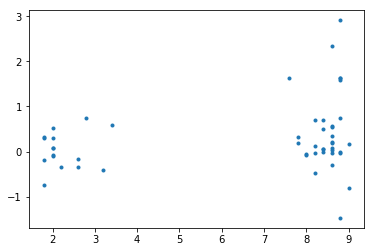

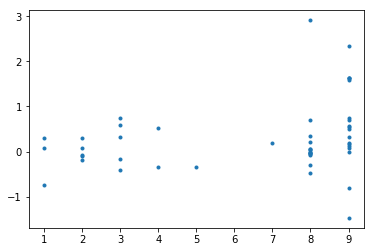

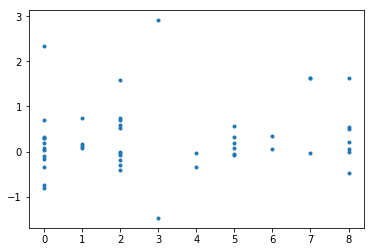

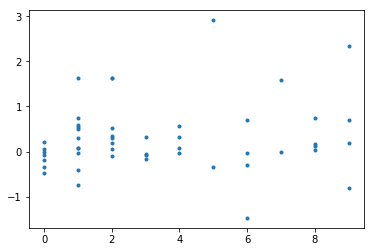

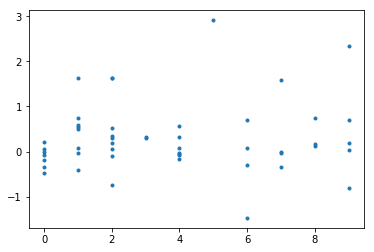

In [15]:
def get_average_improvement(df1, df2):
    ret = []
    for i, j in zip(df1,df2):
        ret.append(np.sum(j) - np.sum(i))
    return ret

improvement = get_average_improvement(bestMSE, bestCOMBO)
np.mean(improvement), np.std(improvement)


fig, ax = plt.subplots()
ax.plot(averageDegree,improvement, '.')
plt.show()


fig, ax = plt.subplots()
ax.plot(targetDegree,improvement, '.')
plt.show()


fig, ax = plt.subplots()
ax.plot(target_inD,improvement, '.')
plt.show()

fig, ax = plt.subplots()
ax.plot(target_outD,improvement, '.')
plt.show()

fig, ax = plt.subplots()
ax.plot(descendants,improvement, '.')
plt.show()

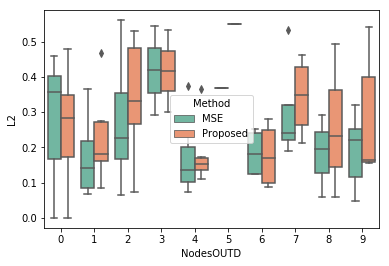

In [14]:
lst = []
for x,y in zip(qbestMSE, descendants):
    lst.append(['MSE', np.mean(x), y])
for x,y in zip(qbestCOMBO, descendants):
    lst.append(['Proposed', np.mean(x), y])


df = pd.DataFrame(lst, columns = ['Method', 'L2', 'NodesOUTD'])
ax = sns.boxplot(data=df, x = 'NodesOUTD', y = 'L2', hue = 'Method', linewidth = 1.5,palette="Set2")

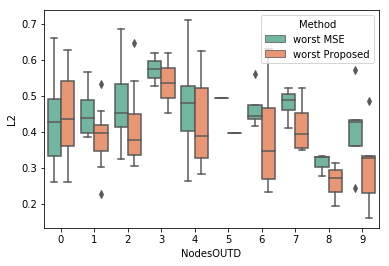

In [11]:
lst = []

for x,y in zip(qworstMSE, descendants):
    lst.append(['worst MSE', np.mean(x), y])
for x,y in zip(qworstCOMBO, descendants):
    lst.append(['worst Proposed', np.mean(x), y])


df = pd.DataFrame(lst, columns = ['Method', 'L2', 'NodesOUTD'])
ax = sns.boxplot(data=df, x = 'NodesOUTD', y = 'L2', hue = 'Method', linewidth = 1.5,palette="Set2")

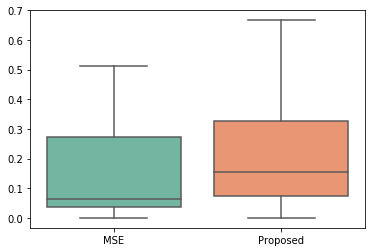

In [13]:
import seaborn as sns
val1 = []
for each in sbestMSE:
    val1.append(np.mean(each))
val2 = []
for each in sbestCOMBO:
    val2.append(np.mean(each))

val = []
for x, y in zip(val1, val2):
    val.append([x, y])
df = pd.DataFrame(val, columns = ['MSE', 'Proposed'])
ax = sns.boxplot(data=df, palette="Set2")

In [77]:
np.max(val1), np.max(val2)

(0.6640452593945086, 0.7661277271514675)

array([ 0.0034327 , -0.02559248, -0.13416377, -0.28205571,  0.05900715,
       -0.10903223,  0.2575864 ,  0.09371263, -0.30997229,  0.06285865,
       -0.04113317, -0.28456472, -0.15928204,  0.27316155,  0.56710605,
        0.55499861,  0.15069201,  0.08087676, -0.41550277,  0.06934814,
       -0.37002946,  0.20243078,  0.32295185,  0.21044946, -0.06087649,
       -0.07757568,  0.43419254, -0.16565832, -0.54071483,  0.1115466 ,
        0.00396973,  0.32194001, -0.42890713, -0.04492837, -0.08022409,
        0.30079676, -0.02563958,  0.01746376, -0.27542297,  0.24730838,
        0.22839099, -0.0525733 ,  0.06003491,  0.19578927, -0.20614404,
        0.15330721,  0.06472666, -0.03574063,  0.35898603, -0.42787733])

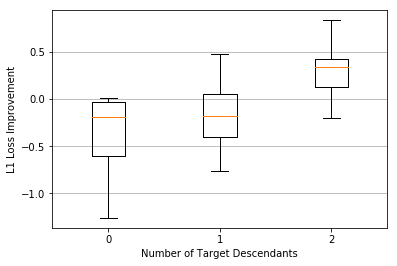

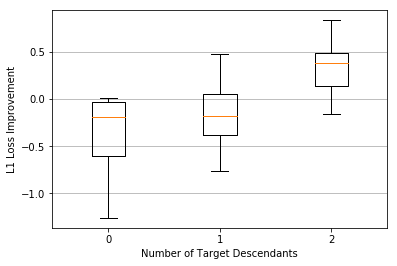

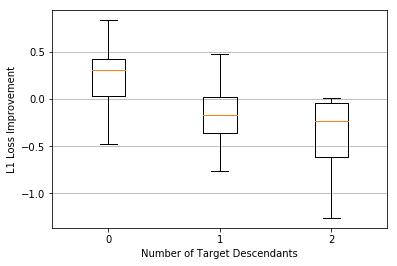

In [16]:
def box_plots(X,Y):
    box = []
    for i in np.unique(X):
        box.append([])
    for x,y in zip(X, Y):
        box[x].append(y)
    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.yaxis.grid(True)
    ax.set_xlabel("Number of Target Descendants")
    ax.set_ylabel("L1 Loss Improvement")
    bp = ax.boxplot(box, showfliers=False, labels = ['0', '1', '2'])
    
box_plots(descendants, improvement)
box_plots(target_outD, improvement)
box_plots(target_inD, improvement)

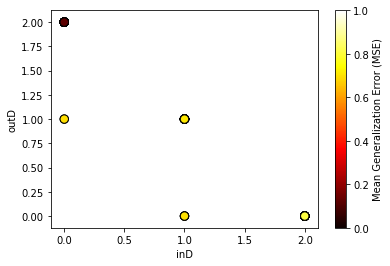

In [45]:
def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', zlab= 'Mean Generalization Error (MSE)', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=70, edgecolor='black', cmap = 'hot')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    #plt.colorbar(cax)
    cbar = plt.colorbar(cax)
    cbar.set_label(zlab)
    plt.show()
    

heat_plot(target_outD, target_inD, normalize(improvement), xlab = 'inD', ylab='outD')

In [ ]:
np.mean(bestMSE), np.mean(bestCOMBO), np.std(bestMSE), np.std(bestCOMBO)

In [ ]:
improvement
fig, ax = plt.subplots()
ax.plot(averageDegree,improvement, '.')
plt.show()

improvement
fig, ax = plt.subplots()
ax.plot(targetDegree,improvement, '.')
plt.show()

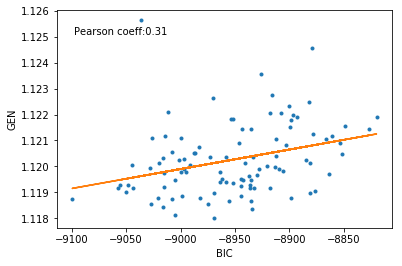

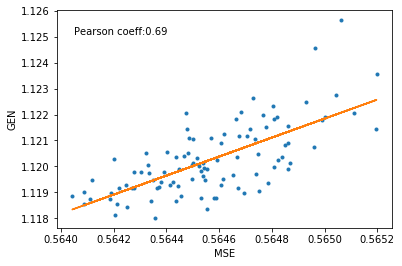

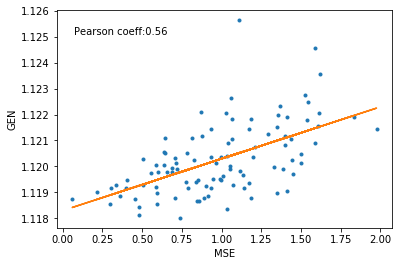

In [11]:
fig, ax = plt.subplots()
b,m = polyfit(proposed,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(proposed,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(proposed,generalization, '.')
plt.plot(proposed, b + m * np.array(proposed), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(metrics,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(metrics,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(metrics,generalization, '.')
plt.plot(metrics, b + m * np.array(metrics), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


total = normalize(metrics) + normalize(proposed)
fig, ax = plt.subplots()
b,m = polyfit(total,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(total,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(total,generalization, '.')
plt.plot(total, b + m * np.array(total), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


In [ ]:
nbest = 10
final = pd.DataFrame(np.stack((metrics, proposed, total, generalization), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization']))
print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization']))
print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization']))